In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'CustomBaseline'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

THETA = math.pi/2
STANDARD_DEVIATION = 0.0005

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.rotate_flip_add_gaussian_noise_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(1485000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.custom_baseline(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IQ (InputLayer)              [(None, 2, 128)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 128)            114816    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 128)            82048     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896 

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


   1/1306 [..............................] - ETA: 4:11:43 - loss: 2.3979

   9/1306 [..............................] - ETA: 8s - loss: 2.3978     

  17/1306 [..............................] - ETA: 8s - loss: 2.3974

  25/1306 [..............................] - ETA: 8s - loss: 2.3961

  34/1306 [..............................] - ETA: 8s - loss: 2.3916

  43/1306 [..............................] - ETA: 8s - loss: 2.3823

  52/1306 [>.............................] - ETA: 7s - loss: 2.3710

  61/1306 [>.............................] - ETA: 7s - loss: 2.3595

  70/1306 [>.............................] - ETA: 7s - loss: 2.3483

  79/1306 [>.............................] - ETA: 7s - loss: 2.3378

  88/1306 [=>............................] - ETA: 7s - loss: 2.3281

  97/1306 [=>............................] - ETA: 7s - loss: 2.3188

 106/1306 [=>............................] - ETA: 7s - loss: 2.3100

 115/1306 [=>............................] - ETA: 7s - loss: 2.3015

 124/1306 [=>............................] - ETA: 7s - loss: 2.2930

 133/1306 [==>...........................] - ETA: 7s - loss: 2.2846

 142/1306 [==>...........................] - ETA: 7s - loss: 2.2762

 151/1306 [==>...........................] - ETA: 7s - loss: 2.2680

 160/1306 [==>...........................] - ETA: 6s - loss: 2.2600

 169/1306 [==>...........................] - ETA: 6s - loss: 2.2522

 178/1306 [===>..........................] - ETA: 6s - loss: 2.2447

 187/1306 [===>..........................] - ETA: 6s - loss: 2.2374

 196/1306 [===>..........................] - ETA: 6s - loss: 2.2304

 205/1306 [===>..........................] - ETA: 6s - loss: 2.2235

 214/1306 [===>..........................] - ETA: 6s - loss: 2.2169

 223/1306 [====>.........................] - ETA: 6s - loss: 2.2105

 232/1306 [====>.........................] - ETA: 6s - loss: 2.2043

 241/1306 [====>.........................] - ETA: 6s - loss: 2.1983

 250/1306 [====>.........................] - ETA: 6s - loss: 2.1924

 259/1306 [====>.........................] - ETA: 6s - loss: 2.1868

 268/1306 [=====>........................] - ETA: 6s - loss: 2.1814

 277/1306 [=====>........................] - ETA: 6s - loss: 2.1761

 286/1306 [=====>........................] - ETA: 6s - loss: 2.1710

 295/1306 [=====>........................] - ETA: 6s - loss: 2.1660

 304/1306 [=====>........................] - ETA: 5s - loss: 2.1612

 313/1306 [======>.......................] - ETA: 5s - loss: 2.1565

 322/1306 [======>.......................] - ETA: 5s - loss: 2.1519

 331/1306 [======>.......................] - ETA: 5s - loss: 2.1475

 340/1306 [======>.......................] - ETA: 5s - loss: 2.1432

 349/1306 [=======>......................] - ETA: 5s - loss: 2.1390

 358/1306 [=======>......................] - ETA: 5s - loss: 2.1349

 367/1306 [=======>......................] - ETA: 5s - loss: 2.1309

 376/1306 [=======>......................] - ETA: 5s - loss: 2.1270

 385/1306 [=======>......................] - ETA: 5s - loss: 2.1232

 394/1306 [========>.....................] - ETA: 5s - loss: 2.1194

 403/1306 [========>.....................] - ETA: 5s - loss: 2.1158

 412/1306 [========>.....................] - ETA: 5s - loss: 2.1122

 421/1306 [========>.....................] - ETA: 5s - loss: 2.1087

 429/1306 [========>.....................] - ETA: 5s - loss: 2.1057

 438/1306 [=========>....................] - ETA: 5s - loss: 2.1023

 447/1306 [=========>....................] - ETA: 5s - loss: 2.0990

 456/1306 [=========>....................] - ETA: 5s - loss: 2.0958

 465/1306 [=========>....................] - ETA: 5s - loss: 2.0926

 474/1306 [=========>....................] - ETA: 4s - loss: 2.0895

 483/1306 [==========>...................] - ETA: 4s - loss: 2.0865

 492/1306 [==========>...................] - ETA: 4s - loss: 2.0835

 501/1306 [==========>...................] - ETA: 4s - loss: 2.0805

 509/1306 [==========>...................] - ETA: 4s - loss: 2.0780

 518/1306 [==========>...................] - ETA: 4s - loss: 2.0751

 527/1306 [===========>..................] - ETA: 4s - loss: 2.0724

 536/1306 [===========>..................] - ETA: 4s - loss: 2.0696

 545/1306 [===========>..................] - ETA: 4s - loss: 2.0669

 554/1306 [===========>..................] - ETA: 4s - loss: 2.0643

 563/1306 [===========>..................] - ETA: 4s - loss: 2.0617

 572/1306 [============>.................] - ETA: 4s - loss: 2.0591

 581/1306 [============>.................] - ETA: 4s - loss: 2.0566

 590/1306 [============>.................] - ETA: 4s - loss: 2.0541

 599/1306 [============>.................] - ETA: 4s - loss: 2.0517

 608/1306 [============>.................]

 - ETA: 4s - loss: 2.0493

 617/1306 [=============>................] - ETA: 4s - loss: 2.0469

 626/1306 [=============>................] - ETA: 4s - loss: 2.0446



 635/1306 [=============>................] - ETA: 3s - loss: 2.0423

 644/1306 [=============>................] - ETA: 3s - loss: 2.0400

 653/1306 [==============>...............] - ETA: 3s - loss: 2.0378

 662/1306 [==============>...............] - ETA: 3s - loss: 2.0356

 671/1306 [==============>...............] - ETA: 3s - loss: 2.0335

 680/1306 [==============>...............] - ETA: 3s - loss: 2.0314

 689/1306 [==============>...............] - ETA: 3s - loss: 2.0293

 698/1306 [===============>..............] - ETA: 3s - loss: 2.0272

 707/1306 [===============>..............] - ETA: 3s - loss: 2.0252

 716/1306 [===============>..............] - ETA: 3s - loss: 2.0231

 725/1306 [===============>..............] - ETA: 3s - loss: 2.0212

 734/1306 [===============>..............] - ETA: 3s - loss: 2.0192

 743/1306 [================>.............] - ETA: 3s - loss: 2.0173

 752/1306 [================>.............] - ETA: 3s - loss: 2.0154

 761/1306 [================>.............] - ETA: 3s - loss: 2.0135

 770/1306 [================>.............] - ETA: 3s - loss: 2.0117

 779/1306 [================>.............] - ETA: 3s - loss: 2.0098

 788/1306 [=================>............] - ETA: 3s - loss: 2.0080

 798/1306 [=================>............] - ETA: 3s - loss: 2.0061

 807/1306 [=================>............] - ETA: 2s - loss: 2.0043

 816/1306 [=================>............] - ETA: 2s - loss: 2.0026

 824/1306 [=================>............] - ETA: 2s - loss: 2.0011

 833/1306 [==================>...........] - ETA: 2s - loss: 1.9994

 841/1306 [==================>...........] - ETA: 2s - loss: 1.9979

 850/1306 [==================>...........] - ETA: 2s - loss: 1.9962

 859/1306 [==================>...........] - ETA: 2s - loss: 1.9946



 868/1306 [==================>...........] - ETA: 2s - loss: 1.9930

 877/1306 [===================>..........] - ETA: 2s - loss: 1.9914

 886/1306 [===================>..........] - ETA: 2s - loss: 1.9898

 895/1306 [===================>..........] - ETA: 2s - loss: 1.9883

 904/1306 [===================>..........] - ETA: 2s - loss: 1.9867

 913/1306 [===================>..........] - ETA: 2s - loss: 1.9852

 922/1306 [====================>.........] - ETA: 2s - loss: 1.9837

 931/1306 [====================>.........] - ETA: 2s - loss: 1.9822

 940/1306 [====================>.........] - ETA: 2s - loss: 1.9807

 949/1306 [====================>.........] - ETA: 2s - loss: 1.9793

 958/1306 [=====================>........] - ETA: 2s - loss: 1.9778

 967/1306 [=====================>........] - ETA: 2s - loss: 1.9764

 976/1306 [=====================>........] - ETA: 1s - loss: 1.9750

 985/1306 [=====================>........] - ETA: 1s - loss: 1.9736

 994/1306 [=====================>........] - ETA: 1s - loss: 1.9722

1003/1306 [======================>.......] - ETA: 1s - loss: 1.9708

1012/1306 [======================>.......] - ETA: 1s - loss: 1.9695

1021/1306 [======================>.......] - ETA: 1s - loss: 1.9681

1030/1306 [======================>.......] - ETA: 1s - loss: 1.9668

1038/1306 [======================>.......] - ETA: 1s - loss: 1.9656

1047/1306 [=======================>......] - ETA: 1s - loss: 1.9643

1056/1306 [=======================>......] - ETA: 1s - loss: 1.9630

1065/1306 [=======================>......] - ETA: 1s - loss: 1.9618

1074/1306 [=======================>......] - ETA: 1s - loss: 1.9605

1083/1306 [=======================>......] - ETA: 1s - loss: 1.9592

1092/1306 [========================>.....] - ETA: 1s - loss: 1.9580

1101/1306 [========================>.....] - ETA: 1s - loss: 1.9568

1110/1306 [========================>.....] - ETA: 1s - loss: 1.9555

1119/1306 [========================>.....] - ETA: 1s - loss: 1.9543

1128/1306 [========================>.....] - ETA: 1s - loss: 1.9531

1137/1306 [=========================>....] - ETA: 1s - loss: 1.9519

1146/1306 [=========================>....] - ETA: 0s - loss: 1.9508

1155/1306 [=========================>....] - ETA: 0s - loss: 1.9496

1164/1306 [=========================>....] - ETA: 0s - loss: 1.9484



1173/1306 [=========================>....] - ETA: 0s - loss: 1.9473

1182/1306 [==========================>...] - ETA: 0s - loss: 1.9462

1191/1306 [==========================>...] - ETA: 0s - loss: 1.9450

1200/1306 [==========================>...] - ETA: 0s - loss: 1.9439

1209/1306 [==========================>...] - ETA: 0s - loss: 1.9428

1218/1306 [==========================>...] - ETA: 0s - loss: 1.9417

1227/1306 [===========================>..] - ETA: 0s - loss: 1.9406

1236/1306 [===========================>..] - ETA: 0s - loss: 1.9395

1245/1306 [===========================>..] - ETA: 0s - loss: 1.9385

1254/1306 [===========================>..] - ETA: 0s - loss: 1.9374

1263/1306 [============================>.] - ETA: 0s - loss: 1.9364

1272/1306 [============================>.] - ETA: 0s - loss: 1.9353



1281/1306 [============================>.] - ETA: 0s - loss: 1.9343

1290/1306 [============================>.] - ETA: 0s - loss: 1.9332

1299/1306 [============================>.] - ETA: 0s - loss: 1.9322

1306/1306 [==============================] - ETA: 0s - loss: 1.9314

1306/1306 [==============================] - 20s 7ms/step - loss: 1.9313 - val_loss: 1.6602


Epoch 2/100
   1/1306 [..............................] - ETA: 9s - loss: 1.6528

  10/1306 [..............................] - ETA: 7s - loss: 1.6385

  19/1306 [..............................] - ETA: 7s - loss: 1.6384

  28/1306 [..............................] - ETA: 7s - loss: 1.6394

  37/1306 [..............................] - ETA: 7s - loss: 1.6396

  46/1306 [>.............................] - ETA: 7s - loss: 1.6396

  55/1306 [>.............................] - ETA: 7s - loss: 1.6396

  64/1306 [>.............................] - ETA: 7s - loss: 1.6395

  73/1306 [>.............................] - ETA: 7s - loss: 1.6396

  82/1306 [>.............................] - ETA: 7s - loss: 1.6397

  91/1306 [=>............................] - ETA: 7s - loss: 1.6396

 100/1306 [=>............................] - ETA: 7s - loss: 1.6395



 109/1306 [=>............................] - ETA: 7s - loss: 1.6395

 118/1306 [=>............................] - ETA: 6s - loss: 1.6395

 127/1306 [=>............................] - ETA: 6s - loss: 1.6395

 136/1306 [==>...........................] - ETA: 6s - loss: 1.6394

 145/1306 [==>...........................] - ETA: 6s - loss: 1.6393

 154/1306 [==>...........................] - ETA: 6s - loss: 1.6391

 163/1306 [==>...........................] - ETA: 6s - loss: 1.6390

 172/1306 [==>...........................] - ETA: 6s - loss: 1.6388

 181/1306 [===>..........................] - ETA: 6s - loss: 1.6386

 190/1306 [===>..........................] - ETA: 6s - loss: 1.6384

 199/1306 [===>..........................] - ETA: 6s - loss: 1.6382

 208/1306 [===>..........................] - ETA: 6s - loss: 1.6380

 217/1306 [===>..........................] - ETA: 6s - loss: 1.6377

 226/1306 [====>.........................] - ETA: 6s - loss: 1.6374

 235/1306 [====>.........................] - ETA: 6s - loss: 1.6372

 244/1306 [====>.........................] - ETA: 6s - loss: 1.6369

 253/1306 [====>.........................] - ETA: 6s - loss: 1.6366

 262/1306 [=====>........................] - ETA: 6s - loss: 1.6364

 271/1306 [=====>........................] - ETA: 6s - loss: 1.6361

 280/1306 [=====>........................] - ETA: 6s - loss: 1.6358

 288/1306 [=====>........................] - ETA: 5s - loss: 1.6355

 297/1306 [=====>........................] - ETA: 5s - loss: 1.6352

 306/1306 [======>.......................] - ETA: 5s - loss: 1.6349

 315/1306 [======>.......................] - ETA: 5s - loss: 1.6346

 324/1306 [======>.......................] - ETA: 5s - loss: 1.6342



 333/1306 [======>.......................] - ETA: 5s - loss: 1.6339

 342/1306 [======>.......................] - ETA: 5s - loss: 1.6336

 351/1306 [=======>......................] - ETA: 5s - loss: 1.6333

 360/1306 [=======>......................] - ETA: 5s - loss: 1.6329

 369/1306 [=======>......................] - ETA: 5s - loss: 1.6326

 378/1306 [=======>......................] - ETA: 5s - loss: 1.6323

 387/1306 [=======>......................] - ETA: 5s - loss: 1.6319

 396/1306 [========>.....................] - ETA: 5s - loss: 1.6315

 405/1306 [========>.....................] - ETA: 5s - loss: 1.6312

 414/1306 [========>.....................] - ETA: 5s - loss: 1.6308

 423/1306 [========>.....................] - ETA: 5s - loss: 1.6304

 432/1306 [========>.....................] - ETA: 5s - loss: 1.6300

 441/1306 [=========>....................] - ETA: 5s - loss: 1.6297

 450/1306 [=========>....................] - ETA: 5s - loss: 1.6293

 459/1306 [=========>....................] - ETA: 4s - loss: 1.6289

 468/1306 [=========>....................] - ETA: 4s - loss: 1.6285

 477/1306 [=========>....................] - ETA: 4s - loss: 1.6281

 486/1306 [==========>...................] - ETA: 4s - loss: 1.6277

 495/1306 [==========>...................] - ETA: 4s - loss: 1.6274

 504/1306 [==========>...................] - ETA: 4s - loss: 1.6270

 513/1306 [==========>...................] - ETA: 4s - loss: 1.6266

 522/1306 [==========>...................] - ETA: 4s - loss: 1.6262

 531/1306 [===========>..................] - ETA: 4s - loss: 1.6258

 540/1306 [===========>..................] - ETA: 4s - loss: 1.6254

 549/1306 [===========>..................] - ETA: 4s - loss: 1.6250

 557/1306 [===========>..................] - ETA: 4s - loss: 1.6246

 566/1306 [============>.................] - ETA: 4s - loss: 1.6242

 575/1306 [============>.................] - ETA: 4s - loss: 1.6238

 584/1306 [============>.................] - ETA: 4s - loss: 1.6233

 593/1306 [============>.................] - ETA: 4s - loss: 1.6229

 602/1306 [============>.................] - ETA: 4s - loss: 1.6225

 611/1306 [=============>................] - ETA: 4s - loss: 1.6221

 620/1306 [=============>................] - ETA: 4s - loss: 1.6216

 629/1306 [=============>................] - ETA: 3s - loss: 1.6212

 638/1306 [=============>................] - ETA: 3s - loss: 1.6208

 647/1306 [=============>................] - ETA: 3s - loss: 1.6204

 656/1306 [==============>...............] - ETA: 3s - loss: 1.6199

 665/1306 [==============>...............] - ETA: 3s - loss: 1.6195

 674/1306 [==============>...............] - ETA: 3s - loss: 1.6190

 683/1306 [==============>...............] - ETA: 3s - loss: 1.6186

 692/1306 [==============>...............] - ETA: 3s - loss: 1.6182

 701/1306 [===============>..............] - ETA: 3s - loss: 1.6177

 710/1306 [===============>..............] - ETA: 3s - loss: 1.6173

 719/1306 [===============>..............] - ETA: 3s - loss: 1.6168



 728/1306 [===============>..............] - ETA: 3s - loss: 1.6164

 737/1306 [===============>..............] - ETA: 3s - loss: 1.6160

 746/1306 [================>.............] - ETA: 3s - loss: 1.6155

 755/1306 [================>.............] - ETA: 3s - loss: 1.6151

 764/1306 [================>.............] - ETA: 3s - loss: 1.6146

 773/1306 [================>.............] - ETA: 3s - loss: 1.6142

 782/1306 [================>.............] - ETA: 3s - loss: 1.6137

 790/1306 [=================>............] - ETA: 3s - loss: 1.6133

 799/1306 [=================>............] - ETA: 3s - loss: 1.6129

 808/1306 [=================>............] - ETA: 2s - loss: 1.6125

 817/1306 [=================>............] - ETA: 2s - loss: 1.6120

 826/1306 [=================>............] - ETA: 2s - loss: 1.6116

 835/1306 [==================>...........] - ETA: 2s - loss: 1.6111

 844/1306 [==================>...........] - ETA: 2s - loss: 1.6107

 853/1306 [==================>...........] - ETA: 2s - loss: 1.6103

 862/1306 [==================>...........] - ETA: 2s - loss: 1.6098

 871/1306 [===================>..........] - ETA: 2s - loss: 1.6094

 880/1306 [===================>..........] - ETA: 2s - loss: 1.6090

 889/1306 [===================>..........] - ETA: 2s - loss: 1.6085

 898/1306 [===================>..........] - ETA: 2s - loss: 1.6081

 907/1306 [===================>..........] - ETA: 2s - loss: 1.6077

 916/1306 [====================>.........] - ETA: 2s - loss: 1.6072

 925/1306 [====================>.........] - ETA: 2s - loss: 1.6068

 934/1306 [====================>.........] - ETA: 2s - loss: 1.6064

 942/1306 [====================>.........] - ETA: 2s - loss: 1.6060

 951/1306 [====================>.........] - ETA: 2s - loss: 1.6056

 960/1306 [=====================>........] - ETA: 2s - loss: 1.6052

 969/1306 [=====================>........] - ETA: 1s - loss: 1.6048

 978/1306 [=====================>........] - ETA: 1s - loss: 1.6043

 987/1306 [=====================>........] - ETA: 1s - loss: 1.6039

 996/1306 [=====================>........] - ETA: 1s - loss: 1.6035

1005/1306 [======================>.......] - ETA: 1s - loss: 1.6031

1014/1306 [======================>.......] - ETA: 1s - loss: 1.6027

1023/1306 [======================>.......] - ETA: 1s - loss: 1.6023

1032/1306 [======================>.......] - ETA: 1s - loss: 1.6019

1041/1306 [======================>.......] - ETA: 1s - loss: 1.6015

1049/1306 [=======================>......] - ETA: 1s - loss: 1.6011

1058/1306 [=======================>......] - ETA: 1s - loss: 1.6008

1067/1306 [=======================>......] - ETA: 1s - loss: 1.6004

1076/1306 [=======================>......] - ETA: 1s - loss: 1.6000

1085/1306 [=======================>......] - ETA: 1s - loss: 1.5996

1094/1306 [========================>.....] - ETA: 1s - loss: 1.5992

1103/1306 [========================>.....] - ETA: 1s - loss: 1.5988

1112/1306 [========================>.....] - ETA: 1s - loss: 1.5984

1121/1306 [========================>.....] - ETA: 1s - loss: 1.5981

1130/1306 [========================>.....] - ETA: 1s - loss: 1.5977

1139/1306 [=========================>....] - ETA: 0s - loss: 1.5973

1148/1306 [=========================>....] - ETA: 0s - loss: 1.5969

1157/1306 [=========================>....] - ETA: 0s - loss: 1.5965

1166/1306 [=========================>....] - ETA: 0s - loss: 1.5962

1175/1306 [=========================>....] - ETA: 0s - loss: 1.5958

1184/1306 [==========================>...] - ETA: 0s - loss: 1.5954

1193/1306 [==========================>...] - ETA: 0s - loss: 1.5951

1202/1306 [==========================>...] - ETA: 0s - loss: 1.5947

1211/1306 [==========================>...] - ETA: 0s - loss: 1.5943

1220/1306 [===========================>..] - ETA: 0s - loss: 1.5940

1229/1306 [===========================>..] - ETA: 0s - loss: 1.5936

1238/1306 [===========================>..] - ETA: 0s - loss: 1.5932

1247/1306 [===========================>..] - ETA: 0s - loss: 1.5929

1256/1306 [===========================>..] - ETA: 0s - loss: 1.5925

1265/1306 [============================>.] - ETA: 0s - loss: 1.5922

1274/1306 [============================>.] - ETA: 0s - loss: 1.5918

1283/1306 [============================>.] - ETA: 0s - loss: 1.5915

1292/1306 [============================>.] - ETA: 0s - loss: 1.5911

1301/1306 [============================>.] - ETA: 0s - loss: 1.5908

1306/1306 [==============================] - 8s 6ms/step - loss: 1.5905 - val_loss: 1.4862


Epoch 3/100
   1/1306 [..............................] - ETA: 7s - loss: 1.4212

  10/1306 [..............................] - ETA: 7s - loss: 1.4575

  19/1306 [..............................] - ETA: 7s - loss: 1.4592

  27/1306 [..............................] - ETA: 7s - loss: 1.4595

  36/1306 [..............................] - ETA: 7s - loss: 1.4607

  45/1306 [>.............................] - ETA: 7s - loss: 1.4622

  55/1306 [>.............................] - ETA: 7s - loss: 1.4629

  64/1306 [>.............................] - ETA: 7s - loss: 1.4631

  73/1306 [>.............................] - ETA: 7s - loss: 1.4632

  82/1306 [>.............................] - ETA: 7s - loss: 1.4632

  91/1306 [=>............................] - ETA: 7s - loss: 1.4633

 100/1306 [=>............................] - ETA: 7s - loss: 1.4636

 109/1306 [=>............................] - ETA: 7s - loss: 1.4639

 118/1306 [=>............................] - ETA: 7s - loss: 1.4641

 126/1306 [=>............................] - ETA: 7s - loss: 1.4642

 135/1306 [==>...........................] - ETA: 6s - loss: 1.4643

 144/1306 [==>...........................] - ETA: 6s - loss: 1.4644



 153/1306 [==>...........................] - ETA: 6s - loss: 1.4645

 162/1306 [==>...........................] - ETA: 6s - loss: 1.4645

 171/1306 [==>...........................] - ETA: 6s - loss: 1.4645

 180/1306 [===>..........................] - ETA: 6s - loss: 1.4646

 189/1306 [===>..........................] - ETA: 6s - loss: 1.4646



 198/1306 [===>..........................] - ETA: 6s - loss: 1.4645

 207/1306 [===>..........................] - ETA: 6s - loss: 1.4645

 216/1306 [===>..........................] - ETA: 6s - loss: 1.4645

 225/1306 [====>.........................] - ETA: 6s - loss: 1.4645

 234/1306 [====>.........................] - ETA: 6s - loss: 1.4645

 243/1306 [====>.........................] - ETA: 6s - loss: 1.4645

 252/1306 [====>.........................] - ETA: 6s - loss: 1.4644

 261/1306 [====>.........................] - ETA: 6s - loss: 1.4644

 270/1306 [=====>........................] - ETA: 6s - loss: 1.4644

 279/1306 [=====>........................] - ETA: 6s - loss: 1.4643

 288/1306 [=====>........................] - ETA: 6s - loss: 1.4642

 297/1306 [=====>........................] - ETA: 5s - loss: 1.4642

 306/1306 [======>.......................] - ETA: 5s - loss: 1.4641

 315/1306 [======>.......................] - ETA: 5s - loss: 1.4641

 324/1306 [======>.......................] - ETA: 5s - loss: 1.4640



 333/1306 [======>.......................] - ETA: 5s - loss: 1.4640

 342/1306 [======>.......................] - ETA: 5s - loss: 1.4639

 351/1306 [=======>......................] - ETA: 5s - loss: 1.4639

 360/1306 [=======>......................] - ETA: 5s - loss: 1.4638

 369/1306 [=======>......................] - ETA: 5s - loss: 1.4638

 378/1306 [=======>......................] - ETA: 5s - loss: 1.4637

 387/1306 [=======>......................] - ETA: 5s - loss: 1.4637

 396/1306 [========>.....................] - ETA: 5s - loss: 1.4636

 405/1306 [========>.....................] - ETA: 5s - loss: 1.4636

 414/1306 [========>.....................] - ETA: 5s - loss: 1.4635

 423/1306 [========>.....................] - ETA: 5s - loss: 1.4635

 432/1306 [========>.....................] - ETA: 5s - loss: 1.4634

 441/1306 [=========>....................] - ETA: 5s - loss: 1.4633

 450/1306 [=========>....................] - ETA: 4s - loss: 1.4633

 459/1306 [=========>....................] - ETA: 4s - loss: 1.4632

 468/1306 [=========>....................] - ETA: 4s - loss: 1.4632

 477/1306 [=========>....................] - ETA: 4s - loss: 1.4631

 486/1306 [==========>...................] - ETA: 4s - loss: 1.4630

 495/1306 [==========>...................] - ETA: 4s - loss: 1.4630

 504/1306 [==========>...................] - ETA: 4s - loss: 1.4629

 513/1306 [==========>...................] - ETA: 4s - loss: 1.4628

 522/1306 [==========>...................] - ETA: 4s - loss: 1.4628

 531/1306 [===========>..................] - ETA: 4s - loss: 1.4627

 540/1306 [===========>..................] - ETA: 4s - loss: 1.4626

 549/1306 [===========>..................] - ETA: 4s - loss: 1.4626

 558/1306 [===========>..................] - ETA: 4s - loss: 1.4625



 567/1306 [============>.................] - ETA: 4s - loss: 1.4625

 576/1306 [============>.................] - ETA: 4s - loss: 1.4624

 585/1306 [============>.................] - ETA: 4s - loss: 1.4624

 594/1306 [============>.................] - ETA: 4s - loss: 1.4623

 603/1306 [============>.................] - ETA: 4s - loss: 1.4623

 613/1306 [=============>................] - ETA: 4s - loss: 1.4622

 622/1306 [=============>................] - ETA: 3s - loss: 1.4621

 632/1306 [=============>................] - ETA: 3s - loss: 1.4621

 641/1306 [=============>................] - ETA: 3s - loss: 1.4620

 650/1306 [=============>................] - ETA: 3s - loss: 1.4619

 659/1306 [==============>...............] - ETA: 3s - loss: 1.4619

 668/1306 [==============>...............] - ETA: 3s - loss: 1.4618

 677/1306 [==============>...............] - ETA: 3s - loss: 1.4618

 686/1306 [==============>...............] - ETA: 3s - loss: 1.4617

 695/1306 [==============>...............] - ETA: 3s - loss: 1.4617

 704/1306 [===============>..............] - ETA: 3s - loss: 1.4616

 713/1306 [===============>..............] - ETA: 3s - loss: 1.4616

 722/1306 [===============>..............] - ETA: 3s - loss: 1.4615

 731/1306 [===============>..............] - ETA: 3s - loss: 1.4615

 740/1306 [===============>..............] - ETA: 3s - loss: 1.4614

 749/1306 [================>.............] - ETA: 3s - loss: 1.4614

 758/1306 [================>.............] - ETA: 3s - loss: 1.4613

 767/1306 [================>.............] - ETA: 3s - loss: 1.4613

 776/1306 [================>.............] - ETA: 3s - loss: 1.4612

 785/1306 [=================>............] - ETA: 3s - loss: 1.4612

 794/1306 [=================>............] - ETA: 2s - loss: 1.4612

 803/1306 [=================>............] - ETA: 2s - loss: 1.4611

 812/1306 [=================>............] - ETA: 2s - loss: 1.4611

 821/1306 [=================>............] - ETA: 2s - loss: 1.4610

 830/1306 [==================>...........] - ETA: 2s - loss: 1.4610

 839/1306 [==================>...........] - ETA: 2s - loss: 1.4609

 848/1306 [==================>...........] - ETA: 2s - loss: 1.4609

 857/1306 [==================>...........] - ETA: 2s - loss: 1.4609

 866/1306 [==================>...........] - ETA: 2s - loss: 1.4608

 875/1306 [===================>..........] - ETA: 2s - loss: 1.4608

 884/1306 [===================>..........] - ETA: 2s - loss: 1.4607

 893/1306 [===================>..........] - ETA: 2s - loss: 1.4607

 902/1306 [===================>..........] - ETA: 2s - loss: 1.4606



 911/1306 [===================>..........] - ETA: 2s - loss: 1.4606

 920/1306 [====================>.........] - ETA: 2s - loss: 1.4606

 929/1306 [====================>.........] - ETA: 2s - loss: 1.4605

 938/1306 [====================>.........] - ETA: 2s - loss: 1.4605

 947/1306 [====================>.........] - ETA: 2s - loss: 1.4604

 956/1306 [====================>.........] - ETA: 2s - loss: 1.4604

 965/1306 [=====================>........] - ETA: 1s - loss: 1.4603

 974/1306 [=====================>........] - ETA: 1s - loss: 1.4603

 983/1306 [=====================>........] - ETA: 1s - loss: 1.4603

 992/1306 [=====================>........] - ETA: 1s - loss: 1.4602

1001/1306 [=====================>........] - ETA: 1s - loss: 1.4602

1010/1306 [======================>.......] - ETA: 1s - loss: 1.4601

1020/1306 [======================>.......] - ETA: 1s - loss: 1.4601



1029/1306 [======================>.......] - ETA: 1s - loss: 1.4600

1038/1306 [======================>.......] - ETA: 1s - loss: 1.4600

1047/1306 [=======================>......] - ETA: 1s - loss: 1.4600

1056/1306 [=======================>......] - ETA: 1s - loss: 1.4599

1065/1306 [=======================>......] - ETA: 1s - loss: 1.4599

1074/1306 [=======================>......] - ETA: 1s - loss: 1.4598

1083/1306 [=======================>......] - ETA: 1s - loss: 1.4598

1092/1306 [========================>.....] - ETA: 1s - loss: 1.4597

1101/1306 [========================>.....] - ETA: 1s - loss: 1.4597

1110/1306 [========================>.....] - ETA: 1s - loss: 1.4597

1119/1306 [========================>.....] - ETA: 1s - loss: 1.4596

1128/1306 [========================>.....] - ETA: 1s - loss: 1.4596

1137/1306 [=========================>....] - ETA: 0s - loss: 1.4595

1146/1306 [=========================>....] - ETA: 0s - loss: 1.4595

1155/1306 [=========================>....] - ETA: 0s - loss: 1.4594

1164/1306 [=========================>....] - ETA: 0s - loss: 1.4594

1173/1306 [=========================>....] - ETA: 0s - loss: 1.4593

1182/1306 [==========================>...] - ETA: 0s - loss: 1.4593

1191/1306 [==========================>...] - ETA: 0s - loss: 1.4592

1200/1306 [==========================>...] - ETA: 0s - loss: 1.4592

1209/1306 [==========================>...] - ETA: 0s - loss: 1.4591

1217/1306 [==========================>...] - ETA: 0s - loss: 1.4591

1226/1306 [===========================>..] - ETA: 0s - loss: 1.4590

1234/1306 [===========================>..] - ETA: 0s - loss: 1.4590

1243/1306 [===========================>..] - ETA: 0s - loss: 1.4589

1252/1306 [===========================>..] - ETA: 0s - loss: 1.4589

1261/1306 [===========================>..] - ETA: 0s - loss: 1.4589

1270/1306 [============================>.] - ETA: 0s - loss: 1.4588

1279/1306 [============================>.] - ETA: 0s - loss: 1.4588

1288/1306 [============================>.] - ETA: 0s - loss: 1.4587

1297/1306 [============================>.] - ETA: 0s - loss: 1.4587

1306/1306 [==============================] - ETA: 0s - loss: 1.4586

1306/1306 [==============================] - 8s 6ms/step - loss: 1.4586 - val_loss: 1.4467


Epoch 4/100
   1/1306 [..............................] - ETA: 9s - loss: 1.3968

  10/1306 [..............................] - ETA: 7s - loss: 1.4181

  19/1306 [..............................] - ETA: 7s - loss: 1.4194

  28/1306 [..............................] - ETA: 7s - loss: 1.4202

  37/1306 [..............................] - ETA: 7s - loss: 1.4213

  45/1306 [>.............................] - ETA: 7s - loss: 1.4220

  53/1306 [>.............................] - ETA: 7s - loss: 1.4231

  61/1306 [>.............................] - ETA: 7s - loss: 1.4241

  69/1306 [>.............................] - ETA: 7s - loss: 1.4248

  78/1306 [>.............................] - ETA: 7s - loss: 1.4255

  87/1306 [>.............................] - ETA: 7s - loss: 1.4261

  95/1306 [=>............................] - ETA: 7s - loss: 1.4265

 102/1306 [=>............................] - ETA: 7s - loss: 1.4268

 109/1306 [=>............................] - ETA: 7s - loss: 1.4271

 118/1306 [=>............................] - ETA: 7s - loss: 1.4274

 127/1306 [=>............................] - ETA: 7s - loss: 1.4277

 136/1306 [==>...........................] - ETA: 7s - loss: 1.4279

 145/1306 [==>...........................] - ETA: 7s - loss: 1.4280

 154/1306 [==>...........................] - ETA: 7s - loss: 1.4281

 163/1306 [==>...........................] - ETA: 7s - loss: 1.4282

 172/1306 [==>...........................] - ETA: 7s - loss: 1.4283



 180/1306 [===>..........................] - ETA: 7s - loss: 1.4283

 188/1306 [===>..........................] - ETA: 7s - loss: 1.4284



 196/1306 [===>..........................] - ETA: 7s - loss: 1.4284

 206/1306 [===>..........................] - ETA: 6s - loss: 1.4285

 215/1306 [===>..........................] - ETA: 6s - loss: 1.4286

 224/1306 [====>.........................] - ETA: 6s - loss: 1.4286

 233/1306 [====>.........................] - ETA: 6s - loss: 1.4287

 242/1306 [====>.........................] - ETA: 6s - loss: 1.4287

 250/1306 [====>.........................] - ETA: 6s - loss: 1.4287



 258/1306 [====>.........................] - ETA: 6s - loss: 1.4287

 266/1306 [=====>........................] - ETA: 6s - loss: 1.4287



 275/1306 [=====>........................] - ETA: 6s - loss: 1.4287

 284/1306 [=====>........................] - ETA: 6s - loss: 1.4287

 293/1306 [=====>........................] - ETA: 6s - loss: 1.4286

 302/1306 [=====>........................] - ETA: 6s - loss: 1.4286

 311/1306 [======>.......................] - ETA: 6s - loss: 1.4286

 320/1306 [======>.......................] - ETA: 6s - loss: 1.4285

 329/1306 [======>.......................] - ETA: 6s - loss: 1.4285



 338/1306 [======>.......................] - ETA: 6s - loss: 1.4285



 347/1306 [======>.......................] - ETA: 5s - loss: 1.4284

 355/1306 [=======>......................] - ETA: 5s - loss: 1.4284

 364/1306 [=======>......................] - ETA: 5s - loss: 1.4283

 373/1306 [=======>......................] - ETA: 5s - loss: 1.4283

 382/1306 [=======>......................] - ETA: 5s - loss: 1.4282

 391/1306 [=======>......................] - ETA: 5s - loss: 1.4281

 400/1306 [========>.....................] - ETA: 5s - loss: 1.4281



 409/1306 [========>.....................] - ETA: 5s - loss: 1.4280

 419/1306 [========>.....................] - ETA: 5s - loss: 1.4279

 428/1306 [========>.....................] - ETA: 5s - loss: 1.4279

 437/1306 [=========>....................] - ETA: 5s - loss: 1.4278

 446/1306 [=========>....................] - ETA: 5s - loss: 1.4277

 455/1306 [=========>....................] - ETA: 5s - loss: 1.4276

 464/1306 [=========>....................] - ETA: 5s - loss: 1.4276

 473/1306 [=========>....................] - ETA: 5s - loss: 1.4275

 482/1306 [==========>...................] - ETA: 5s - loss: 1.4274

 491/1306 [==========>...................] - ETA: 4s - loss: 1.4273

 500/1306 [==========>...................] - ETA: 4s - loss: 1.4272

 509/1306 [==========>...................] - ETA: 4s - loss: 1.4271

 518/1306 [==========>...................] - ETA: 4s - loss: 1.4271

 527/1306 [===========>..................] - ETA: 4s - loss: 1.4270



 536/1306 [===========>..................] - ETA: 4s - loss: 1.4269

 545/1306 [===========>..................] - ETA: 4s - loss: 1.4268

 554/1306 [===========>..................] - ETA: 4s - loss: 1.4268

 563/1306 [===========>..................] - ETA: 4s - loss: 1.4267

 572/1306 [============>.................] - ETA: 4s - loss: 1.4266

 581/1306 [============>.................] - ETA: 4s - loss: 1.4266

 590/1306 [============>.................] - ETA: 4s - loss: 1.4265



 599/1306 [============>.................] - ETA: 4s - loss: 1.4264

 608/1306 [============>.................] - ETA: 4s - loss: 1.4264

 617/1306 [=============>................] - ETA: 4s - loss: 1.4263



 626/1306 [=============>................] - ETA: 4s - loss: 1.4262

 636/1306 [=============>................] - ETA: 4s - loss: 1.4262



 645/1306 [=============>................] - ETA: 3s - loss: 1.4261

 654/1306 [==============>...............] - ETA: 3s - loss: 1.4260

 663/1306 [==============>...............] - ETA: 3s - loss: 1.4260

 672/1306 [==============>...............] - ETA: 3s - loss: 1.4259

 681/1306 [==============>...............] - ETA: 3s - loss: 1.4259

 690/1306 [==============>...............] - ETA: 3s - loss: 1.4258

 699/1306 [===============>..............] - ETA: 3s - loss: 1.4257

 708/1306 [===============>..............] - ETA: 3s - loss: 1.4257

 717/1306 [===============>..............] - ETA: 3s - loss: 1.4256



 726/1306 [===============>..............] - ETA: 3s - loss: 1.4255

 735/1306 [===============>..............] - ETA: 3s - loss: 1.4255

 744/1306 [================>.............] - ETA: 3s - loss: 1.4254

 753/1306 [================>.............] - ETA: 3s - loss: 1.4253

 762/1306 [================>.............] - ETA: 3s - loss: 1.4253

 771/1306 [================>.............] - ETA: 3s - loss: 1.4252



 780/1306 [================>.............] - ETA: 3s - loss: 1.4251



 789/1306 [=================>............] - ETA: 3s - loss: 1.4251

 798/1306 [=================>............] - ETA: 3s - loss: 1.4250

 807/1306 [=================>............] - ETA: 2s - loss: 1.4249

 816/1306 [=================>............] - ETA: 2s - loss: 1.4249

 825/1306 [=================>............] - ETA: 2s - loss: 1.4248

 834/1306 [==================>...........] - ETA: 2s - loss: 1.4247

 843/1306 [==================>...........] - ETA: 2s - loss: 1.4246

 852/1306 [==================>...........] - ETA: 2s - loss: 1.4246

 861/1306 [==================>...........] - ETA: 2s - loss: 1.4245



 870/1306 [==================>...........] - ETA: 2s - loss: 1.4244

 879/1306 [===================>..........] - ETA: 2s - loss: 1.4243

 888/1306 [===================>..........] - ETA: 2s - loss: 1.4243

 897/1306 [===================>..........] - ETA: 2s - loss: 1.4242

 906/1306 [===================>..........] - ETA: 2s - loss: 1.4241

 915/1306 [====================>.........] - ETA: 2s - loss: 1.4240



 924/1306 [====================>.........] - ETA: 2s - loss: 1.4239

 933/1306 [====================>.........] - ETA: 2s - loss: 1.4238

 942/1306 [====================>.........] - ETA: 2s - loss: 1.4238

 951/1306 [====================>.........] - ETA: 2s - loss: 1.4237

 960/1306 [=====================>........] - ETA: 2s - loss: 1.4236

 969/1306 [=====================>........] - ETA: 1s - loss: 1.4235

 978/1306 [=====================>........] - ETA: 1s - loss: 1.4234

 987/1306 [=====================>........] - ETA: 1s - loss: 1.4233

 997/1306 [=====================>........] - ETA: 1s - loss: 1.4232

1007/1306 [======================>.......] - ETA: 1s - loss: 1.4231

1016/1306 [======================>.......] - ETA: 1s - loss: 1.4231

1025/1306 [======================>.......] - ETA: 1s - loss: 1.4230

1034/1306 [======================>.......] - ETA: 1s - loss: 1.4229

1043/1306 [======================>.......] - ETA: 1s - loss: 1.4228

1052/1306 [=======================>......] - ETA: 1s - loss: 1.4227

1061/1306 [=======================>......] - ETA: 1s - loss: 1.4226

1070/1306 [=======================>......] - ETA: 1s - loss: 1.4225

1079/1306 [=======================>......] - ETA: 1s - loss: 1.4224

1088/1306 [=======================>......] - ETA: 1s - loss: 1.4223

1097/1306 [========================>.....] - ETA: 1s - loss: 1.4222



1106/1306 [========================>.....] - ETA: 1s - loss: 1.4221

1115/1306 [========================>.....] - ETA: 1s - loss: 1.4220



1124/1306 [========================>.....] - ETA: 1s - loss: 1.4219

1133/1306 [=========================>....] - ETA: 1s - loss: 1.4218

1142/1306 [=========================>....] - ETA: 0s - loss: 1.4217

1151/1306 [=========================>....] - ETA: 0s - loss: 1.4216

1160/1306 [=========================>....] - ETA: 0s - loss: 1.4215

1169/1306 [=========================>....] - ETA: 0s - loss: 1.4214

1178/1306 [==========================>...] - ETA: 0s - loss: 1.4213

1187/1306 [==========================>...] - ETA: 0s - loss: 1.4213

1196/1306 [==========================>...] - ETA: 0s - loss: 1.4212

1205/1306 [==========================>...] - ETA: 0s - loss: 1.4211

1214/1306 [==========================>...] - ETA: 0s - loss: 1.4210

1223/1306 [===========================>..] - ETA: 0s - loss: 1.4209

1232/1306 [===========================>..] - ETA: 0s - loss: 1.4208



1241/1306 [===========================>..] - ETA: 0s - loss: 1.4207

1250/1306 [===========================>..] - ETA: 0s - loss: 1.4206

1259/1306 [===========================>..] - ETA: 0s - loss: 1.4205

1269/1306 [============================>.] - ETA: 0s - loss: 1.4204



1278/1306 [============================>.] - ETA: 0s - loss: 1.4203

1287/1306 [============================>.] - ETA: 0s - loss: 1.4202

1295/1306 [============================>.] - ETA: 0s - loss: 1.4201

1304/1306 [============================>.] - ETA: 0s - loss: 1.4200

1306/1306 [==============================] - 8s 6ms/step - loss: 1.4200 - val_loss: 1.3920


Epoch 5/100
   1/1306 [..............................] - ETA: 9s - loss: 1.4120

  10/1306 [..............................] - ETA: 7s - loss: 1.3944

  19/1306 [..............................] - ETA: 7s - loss: 1.3869

  28/1306 [..............................] - ETA: 7s - loss: 1.3837

  37/1306 [..............................] - ETA: 7s - loss: 1.3817

  46/1306 [>.............................] - ETA: 7s - loss: 1.3807

  54/1306 [>.............................] - ETA: 7s - loss: 1.3799



  63/1306 [>.............................] - ETA: 7s - loss: 1.3789

  71/1306 [>.............................] - ETA: 7s - loss: 1.3780

  80/1306 [>.............................] - ETA: 7s - loss: 1.3772



  89/1306 [=>............................] - ETA: 7s - loss: 1.3765

  98/1306 [=>............................] - ETA: 7s - loss: 1.3761

 107/1306 [=>............................] - ETA: 7s - loss: 1.3757

 116/1306 [=>............................] - ETA: 7s - loss: 1.3752

 125/1306 [=>............................] - ETA: 7s - loss: 1.3748

 133/1306 [==>...........................] - ETA: 7s - loss: 1.3745

 142/1306 [==>...........................] - ETA: 7s - loss: 1.3742

 151/1306 [==>...........................] - ETA: 6s - loss: 1.3739



 160/1306 [==>...........................] - ETA: 6s - loss: 1.3737

 169/1306 [==>...........................] - ETA: 6s - loss: 1.3735

 178/1306 [===>..........................] - ETA: 6s - loss: 1.3733



 187/1306 [===>..........................] - ETA: 6s - loss: 1.3731



 196/1306 [===>..........................] - ETA: 6s - loss: 1.3729

 205/1306 [===>..........................] - ETA: 6s - loss: 1.3728



 214/1306 [===>..........................] - ETA: 6s - loss: 1.3727

 223/1306 [====>.........................] - ETA: 6s - loss: 1.3725

 232/1306 [====>.........................] - ETA: 6s - loss: 1.3724

 241/1306 [====>.........................] - ETA: 6s - loss: 1.3723

 250/1306 [====>.........................] - ETA: 6s - loss: 1.3721

 259/1306 [====>.........................] - ETA: 6s - loss: 1.3720

 268/1306 [=====>........................] - ETA: 6s - loss: 1.3719

 277/1306 [=====>........................] - ETA: 6s - loss: 1.3718

 286/1306 [=====>........................] - ETA: 6s - loss: 1.3717

 295/1306 [=====>........................] - ETA: 6s - loss: 1.3716

 304/1306 [=====>........................] - ETA: 5s - loss: 1.3715

 313/1306 [======>.......................] - ETA: 5s - loss: 1.3714

 322/1306 [======>.......................] - ETA: 5s - loss: 1.3714

 331/1306 [======>.......................] - ETA: 5s - loss: 1.3713

 340/1306 [======>.......................] - ETA: 5s - loss: 1.3712

 349/1306 [=======>......................] - ETA: 5s - loss: 1.3711

 358/1306 [=======>......................] - ETA: 5s - loss: 1.3711

 367/1306 [=======>......................] - ETA: 5s - loss: 1.3710

 376/1306 [=======>......................] - ETA: 5s - loss: 1.3710

 385/1306 [=======>......................] - ETA: 5s - loss: 1.3710

 394/1306 [========>.....................] - ETA: 5s - loss: 1.3710

 403/1306 [========>.....................] - ETA: 5s - loss: 1.3709

 412/1306 [========>.....................] - ETA: 5s - loss: 1.3709

 422/1306 [========>.....................] - ETA: 5s - loss: 1.3709

 432/1306 [========>.....................] - ETA: 5s - loss: 1.3709

 440/1306 [=========>....................] - ETA: 5s - loss: 1.3709

 449/1306 [=========>....................] - ETA: 5s - loss: 1.3709

 458/1306 [=========>....................] - ETA: 5s - loss: 1.3709



 467/1306 [=========>....................] - ETA: 4s - loss: 1.3709

 476/1306 [=========>....................] - ETA: 4s - loss: 1.3708



 485/1306 [==========>...................] - ETA: 4s - loss: 1.3708

 493/1306 [==========>...................] - ETA: 4s - loss: 1.3708

 502/1306 [==========>...................] - ETA: 4s - loss: 1.3708

 511/1306 [==========>...................] - ETA: 4s - loss: 1.3708

 520/1306 [==========>...................] - ETA: 4s - loss: 1.3707

 529/1306 [===========>..................] - ETA: 4s - loss: 1.3707

 538/1306 [===========>..................] - ETA: 4s - loss: 1.3707

 547/1306 [===========>..................] - ETA: 4s - loss: 1.3707

 556/1306 [===========>..................] - ETA: 4s - loss: 1.3707

 565/1306 [===========>..................] - ETA: 4s - loss: 1.3706

 574/1306 [============>.................] - ETA: 4s - loss: 1.3706

 583/1306 [============>.................] - ETA: 4s - loss: 1.3706



 591/1306 [============>.................] - ETA: 4s - loss: 1.3706

 600/1306 [============>.................] - ETA: 4s - loss: 1.3706

 609/1306 [============>.................] - ETA: 4s - loss: 1.3705



 618/1306 [=============>................] - ETA: 4s - loss: 1.3705

 627/1306 [=============>................] - ETA: 4s - loss: 1.3705

 635/1306 [=============>................] - ETA: 3s - loss: 1.3705

 643/1306 [=============>................] - ETA: 3s - loss: 1.3705

 651/1306 [=============>................] - ETA: 3s - loss: 1.3704

 659/1306 [==============>...............] - ETA: 3s - loss: 1.3704

 667/1306 [==============>...............] - ETA: 3s - loss: 1.3704

 675/1306 [==============>...............] - ETA: 3s - loss: 1.3704

 684/1306 [==============>...............] - ETA: 3s - loss: 1.3703

 693/1306 [==============>...............] - ETA: 3s - loss: 1.3703

 702/1306 [===============>..............] - ETA: 3s - loss: 1.3703

 711/1306 [===============>..............] - ETA: 3s - loss: 1.3702

 720/1306 [===============>..............] - ETA: 3s - loss: 1.3702

 729/1306 [===============>..............] - ETA: 3s - loss: 1.3702

 738/1306 [===============>..............] - ETA: 3s - loss: 1.3701

 747/1306 [================>.............] - ETA: 3s - loss: 1.3701

 756/1306 [================>.............] - ETA: 3s - loss: 1.3701

 765/1306 [================>.............] - ETA: 3s - loss: 1.3701

 774/1306 [================>.............] - ETA: 3s - loss: 1.3700



 783/1306 [================>.............] - ETA: 3s - loss: 1.3700

 792/1306 [=================>............] - ETA: 3s - loss: 1.3700

 800/1306 [=================>............] - ETA: 3s - loss: 1.3699

 809/1306 [=================>............] - ETA: 2s - loss: 1.3699

 818/1306 [=================>............] - ETA: 2s - loss: 1.3699

 827/1306 [=================>............] - ETA: 2s - loss: 1.3699

 836/1306 [==================>...........] - ETA: 2s - loss: 1.3698

 845/1306 [==================>...........] - ETA: 2s - loss: 1.3698

 854/1306 [==================>...........] - ETA: 2s - loss: 1.3698

 863/1306 [==================>...........] - ETA: 2s - loss: 1.3698

 872/1306 [===================>..........] - ETA: 2s - loss: 1.3697

 881/1306 [===================>..........] - ETA: 2s - loss: 1.3697

 890/1306 [===================>..........] - ETA: 2s - loss: 1.3697

 898/1306 [===================>..........] - ETA: 2s - loss: 1.3697



 905/1306 [===================>..........] - ETA: 2s - loss: 1.3697

 912/1306 [===================>..........] - ETA: 2s - loss: 1.3696

 920/1306 [====================>.........] - ETA: 2s - loss: 1.3696

 929/1306 [====================>.........] - ETA: 2s - loss: 1.3696

 938/1306 [====================>.........] - ETA: 2s - loss: 1.3696

 948/1306 [====================>.........] - ETA: 2s - loss: 1.3695

 957/1306 [====================>.........] - ETA: 2s - loss: 1.3695

 966/1306 [=====================>........] - ETA: 2s - loss: 1.3695

 975/1306 [=====================>........] - ETA: 1s - loss: 1.3695

 984/1306 [=====================>........] - ETA: 1s - loss: 1.3694

 993/1306 [=====================>........] - ETA: 1s - loss: 1.3694

1002/1306 [======================>.......] - ETA: 1s - loss: 1.3694

1011/1306 [======================>.......] - ETA: 1s - loss: 1.3694



1020/1306 [======================>.......] - ETA: 1s - loss: 1.3693

1028/1306 [======================>.......] - ETA: 1s - loss: 1.3693

1036/1306 [======================>.......] - ETA: 1s - loss: 1.3693

1044/1306 [======================>.......] - ETA: 1s - loss: 1.3693

1053/1306 [=======================>......] - ETA: 1s - loss: 1.3692

1062/1306 [=======================>......] - ETA: 1s - loss: 1.3692

1071/1306 [=======================>......] - ETA: 1s - loss: 1.3692

1080/1306 [=======================>......] - ETA: 1s - loss: 1.3692

1089/1306 [========================>.....] - ETA: 1s - loss: 1.3691

1097/1306 [========================>.....] - ETA: 1s - loss: 1.3691

1106/1306 [========================>.....] - ETA: 1s - loss: 1.3691

1114/1306 [========================>.....] - ETA: 1s - loss: 1.3691

1123/1306 [========================>.....] - ETA: 1s - loss: 1.3690

1131/1306 [========================>.....] - ETA: 1s - loss: 1.3690

1139/1306 [=========================>....] - ETA: 1s - loss: 1.3690

1147/1306 [=========================>....] - ETA: 0s - loss: 1.3690

1155/1306 [=========================>....] - ETA: 0s - loss: 1.3689

1163/1306 [=========================>....] - ETA: 0s - loss: 1.3689

1172/1306 [=========================>....] - ETA: 0s - loss: 1.3689

1181/1306 [==========================>...] - ETA: 0s - loss: 1.3689



1190/1306 [==========================>...] - ETA: 0s - loss: 1.3688

1199/1306 [==========================>...] - ETA: 0s - loss: 1.3688

1208/1306 [==========================>...] - ETA: 0s - loss: 1.3688

1217/1306 [==========================>...] - ETA: 0s - loss: 1.3688

1226/1306 [===========================>..] - ETA: 0s - loss: 1.3687

1234/1306 [===========================>..] - ETA: 0s - loss: 1.3687

1242/1306 [===========================>..] - ETA: 0s - loss: 1.3687

1250/1306 [===========================>..] - ETA: 0s - loss: 1.3687

1259/1306 [===========================>..] - ETA: 0s - loss: 1.3686

1268/1306 [============================>.] - ETA: 0s - loss: 1.3686

1277/1306 [============================>.] - ETA: 0s - loss: 1.3686

1286/1306 [============================>.] - ETA: 0s - loss: 1.3685

1295/1306 [============================>.] - ETA: 0s - loss: 1.3685

1304/1306 [============================>.] - ETA: 0s - loss: 1.3685

1306/1306 [==============================] - 8s 6ms/step - loss: 1.3685 - val_loss: 1.3764


Epoch 6/100
   1/1306 [..............................] - ETA: 9s - loss: 1.3560

  10/1306 [..............................] - ETA: 7s - loss: 1.3484

  19/1306 [..............................] - ETA: 7s - loss: 1.3511

  28/1306 [..............................] - ETA: 7s - loss: 1.3493

  37/1306 [..............................] - ETA: 7s - loss: 1.3480

  46/1306 [>.............................] - ETA: 7s - loss: 1.3482

  55/1306 [>.............................] - ETA: 7s - loss: 1.3482



  63/1306 [>.............................] - ETA: 7s - loss: 1.3477

  71/1306 [>.............................] - ETA: 7s - loss: 1.3473

  79/1306 [>.............................] - ETA: 7s - loss: 1.3471

  88/1306 [=>............................] - ETA: 7s - loss: 1.3471

  97/1306 [=>............................] - ETA: 7s - loss: 1.3472

 106/1306 [=>............................] - ETA: 7s - loss: 1.3473

 115/1306 [=>............................] - ETA: 7s - loss: 1.3473

 124/1306 [=>............................] - ETA: 7s - loss: 1.3473

 134/1306 [==>...........................] - ETA: 7s - loss: 1.3473

 143/1306 [==>...........................] - ETA: 6s - loss: 1.3473

 152/1306 [==>...........................] - ETA: 6s - loss: 1.3474

 161/1306 [==>...........................] - ETA: 6s - loss: 1.3475

 170/1306 [==>...........................] - ETA: 6s - loss: 1.3476

 179/1306 [===>..........................] - ETA: 6s - loss: 1.3477

 187/1306 [===>..........................] - ETA: 6s - loss: 1.3478

 195/1306 [===>..........................] - ETA: 6s - loss: 1.3479

 203/1306 [===>..........................] - ETA: 6s - loss: 1.3480

 211/1306 [===>..........................] - ETA: 6s - loss: 1.3480

 220/1306 [====>.........................] - ETA: 6s - loss: 1.3481

 228/1306 [====>.........................] - ETA: 6s - loss: 1.3482

 236/1306 [====>.........................] - ETA: 6s - loss: 1.3482

 244/1306 [====>.........................] - ETA: 6s - loss: 1.3483

 253/1306 [====>.........................] - ETA: 6s - loss: 1.3483

 262/1306 [=====>........................] - ETA: 6s - loss: 1.3484

 271/1306 [=====>........................] - ETA: 6s - loss: 1.3484

 280/1306 [=====>........................] - ETA: 6s - loss: 1.3484

 289/1306 [=====>........................] - ETA: 6s - loss: 1.3484

 299/1306 [=====>........................] - ETA: 6s - loss: 1.3484

 309/1306 [======>.......................] - ETA: 6s - loss: 1.3485

 319/1306 [======>.......................] - ETA: 5s - loss: 1.3485

 328/1306 [======>.......................] - ETA: 5s - loss: 1.3485

 337/1306 [======>.......................] - ETA: 5s - loss: 1.3485

 346/1306 [======>.......................] - ETA: 5s - loss: 1.3485

 355/1306 [=======>......................] - ETA: 5s - loss: 1.3485



 364/1306 [=======>......................] - ETA: 5s - loss: 1.3485

 373/1306 [=======>......................] - ETA: 5s - loss: 1.3485

 382/1306 [=======>......................] - ETA: 5s - loss: 1.3486

 391/1306 [=======>......................] - ETA: 5s - loss: 1.3486

 400/1306 [========>.....................] - ETA: 5s - loss: 1.3486

 409/1306 [========>.....................] - ETA: 5s - loss: 1.3486

 418/1306 [========>.....................] - ETA: 5s - loss: 1.3486

 427/1306 [========>.....................] - ETA: 5s - loss: 1.3486

 436/1306 [=========>....................] - ETA: 5s - loss: 1.3486

 445/1306 [=========>....................] - ETA: 5s - loss: 1.3487

 454/1306 [=========>....................] - ETA: 5s - loss: 1.3487

 463/1306 [=========>....................] - ETA: 5s - loss: 1.3487

 472/1306 [=========>....................] - ETA: 4s - loss: 1.3487

 481/1306 [==========>...................] - ETA: 4s - loss: 1.3487

 490/1306 [==========>...................] - ETA: 4s - loss: 1.3487

 499/1306 [==========>...................] - ETA: 4s - loss: 1.3487



 508/1306 [==========>...................] - ETA: 4s - loss: 1.3487

 517/1306 [==========>...................] - ETA: 4s - loss: 1.3487

 526/1306 [===========>..................] - ETA: 4s - loss: 1.3487

 535/1306 [===========>..................] - ETA: 4s - loss: 1.3487

 544/1306 [===========>..................] - ETA: 4s - loss: 1.3487

 553/1306 [===========>..................] - ETA: 4s - loss: 1.3487

 562/1306 [===========>..................] - ETA: 4s - loss: 1.3487

 571/1306 [============>.................] - ETA: 4s - loss: 1.3487

 580/1306 [============>.................] - ETA: 4s - loss: 1.3487

 589/1306 [============>.................] - ETA: 4s - loss: 1.3487

 598/1306 [============>.................] - ETA: 4s - loss: 1.3487

 607/1306 [============>.................] - ETA: 4s - loss: 1.3487



 616/1306 [=============>................] - ETA: 4s - loss: 1.3487

 625/1306 [=============>................] - ETA: 4s - loss: 1.3487

 634/1306 [=============>................] - ETA: 3s - loss: 1.3487

 643/1306 [=============>................] - ETA: 3s - loss: 1.3487

 652/1306 [=============>................] - ETA: 3s - loss: 1.3487

 661/1306 [==============>...............] - ETA: 3s - loss: 1.3487

 670/1306 [==============>...............] - ETA: 3s - loss: 1.3487

 679/1306 [==============>...............] - ETA: 3s - loss: 1.3486

 688/1306 [==============>...............] - ETA: 3s - loss: 1.3486

 697/1306 [===============>..............] - ETA: 3s - loss: 1.3486

 706/1306 [===============>..............] - ETA: 3s - loss: 1.3486

 715/1306 [===============>..............] - ETA: 3s - loss: 1.3486

 724/1306 [===============>..............] - ETA: 3s - loss: 1.3486

 733/1306 [===============>..............] - ETA: 3s - loss: 1.3486

 742/1306 [================>.............] - ETA: 3s - loss: 1.3486



 751/1306 [================>.............] - ETA: 3s - loss: 1.3486

 760/1306 [================>.............] - ETA: 3s - loss: 1.3486

 769/1306 [================>.............] - ETA: 3s - loss: 1.3486

 778/1306 [================>.............] - ETA: 3s - loss: 1.3486

 787/1306 [=================>............] - ETA: 3s - loss: 1.3486



 796/1306 [=================>............] - ETA: 3s - loss: 1.3486



 805/1306 [=================>............] - ETA: 2s - loss: 1.3486

 815/1306 [=================>............] - ETA: 2s - loss: 1.3486



 825/1306 [=================>............] - ETA: 2s - loss: 1.3486

 835/1306 [==================>...........] - ETA: 2s - loss: 1.3486

 844/1306 [==================>...........] - ETA: 2s - loss: 1.3486

 854/1306 [==================>...........] - ETA: 2s - loss: 1.3486

 863/1306 [==================>...........] - ETA: 2s - loss: 1.3486

 872/1306 [===================>..........] - ETA: 2s - loss: 1.3486

 881/1306 [===================>..........] - ETA: 2s - loss: 1.3486

 890/1306 [===================>..........] - ETA: 2s - loss: 1.3486



 899/1306 [===================>..........] - ETA: 2s - loss: 1.3486

 908/1306 [===================>..........] - ETA: 2s - loss: 1.3486

 917/1306 [====================>.........] - ETA: 2s - loss: 1.3486

 926/1306 [====================>.........] - ETA: 2s - loss: 1.3486

 935/1306 [====================>.........] - ETA: 2s - loss: 1.3486

 944/1306 [====================>.........] - ETA: 2s - loss: 1.3486

 953/1306 [====================>.........] - ETA: 2s - loss: 1.3486



 962/1306 [=====================>........] - ETA: 2s - loss: 1.3486

 971/1306 [=====================>........] - ETA: 1s - loss: 1.3486

 980/1306 [=====================>........] - ETA: 1s - loss: 1.3486

 989/1306 [=====================>........] - ETA: 1s - loss: 1.3486

 998/1306 [=====================>........] - ETA: 1s - loss: 1.3486

1007/1306 [======================>.......] - ETA: 1s - loss: 1.3486

1016/1306 [======================>.......] - ETA: 1s - loss: 1.3486

1025/1306 [======================>.......] - ETA: 1s - loss: 1.3486

1034/1306 [======================>.......] - ETA: 1s - loss: 1.3486

1043/1306 [======================>.......] - ETA: 1s - loss: 1.3487

1052/1306 [=======================>......] - ETA: 1s - loss: 1.3487

1061/1306 [=======================>......] - ETA: 1s - loss: 1.3487

1070/1306 [=======================>......] - ETA: 1s - loss: 1.3487

1079/1306 [=======================>......] - ETA: 1s - loss: 1.3487

1088/1306 [=======================>......] - ETA: 1s - loss: 1.3487

1097/1306 [========================>.....] - ETA: 1s - loss: 1.3487

1106/1306 [========================>.....] - ETA: 1s - loss: 1.3487

1115/1306 [========================>.....] - ETA: 1s - loss: 1.3487

1124/1306 [========================>.....] - ETA: 1s - loss: 1.3487

1133/1306 [=========================>....] - ETA: 1s - loss: 1.3487

1142/1306 [=========================>....] - ETA: 0s - loss: 1.3487

1151/1306 [=========================>....] - ETA: 0s - loss: 1.3487

1160/1306 [=========================>....] - ETA: 0s - loss: 1.3487

1169/1306 [=========================>....] - ETA: 0s - loss: 1.3487

1178/1306 [==========================>...] - ETA: 0s - loss: 1.3487

1187/1306 [==========================>...] - ETA: 0s - loss: 1.3487

1196/1306 [==========================>...] - ETA: 0s - loss: 1.3487

1205/1306 [==========================>...] - ETA: 0s - loss: 1.3487

1214/1306 [==========================>...] - ETA: 0s - loss: 1.3487

1223/1306 [===========================>..] - ETA: 0s - loss: 1.3487

1232/1306 [===========================>..] - ETA: 0s - loss: 1.3487

1241/1306 [===========================>..] - ETA: 0s - loss: 1.3487

1250/1306 [===========================>..] - ETA: 0s - loss: 1.3487

1259/1306 [===========================>..] - ETA: 0s - loss: 1.3487

1268/1306 [============================>.] - ETA: 0s - loss: 1.3487

1277/1306 [============================>.] - ETA: 0s - loss: 1.3487

1286/1306 [============================>.] - ETA: 0s - loss: 1.3487

1295/1306 [============================>.] - ETA: 0s - loss: 1.3487

1304/1306 [============================>.] - ETA: 0s - loss: 1.3487

1306/1306 [==============================] - 8s 6ms/step - loss: 1.3487 - val_loss: 1.3873


Epoch 7/100
   1/1306 [..............................] - ETA: 6s - loss: 1.3352

  10/1306 [..............................] - ETA: 7s - loss: 1.3255

  19/1306 [..............................] - ETA: 7s - loss: 1.3292

  28/1306 [..............................] - ETA: 7s - loss: 1.3320

  36/1306 [..............................] - ETA: 7s - loss: 1.3335

  45/1306 [>.............................] - ETA: 7s - loss: 1.3347

  54/1306 [>.............................] - ETA: 7s - loss: 1.3350

  63/1306 [>.............................] - ETA: 7s - loss: 1.3351

  72/1306 [>.............................] - ETA: 7s - loss: 1.3351

  81/1306 [>.............................] - ETA: 7s - loss: 1.3352

  90/1306 [=>............................] - ETA: 7s - loss: 1.3353



  99/1306 [=>............................] - ETA: 7s - loss: 1.3354

 108/1306 [=>............................] - ETA: 7s - loss: 1.3355

 117/1306 [=>............................] - ETA: 7s - loss: 1.3357

 126/1306 [=>............................] - ETA: 6s - loss: 1.3357

 135/1306 [==>...........................] - ETA: 6s - loss: 1.3358

 144/1306 [==>...........................] - ETA: 6s - loss: 1.3358

 153/1306 [==>...........................] - ETA: 6s - loss: 1.3358

 162/1306 [==>...........................] - ETA: 6s - loss: 1.3358

 171/1306 [==>...........................] - ETA: 6s - loss: 1.3359

 180/1306 [===>..........................] - ETA: 6s - loss: 1.3359

 189/1306 [===>..........................] - ETA: 6s - loss: 1.3359

 198/1306 [===>..........................] - ETA: 6s - loss: 1.3360

 207/1306 [===>..........................] - ETA: 6s - loss: 1.3360

 216/1306 [===>..........................] - ETA: 6s - loss: 1.3360

 225/1306 [====>.........................] - ETA: 6s - loss: 1.3361

 234/1306 [====>.........................] - ETA: 6s - loss: 1.3362

 243/1306 [====>.........................] - ETA: 6s - loss: 1.3363

 252/1306 [====>.........................] - ETA: 6s - loss: 1.3364

 261/1306 [====>.........................] - ETA: 6s - loss: 1.3365

 270/1306 [=====>........................] - ETA: 6s - loss: 1.3366

 279/1306 [=====>........................] - ETA: 6s - loss: 1.3367

 288/1306 [=====>........................] - ETA: 6s - loss: 1.3368

 297/1306 [=====>........................] - ETA: 5s - loss: 1.3368

 306/1306 [======>.......................] - ETA: 5s - loss: 1.3369

 315/1306 [======>.......................] - ETA: 5s - loss: 1.3370

 324/1306 [======>.......................] - ETA: 5s - loss: 1.3371

 333/1306 [======>.......................] - ETA: 5s - loss: 1.3372

 342/1306 [======>.......................] - ETA: 5s - loss: 1.3372

 351/1306 [=======>......................] - ETA: 5s - loss: 1.3373

 360/1306 [=======>......................] - ETA: 5s - loss: 1.3374

 369/1306 [=======>......................] - ETA: 5s - loss: 1.3374

 377/1306 [=======>......................] - ETA: 5s - loss: 1.3375

 386/1306 [=======>......................] - ETA: 5s - loss: 1.3376

 395/1306 [========>.....................] - ETA: 5s - loss: 1.3376

 403/1306 [========>.....................] - ETA: 5s - loss: 1.3377

 412/1306 [========>.....................] - ETA: 5s - loss: 1.3377

 421/1306 [========>.....................] - ETA: 5s - loss: 1.3378

 429/1306 [========>.....................] - ETA: 5s - loss: 1.3378

 438/1306 [=========>....................] - ETA: 5s - loss: 1.3378



 447/1306 [=========>....................] - ETA: 5s - loss: 1.3379

 456/1306 [=========>....................] - ETA: 5s - loss: 1.3379

 464/1306 [=========>....................] - ETA: 4s - loss: 1.3379

 473/1306 [=========>....................] - ETA: 4s - loss: 1.3380

 481/1306 [==========>...................] - ETA: 4s - loss: 1.3380

 490/1306 [==========>...................] - ETA: 4s - loss: 1.3380

 499/1306 [==========>...................] - ETA: 4s - loss: 1.3381

 508/1306 [==========>...................] - ETA: 4s - loss: 1.3381



 517/1306 [==========>...................] - ETA: 4s - loss: 1.3381

 526/1306 [===========>..................] - ETA: 4s - loss: 1.3381

 535/1306 [===========>..................] - ETA: 4s - loss: 1.3381

 544/1306 [===========>..................] - ETA: 4s - loss: 1.3382

 553/1306 [===========>..................] - ETA: 4s - loss: 1.3382

 562/1306 [===========>..................] - ETA: 4s - loss: 1.3382

 571/1306 [============>.................] - ETA: 4s - loss: 1.3382

 580/1306 [============>.................] - ETA: 4s - loss: 1.3382

 589/1306 [============>.................] - ETA: 4s - loss: 1.3382

 598/1306 [============>.................] - ETA: 4s - loss: 1.3383

 607/1306 [============>.................] - ETA: 4s - loss: 1.3383

 616/1306 [=============>................] - ETA: 4s - loss: 1.3383

 625/1306 [=============>................] - ETA: 4s - loss: 1.3383

 634/1306 [=============>................] - ETA: 3s - loss: 1.3383

 643/1306 [=============>................] - ETA: 3s - loss: 1.3383

 652/1306 [=============>................] - ETA: 3s - loss: 1.3383

 661/1306 [==============>...............] - ETA: 3s - loss: 1.3383

 670/1306 [==============>...............] - ETA: 3s - loss: 1.3383

 679/1306 [==============>...............] - ETA: 3s - loss: 1.3383

 688/1306 [==============>...............] - ETA: 3s - loss: 1.3383

 697/1306 [===============>..............] - ETA: 3s - loss: 1.3383

 706/1306 [===============>..............] - ETA: 3s - loss: 1.3383

 715/1306 [===============>..............] - ETA: 3s - loss: 1.3383

 724/1306 [===============>..............] - ETA: 3s - loss: 1.3383

 733/1306 [===============>..............] - ETA: 3s - loss: 1.3383

 742/1306 [================>.............] - ETA: 3s - loss: 1.3383

 751/1306 [================>.............] - ETA: 3s - loss: 1.3383

 760/1306 [================>.............] - ETA: 3s - loss: 1.3383

 769/1306 [================>.............] - ETA: 3s - loss: 1.3383

 778/1306 [================>.............] - ETA: 3s - loss: 1.3383

 787/1306 [=================>............] - ETA: 3s - loss: 1.3383

 796/1306 [=================>............] - ETA: 3s - loss: 1.3383

 805/1306 [=================>............] - ETA: 2s - loss: 1.3383

 814/1306 [=================>............] - ETA: 2s - loss: 1.3383

 823/1306 [=================>............] - ETA: 2s - loss: 1.3383

 832/1306 [==================>...........] - ETA: 2s - loss: 1.3383

 841/1306 [==================>...........] - ETA: 2s - loss: 1.3382

 850/1306 [==================>...........] - ETA: 2s - loss: 1.3382

 859/1306 [==================>...........] - ETA: 2s - loss: 1.3382

 868/1306 [==================>...........] - ETA: 2s - loss: 1.3382

 877/1306 [===================>..........] - ETA: 2s - loss: 1.3382

 886/1306 [===================>..........] - ETA: 2s - loss: 1.3382

 895/1306 [===================>..........] - ETA: 2s - loss: 1.3382

 904/1306 [===================>..........] - ETA: 2s - loss: 1.3382

 913/1306 [===================>..........] - ETA: 2s - loss: 1.3382

 922/1306 [====================>.........] - ETA: 2s - loss: 1.3382

 931/1306 [====================>.........] - ETA: 2s - loss: 1.3382

 940/1306 [====================>.........] - ETA: 2s - loss: 1.3382

 949/1306 [====================>.........] - ETA: 2s - loss: 1.3382

 958/1306 [=====================>........] - ETA: 2s - loss: 1.3382

 967/1306 [=====================>........] - ETA: 2s - loss: 1.3382

 976/1306 [=====================>........] - ETA: 1s - loss: 1.3382

 985/1306 [=====================>........] - ETA: 1s - loss: 1.3382

 994/1306 [=====================>........] - ETA: 1s - loss: 1.3381

1003/1306 [======================>.......] - ETA: 1s - loss: 1.3381

1012/1306 [======================>.......] - ETA: 1s - loss: 1.3381

1021/1306 [======================>.......] - ETA: 1s - loss: 1.3381

1030/1306 [======================>.......] - ETA: 1s - loss: 1.3381

1039/1306 [======================>.......] - ETA: 1s - loss: 1.3381

1048/1306 [=======================>......] - ETA: 1s - loss: 1.3381

1057/1306 [=======================>......] - ETA: 1s - loss: 1.3381

1066/1306 [=======================>......] - ETA: 1s - loss: 1.3381

1075/1306 [=======================>......] - ETA: 1s - loss: 1.3381

1084/1306 [=======================>......] - ETA: 1s - loss: 1.3381

1093/1306 [========================>.....] - ETA: 1s - loss: 1.3381

1102/1306 [========================>.....] - ETA: 1s - loss: 1.3381

1111/1306 [========================>.....] - ETA: 1s - loss: 1.3381

1120/1306 [========================>.....] - ETA: 1s - loss: 1.3381

1129/1306 [========================>.....] - ETA: 1s - loss: 1.3381

1138/1306 [=========================>....] - ETA: 0s - loss: 1.3381

1147/1306 [=========================>....] - ETA: 0s - loss: 1.3381

1156/1306 [=========================>....] - ETA: 0s - loss: 1.3381

1165/1306 [=========================>....] - ETA: 0s - loss: 1.3381

1174/1306 [=========================>....] - ETA: 0s - loss: 1.3381

1183/1306 [==========================>...] - ETA: 0s - loss: 1.3381

1192/1306 [==========================>...] - ETA: 0s - loss: 1.3381

1201/1306 [==========================>...] - ETA: 0s - loss: 1.3381

1210/1306 [==========================>...] - ETA: 0s - loss: 1.3381

1219/1306 [===========================>..] - ETA: 0s - loss: 1.3381

1228/1306 [===========================>..] - ETA: 0s - loss: 1.3381

1237/1306 [===========================>..] - ETA: 0s - loss: 1.3381

1246/1306 [===========================>..] - ETA: 0s - loss: 1.3381

1255/1306 [===========================>..] - ETA: 0s - loss: 1.3381

1264/1306 [============================>.] - ETA: 0s - loss: 1.3381

1273/1306 [============================>.] - ETA: 0s - loss: 1.3381

1282/1306 [============================>.] - ETA: 0s - loss: 1.3381

1291/1306 [============================>.] - ETA: 0s - loss: 1.3381

1300/1306 [============================>.] - ETA: 0s - loss: 1.3381

1306/1306 [==============================] - 8s 6ms/step - loss: 1.3381 - val_loss: 1.3819


Epoch 8/100
   1/1306 [..............................] - ETA: 6s - loss: 1.3276

  10/1306 [..............................] - ETA: 7s - loss: 1.3244

  19/1306 [..............................] - ETA: 7s - loss: 1.3253

  28/1306 [..............................] - ETA: 7s - loss: 1.3258

  37/1306 [..............................] - ETA: 7s - loss: 1.3252

  46/1306 [>.............................] - ETA: 7s - loss: 1.3247

  55/1306 [>.............................] - ETA: 7s - loss: 1.3248

  64/1306 [>.............................] - ETA: 7s - loss: 1.3250

  73/1306 [>.............................] - ETA: 7s - loss: 1.3251

  82/1306 [>.............................] - ETA: 7s - loss: 1.3253

  91/1306 [=>............................] - ETA: 7s - loss: 1.3253

 100/1306 [=>............................] - ETA: 7s - loss: 1.3254

 109/1306 [=>............................] - ETA: 6s - loss: 1.3255

 118/1306 [=>............................] - ETA: 6s - loss: 1.3258

 126/1306 [=>............................] - ETA: 6s - loss: 1.3261

 134/1306 [==>...........................] - ETA: 6s - loss: 1.3263

 143/1306 [==>...........................] - ETA: 6s - loss: 1.3265

 152/1306 [==>...........................] - ETA: 6s - loss: 1.3267

 161/1306 [==>...........................] - ETA: 6s - loss: 1.3268

 170/1306 [==>...........................] - ETA: 6s - loss: 1.3270

 179/1306 [===>..........................] - ETA: 6s - loss: 1.3272

 188/1306 [===>..........................] - ETA: 6s - loss: 1.3274

 197/1306 [===>..........................] - ETA: 6s - loss: 1.3275

 206/1306 [===>..........................] - ETA: 6s - loss: 1.3277

 215/1306 [===>..........................] - ETA: 6s - loss: 1.3278

 224/1306 [====>.........................] - ETA: 6s - loss: 1.3280

 233/1306 [====>.........................] - ETA: 6s - loss: 1.3281

 242/1306 [====>.........................] - ETA: 6s - loss: 1.3282

 251/1306 [====>.........................] - ETA: 6s - loss: 1.3283

 260/1306 [====>.........................] - ETA: 6s - loss: 1.3284

 269/1306 [=====>........................] - ETA: 6s - loss: 1.3284

 278/1306 [=====>........................] - ETA: 6s - loss: 1.3285

 287/1306 [=====>........................] - ETA: 6s - loss: 1.3285

 296/1306 [=====>........................] - ETA: 5s - loss: 1.3286

 305/1306 [======>.......................] - ETA: 5s - loss: 1.3286

 314/1306 [======>.......................] - ETA: 5s - loss: 1.3286

 323/1306 [======>.......................] - ETA: 5s - loss: 1.3286

 332/1306 [======>.......................] - ETA: 5s - loss: 1.3287

 341/1306 [======>.......................] - ETA: 5s - loss: 1.3287

 350/1306 [=======>......................] - ETA: 5s - loss: 1.3287

 359/1306 [=======>......................] - ETA: 5s - loss: 1.3287

 368/1306 [=======>......................] - ETA: 5s - loss: 1.3287

 377/1306 [=======>......................] - ETA: 5s - loss: 1.3288

 386/1306 [=======>......................] - ETA: 5s - loss: 1.3288

 395/1306 [========>.....................] - ETA: 5s - loss: 1.3288

 404/1306 [========>.....................] - ETA: 5s - loss: 1.3288

 413/1306 [========>.....................] - ETA: 5s - loss: 1.3288

 422/1306 [========>.....................] - ETA: 5s - loss: 1.3289

 431/1306 [========>.....................] - ETA: 5s - loss: 1.3289

 440/1306 [=========>....................] - ETA: 5s - loss: 1.3289

 449/1306 [=========>....................] - ETA: 5s - loss: 1.3289

 458/1306 [=========>....................] - ETA: 5s - loss: 1.3289

 467/1306 [=========>....................] - ETA: 4s - loss: 1.3290

 476/1306 [=========>....................] - ETA: 4s - loss: 1.3290

 485/1306 [==========>...................] - ETA: 4s - loss: 1.3290

 494/1306 [==========>...................] - ETA: 4s - loss: 1.3290

 503/1306 [==========>...................] - ETA: 4s - loss: 1.3290

 512/1306 [==========>...................] - ETA: 4s - loss: 1.3290

 521/1306 [==========>...................] - ETA: 4s - loss: 1.3290

 530/1306 [===========>..................] - ETA: 4s - loss: 1.3290

 539/1306 [===========>..................] - ETA: 4s - loss: 1.3291

 548/1306 [===========>..................] - ETA: 4s - loss: 1.3291

 557/1306 [===========>..................] - ETA: 4s - loss: 1.3291

 566/1306 [============>.................] - ETA: 4s - loss: 1.3291



 575/1306 [============>.................] - ETA: 4s - loss: 1.3291

 583/1306 [============>.................] - ETA: 4s - loss: 1.3291

 592/1306 [============>.................] - ETA: 4s - loss: 1.3291

 601/1306 [============>.................] - ETA: 4s - loss: 1.3291

 610/1306 [=============>................] - ETA: 4s - loss: 1.3292

 619/1306 [=============>................] - ETA: 4s - loss: 1.3292

 628/1306 [=============>................] - ETA: 4s - loss: 1.3292

 637/1306 [=============>................] - ETA: 3s - loss: 1.3292



 646/1306 [=============>................] - ETA: 3s - loss: 1.3292

 655/1306 [==============>...............] - ETA: 3s - loss: 1.3292

 664/1306 [==============>...............] - ETA: 3s - loss: 1.3292

 673/1306 [==============>...............] - ETA: 3s - loss: 1.3292



 682/1306 [==============>...............] - ETA: 3s - loss: 1.3292

 691/1306 [==============>...............] - ETA: 3s - loss: 1.3293

 700/1306 [===============>..............] - ETA: 3s - loss: 1.3293

 709/1306 [===============>..............] - ETA: 3s - loss: 1.3293

 718/1306 [===============>..............] - ETA: 3s - loss: 1.3293

 727/1306 [===============>..............] - ETA: 3s - loss: 1.3293

 736/1306 [===============>..............] - ETA: 3s - loss: 1.3293

 745/1306 [================>.............] - ETA: 3s - loss: 1.3293

 754/1306 [================>.............] - ETA: 3s - loss: 1.3293

 763/1306 [================>.............] - ETA: 3s - loss: 1.3293

 772/1306 [================>.............] - ETA: 3s - loss: 1.3293

 781/1306 [================>.............] - ETA: 3s - loss: 1.3293

 790/1306 [=================>............] - ETA: 3s - loss: 1.3293

 799/1306 [=================>............] - ETA: 2s - loss: 1.3293

 808/1306 [=================>............] - ETA: 2s - loss: 1.3293

 817/1306 [=================>............] - ETA: 2s - loss: 1.3293

 826/1306 [=================>............] - ETA: 2s - loss: 1.3293

 835/1306 [==================>...........] - ETA: 2s - loss: 1.3293

 844/1306 [==================>...........] - ETA: 2s - loss: 1.3293

 853/1306 [==================>...........] - ETA: 2s - loss: 1.3293

 862/1306 [==================>...........] - ETA: 2s - loss: 1.3293

 871/1306 [===================>..........] - ETA: 2s - loss: 1.3293

 880/1306 [===================>..........] - ETA: 2s - loss: 1.3293

 889/1306 [===================>..........] - ETA: 2s - loss: 1.3293

 898/1306 [===================>..........] - ETA: 2s - loss: 1.3293

 907/1306 [===================>..........] - ETA: 2s - loss: 1.3293

 916/1306 [====================>.........] - ETA: 2s - loss: 1.3293

 925/1306 [====================>.........] - ETA: 2s - loss: 1.3293

 934/1306 [====================>.........] - ETA: 2s - loss: 1.3293

 943/1306 [====================>.........] - ETA: 2s - loss: 1.3293



 952/1306 [====================>.........] - ETA: 2s - loss: 1.3293

 961/1306 [=====================>........] - ETA: 2s - loss: 1.3293

 970/1306 [=====================>........] - ETA: 1s - loss: 1.3293

 979/1306 [=====================>........] - ETA: 1s - loss: 1.3293

 988/1306 [=====================>........] - ETA: 1s - loss: 1.3293

 997/1306 [=====================>........] - ETA: 1s - loss: 1.3293

1006/1306 [======================>.......] - ETA: 1s - loss: 1.3293

1015/1306 [======================>.......] - ETA: 1s - loss: 1.3293

1024/1306 [======================>.......] - ETA: 1s - loss: 1.3294

1033/1306 [======================>.......] - ETA: 1s - loss: 1.3294

1042/1306 [======================>.......] - ETA: 1s - loss: 1.3294

1051/1306 [=======================>......] - ETA: 1s - loss: 1.3294

1060/1306 [=======================>......] - ETA: 1s - loss: 1.3294

1069/1306 [=======================>......] - ETA: 1s - loss: 1.3294

1078/1306 [=======================>......] - ETA: 1s - loss: 1.3294

1087/1306 [=======================>......] - ETA: 1s - loss: 1.3294

1096/1306 [========================>.....] - ETA: 1s - loss: 1.3294

1105/1306 [========================>.....] - ETA: 1s - loss: 1.3294

1114/1306 [========================>.....] - ETA: 1s - loss: 1.3294

1123/1306 [========================>.....] - ETA: 1s - loss: 1.3294

1132/1306 [=========================>....] - ETA: 1s - loss: 1.3294

1141/1306 [=========================>....] - ETA: 0s - loss: 1.3294

1150/1306 [=========================>....] - ETA: 0s - loss: 1.3294

1159/1306 [=========================>....] - ETA: 0s - loss: 1.3294

1168/1306 [=========================>....] - ETA: 0s - loss: 1.3294

1177/1306 [==========================>...] - ETA: 0s - loss: 1.3294

1186/1306 [==========================>...] - ETA: 0s - loss: 1.3294

1195/1306 [==========================>...] - ETA: 0s - loss: 1.3293

1204/1306 [==========================>...] - ETA: 0s - loss: 1.3293

1213/1306 [==========================>...] - ETA: 0s - loss: 1.3293

1222/1306 [===========================>..] - ETA: 0s - loss: 1.3293

1231/1306 [===========================>..] - ETA: 0s - loss: 1.3293

1240/1306 [===========================>..] - ETA: 0s - loss: 1.3293

1249/1306 [===========================>..] - ETA: 0s - loss: 1.3293

1258/1306 [===========================>..] - ETA: 0s - loss: 1.3293

1267/1306 [============================>.] - ETA: 0s - loss: 1.3293

1275/1306 [============================>.] - ETA: 0s - loss: 1.3293

1284/1306 [============================>.] - ETA: 0s - loss: 1.3293

1293/1306 [============================>.] - ETA: 0s - loss: 1.3293

1302/1306 [============================>.] - ETA: 0s - loss: 1.3293

1306/1306 [==============================] - 8s 6ms/step - loss: 1.3293 - val_loss: 1.3807


Epoch 9/100
   1/1306 [..............................] - ETA: 6s - loss: 1.3447

  11/1306 [..............................] - ETA: 6s - loss: 1.3336

  20/1306 [..............................] - ETA: 7s - loss: 1.3279

  29/1306 [..............................] - ETA: 7s - loss: 1.3252

  38/1306 [..............................] - ETA: 7s - loss: 1.3245

  47/1306 [>.............................] - ETA: 7s - loss: 1.3246

  56/1306 [>.............................] - ETA: 7s - loss: 1.3248

  65/1306 [>.............................] - ETA: 7s - loss: 1.3251

  74/1306 [>.............................] - ETA: 7s - loss: 1.3252



  83/1306 [>.............................] - ETA: 7s - loss: 1.3252

  92/1306 [=>............................] - ETA: 7s - loss: 1.3252

 101/1306 [=>............................] - ETA: 6s - loss: 1.3251

 110/1306 [=>............................] - ETA: 6s - loss: 1.3250

 119/1306 [=>............................] - ETA: 6s - loss: 1.3249

 128/1306 [=>............................] - ETA: 6s - loss: 1.3249

 137/1306 [==>...........................] - ETA: 6s - loss: 1.3248

 146/1306 [==>...........................] - ETA: 6s - loss: 1.3248

 156/1306 [==>...........................] - ETA: 6s - loss: 1.3247

 165/1306 [==>...........................] - ETA: 6s - loss: 1.3247

 174/1306 [==>...........................] - ETA: 6s - loss: 1.3247

 183/1306 [===>..........................] - ETA: 6s - loss: 1.3246

 192/1306 [===>..........................] - ETA: 6s - loss: 1.3245

 201/1306 [===>..........................] - ETA: 6s - loss: 1.3244

 210/1306 [===>..........................] - ETA: 6s - loss: 1.3244

 219/1306 [====>.........................] - ETA: 6s - loss: 1.3243

 228/1306 [====>.........................] - ETA: 6s - loss: 1.3241

 237/1306 [====>.........................] - ETA: 6s - loss: 1.3240

 246/1306 [====>.........................] - ETA: 6s - loss: 1.3239

 255/1306 [====>.........................] - ETA: 6s - loss: 1.3237

 264/1306 [=====>........................] - ETA: 6s - loss: 1.3236

 273/1306 [=====>........................] - ETA: 5s - loss: 1.3235

 282/1306 [=====>........................] - ETA: 5s - loss: 1.3234

 291/1306 [=====>........................] - ETA: 5s - loss: 1.3233

 300/1306 [=====>........................] - ETA: 5s - loss: 1.3233

 309/1306 [======>.......................] - ETA: 5s - loss: 1.3232

 318/1306 [======>.......................] - ETA: 5s - loss: 1.3231

 327/1306 [======>.......................] - ETA: 5s - loss: 1.3230

 336/1306 [======>.......................] - ETA: 5s - loss: 1.3229

 345/1306 [======>.......................] - ETA: 5s - loss: 1.3229

 354/1306 [=======>......................] - ETA: 5s - loss: 1.3228

 363/1306 [=======>......................] - ETA: 5s - loss: 1.3227

 372/1306 [=======>......................] - ETA: 5s - loss: 1.3226



 381/1306 [=======>......................] - ETA: 5s - loss: 1.3226

 391/1306 [=======>......................] - ETA: 5s - loss: 1.3225

 401/1306 [========>.....................] - ETA: 5s - loss: 1.3225

 411/1306 [========>.....................] - ETA: 5s - loss: 1.3224

 420/1306 [========>.....................] - ETA: 5s - loss: 1.3224

 429/1306 [========>.....................] - ETA: 5s - loss: 1.3223

 438/1306 [=========>....................] - ETA: 5s - loss: 1.3222

 447/1306 [=========>....................] - ETA: 5s - loss: 1.3222

 456/1306 [=========>....................] - ETA: 4s - loss: 1.3221

 465/1306 [=========>....................] - ETA: 4s - loss: 1.3221

 474/1306 [=========>....................] - ETA: 4s - loss: 1.3221

 483/1306 [==========>...................] - ETA: 4s - loss: 1.3220

 492/1306 [==========>...................] - ETA: 4s - loss: 1.3220

 501/1306 [==========>...................] - ETA: 4s - loss: 1.3219

 510/1306 [==========>...................] - ETA: 4s - loss: 1.3219

 519/1306 [==========>...................] - ETA: 4s - loss: 1.3219

 528/1306 [===========>..................] - ETA: 4s - loss: 1.3218

 537/1306 [===========>..................] - ETA: 4s - loss: 1.3218

 546/1306 [===========>..................] - ETA: 4s - loss: 1.3218

 555/1306 [===========>..................] - ETA: 4s - loss: 1.3217

 564/1306 [===========>..................] - ETA: 4s - loss: 1.3217

 573/1306 [============>.................] - ETA: 4s - loss: 1.3217

 582/1306 [============>.................] - ETA: 4s - loss: 1.3216



 591/1306 [============>.................] - ETA: 4s - loss: 1.3216

 600/1306 [============>.................] - ETA: 4s - loss: 1.3216

 609/1306 [============>.................] - ETA: 4s - loss: 1.3215



 618/1306 [=============>................] - ETA: 4s - loss: 1.3215

 627/1306 [=============>................] - ETA: 3s - loss: 1.3215

 636/1306 [=============>................] - ETA: 3s - loss: 1.3215

 645/1306 [=============>................] - ETA: 3s - loss: 1.3214

 654/1306 [==============>...............] - ETA: 3s - loss: 1.3214

 663/1306 [==============>...............] - ETA: 3s - loss: 1.3214

 672/1306 [==============>...............] - ETA: 3s - loss: 1.3214

 681/1306 [==============>...............] - ETA: 3s - loss: 1.3213

 690/1306 [==============>...............] - ETA: 3s - loss: 1.3213

 699/1306 [===============>..............] - ETA: 3s - loss: 1.3213

 708/1306 [===============>..............] - ETA: 3s - loss: 1.3212

 717/1306 [===============>..............] - ETA: 3s - loss: 1.3212



 726/1306 [===============>..............] - ETA: 3s - loss: 1.3212

 735/1306 [===============>..............] - ETA: 3s - loss: 1.3211

 745/1306 [================>.............] - ETA: 3s - loss: 1.3211

 755/1306 [================>.............] - ETA: 3s - loss: 1.3211

 764/1306 [================>.............] - ETA: 3s - loss: 1.3211

 773/1306 [================>.............] - ETA: 3s - loss: 1.3210

 782/1306 [================>.............] - ETA: 3s - loss: 1.3210



 792/1306 [=================>............] - ETA: 3s - loss: 1.3210

 801/1306 [=================>............] - ETA: 2s - loss: 1.3209

 810/1306 [=================>............] - ETA: 2s - loss: 1.3209

 819/1306 [=================>............] - ETA: 2s - loss: 1.3209

 828/1306 [==================>...........] - ETA: 2s - loss: 1.3208

 837/1306 [==================>...........] - ETA: 2s - loss: 1.3208



 846/1306 [==================>...........] - ETA: 2s - loss: 1.3208



 855/1306 [==================>...........] - ETA: 2s - loss: 1.3208

 864/1306 [==================>...........] - ETA: 2s - loss: 1.3207

 873/1306 [===================>..........] - ETA: 2s - loss: 1.3207

 881/1306 [===================>..........] - ETA: 2s - loss: 1.3207

 888/1306 [===================>..........] - ETA: 2s - loss: 1.3207

 897/1306 [===================>..........] - ETA: 2s - loss: 1.3207

 906/1306 [===================>..........] - ETA: 2s - loss: 1.3207

 915/1306 [====================>.........] - ETA: 2s - loss: 1.3207

 924/1306 [====================>.........] - ETA: 2s - loss: 1.3206

 933/1306 [====================>.........] - ETA: 2s - loss: 1.3206

 942/1306 [====================>.........] - ETA: 2s - loss: 1.3206

 950/1306 [====================>.........] - ETA: 2s - loss: 1.3206

 959/1306 [=====================>........] - ETA: 2s - loss: 1.3206



 968/1306 [=====================>........] - ETA: 1s - loss: 1.3206

 977/1306 [=====================>........] - ETA: 1s - loss: 1.3206

 986/1306 [=====================>........] - ETA: 1s - loss: 1.3206

 995/1306 [=====================>........] - ETA: 1s - loss: 1.3205

1004/1306 [======================>.......] - ETA: 1s - loss: 1.3205

1013/1306 [======================>.......] - ETA: 1s - loss: 1.3205

1022/1306 [======================>.......] - ETA: 1s - loss: 1.3205

1032/1306 [======================>.......] - ETA: 1s - loss: 1.3205

1041/1306 [======================>.......] - ETA: 1s - loss: 1.3205

1050/1306 [=======================>......] - ETA: 1s - loss: 1.3205

1059/1306 [=======================>......] - ETA: 1s - loss: 1.3205

1068/1306 [=======================>......] - ETA: 1s - loss: 1.3204

1077/1306 [=======================>......] - ETA: 1s - loss: 1.3204

1086/1306 [=======================>......] - ETA: 1s - loss: 1.3204

1095/1306 [========================>.....] - ETA: 1s - loss: 1.3204

1104/1306 [========================>.....] - ETA: 1s - loss: 1.3204

1113/1306 [========================>.....] - ETA: 1s - loss: 1.3204

1122/1306 [========================>.....] - ETA: 1s - loss: 1.3204

1131/1306 [========================>.....] - ETA: 1s - loss: 1.3204

1140/1306 [=========================>....] - ETA: 0s - loss: 1.3203

1149/1306 [=========================>....] - ETA: 0s - loss: 1.3203

1157/1306 [=========================>....] - ETA: 0s - loss: 1.3203

1166/1306 [=========================>....] - ETA: 0s - loss: 1.3203

1175/1306 [=========================>....] - ETA: 0s - loss: 1.3203

1184/1306 [==========================>...] - ETA: 0s - loss: 1.3203

1193/1306 [==========================>...] - ETA: 0s - loss: 1.3203

1202/1306 [==========================>...] - ETA: 0s - loss: 1.3203

1211/1306 [==========================>...] - ETA: 0s - loss: 1.3203

1220/1306 [===========================>..] - ETA: 0s - loss: 1.3203

1229/1306 [===========================>..] - ETA: 0s - loss: 1.3202

1238/1306 [===========================>..] - ETA: 0s - loss: 1.3202

1246/1306 [===========================>..] - ETA: 0s - loss: 1.3202

1254/1306 [===========================>..] - ETA: 0s - loss: 1.3202

1262/1306 [===========================>..] - ETA: 0s - loss: 1.3202

1270/1306 [============================>.] - ETA: 0s - loss: 1.3202

1279/1306 [============================>.] - ETA: 0s - loss: 1.3202

1288/1306 [============================>.] - ETA: 0s - loss: 1.3202

1298/1306 [============================>.] - ETA: 0s - loss: 1.3202

1306/1306 [==============================] - 8s 6ms/step - loss: 1.3202 - val_loss: 1.3520


Epoch 10/100
   1/1306 [..............................] - ETA: 11s - loss: 1.3224

  10/1306 [..............................] - ETA: 7s - loss: 1.3103 

  19/1306 [..............................] - ETA: 7s - loss: 1.3119

  28/1306 [..............................] - ETA: 7s - loss: 1.3113

  37/1306 [..............................] - ETA: 7s - loss: 1.3105

  47/1306 [>.............................] - ETA: 7s - loss: 1.3093

  56/1306 [>.............................] - ETA: 7s - loss: 1.3087

  65/1306 [>.............................] - ETA: 7s - loss: 1.3086

  73/1306 [>.............................] - ETA: 7s - loss: 1.3087

  81/1306 [>.............................] - ETA: 7s - loss: 1.3087

  89/1306 [=>............................] - ETA: 7s - loss: 1.3087

  98/1306 [=>............................] - ETA: 7s - loss: 1.3087

 107/1306 [=>............................] - ETA: 7s - loss: 1.3087

 116/1306 [=>............................] - ETA: 7s - loss: 1.3087

 125/1306 [=>............................] - ETA: 7s - loss: 1.3086

 134/1306 [==>...........................] - ETA: 7s - loss: 1.3084

 143/1306 [==>...........................] - ETA: 6s - loss: 1.3083

 152/1306 [==>...........................] - ETA: 6s - loss: 1.3083

 161/1306 [==>...........................] - ETA: 6s - loss: 1.3083

 170/1306 [==>...........................] - ETA: 6s - loss: 1.3083

 179/1306 [===>..........................] - ETA: 6s - loss: 1.3083

 188/1306 [===>..........................] - ETA: 6s - loss: 1.3083

 197/1306 [===>..........................] - ETA: 6s - loss: 1.3083

 206/1306 [===>..........................] - ETA: 6s - loss: 1.3083

 215/1306 [===>..........................] - ETA: 6s - loss: 1.3083

 224/1306 [====>.........................] - ETA: 6s - loss: 1.3083

 233/1306 [====>.........................] - ETA: 6s - loss: 1.3084

 242/1306 [====>.........................] - ETA: 6s - loss: 1.3084

 251/1306 [====>.........................] - ETA: 6s - loss: 1.3085

 260/1306 [====>.........................] - ETA: 6s - loss: 1.3085

 269/1306 [=====>........................] - ETA: 6s - loss: 1.3086

 278/1306 [=====>........................] - ETA: 6s - loss: 1.3086

 287/1306 [=====>........................] - ETA: 6s - loss: 1.3086



 296/1306 [=====>........................] - ETA: 5s - loss: 1.3087

 305/1306 [======>.......................] - ETA: 5s - loss: 1.3087

 314/1306 [======>.......................] - ETA: 5s - loss: 1.3087



 323/1306 [======>.......................] - ETA: 5s - loss: 1.3087

 332/1306 [======>.......................] - ETA: 5s - loss: 1.3087

 341/1306 [======>.......................] - ETA: 5s - loss: 1.3087



 350/1306 [=======>......................] - ETA: 5s - loss: 1.3088

 359/1306 [=======>......................] - ETA: 5s - loss: 1.3088

 368/1306 [=======>......................] - ETA: 5s - loss: 1.3089

 376/1306 [=======>......................] - ETA: 5s - loss: 1.3089



 385/1306 [=======>......................] - ETA: 5s - loss: 1.3089

 394/1306 [========>.....................] - ETA: 5s - loss: 1.3090

 403/1306 [========>.....................] - ETA: 5s - loss: 1.3090

 412/1306 [========>.....................] - ETA: 5s - loss: 1.3090



 421/1306 [========>.....................] - ETA: 5s - loss: 1.3091

 430/1306 [========>.....................] - ETA: 5s - loss: 1.3091



 439/1306 [=========>....................] - ETA: 5s - loss: 1.3091

 448/1306 [=========>....................] - ETA: 5s - loss: 1.3091

 457/1306 [=========>....................] - ETA: 5s - loss: 1.3092

 466/1306 [=========>....................] - ETA: 4s - loss: 1.3092

 475/1306 [=========>....................] - ETA: 4s - loss: 1.3092

 484/1306 [==========>...................] - ETA: 4s - loss: 1.3092

 493/1306 [==========>...................] - ETA: 4s - loss: 1.3092

 502/1306 [==========>...................] - ETA: 4s - loss: 1.3092

 511/1306 [==========>...................] - ETA: 4s - loss: 1.3092

 520/1306 [==========>...................] - ETA: 4s - loss: 1.3092

 529/1306 [===========>..................] - ETA: 4s - loss: 1.3093

 538/1306 [===========>..................] - ETA: 4s - loss: 1.3093

 547/1306 [===========>..................] - ETA: 4s - loss: 1.3093

 556/1306 [===========>..................] - ETA: 4s - loss: 1.3094

 565/1306 [===========>..................] - ETA: 4s - loss: 1.3094

 574/1306 [============>.................] - ETA: 4s - loss: 1.3094

 583/1306 [============>.................] - ETA: 4s - loss: 1.3094

 592/1306 [============>.................] - ETA: 4s - loss: 1.3094



 601/1306 [============>.................] - ETA: 4s - loss: 1.3095

 610/1306 [=============>................] - ETA: 4s - loss: 1.3095

 619/1306 [=============>................] - ETA: 4s - loss: 1.3095

 628/1306 [=============>................] - ETA: 4s - loss: 1.3095

 637/1306 [=============>................] - ETA: 3s - loss: 1.3096

 646/1306 [=============>................] - ETA: 3s - loss: 1.3096

 655/1306 [==============>...............] - ETA: 3s - loss: 1.3096

 664/1306 [==============>...............] - ETA: 3s - loss: 1.3096

 673/1306 [==============>...............] - ETA: 3s - loss: 1.3097

 682/1306 [==============>...............] - ETA: 3s - loss: 1.3097

 691/1306 [==============>...............] - ETA: 3s - loss: 1.3097

 700/1306 [===============>..............] - ETA: 3s - loss: 1.3097

 709/1306 [===============>..............] - ETA: 3s - loss: 1.3097



 718/1306 [===============>..............] - ETA: 3s - loss: 1.3098

 727/1306 [===============>..............] - ETA: 3s - loss: 1.3098

 736/1306 [===============>..............] - ETA: 3s - loss: 1.3098

 744/1306 [================>.............] - ETA: 3s - loss: 1.3098

 753/1306 [================>.............] - ETA: 3s - loss: 1.3098

 762/1306 [================>.............] - ETA: 3s - loss: 1.3098

 771/1306 [================>.............] - ETA: 3s - loss: 1.3099

 779/1306 [================>.............] - ETA: 3s - loss: 1.3099

 788/1306 [=================>............] - ETA: 3s - loss: 1.3099

 797/1306 [=================>............] - ETA: 3s - loss: 1.3099

 806/1306 [=================>............] - ETA: 2s - loss: 1.3099

 815/1306 [=================>............] - ETA: 2s - loss: 1.3099

 824/1306 [=================>............] - ETA: 2s - loss: 1.3099

 833/1306 [==================>...........] - ETA: 2s - loss: 1.3100

 841/1306 [==================>...........] - ETA: 2s - loss: 1.3100

 850/1306 [==================>...........] - ETA: 2s - loss: 1.3100

 859/1306 [==================>...........] - ETA: 2s - loss: 1.3100

 868/1306 [==================>...........] - ETA: 2s - loss: 1.3100



 877/1306 [===================>..........] - ETA: 2s - loss: 1.3100

 885/1306 [===================>..........] - ETA: 2s - loss: 1.3100



 893/1306 [===================>..........] - ETA: 2s - loss: 1.3100

 901/1306 [===================>..........] - ETA: 2s - loss: 1.3100

 910/1306 [===================>..........] - ETA: 2s - loss: 1.3100

 919/1306 [====================>.........] - ETA: 2s - loss: 1.3101

 928/1306 [====================>.........] - ETA: 2s - loss: 1.3101

 937/1306 [====================>.........] - ETA: 2s - loss: 1.3101

 946/1306 [====================>.........] - ETA: 2s - loss: 1.3101

 955/1306 [====================>.........] - ETA: 2s - loss: 1.3101

 963/1306 [=====================>........] - ETA: 2s - loss: 1.3101

 972/1306 [=====================>........] - ETA: 1s - loss: 1.3101

 981/1306 [=====================>........] - ETA: 1s - loss: 1.3101



 990/1306 [=====================>........] - ETA: 1s - loss: 1.3101

 999/1306 [=====================>........] - ETA: 1s - loss: 1.3102

1008/1306 [======================>.......] - ETA: 1s - loss: 1.3102



1017/1306 [======================>.......] - ETA: 1s - loss: 1.3102

1025/1306 [======================>.......] - ETA: 1s - loss: 1.3102

1034/1306 [======================>.......] - ETA: 1s - loss: 1.3102

1043/1306 [======================>.......] - ETA: 1s - loss: 1.3102

1052/1306 [=======================>......] - ETA: 1s - loss: 1.3102

1061/1306 [=======================>......] - ETA: 1s - loss: 1.3102

1069/1306 [=======================>......] - ETA: 1s - loss: 1.3102

1077/1306 [=======================>......] - ETA: 1s - loss: 1.3102

1085/1306 [=======================>......] - ETA: 1s - loss: 1.3102

1094/1306 [========================>.....] - ETA: 1s - loss: 1.3102

1103/1306 [========================>.....] - ETA: 1s - loss: 1.3102

1111/1306 [========================>.....] - ETA: 1s - loss: 1.3102

1118/1306 [========================>.....] - ETA: 1s - loss: 1.3102

1126/1306 [========================>.....] - ETA: 1s - loss: 1.3102

1134/1306 [=========================>....] - ETA: 1s - loss: 1.3102

1142/1306 [=========================>....] - ETA: 0s - loss: 1.3102

1150/1306 [=========================>....] - ETA: 0s - loss: 1.3103

1158/1306 [=========================>....] - ETA: 0s - loss: 1.3103

1167/1306 [=========================>....] - ETA: 0s - loss: 1.3103

1175/1306 [=========================>....] - ETA: 0s - loss: 1.3103



1182/1306 [==========================>...] - ETA: 0s - loss: 1.3103

1188/1306 [==========================>...] - ETA: 0s - loss: 1.3103



1196/1306 [==========================>...] - ETA: 0s - loss: 1.3103

1204/1306 [==========================>...] - ETA: 0s - loss: 1.3103

1212/1306 [==========================>...] - ETA: 0s - loss: 1.3103

1218/1306 [==========================>...] - ETA: 0s - loss: 1.3103



1226/1306 [===========================>..] - ETA: 0s - loss: 1.3103



1235/1306 [===========================>..] - ETA: 0s - loss: 1.3103

1243/1306 [===========================>..] - ETA: 0s - loss: 1.3103

1251/1306 [===========================>..] - ETA: 0s - loss: 1.3103



1260/1306 [===========================>..] - ETA: 0s - loss: 1.3103

1270/1306 [============================>.] - ETA: 0s - loss: 1.3103

1279/1306 [============================>.] - ETA: 0s - loss: 1.3103



1288/1306 [============================>.] - ETA: 0s - loss: 1.3103

1297/1306 [============================>.] - ETA: 0s - loss: 1.3103

1306/1306 [==============================] - ETA: 0s - loss: 1.3103

1306/1306 [==============================] - 8s 6ms/step - loss: 1.3103 - val_loss: 1.3496


Epoch 11/100
   1/1306 [..............................] - ETA: 13s - loss: 1.3138

  10/1306 [..............................] - ETA: 7s - loss: 1.2991 

  19/1306 [..............................] - ETA: 7s - loss: 1.2981

  28/1306 [..............................] - ETA: 7s - loss: 1.2988

  37/1306 [..............................] - ETA: 7s - loss: 1.2985

  46/1306 [>.............................] - ETA: 7s - loss: 1.2983

  55/1306 [>.............................] - ETA: 7s - loss: 1.2981

  64/1306 [>.............................] - ETA: 7s - loss: 1.2981

  74/1306 [>.............................] - ETA: 7s - loss: 1.2981

  83/1306 [>.............................] - ETA: 7s - loss: 1.2981

  92/1306 [=>............................] - ETA: 7s - loss: 1.2983

 101/1306 [=>............................] - ETA: 7s - loss: 1.2986

 110/1306 [=>............................] - ETA: 6s - loss: 1.2991

 119/1306 [=>............................] - ETA: 6s - loss: 1.2994

 128/1306 [=>............................] - ETA: 6s - loss: 1.2997

 137/1306 [==>...........................] - ETA: 6s - loss: 1.3000

 146/1306 [==>...........................] - ETA: 6s - loss: 1.3003

 155/1306 [==>...........................] - ETA: 6s - loss: 1.3005

 164/1306 [==>...........................] - ETA: 6s - loss: 1.3007

 173/1306 [==>...........................] - ETA: 6s - loss: 1.3008

 182/1306 [===>..........................] - ETA: 6s - loss: 1.3010

 191/1306 [===>..........................] - ETA: 6s - loss: 1.3011

 200/1306 [===>..........................] - ETA: 6s - loss: 1.3013

 209/1306 [===>..........................] - ETA: 6s - loss: 1.3014

 218/1306 [====>.........................] - ETA: 6s - loss: 1.3015

 227/1306 [====>.........................] - ETA: 6s - loss: 1.3016

 236/1306 [====>.........................] - ETA: 6s - loss: 1.3017

 245/1306 [====>.........................] - ETA: 6s - loss: 1.3018



 254/1306 [====>.........................] - ETA: 6s - loss: 1.3019

 264/1306 [=====>........................] - ETA: 6s - loss: 1.3019

 273/1306 [=====>........................] - ETA: 5s - loss: 1.3020

 283/1306 [=====>........................] - ETA: 5s - loss: 1.3020

 292/1306 [=====>........................] - ETA: 5s - loss: 1.3020

 301/1306 [=====>........................] - ETA: 5s - loss: 1.3020

 310/1306 [======>.......................] - ETA: 5s - loss: 1.3020

 319/1306 [======>.......................] - ETA: 5s - loss: 1.3021

 328/1306 [======>.......................] - ETA: 5s - loss: 1.3021

 337/1306 [======>.......................] - ETA: 5s - loss: 1.3021

 346/1306 [======>.......................] - ETA: 5s - loss: 1.3021

 355/1306 [=======>......................] - ETA: 5s - loss: 1.3021

 364/1306 [=======>......................] - ETA: 5s - loss: 1.3021

 373/1306 [=======>......................] - ETA: 5s - loss: 1.3021

 382/1306 [=======>......................] - ETA: 5s - loss: 1.3021



 391/1306 [=======>......................] - ETA: 5s - loss: 1.3021

 400/1306 [========>.....................] - ETA: 5s - loss: 1.3021

 409/1306 [========>.....................] - ETA: 5s - loss: 1.3021

 418/1306 [========>.....................] - ETA: 5s - loss: 1.3021

 427/1306 [========>.....................] - ETA: 5s - loss: 1.3021

 436/1306 [=========>....................] - ETA: 5s - loss: 1.3021

 445/1306 [=========>....................] - ETA: 4s - loss: 1.3021

 454/1306 [=========>....................] - ETA: 4s - loss: 1.3021

 463/1306 [=========>....................] - ETA: 4s - loss: 1.3021

 472/1306 [=========>....................] - ETA: 4s - loss: 1.3021

 481/1306 [==========>...................] - ETA: 4s - loss: 1.3021

 490/1306 [==========>...................] - ETA: 4s - loss: 1.3021

 499/1306 [==========>...................] - ETA: 4s - loss: 1.3021

 508/1306 [==========>...................] - ETA: 4s - loss: 1.3021

 517/1306 [==========>...................] - ETA: 4s - loss: 1.3022

 526/1306 [===========>..................] - ETA: 4s - loss: 1.3022

 535/1306 [===========>..................] - ETA: 4s - loss: 1.3022

 544/1306 [===========>..................] - ETA: 4s - loss: 1.3022

 553/1306 [===========>..................] - ETA: 4s - loss: 1.3022

 562/1306 [===========>..................] - ETA: 4s - loss: 1.3022

 571/1306 [============>.................] - ETA: 4s - loss: 1.3022

 580/1306 [============>.................] - ETA: 4s - loss: 1.3023

 589/1306 [============>.................] - ETA: 4s - loss: 1.3023

 598/1306 [============>.................] - ETA: 4s - loss: 1.3023

 607/1306 [============>.................] - ETA: 4s - loss: 1.3023

 616/1306 [=============>................] - ETA: 3s - loss: 1.3023



 625/1306 [=============>................] - ETA: 3s - loss: 1.3024

 634/1306 [=============>................] - ETA: 3s - loss: 1.3024

 643/1306 [=============>................] - ETA: 3s - loss: 1.3024

 652/1306 [=============>................] - ETA: 3s - loss: 1.3024

 661/1306 [==============>...............] - ETA: 3s - loss: 1.3024

 670/1306 [==============>...............] - ETA: 3s - loss: 1.3024

 679/1306 [==============>...............] - ETA: 3s - loss: 1.3024

 688/1306 [==============>...............] - ETA: 3s - loss: 1.3025

 697/1306 [===============>..............] - ETA: 3s - loss: 1.3025

 706/1306 [===============>..............] - ETA: 3s - loss: 1.3025

 715/1306 [===============>..............] - ETA: 3s - loss: 1.3025

 724/1306 [===============>..............] - ETA: 3s - loss: 1.3025

 733/1306 [===============>..............] - ETA: 3s - loss: 1.3026

 742/1306 [================>.............] - ETA: 3s - loss: 1.3026

 751/1306 [================>.............] - ETA: 3s - loss: 1.3026

 760/1306 [================>.............] - ETA: 3s - loss: 1.3026

 769/1306 [================>.............] - ETA: 3s - loss: 1.3026

 778/1306 [================>.............] - ETA: 3s - loss: 1.3027

 787/1306 [=================>............] - ETA: 3s - loss: 1.3027

 796/1306 [=================>............] - ETA: 2s - loss: 1.3027

 805/1306 [=================>............] - ETA: 2s - loss: 1.3027

 814/1306 [=================>............] - ETA: 2s - loss: 1.3027

 823/1306 [=================>............] - ETA: 2s - loss: 1.3027

 832/1306 [==================>...........] - ETA: 2s - loss: 1.3028

 841/1306 [==================>...........] - ETA: 2s - loss: 1.3028

 850/1306 [==================>...........] - ETA: 2s - loss: 1.3028

 859/1306 [==================>...........] - ETA: 2s - loss: 1.3028

 868/1306 [==================>...........] - ETA: 2s - loss: 1.3028

 877/1306 [===================>..........] - ETA: 2s - loss: 1.3028

 886/1306 [===================>..........] - ETA: 2s - loss: 1.3029

 895/1306 [===================>..........] - ETA: 2s - loss: 1.3029

 904/1306 [===================>..........] - ETA: 2s - loss: 1.3029

 913/1306 [===================>..........] - ETA: 2s - loss: 1.3029

 922/1306 [====================>.........] - ETA: 2s - loss: 1.3029

 931/1306 [====================>.........] - ETA: 2s - loss: 1.3029

 940/1306 [====================>.........] - ETA: 2s - loss: 1.3030

 949/1306 [====================>.........] - ETA: 2s - loss: 1.3030

 958/1306 [=====================>........] - ETA: 2s - loss: 1.3030

 967/1306 [=====================>........] - ETA: 1s - loss: 1.3030

 976/1306 [=====================>........] - ETA: 1s - loss: 1.3030

 985/1306 [=====================>........] - ETA: 1s - loss: 1.3030

 994/1306 [=====================>........] - ETA: 1s - loss: 1.3031

1003/1306 [======================>.......] - ETA: 1s - loss: 1.3031

1012/1306 [======================>.......] - ETA: 1s - loss: 1.3031

1021/1306 [======================>.......] - ETA: 1s - loss: 1.3031

1030/1306 [======================>.......] - ETA: 1s - loss: 1.3031

1039/1306 [======================>.......] - ETA: 1s - loss: 1.3031

1049/1306 [=======================>......] - ETA: 1s - loss: 1.3032

1058/1306 [=======================>......] - ETA: 1s - loss: 1.3032

1067/1306 [=======================>......] - ETA: 1s - loss: 1.3032

1076/1306 [=======================>......] - ETA: 1s - loss: 1.3032

1085/1306 [=======================>......] - ETA: 1s - loss: 1.3032

1094/1306 [========================>.....] - ETA: 1s - loss: 1.3032

1103/1306 [========================>.....] - ETA: 1s - loss: 1.3032

1112/1306 [========================>.....] - ETA: 1s - loss: 1.3033

1121/1306 [========================>.....] - ETA: 1s - loss: 1.3033

1130/1306 [========================>.....] - ETA: 1s - loss: 1.3033

1139/1306 [=========================>....] - ETA: 0s - loss: 1.3033

1148/1306 [=========================>....] - ETA: 0s - loss: 1.3033

1157/1306 [=========================>....] - ETA: 0s - loss: 1.3033

1166/1306 [=========================>....] - ETA: 0s - loss: 1.3034

1175/1306 [=========================>....] - ETA: 0s - loss: 1.3034

1184/1306 [==========================>...] - ETA: 0s - loss: 1.3034

1193/1306 [==========================>...] - ETA: 0s - loss: 1.3034

1202/1306 [==========================>...] - ETA: 0s - loss: 1.3034

1211/1306 [==========================>...] - ETA: 0s - loss: 1.3034

1220/1306 [===========================>..] - ETA: 0s - loss: 1.3034

1229/1306 [===========================>..] - ETA: 0s - loss: 1.3035

1238/1306 [===========================>..] - ETA: 0s - loss: 1.3035

1247/1306 [===========================>..] - ETA: 0s - loss: 1.3035

1256/1306 [===========================>..] - ETA: 0s - loss: 1.3035

1265/1306 [============================>.] - ETA: 0s - loss: 1.3035

1274/1306 [============================>.] - ETA: 0s - loss: 1.3035

1283/1306 [============================>.] - ETA: 0s - loss: 1.3035

1292/1306 [============================>.] - ETA: 0s - loss: 1.3035

1301/1306 [============================>.] - ETA: 0s - loss: 1.3036

1306/1306 [==============================] - 8s 6ms/step - loss: 1.3036 - val_loss: 1.3574


Epoch 12/100
   1/1306 [..............................] - ETA: 7s - loss: 1.2337

  10/1306 [..............................] - ETA: 7s - loss: 1.2786

  19/1306 [..............................] - ETA: 7s - loss: 1.2861

  28/1306 [..............................] - ETA: 7s - loss: 1.2893

  37/1306 [..............................] - ETA: 7s - loss: 1.2906

  46/1306 [>.............................] - ETA: 7s - loss: 1.2915

  55/1306 [>.............................] - ETA: 7s - loss: 1.2921

  64/1306 [>.............................] - ETA: 7s - loss: 1.2925

  73/1306 [>.............................] - ETA: 7s - loss: 1.2926

  82/1306 [>.............................] - ETA: 7s - loss: 1.2927

  91/1306 [=>............................] - ETA: 6s - loss: 1.2929

 100/1306 [=>............................] - ETA: 6s - loss: 1.2931

 109/1306 [=>............................] - ETA: 6s - loss: 1.2934

 118/1306 [=>............................] - ETA: 6s - loss: 1.2936

 127/1306 [=>............................] - ETA: 6s - loss: 1.2938

 136/1306 [==>...........................] - ETA: 6s - loss: 1.2939

 145/1306 [==>...........................] - ETA: 6s - loss: 1.2939

 154/1306 [==>...........................] - ETA: 6s - loss: 1.2939

 163/1306 [==>...........................] - ETA: 6s - loss: 1.2939

 172/1306 [==>...........................] - ETA: 6s - loss: 1.2939

 181/1306 [===>..........................] - ETA: 6s - loss: 1.2939

 190/1306 [===>..........................] - ETA: 6s - loss: 1.2940

 199/1306 [===>..........................] - ETA: 6s - loss: 1.2940

 208/1306 [===>..........................] - ETA: 6s - loss: 1.2941

 217/1306 [===>..........................] - ETA: 6s - loss: 1.2942

 225/1306 [====>.........................] - ETA: 6s - loss: 1.2943

 234/1306 [====>.........................] - ETA: 6s - loss: 1.2944

 243/1306 [====>.........................] - ETA: 6s - loss: 1.2944

 252/1306 [====>.........................] - ETA: 6s - loss: 1.2945

 261/1306 [====>.........................] - ETA: 6s - loss: 1.2946

 270/1306 [=====>........................] - ETA: 6s - loss: 1.2946

 279/1306 [=====>........................] - ETA: 5s - loss: 1.2947

 288/1306 [=====>........................] - ETA: 5s - loss: 1.2947

 297/1306 [=====>........................] - ETA: 5s - loss: 1.2948

 306/1306 [======>.......................] - ETA: 5s - loss: 1.2948

 315/1306 [======>.......................] - ETA: 5s - loss: 1.2948

 324/1306 [======>.......................] - ETA: 5s - loss: 1.2948

 333/1306 [======>.......................] - ETA: 5s - loss: 1.2949

 342/1306 [======>.......................] - ETA: 5s - loss: 1.2949

 351/1306 [=======>......................] - ETA: 5s - loss: 1.2949

 360/1306 [=======>......................] - ETA: 5s - loss: 1.2950

 369/1306 [=======>......................] - ETA: 5s - loss: 1.2950

 378/1306 [=======>......................] - ETA: 5s - loss: 1.2950

 387/1306 [=======>......................] - ETA: 5s - loss: 1.2951

 396/1306 [========>.....................] - ETA: 5s - loss: 1.2951

 405/1306 [========>.....................] - ETA: 5s - loss: 1.2951

 414/1306 [========>.....................] - ETA: 5s - loss: 1.2952

 423/1306 [========>.....................] - ETA: 5s - loss: 1.2952

 432/1306 [========>.....................] - ETA: 5s - loss: 1.2952

 441/1306 [=========>....................] - ETA: 5s - loss: 1.2953

 450/1306 [=========>....................] - ETA: 4s - loss: 1.2953

 459/1306 [=========>....................] - ETA: 4s - loss: 1.2953

 468/1306 [=========>....................] - ETA: 4s - loss: 1.2954

 477/1306 [=========>....................] - ETA: 4s - loss: 1.2954

 486/1306 [==========>...................] - ETA: 4s - loss: 1.2954

 495/1306 [==========>...................] - ETA: 4s - loss: 1.2955

 504/1306 [==========>...................] - ETA: 4s - loss: 1.2955

 513/1306 [==========>...................] - ETA: 4s - loss: 1.2955



 522/1306 [==========>...................] - ETA: 4s - loss: 1.2956

 531/1306 [===========>..................] - ETA: 4s - loss: 1.2956

 540/1306 [===========>..................] - ETA: 4s - loss: 1.2956

 549/1306 [===========>..................] - ETA: 4s - loss: 1.2956

 558/1306 [===========>..................] - ETA: 4s - loss: 1.2957

 567/1306 [============>.................] - ETA: 4s - loss: 1.2957

 576/1306 [============>.................] - ETA: 4s - loss: 1.2957

 585/1306 [============>.................] - ETA: 4s - loss: 1.2957

 594/1306 [============>.................] - ETA: 4s - loss: 1.2957

 603/1306 [============>.................] - ETA: 4s - loss: 1.2957

 612/1306 [=============>................] - ETA: 4s - loss: 1.2958

 621/1306 [=============>................] - ETA: 3s - loss: 1.2958

 630/1306 [=============>................] - ETA: 3s - loss: 1.2958

 639/1306 [=============>................] - ETA: 3s - loss: 1.2958

 648/1306 [=============>................] - ETA: 3s - loss: 1.2958

 657/1306 [==============>...............] - ETA: 3s - loss: 1.2959

 666/1306 [==============>...............] - ETA: 3s - loss: 1.2959

 675/1306 [==============>...............] - ETA: 3s - loss: 1.2959

 684/1306 [==============>...............] - ETA: 3s - loss: 1.2959

 693/1306 [==============>...............] - ETA: 3s - loss: 1.2959

 702/1306 [===============>..............] - ETA: 3s - loss: 1.2959

 711/1306 [===============>..............] - ETA: 3s - loss: 1.2960

 720/1306 [===============>..............] - ETA: 3s - loss: 1.2960

 729/1306 [===============>..............] - ETA: 3s - loss: 1.2960

 738/1306 [===============>..............] - ETA: 3s - loss: 1.2960

 747/1306 [================>.............] - ETA: 3s - loss: 1.2960

 756/1306 [================>.............] - ETA: 3s - loss: 1.2960

 765/1306 [================>.............] - ETA: 3s - loss: 1.2961

 774/1306 [================>.............] - ETA: 3s - loss: 1.2961

 783/1306 [================>.............] - ETA: 3s - loss: 1.2961

 792/1306 [=================>............] - ETA: 2s - loss: 1.2961

 801/1306 [=================>............] - ETA: 2s - loss: 1.2961

 810/1306 [=================>............] - ETA: 2s - loss: 1.2961

 819/1306 [=================>............] - ETA: 2s - loss: 1.2962

 828/1306 [==================>...........] - ETA: 2s - loss: 1.2962

 837/1306 [==================>...........] - ETA: 2s - loss: 1.2962

 846/1306 [==================>...........] - ETA: 2s - loss: 1.2962

 855/1306 [==================>...........] - ETA: 2s - loss: 1.2962

 864/1306 [==================>...........] - ETA: 2s - loss: 1.2962

 873/1306 [===================>..........] - ETA: 2s - loss: 1.2962

 882/1306 [===================>..........] - ETA: 2s - loss: 1.2963

 891/1306 [===================>..........] - ETA: 2s - loss: 1.2963

 900/1306 [===================>..........] - ETA: 2s - loss: 1.2963

 909/1306 [===================>..........] - ETA: 2s - loss: 1.2963

 918/1306 [====================>.........] - ETA: 2s - loss: 1.2963

 927/1306 [====================>.........] - ETA: 2s - loss: 1.2963

 936/1306 [====================>.........] - ETA: 2s - loss: 1.2964

 945/1306 [====================>.........] - ETA: 2s - loss: 1.2964

 954/1306 [====================>.........] - ETA: 2s - loss: 1.2964

 963/1306 [=====================>........] - ETA: 1s - loss: 1.2964

 972/1306 [=====================>........] - ETA: 1s - loss: 1.2964

 981/1306 [=====================>........] - ETA: 1s - loss: 1.2964

 990/1306 [=====================>........] - ETA: 1s - loss: 1.2965

 999/1306 [=====================>........] - ETA: 1s - loss: 1.2965

1008/1306 [======================>.......] - ETA: 1s - loss: 1.2965

1017/1306 [======================>.......] - ETA: 1s - loss: 1.2965

1026/1306 [======================>.......] - ETA: 1s - loss: 1.2965

1035/1306 [======================>.......] - ETA: 1s - loss: 1.2965

1044/1306 [======================>.......] - ETA: 1s - loss: 1.2966

1053/1306 [=======================>......] - ETA: 1s - loss: 1.2966

1063/1306 [=======================>......] - ETA: 1s - loss: 1.2966

1072/1306 [=======================>......] - ETA: 1s - loss: 1.2966

1081/1306 [=======================>......] - ETA: 1s - loss: 1.2966

1090/1306 [========================>.....] - ETA: 1s - loss: 1.2966

1099/1306 [========================>.....] - ETA: 1s - loss: 1.2967

1108/1306 [========================>.....] - ETA: 1s - loss: 1.2967

1117/1306 [========================>.....] - ETA: 1s - loss: 1.2967

1126/1306 [========================>.....] - ETA: 1s - loss: 1.2967

1135/1306 [=========================>....] - ETA: 0s - loss: 1.2967

1144/1306 [=========================>....] - ETA: 0s - loss: 1.2968

1153/1306 [=========================>....] - ETA: 0s - loss: 1.2968

1162/1306 [=========================>....] - ETA: 0s - loss: 1.2968

1171/1306 [=========================>....] - ETA: 0s - loss: 1.2968

1180/1306 [==========================>...] - ETA: 0s - loss: 1.2968

1189/1306 [==========================>...] - ETA: 0s - loss: 1.2968

1198/1306 [==========================>...] - ETA: 0s - loss: 1.2968

1207/1306 [==========================>...] - ETA: 0s - loss: 1.2969

1216/1306 [==========================>...] - ETA: 0s - loss: 1.2969

1225/1306 [===========================>..] - ETA: 0s - loss: 1.2969

1234/1306 [===========================>..] - ETA: 0s - loss: 1.2969

1243/1306 [===========================>..] - ETA: 0s - loss: 1.2969

1252/1306 [===========================>..] - ETA: 0s - loss: 1.2969

1261/1306 [===========================>..] - ETA: 0s - loss: 1.2969

1270/1306 [============================>.] - ETA: 0s - loss: 1.2970

1279/1306 [============================>.] - ETA: 0s - loss: 1.2970

1288/1306 [============================>.] - ETA: 0s - loss: 1.2970

1297/1306 [============================>.] - ETA: 0s - loss: 1.2970

1306/1306 [==============================] - ETA: 0s - loss: 1.2970

1306/1306 [==============================] - 8s 6ms/step - loss: 1.2970 - val_loss: 1.3814


Epoch 13/100
   1/1306 [..............................] - ETA: 6s - loss: 1.2753

  10/1306 [..............................] - ETA: 7s - loss: 1.2902

  19/1306 [..............................] - ETA: 7s - loss: 1.2933

  28/1306 [..............................] - ETA: 7s - loss: 1.2930

  37/1306 [..............................] - ETA: 7s - loss: 1.2926

  46/1306 [>.............................] - ETA: 7s - loss: 1.2924

  55/1306 [>.............................] - ETA: 7s - loss: 1.2920

  64/1306 [>.............................] - ETA: 7s - loss: 1.2918

  73/1306 [>.............................] - ETA: 7s - loss: 1.2918

  82/1306 [>.............................] - ETA: 7s - loss: 1.2916

  91/1306 [=>............................] - ETA: 7s - loss: 1.2916

 100/1306 [=>............................] - ETA: 6s - loss: 1.2916

 109/1306 [=>............................] - ETA: 6s - loss: 1.2917

 118/1306 [=>............................] - ETA: 6s - loss: 1.2918

 127/1306 [=>............................] - ETA: 6s - loss: 1.2919

 136/1306 [==>...........................] - ETA: 6s - loss: 1.2920

 145/1306 [==>...........................] - ETA: 6s - loss: 1.2921

 154/1306 [==>...........................] - ETA: 6s - loss: 1.2922

 163/1306 [==>...........................] - ETA: 6s - loss: 1.2923

 172/1306 [==>...........................] - ETA: 6s - loss: 1.2924

 181/1306 [===>..........................] - ETA: 6s - loss: 1.2926

 190/1306 [===>..........................] - ETA: 6s - loss: 1.2926

 199/1306 [===>..........................] - ETA: 6s - loss: 1.2927

 208/1306 [===>..........................] - ETA: 6s - loss: 1.2927

 217/1306 [===>..........................] - ETA: 6s - loss: 1.2927

 226/1306 [====>.........................] - ETA: 6s - loss: 1.2927



 235/1306 [====>.........................] - ETA: 6s - loss: 1.2927

 244/1306 [====>.........................] - ETA: 6s - loss: 1.2927

 253/1306 [====>.........................] - ETA: 6s - loss: 1.2927

 262/1306 [=====>........................] - ETA: 6s - loss: 1.2927

 271/1306 [=====>........................] - ETA: 6s - loss: 1.2926

 280/1306 [=====>........................] - ETA: 5s - loss: 1.2926

 289/1306 [=====>........................] - ETA: 5s - loss: 1.2926

 298/1306 [=====>........................] - ETA: 5s - loss: 1.2925

 307/1306 [======>.......................] - ETA: 5s - loss: 1.2925

 316/1306 [======>.......................] - ETA: 5s - loss: 1.2925

 325/1306 [======>.......................] - ETA: 5s - loss: 1.2924

 334/1306 [======>.......................] - ETA: 5s - loss: 1.2924

 343/1306 [======>.......................] - ETA: 5s - loss: 1.2924

 352/1306 [=======>......................] - ETA: 5s - loss: 1.2924

 361/1306 [=======>......................] - ETA: 5s - loss: 1.2924

 370/1306 [=======>......................] - ETA: 5s - loss: 1.2923

 379/1306 [=======>......................] - ETA: 5s - loss: 1.2923

 388/1306 [=======>......................] - ETA: 5s - loss: 1.2923

 397/1306 [========>.....................] - ETA: 5s - loss: 1.2923

 406/1306 [========>.....................] - ETA: 5s - loss: 1.2922

 415/1306 [========>.....................] - ETA: 5s - loss: 1.2922

 424/1306 [========>.....................] - ETA: 5s - loss: 1.2921

 433/1306 [========>.....................] - ETA: 5s - loss: 1.2921

 442/1306 [=========>....................] - ETA: 5s - loss: 1.2921

 451/1306 [=========>....................] - ETA: 4s - loss: 1.2920

 460/1306 [=========>....................] - ETA: 4s - loss: 1.2920

 469/1306 [=========>....................] - ETA: 4s - loss: 1.2920

 478/1306 [=========>....................] - ETA: 4s - loss: 1.2920

 487/1306 [==========>...................] - ETA: 4s - loss: 1.2920

 496/1306 [==========>...................] - ETA: 4s - loss: 1.2920

 505/1306 [==========>...................] - ETA: 4s - loss: 1.2919

 514/1306 [==========>...................] - ETA: 4s - loss: 1.2919

 523/1306 [===========>..................] - ETA: 4s - loss: 1.2919

 532/1306 [===========>..................] - ETA: 4s - loss: 1.2919

 541/1306 [===========>..................] - ETA: 4s - loss: 1.2919

 550/1306 [===========>..................] - ETA: 4s - loss: 1.2919

 559/1306 [===========>..................] - ETA: 4s - loss: 1.2919

 568/1306 [============>.................] - ETA: 4s - loss: 1.2919



 577/1306 [============>.................] - ETA: 4s - loss: 1.2919

 586/1306 [============>.................] - ETA: 4s - loss: 1.2919

 595/1306 [============>.................] - ETA: 4s - loss: 1.2919

 604/1306 [============>.................] - ETA: 4s - loss: 1.2919

 613/1306 [=============>................] - ETA: 4s - loss: 1.2919

 622/1306 [=============>................] - ETA: 3s - loss: 1.2919

 631/1306 [=============>................] - ETA: 3s - loss: 1.2919

 640/1306 [=============>................] - ETA: 3s - loss: 1.2919

 649/1306 [=============>................] - ETA: 3s - loss: 1.2919

 658/1306 [==============>...............] - ETA: 3s - loss: 1.2919

 667/1306 [==============>...............] - ETA: 3s - loss: 1.2919

 676/1306 [==============>...............] - ETA: 3s - loss: 1.2920

 685/1306 [==============>...............] - ETA: 3s - loss: 1.2920

 694/1306 [==============>...............] - ETA: 3s - loss: 1.2920

 703/1306 [===============>..............] - ETA: 3s - loss: 1.2920

 712/1306 [===============>..............] - ETA: 3s - loss: 1.2920

 721/1306 [===============>..............] - ETA: 3s - loss: 1.2920

 730/1306 [===============>..............] - ETA: 3s - loss: 1.2920



 739/1306 [===============>..............] - ETA: 3s - loss: 1.2920

 748/1306 [================>.............] - ETA: 3s - loss: 1.2920

 757/1306 [================>.............] - ETA: 3s - loss: 1.2920

 766/1306 [================>.............] - ETA: 3s - loss: 1.2920

 775/1306 [================>.............] - ETA: 3s - loss: 1.2920

 784/1306 [=================>............] - ETA: 3s - loss: 1.2920

 793/1306 [=================>............] - ETA: 2s - loss: 1.2920

 802/1306 [=================>............] - ETA: 2s - loss: 1.2921

 811/1306 [=================>............] - ETA: 2s - loss: 1.2921

 820/1306 [=================>............] - ETA: 2s - loss: 1.2921

 829/1306 [==================>...........] - ETA: 2s - loss: 1.2921

 838/1306 [==================>...........] - ETA: 2s - loss: 1.2921

 847/1306 [==================>...........] - ETA: 2s - loss: 1.2921

 856/1306 [==================>...........] - ETA: 2s - loss: 1.2921

 865/1306 [==================>...........] - ETA: 2s - loss: 1.2921

 874/1306 [===================>..........] - ETA: 2s - loss: 1.2921

 883/1306 [===================>..........] - ETA: 2s - loss: 1.2921

 892/1306 [===================>..........] - ETA: 2s - loss: 1.2921

 901/1306 [===================>..........] - ETA: 2s - loss: 1.2922

 910/1306 [===================>..........] - ETA: 2s - loss: 1.2922

 919/1306 [====================>.........] - ETA: 2s - loss: 1.2922

 928/1306 [====================>.........] - ETA: 2s - loss: 1.2922

 937/1306 [====================>.........] - ETA: 2s - loss: 1.2922

 946/1306 [====================>.........] - ETA: 2s - loss: 1.2922

 955/1306 [====================>.........] - ETA: 2s - loss: 1.2922

 964/1306 [=====================>........] - ETA: 1s - loss: 1.2922

 973/1306 [=====================>........] - ETA: 1s - loss: 1.2922

 982/1306 [=====================>........] - ETA: 1s - loss: 1.2922

 991/1306 [=====================>........] - ETA: 1s - loss: 1.2922

1000/1306 [=====================>........] - ETA: 1s - loss: 1.2923

1009/1306 [======================>.......] - ETA: 1s - loss: 1.2923

1018/1306 [======================>.......] - ETA: 1s - loss: 1.2923

1027/1306 [======================>.......] - ETA: 1s - loss: 1.2923

1036/1306 [======================>.......] - ETA: 1s - loss: 1.2923

1045/1306 [=======================>......] - ETA: 1s - loss: 1.2923

1054/1306 [=======================>......] - ETA: 1s - loss: 1.2923

1063/1306 [=======================>......] - ETA: 1s - loss: 1.2923

1072/1306 [=======================>......] - ETA: 1s - loss: 1.2923

1081/1306 [=======================>......] - ETA: 1s - loss: 1.2923

1090/1306 [========================>.....] - ETA: 1s - loss: 1.2923

1099/1306 [========================>.....] - ETA: 1s - loss: 1.2923

1108/1306 [========================>.....] - ETA: 1s - loss: 1.2923

1117/1306 [========================>.....] - ETA: 1s - loss: 1.2923

1126/1306 [========================>.....] - ETA: 1s - loss: 1.2924

1135/1306 [=========================>....] - ETA: 0s - loss: 1.2924

1144/1306 [=========================>....] - ETA: 0s - loss: 1.2924

1153/1306 [=========================>....] - ETA: 0s - loss: 1.2924

1162/1306 [=========================>....] - ETA: 0s - loss: 1.2924

1171/1306 [=========================>....] - ETA: 0s - loss: 1.2924

1180/1306 [==========================>...] - ETA: 0s - loss: 1.2924

1189/1306 [==========================>...] - ETA: 0s - loss: 1.2924

1198/1306 [==========================>...] - ETA: 0s - loss: 1.2924

1207/1306 [==========================>...] - ETA: 0s - loss: 1.2924

1216/1306 [==========================>...] - ETA: 0s - loss: 1.2924

1225/1306 [===========================>..] - ETA: 0s - loss: 1.2924

1234/1306 [===========================>..] - ETA: 0s - loss: 1.2924



1243/1306 [===========================>..] - ETA: 0s - loss: 1.2925

1252/1306 [===========================>..] - ETA: 0s - loss: 1.2925

1261/1306 [===========================>..] - ETA: 0s - loss: 1.2925

1270/1306 [============================>.] - ETA: 0s - loss: 1.2925

1279/1306 [============================>.] - ETA: 0s - loss: 1.2925

1288/1306 [============================>.]

 - ETA: 0s - loss: 1.2925

1297/1306 [============================>.] - ETA: 0s - loss: 1.2925

1306/1306 [==============================] - ETA: 0s - loss: 1.2925

1306/1306 [==============================] - 8s 6ms/step - loss: 1.2925 - val_loss: 1.3351


Epoch 14/100
   1/1306 [..............................] - ETA: 10s - loss: 1.2939

  10/1306 [..............................] - ETA: 7s - loss: 1.2937 

  19/1306 [..............................] - ETA: 7s - loss: 1.2960

  28/1306 [..............................] - ETA: 7s - loss: 1.2956

  37/1306 [..............................] - ETA: 7s - loss: 1.2945

  46/1306 [>.............................] - ETA: 7s - loss: 1.2936

  55/1306 [>.............................] - ETA: 7s - loss: 1.2928

  64/1306 [>.............................] - ETA: 7s - loss: 1.2921

  73/1306 [>.............................] - ETA: 7s - loss: 1.2916

  82/1306 [>.............................] - ETA: 7s - loss: 1.2911

  91/1306 [=>............................] - ETA: 7s - loss: 1.2907

 100/1306 [=>............................] - ETA: 6s - loss: 1.2903

 109/1306 [=>............................] - ETA: 6s - loss: 1.2899

 118/1306 [=>............................] - ETA: 6s - loss: 1.2896

 127/1306 [=>............................] - ETA: 6s - loss: 1.2893

 136/1306 [==>...........................] - ETA: 6s - loss: 1.2890

 145/1306 [==>...........................] - ETA: 6s - loss: 1.2888

 154/1306 [==>...........................] - ETA: 6s - loss: 1.2886

 163/1306 [==>...........................] - ETA: 6s - loss: 1.2886

 172/1306 [==>...........................] - ETA: 6s - loss: 1.2884

 181/1306 [===>..........................] - ETA: 6s - loss: 1.2883

 190/1306 [===>..........................] - ETA: 6s - loss: 1.2881

 199/1306 [===>..........................] - ETA: 6s - loss: 1.2880

 208/1306 [===>..........................] - ETA: 6s - loss: 1.2879

 217/1306 [===>..........................] - ETA: 6s - loss: 1.2878

 226/1306 [====>.........................] - ETA: 6s - loss: 1.2877

 235/1306 [====>.........................] - ETA: 6s - loss: 1.2876

 244/1306 [====>.........................] - ETA: 6s - loss: 1.2875

 253/1306 [====>.........................] - ETA: 6s - loss: 1.2874

 262/1306 [=====>........................] - ETA: 6s - loss: 1.2873

 271/1306 [=====>........................] - ETA: 6s - loss: 1.2872

 280/1306 [=====>........................] - ETA: 5s - loss: 1.2872

 289/1306 [=====>........................] - ETA: 5s - loss: 1.2871

 298/1306 [=====>........................] - ETA: 5s - loss: 1.2871

 307/1306 [======>.......................] - ETA: 5s - loss: 1.2871

 316/1306 [======>.......................] - ETA: 5s - loss: 1.2870

 325/1306 [======>.......................] - ETA: 5s - loss: 1.2870

 334/1306 [======>.......................] - ETA: 5s - loss: 1.2870

 343/1306 [======>.......................] - ETA: 5s - loss: 1.2869

 352/1306 [=======>......................] - ETA: 5s - loss: 1.2869

 361/1306 [=======>......................] - ETA: 5s - loss: 1.2869

 370/1306 [=======>......................] - ETA: 5s - loss: 1.2868

 379/1306 [=======>......................] - ETA: 5s - loss: 1.2868

 388/1306 [=======>......................] - ETA: 5s - loss: 1.2868

 397/1306 [========>.....................] - ETA: 5s - loss: 1.2868

 406/1306 [========>.....................] - ETA: 5s - loss: 1.2867

 415/1306 [========>.....................] - ETA: 5s - loss: 1.2867

 424/1306 [========>.....................] - ETA: 5s - loss: 1.2867

 433/1306 [========>.....................] - ETA: 5s - loss: 1.2867

 442/1306 [=========>....................] - ETA: 5s - loss: 1.2867

 451/1306 [=========>....................] - ETA: 5s - loss: 1.2867

 461/1306 [=========>....................] - ETA: 4s - loss: 1.2867

 470/1306 [=========>....................] - ETA: 4s - loss: 1.2868

 479/1306 [==========>...................] - ETA: 4s - loss: 1.2868

 488/1306 [==========>...................] - ETA: 4s - loss: 1.2868

 497/1306 [==========>...................] - ETA: 4s - loss: 1.2868

 506/1306 [==========>...................] - ETA: 4s - loss: 1.2868

 515/1306 [==========>...................] - ETA: 4s - loss: 1.2868

 524/1306 [===========>..................] - ETA: 4s - loss: 1.2868

 533/1306 [===========>..................] - ETA: 4s - loss: 1.2868

 542/1306 [===========>..................] - ETA: 4s - loss: 1.2868

 551/1306 [===========>..................] - ETA: 4s - loss: 1.2868

 560/1306 [===========>..................] - ETA: 4s - loss: 1.2868

 569/1306 [============>.................] - ETA: 4s - loss: 1.2868

 578/1306 [============>.................] - ETA: 4s - loss: 1.2868

 587/1306 [============>.................] - ETA: 4s - loss: 1.2869

 596/1306 [============>.................] - ETA: 4s - loss: 1.2869

 605/1306 [============>.................] - ETA: 4s - loss: 1.2869

 614/1306 [=============>................] - ETA: 4s - loss: 1.2869

 623/1306 [=============>................] - ETA: 4s - loss: 1.2869

 632/1306 [=============>................] - ETA: 3s - loss: 1.2869

 641/1306 [=============>................] - ETA: 3s - loss: 1.2869

 650/1306 [=============>................] - ETA: 3s - loss: 1.2869

 659/1306 [==============>...............] - ETA: 3s - loss: 1.2869

 668/1306 [==============>...............] - ETA: 3s - loss: 1.2869

 676/1306 [==============>...............] - ETA: 3s - loss: 1.2869

 685/1306 [==============>...............] - ETA: 3s - loss: 1.2869

 694/1306 [==============>...............] - ETA: 3s - loss: 1.2869

 703/1306 [===============>..............] - ETA: 3s - loss: 1.2869

 712/1306 [===============>..............] - ETA: 3s - loss: 1.2869

 721/1306 [===============>..............] - ETA: 3s - loss: 1.2869

 730/1306 [===============>..............] - ETA: 3s - loss: 1.2869

 739/1306 [===============>..............] - ETA: 3s - loss: 1.2869

 748/1306 [================>.............] - ETA: 3s - loss: 1.2869

 757/1306 [================>.............] - ETA: 3s - loss: 1.2869

 766/1306 [================>.............] - ETA: 3s - loss: 1.2869

 775/1306 [================>.............] - ETA: 3s - loss: 1.2869

 784/1306 [=================>............] - ETA: 3s - loss: 1.2869

 793/1306 [=================>............] - ETA: 3s - loss: 1.2869

 802/1306 [=================>............] - ETA: 2s - loss: 1.2869

 811/1306 [=================>............] - ETA: 2s - loss: 1.2869

 820/1306 [=================>............] - ETA: 2s - loss: 1.2869

 829/1306 [==================>...........] - ETA: 2s - loss: 1.2869

 838/1306 [==================>...........] - ETA: 2s - loss: 1.2869

 847/1306 [==================>...........] - ETA: 2s - loss: 1.2869

 856/1306 [==================>...........] - ETA: 2s - loss: 1.2869

 865/1306 [==================>...........] - ETA: 2s - loss: 1.2869

 874/1306 [===================>..........] - ETA: 2s - loss: 1.2869

 883/1306 [===================>..........] - ETA: 2s - loss: 1.2869

 892/1306 [===================>..........] - ETA: 2s - loss: 1.2869

 901/1306 [===================>..........] - ETA: 2s - loss: 1.2869

 910/1306 [===================>..........] - ETA: 2s - loss: 1.2869

 919/1306 [====================>.........] - ETA: 2s - loss: 1.2869

 928/1306 [====================>.........] - ETA: 2s - loss: 1.2869

 937/1306 [====================>.........] - ETA: 2s - loss: 1.2869

 946/1306 [====================>.........] - ETA: 2s - loss: 1.2869

 955/1306 [====================>.........] - ETA: 2s - loss: 1.2869

 964/1306 [=====================>........] - ETA: 2s - loss: 1.2870

 973/1306 [=====================>........] - ETA: 1s - loss: 1.2870

 982/1306 [=====================>........] - ETA: 1s - loss: 1.2870

 991/1306 [=====================>........] - ETA: 1s - loss: 1.2870

1000/1306 [=====================>........] - ETA: 1s - loss: 1.2870

1009/1306 [======================>.......] - ETA: 1s - loss: 1.2870

1018/1306 [======================>.......] - ETA: 1s - loss: 1.2870

1027/1306 [======================>.......] - ETA: 1s - loss: 1.2870

1036/1306 [======================>.......] - ETA: 1s - loss: 1.2870

1045/1306 [=======================>......] - ETA: 1s - loss: 1.2870

1054/1306 [=======================>......] - ETA: 1s - loss: 1.2870

1063/1306 [=======================>......] - ETA: 1s - loss: 1.2870

1072/1306 [=======================>......] - ETA: 1s - loss: 1.2870

1081/1306 [=======================>......] - ETA: 1s - loss: 1.2870

1090/1306 [========================>.....] - ETA: 1s - loss: 1.2870

1099/1306 [========================>.....] - ETA: 1s - loss: 1.2870

1108/1306 [========================>.....] - ETA: 1s - loss: 1.2870

1117/1306 [========================>.....] - ETA: 1s - loss: 1.2870

1126/1306 [========================>.....] - ETA: 1s - loss: 1.2871

1135/1306 [=========================>....] - ETA: 0s - loss: 1.2871

1144/1306 [=========================>....] - ETA: 0s - loss: 1.2871

1153/1306 [=========================>....] - ETA: 0s - loss: 1.2871

1162/1306 [=========================>....] - ETA: 0s - loss: 1.2871

1171/1306 [=========================>....] - ETA: 0s - loss: 1.2871

1180/1306 [==========================>...] - ETA: 0s - loss: 1.2871

1188/1306 [==========================>...] - ETA: 0s - loss: 1.2871

1197/1306 [==========================>...] - ETA: 0s - loss: 1.2871

1206/1306 [==========================>...] - ETA: 0s - loss: 1.2871

1215/1306 [==========================>...] - ETA: 0s - loss: 1.2871

1224/1306 [===========================>..] - ETA: 0s - loss: 1.2871

1233/1306 [===========================>..] - ETA: 0s - loss: 1.2871

1242/1306 [===========================>..] - ETA: 0s - loss: 1.2871

1251/1306 [===========================>..] - ETA: 0s - loss: 1.2871

1260/1306 [===========================>..] - ETA: 0s - loss: 1.2871

1269/1306 [============================>.] - ETA: 0s - loss: 1.2871

1278/1306 [============================>.] - ETA: 0s - loss: 1.2871

1287/1306 [============================>.] - ETA: 0s - loss: 1.2871

1296/1306 [============================>.] - ETA: 0s - loss: 1.2871

1305/1306 [============================>.] - ETA: 0s - loss: 1.2871

1306/1306 [==============================] - 8s 6ms/step - loss: 1.2872 - val_loss: 1.3708


Epoch 15/100
   1/1306 [..............................] - ETA: 6s - loss: 1.3321

  10/1306 [..............................] - ETA: 7s - loss: 1.2911

  19/1306 [..............................] - ETA: 7s - loss: 1.2877

  28/1306 [..............................] - ETA: 7s - loss: 1.2896

  37/1306 [..............................] - ETA: 7s - loss: 1.2902



  46/1306 [>.............................] - ETA: 7s - loss: 1.2899

  55/1306 [>.............................] - ETA: 7s - loss: 1.2890

  64/1306 [>.............................] - ETA: 7s - loss: 1.2881

  73/1306 [>.............................] - ETA: 7s - loss: 1.2873

  82/1306 [>.............................] - ETA: 7s - loss: 1.2866

  91/1306 [=>............................] - ETA: 7s - loss: 1.2860

 100/1306 [=>............................] - ETA: 7s - loss: 1.2855

 108/1306 [=>............................] - ETA: 7s - loss: 1.2852

 117/1306 [=>............................] - ETA: 7s - loss: 1.2848

 126/1306 [=>............................] - ETA: 7s - loss: 1.2845

 135/1306 [==>...........................] - ETA: 6s - loss: 1.2841

 144/1306 [==>...........................] - ETA: 6s - loss: 1.2838

 153/1306 [==>...........................] - ETA: 6s - loss: 1.2836

 162/1306 [==>...........................] - ETA: 6s - loss: 1.2834

 171/1306 [==>...........................] - ETA: 6s - loss: 1.2832

 180/1306 [===>..........................] - ETA: 6s - loss: 1.2830

 189/1306 [===>..........................] - ETA: 6s - loss: 1.2829

 198/1306 [===>..........................] - ETA: 6s - loss: 1.2827

 207/1306 [===>..........................] - ETA: 6s - loss: 1.2826

 216/1306 [===>..........................] - ETA: 6s - loss: 1.2824

 225/1306 [====>.........................] - ETA: 6s - loss: 1.2823

 234/1306 [====>.........................] - ETA: 6s - loss: 1.2822

 243/1306 [====>.........................] - ETA: 6s - loss: 1.2820

 252/1306 [====>.........................] - ETA: 6s - loss: 1.2819

 261/1306 [====>.........................] - ETA: 6s - loss: 1.2818

 270/1306 [=====>........................] - ETA: 6s - loss: 1.2818

 279/1306 [=====>........................] - ETA: 6s - loss: 1.2817

 288/1306 [=====>........................] - ETA: 5s - loss: 1.2816

 297/1306 [=====>........................] - ETA: 5s - loss: 1.2815

 306/1306 [======>.......................] - ETA: 5s - loss: 1.2815

 315/1306 [======>.......................] - ETA: 5s - loss: 1.2814

 324/1306 [======>.......................] - ETA: 5s - loss: 1.2814

 333/1306 [======>.......................] - ETA: 5s - loss: 1.2813

 342/1306 [======>.......................] - ETA: 5s - loss: 1.2813

 351/1306 [=======>......................] - ETA: 5s - loss: 1.2813

 360/1306 [=======>......................] - ETA: 5s - loss: 1.2812

 369/1306 [=======>......................] - ETA: 5s - loss: 1.2812

 378/1306 [=======>......................] - ETA: 5s - loss: 1.2811

 387/1306 [=======>......................] - ETA: 5s - loss: 1.2811

 396/1306 [========>.....................] - ETA: 5s - loss: 1.2811

 405/1306 [========>.....................] - ETA: 5s - loss: 1.2811

 414/1306 [========>.....................] - ETA: 5s - loss: 1.2811

 423/1306 [========>.....................] - ETA: 5s - loss: 1.2810

 432/1306 [========>.....................] - ETA: 5s - loss: 1.2810

 441/1306 [=========>....................] - ETA: 5s - loss: 1.2810

 450/1306 [=========>....................] - ETA: 4s - loss: 1.2810

 459/1306 [=========>....................] - ETA: 4s - loss: 1.2810

 468/1306 [=========>....................] - ETA: 4s - loss: 1.2809

 477/1306 [=========>....................] - ETA: 4s - loss: 1.2809

 486/1306 [==========>...................] - ETA: 4s - loss: 1.2809

 495/1306 [==========>...................] - ETA: 4s - loss: 1.2809

 504/1306 [==========>...................] - ETA: 4s - loss: 1.2808

 513/1306 [==========>...................] - ETA: 4s - loss: 1.2808

 522/1306 [==========>...................] - ETA: 4s - loss: 1.2808

 531/1306 [===========>..................] - ETA: 4s - loss: 1.2808

 540/1306 [===========>..................] - ETA: 4s - loss: 1.2807

 549/1306 [===========>..................] - ETA: 4s - loss: 1.2807

 558/1306 [===========>..................] - ETA: 4s - loss: 1.2807

 568/1306 [============>.................] - ETA: 4s - loss: 1.2807

 577/1306 [============>.................] - ETA: 4s - loss: 1.2806

 586/1306 [============>.................] - ETA: 4s - loss: 1.2806

 595/1306 [============>.................] - ETA: 4s - loss: 1.2806

 604/1306 [============>.................] - ETA: 4s - loss: 1.2806

 613/1306 [=============>................] - ETA: 4s - loss: 1.2806

 622/1306 [=============>................] - ETA: 3s - loss: 1.2805

 631/1306 [=============>................] - ETA: 3s - loss: 1.2805

 640/1306 [=============>................] - ETA: 3s - loss: 1.2805

 649/1306 [=============>................] - ETA: 3s - loss: 1.2805

 658/1306 [==============>...............] - ETA: 3s - loss: 1.2805

 667/1306 [==============>...............] - ETA: 3s - loss: 1.2805

 676/1306 [==============>...............] - ETA: 3s - loss: 1.2805

 685/1306 [==============>...............] - ETA: 3s - loss: 1.2804

 694/1306 [==============>...............] - ETA: 3s - loss: 1.2804

 703/1306 [===============>..............] - ETA: 3s - loss: 1.2804

 712/1306 [===============>..............] - ETA: 3s - loss: 1.2804

 721/1306 [===============>..............] - ETA: 3s - loss: 1.2804

 730/1306 [===============>..............] - ETA: 3s - loss: 1.2804

 739/1306 [===============>..............] - ETA: 3s - loss: 1.2804

 748/1306 [================>.............] - ETA: 3s - loss: 1.2804

 757/1306 [================>.............] - ETA: 3s - loss: 1.2804



 766/1306 [================>.............] - ETA: 3s - loss: 1.2804

 775/1306 [================>.............] - ETA: 3s - loss: 1.2804

 784/1306 [=================>............] - ETA: 3s - loss: 1.2804

 793/1306 [=================>............] - ETA: 2s - loss: 1.2804

 802/1306 [=================>............] - ETA: 2s - loss: 1.2804

 811/1306 [=================>............] - ETA: 2s - loss: 1.2804

 820/1306 [=================>............] - ETA: 2s - loss: 1.2804

 829/1306 [==================>...........] - ETA: 2s - loss: 1.2804

 838/1306 [==================>...........] - ETA: 2s - loss: 1.2804

 847/1306 [==================>...........] - ETA: 2s - loss: 1.2804

 856/1306 [==================>...........] - ETA: 2s - loss: 1.2804

 865/1306 [==================>...........] - ETA: 2s - loss: 1.2804

 874/1306 [===================>..........] - ETA: 2s - loss: 1.2804

 883/1306 [===================>..........] - ETA: 2s - loss: 1.2804

 892/1306 [===================>..........] - ETA: 2s - loss: 1.2804

 901/1306 [===================>..........] - ETA: 2s - loss: 1.2804

 910/1306 [===================>..........] - ETA: 2s - loss: 1.2804

 919/1306 [====================>.........] - ETA: 2s - loss: 1.2804

 928/1306 [====================>.........] - ETA: 2s - loss: 1.2804

 937/1306 [====================>.........] - ETA: 2s - loss: 1.2804

 946/1306 [====================>.........] - ETA: 2s - loss: 1.2804

 955/1306 [====================>.........] - ETA: 2s - loss: 1.2804

 964/1306 [=====================>........] - ETA: 1s - loss: 1.2804

 973/1306 [=====================>........] - ETA: 1s - loss: 1.2804

 983/1306 [=====================>........] - ETA: 1s - loss: 1.2804

 992/1306 [=====================>........] - ETA: 1s - loss: 1.2804

1001/1306 [=====================>........] - ETA: 1s - loss: 1.2804

1010/1306 [======================>.......] - ETA: 1s - loss: 1.2804

1019/1306 [======================>.......] - ETA: 1s - loss: 1.2804

1028/1306 [======================>.......] - ETA: 1s - loss: 1.2804

1037/1306 [======================>.......] - ETA: 1s - loss: 1.2804

1046/1306 [=======================>......] - ETA: 1s - loss: 1.2804

1055/1306 [=======================>......] - ETA: 1s - loss: 1.2804

1064/1306 [=======================>......] - ETA: 1s - loss: 1.2804

1073/1306 [=======================>......] - ETA: 1s - loss: 1.2804

1082/1306 [=======================>......] - ETA: 1s - loss: 1.2804

1091/1306 [========================>.....] - ETA: 1s - loss: 1.2804

1100/1306 [========================>.....] - ETA: 1s - loss: 1.2804

1108/1306 [========================>.....] - ETA: 1s - loss: 1.2804

1117/1306 [========================>.....] - ETA: 1s - loss: 1.2804

1126/1306 [========================>.....] - ETA: 1s - loss: 1.2804

1135/1306 [=========================>....] - ETA: 0s - loss: 1.2804

1144/1306 [=========================>....] - ETA: 0s - loss: 1.2804

1153/1306 [=========================>....] - ETA: 0s - loss: 1.2804

1162/1306 [=========================>....] - ETA: 0s - loss: 1.2804

1171/1306 [=========================>....] - ETA: 0s - loss: 1.2804

1180/1306 [==========================>...] - ETA: 0s - loss: 1.2804

1189/1306 [==========================>...] - ETA: 0s - loss: 1.2804

1198/1306 [==========================>...] - ETA: 0s - loss: 1.2804

1207/1306 [==========================>...] - ETA: 0s - loss: 1.2804

1216/1306 [==========================>...] - ETA: 0s - loss: 1.2804

1225/1306 [===========================>..] - ETA: 0s - loss: 1.2804

1234/1306 [===========================>..] - ETA: 0s - loss: 1.2804

1243/1306 [===========================>..] - ETA: 0s - loss: 1.2804

1252/1306 [===========================>..] - ETA: 0s - loss: 1.2804

1261/1306 [===========================>..] - ETA: 0s - loss: 1.2805

1271/1306 [============================>.] - ETA: 0s - loss: 1.2805

1280/1306 [============================>.] - ETA: 0s - loss: 1.2805

1289/1306 [============================>.] - ETA: 0s - loss: 1.2805

1298/1306 [============================>.] - ETA: 0s - loss: 1.2805

1306/1306 [==============================] - 8s 6ms/step - loss: 1.2805 - val_loss: 1.3416


Epoch 16/100
   1/1306 [..............................] - ETA: 7s - loss: 1.2406

  10/1306 [..............................] - ETA: 7s - loss: 1.2661

  19/1306 [..............................] - ETA: 7s - loss: 1.2756

  28/1306 [..............................] - ETA: 7s - loss: 1.2804

  37/1306 [..............................] - ETA: 7s - loss: 1.2818

  46/1306 [>.............................] - ETA: 7s - loss: 1.2831

  55/1306 [>.............................] - ETA: 7s - loss: 1.2837

  64/1306 [>.............................] - ETA: 7s - loss: 1.2841

  73/1306 [>.............................] - ETA: 7s - loss: 1.2842

  82/1306 [>.............................] - ETA: 7s - loss: 1.2843

  91/1306 [=>............................] - ETA: 7s - loss: 1.2843

 100/1306 [=>............................] - ETA: 7s - loss: 1.2844

 109/1306 [=>............................] - ETA: 6s - loss: 1.2843

 118/1306 [=>............................] - ETA: 6s - loss: 1.2843

 127/1306 [=>............................] - ETA: 6s - loss: 1.2841

 136/1306 [==>...........................] - ETA: 6s - loss: 1.2840

 145/1306 [==>...........................] - ETA: 6s - loss: 1.2838

 154/1306 [==>...........................] - ETA: 6s - loss: 1.2836

 163/1306 [==>...........................] - ETA: 6s - loss: 1.2835

 172/1306 [==>...........................] - ETA: 6s - loss: 1.2833



 181/1306 [===>..........................] - ETA: 6s - loss: 1.2832

 190/1306 [===>..........................] - ETA: 6s - loss: 1.2830

 199/1306 [===>..........................] - ETA: 6s - loss: 1.2828

 208/1306 [===>..........................] - ETA: 6s - loss: 1.2826

 217/1306 [===>..........................] - ETA: 6s - loss: 1.2824

 226/1306 [====>.........................] - ETA: 6s - loss: 1.2823

 235/1306 [====>.........................] - ETA: 6s - loss: 1.2822

 244/1306 [====>.........................] - ETA: 6s - loss: 1.2821

 253/1306 [====>.........................] - ETA: 6s - loss: 1.2820

 262/1306 [=====>........................] - ETA: 6s - loss: 1.2819

 271/1306 [=====>........................] - ETA: 6s - loss: 1.2818

 280/1306 [=====>........................] - ETA: 6s - loss: 1.2816

 289/1306 [=====>........................] - ETA: 5s - loss: 1.2815

 298/1306 [=====>........................] - ETA: 5s - loss: 1.2814

 307/1306 [======>.......................] - ETA: 5s - loss: 1.2814

 316/1306 [======>.......................] - ETA: 5s - loss: 1.2813

 325/1306 [======>.......................] - ETA: 5s - loss: 1.2812

 334/1306 [======>.......................] - ETA: 5s - loss: 1.2812

 343/1306 [======>.......................] - ETA: 5s - loss: 1.2811

 352/1306 [=======>......................] - ETA: 5s - loss: 1.2811

 361/1306 [=======>......................] - ETA: 5s - loss: 1.2810

 370/1306 [=======>......................] - ETA: 5s - loss: 1.2810

 379/1306 [=======>......................] - ETA: 5s - loss: 1.2809

 388/1306 [=======>......................] - ETA: 5s - loss: 1.2809

 397/1306 [========>.....................] - ETA: 5s - loss: 1.2808

 406/1306 [========>.....................] - ETA: 5s - loss: 1.2808

 415/1306 [========>.....................] - ETA: 5s - loss: 1.2808

 424/1306 [========>.....................] - ETA: 5s - loss: 1.2807

 433/1306 [========>.....................] - ETA: 5s - loss: 1.2807

 442/1306 [=========>....................] - ETA: 5s - loss: 1.2806

 451/1306 [=========>....................] - ETA: 4s - loss: 1.2806

 460/1306 [=========>....................] - ETA: 4s - loss: 1.2805

 469/1306 [=========>....................] - ETA: 4s - loss: 1.2805

 478/1306 [=========>....................] - ETA: 4s - loss: 1.2805

 487/1306 [==========>...................] - ETA: 4s - loss: 1.2804

 496/1306 [==========>...................] - ETA: 4s - loss: 1.2804

 505/1306 [==========>...................] - ETA: 4s - loss: 1.2804

 514/1306 [==========>...................] - ETA: 4s - loss: 1.2803

 523/1306 [===========>..................] - ETA: 4s - loss: 1.2803

 532/1306 [===========>..................] - ETA: 4s - loss: 1.2803

 541/1306 [===========>..................] - ETA: 4s - loss: 1.2802

 550/1306 [===========>..................] - ETA: 4s - loss: 1.2802

 559/1306 [===========>..................] - ETA: 4s - loss: 1.2802

 568/1306 [============>.................] - ETA: 4s - loss: 1.2802

 577/1306 [============>.................] - ETA: 4s - loss: 1.2802

 586/1306 [============>.................] - ETA: 4s - loss: 1.2802

 595/1306 [============>.................] - ETA: 4s - loss: 1.2801

 603/1306 [============>.................] - ETA: 4s - loss: 1.2801

 612/1306 [=============>................] - ETA: 4s - loss: 1.2801

 621/1306 [=============>................] - ETA: 4s - loss: 1.2801

 629/1306 [=============>................] - ETA: 3s - loss: 1.2800

 638/1306 [=============>................] - ETA: 3s - loss: 1.2800

 647/1306 [=============>................] - ETA: 3s - loss: 1.2800

 656/1306 [==============>...............] - ETA: 3s - loss: 1.2800

 665/1306 [==============>...............] - ETA: 3s - loss: 1.2799

 674/1306 [==============>...............] - ETA: 3s - loss: 1.2799

 683/1306 [==============>...............] - ETA: 3s - loss: 1.2799

 692/1306 [==============>...............] - ETA: 3s - loss: 1.2798

 701/1306 [===============>..............] - ETA: 3s - loss: 1.2798

 710/1306 [===============>..............] - ETA: 3s - loss: 1.2798

 719/1306 [===============>..............] - ETA: 3s - loss: 1.2798

 728/1306 [===============>..............] - ETA: 3s - loss: 1.2797

 737/1306 [===============>..............] - ETA: 3s - loss: 1.2797

 746/1306 [================>.............] - ETA: 3s - loss: 1.2797

 755/1306 [================>.............] - ETA: 3s - loss: 1.2797

 764/1306 [================>.............] - ETA: 3s - loss: 1.2796

 773/1306 [================>.............] - ETA: 3s - loss: 1.2796

 782/1306 [================>.............] - ETA: 3s - loss: 1.2796

 791/1306 [=================>............] - ETA: 3s - loss: 1.2796

 800/1306 [=================>............] - ETA: 2s - loss: 1.2795

 809/1306 [=================>............] - ETA: 2s - loss: 1.2795

 818/1306 [=================>............] - ETA: 2s - loss: 1.2795

 827/1306 [=================>............] - ETA: 2s - loss: 1.2795

 836/1306 [==================>...........] - ETA: 2s - loss: 1.2795

 845/1306 [==================>...........] - ETA: 2s - loss: 1.2794

 854/1306 [==================>...........] - ETA: 2s - loss: 1.2794

 863/1306 [==================>...........] - ETA: 2s - loss: 1.2794

 872/1306 [===================>..........] - ETA: 2s - loss: 1.2794

 881/1306 [===================>..........] - ETA: 2s - loss: 1.2793

 890/1306 [===================>..........] - ETA: 2s - loss: 1.2793

 899/1306 [===================>..........] - ETA: 2s - loss: 1.2793

 908/1306 [===================>..........] - ETA: 2s - loss: 1.2793

 917/1306 [====================>.........] - ETA: 2s - loss: 1.2792

 926/1306 [====================>.........] - ETA: 2s - loss: 1.2792

 935/1306 [====================>.........] - ETA: 2s - loss: 1.2792



 944/1306 [====================>.........] - ETA: 2s - loss: 1.2792

 953/1306 [====================>.........] - ETA: 2s - loss: 1.2792

 962/1306 [=====================>........] - ETA: 2s - loss: 1.2791

 971/1306 [=====================>........] - ETA: 1s - loss: 1.2791

 980/1306 [=====================>........] - ETA: 1s - loss: 1.2791

 989/1306 [=====================>........] - ETA: 1s - loss: 1.2791

 998/1306 [=====================>........] - ETA: 1s - loss: 1.2791

1007/1306 [======================>.......] - ETA: 1s - loss: 1.2790

1016/1306 [======================>.......] - ETA: 1s - loss: 1.2790

1025/1306 [======================>.......] - ETA: 1s - loss: 1.2790

1034/1306 [======================>.......] - ETA: 1s - loss: 1.2790

1043/1306 [======================>.......] - ETA: 1s - loss: 1.2790

1052/1306 [=======================>......] - ETA: 1s - loss: 1.2789

1061/1306 [=======================>......] - ETA: 1s - loss: 1.2789

1070/1306 [=======================>......] - ETA: 1s - loss: 1.2789

1079/1306 [=======================>......] - ETA: 1s - loss: 1.2789

1088/1306 [=======================>......] - ETA: 1s - loss: 1.2789

1097/1306 [========================>.....] - ETA: 1s - loss: 1.2788

1106/1306 [========================>.....] - ETA: 1s - loss: 1.2788

1115/1306 [========================>.....] - ETA: 1s - loss: 1.2788

1124/1306 [========================>.....] - ETA: 1s - loss: 1.2788

1133/1306 [=========================>....] - ETA: 1s - loss: 1.2788

1142/1306 [=========================>....] - ETA: 0s - loss: 1.2788

1151/1306 [=========================>....] - ETA: 0s - loss: 1.2787

1160/1306 [=========================>....] - ETA: 0s - loss: 1.2787

1169/1306 [=========================>....] - ETA: 0s - loss: 1.2787

1178/1306 [==========================>...] - ETA: 0s - loss: 1.2787

1187/1306 [==========================>...] - ETA: 0s - loss: 1.2787

1196/1306 [==========================>...] - ETA: 0s - loss: 1.2787

1205/1306 [==========================>...] - ETA: 0s - loss: 1.2786

1214/1306 [==========================>...] - ETA: 0s - loss: 1.2786

1223/1306 [===========================>..] - ETA: 0s - loss: 1.2786

1232/1306 [===========================>..] - ETA: 0s - loss: 1.2786

1241/1306 [===========================>..] - ETA: 0s - loss: 1.2786

1250/1306 [===========================>..] - ETA: 0s - loss: 1.2786

1259/1306 [===========================>..] - ETA: 0s - loss: 1.2786

1268/1306 [============================>.] - ETA: 0s - loss: 1.2786

1277/1306 [============================>.] - ETA: 0s - loss: 1.2786

1286/1306 [============================>.] - ETA: 0s - loss: 1.2785

1295/1306 [============================>.] - ETA: 0s - loss: 1.2785

1304/1306 [============================>.] - ETA: 0s - loss: 1.2785

1306/1306 [==============================] - 8s 6ms/step - loss: 1.2785 - val_loss: 1.3432


Epoch 17/100
   1/1306 [..............................] - ETA: 7s - loss: 1.2194

  10/1306 [..............................] - ETA: 7s - loss: 1.2654

  19/1306 [..............................] - ETA: 7s - loss: 1.2668

  28/1306 [..............................] - ETA: 7s - loss: 1.2685

  37/1306 [..............................] - ETA: 7s - loss: 1.2683

  46/1306 [>.............................] - ETA: 7s - loss: 1.2685

  55/1306 [>.............................] - ETA: 7s - loss: 1.2687

  64/1306 [>.............................] - ETA: 7s - loss: 1.2689

  73/1306 [>.............................] - ETA: 7s - loss: 1.2692

  82/1306 [>.............................] - ETA: 7s - loss: 1.2693

  91/1306 [=>............................] - ETA: 7s - loss: 1.2695

 100/1306 [=>............................] - ETA: 7s - loss: 1.2696

 109/1306 [=>............................] - ETA: 7s - loss: 1.2696

 118/1306 [=>............................] - ETA: 6s - loss: 1.2696

 127/1306 [=>............................] - ETA: 6s - loss: 1.2696

 136/1306 [==>...........................] - ETA: 6s - loss: 1.2696

 145/1306 [==>...........................] - ETA: 6s - loss: 1.2696

 154/1306 [==>...........................] - ETA: 6s - loss: 1.2695

 163/1306 [==>...........................] - ETA: 6s - loss: 1.2694

 172/1306 [==>...........................] - ETA: 6s - loss: 1.2694

 181/1306 [===>..........................] - ETA: 6s - loss: 1.2693

 190/1306 [===>..........................] - ETA: 6s - loss: 1.2692

 200/1306 [===>..........................] - ETA: 6s - loss: 1.2691

 209/1306 [===>..........................] - ETA: 6s - loss: 1.2691

 218/1306 [====>.........................] - ETA: 6s - loss: 1.2690

 227/1306 [====>.........................] - ETA: 6s - loss: 1.2690

 236/1306 [====>.........................] - ETA: 6s - loss: 1.2690

 245/1306 [====>.........................] - ETA: 6s - loss: 1.2690

 254/1306 [====>.........................] - ETA: 6s - loss: 1.2689

 263/1306 [=====>........................] - ETA: 6s - loss: 1.2689

 272/1306 [=====>........................] - ETA: 6s - loss: 1.2689

 281/1306 [=====>........................] - ETA: 5s - loss: 1.2689

 290/1306 [=====>........................] - ETA: 5s - loss: 1.2689

 299/1306 [=====>........................] - ETA: 5s - loss: 1.2689

 308/1306 [======>.......................] - ETA: 5s - loss: 1.2689

 317/1306 [======>.......................] - ETA: 5s - loss: 1.2689

 326/1306 [======>.......................] - ETA: 5s - loss: 1.2689

 335/1306 [======>.......................] - ETA: 5s - loss: 1.2689

 344/1306 [======>.......................] - ETA: 5s - loss: 1.2689

 353/1306 [=======>......................] - ETA: 5s - loss: 1.2689

 362/1306 [=======>......................] - ETA: 5s - loss: 1.2689

 371/1306 [=======>......................] - ETA: 5s - loss: 1.2690

 380/1306 [=======>......................] - ETA: 5s - loss: 1.2690

 389/1306 [=======>......................] - ETA: 5s - loss: 1.2690

 398/1306 [========>.....................] - ETA: 5s - loss: 1.2691

 407/1306 [========>.....................] - ETA: 5s - loss: 1.2691

 416/1306 [========>.....................] - ETA: 5s - loss: 1.2691

 425/1306 [========>.....................] - ETA: 5s - loss: 1.2692

 434/1306 [========>.....................] - ETA: 5s - loss: 1.2692

 443/1306 [=========>....................] - ETA: 5s - loss: 1.2692

 452/1306 [=========>....................] - ETA: 4s - loss: 1.2693

 461/1306 [=========>....................] - ETA: 4s - loss: 1.2693

 470/1306 [=========>....................] - ETA: 4s - loss: 1.2693

 479/1306 [==========>...................] - ETA: 4s - loss: 1.2694

 488/1306 [==========>...................] - ETA: 4s - loss: 1.2694

 498/1306 [==========>...................] - ETA: 4s - loss: 1.2694

 507/1306 [==========>...................] - ETA: 4s - loss: 1.2694

 517/1306 [==========>...................] - ETA: 4s - loss: 1.2695

 526/1306 [===========>..................] - ETA: 4s - loss: 1.2695

 535/1306 [===========>..................] - ETA: 4s - loss: 1.2695

 544/1306 [===========>..................] - ETA: 4s - loss: 1.2695

 553/1306 [===========>..................] - ETA: 4s - loss: 1.2696

 562/1306 [===========>..................] - ETA: 4s - loss: 1.2696

 571/1306 [============>.................] - ETA: 4s - loss: 1.2696

 580/1306 [============>.................] - ETA: 4s - loss: 1.2697

 589/1306 [============>.................] - ETA: 4s - loss: 1.2697

 598/1306 [============>.................] - ETA: 4s - loss: 1.2697

 607/1306 [============>.................] - ETA: 4s - loss: 1.2698

 617/1306 [=============>................] - ETA: 4s - loss: 1.2698

 626/1306 [=============>................] - ETA: 3s - loss: 1.2698

 635/1306 [=============>................] - ETA: 3s - loss: 1.2699

 644/1306 [=============>................] - ETA: 3s - loss: 1.2699

 653/1306 [==============>...............] - ETA: 3s - loss: 1.2699

 662/1306 [==============>...............] - ETA: 3s - loss: 1.2699

 671/1306 [==============>...............] - ETA: 3s - loss: 1.2700

 680/1306 [==============>...............] - ETA: 3s - loss: 1.2700

 689/1306 [==============>...............] - ETA: 3s - loss: 1.2700

 698/1306 [===============>..............] - ETA: 3s - loss: 1.2700

 707/1306 [===============>..............] - ETA: 3s - loss: 1.2700

 716/1306 [===============>..............] - ETA: 3s - loss: 1.2701

 725/1306 [===============>..............] - ETA: 3s - loss: 1.2701

 734/1306 [===============>..............] - ETA: 3s - loss: 1.2701

 743/1306 [================>.............] - ETA: 3s - loss: 1.2701



 752/1306 [================>.............] - ETA: 3s - loss: 1.2701

 761/1306 [================>.............] - ETA: 3s - loss: 1.2701

 770/1306 [================>.............] - ETA: 3s - loss: 1.2701

 779/1306 [================>.............] - ETA: 3s - loss: 1.2701

 788/1306 [=================>............] - ETA: 3s - loss: 1.2702

 797/1306 [=================>............] - ETA: 2s - loss: 1.2702

 806/1306 [=================>............] - ETA: 2s - loss: 1.2702

 815/1306 [=================>............] - ETA: 2s - loss: 1.2702

 824/1306 [=================>............] - ETA: 2s - loss: 1.2702

 833/1306 [==================>...........] - ETA: 2s - loss: 1.2702

 842/1306 [==================>...........] - ETA: 2s - loss: 1.2702

 851/1306 [==================>...........] - ETA: 2s - loss: 1.2702

 860/1306 [==================>...........] - ETA: 2s - loss: 1.2702

 869/1306 [==================>...........] - ETA: 2s - loss: 1.2702

 878/1306 [===================>..........] - ETA: 2s - loss: 1.2702

 887/1306 [===================>..........] - ETA: 2s - loss: 1.2702

 896/1306 [===================>..........] - ETA: 2s - loss: 1.2702

 905/1306 [===================>..........] - ETA: 2s - loss: 1.2703

 914/1306 [===================>..........] - ETA: 2s - loss: 1.2703

 923/1306 [====================>.........] - ETA: 2s - loss: 1.2703

 932/1306 [====================>.........] - ETA: 2s - loss: 1.2703

 941/1306 [====================>.........] - ETA: 2s - loss: 1.2703

 950/1306 [====================>.........] - ETA: 2s - loss: 1.2703

 959/1306 [=====================>........] - ETA: 2s - loss: 1.2703

 968/1306 [=====================>........] - ETA: 1s - loss: 1.2703

 977/1306 [=====================>........] - ETA: 1s - loss: 1.2703

 986/1306 [=====================>........] - ETA: 1s - loss: 1.2703

 995/1306 [=====================>........] - ETA: 1s - loss: 1.2703

1004/1306 [======================>.......] - ETA: 1s - loss: 1.2703

1013/1306 [======================>.......] - ETA: 1s - loss: 1.2704

1022/1306 [======================>.......] - ETA: 1s - loss: 1.2704

1031/1306 [======================>.......] - ETA: 1s - loss: 1.2704

1040/1306 [======================>.......] - ETA: 1s - loss: 1.2704

1049/1306 [=======================>......] - ETA: 1s - loss: 1.2704

1058/1306 [=======================>......] - ETA: 1s - loss: 1.2704

1067/1306 [=======================>......] - ETA: 1s - loss: 1.2704

1076/1306 [=======================>......] - ETA: 1s - loss: 1.2704

1085/1306 [=======================>......] - ETA: 1s - loss: 1.2704

1094/1306 [========================>.....] - ETA: 1s - loss: 1.2704

1103/1306 [========================>.....] - ETA: 1s - loss: 1.2704

1112/1306 [========================>.....] - ETA: 1s - loss: 1.2704



1121/1306 [========================>.....] - ETA: 1s - loss: 1.2704

1130/1306 [========================>.....] - ETA: 1s - loss: 1.2704

1139/1306 [=========================>....] - ETA: 0s - loss: 1.2704

1148/1306 [=========================>....] - ETA: 0s - loss: 1.2704

1157/1306 [=========================>....] - ETA: 0s - loss: 1.2705

1166/1306 [=========================>....] - ETA: 0s - loss: 1.2705

1175/1306 [=========================>....] - ETA: 0s - loss: 1.2705

1184/1306 [==========================>...] - ETA: 0s - loss: 1.2705

1193/1306 [==========================>...] - ETA: 0s - loss: 1.2705

1202/1306 [==========================>...] - ETA: 0s - loss: 1.2705

1211/1306 [==========================>...] - ETA: 0s - loss: 1.2705

1220/1306 [===========================>..] - ETA: 0s - loss: 1.2705

1229/1306 [===========================>..] - ETA: 0s - loss: 1.2705

1238/1306 [===========================>..] - ETA: 0s - loss: 1.2705

1247/1306 [===========================>..] - ETA: 0s - loss: 1.2706

1256/1306 [===========================>..] - ETA: 0s - loss: 1.2706

1265/1306 [============================>.] - ETA: 0s - loss: 1.2706

1274/1306 [============================>.] - ETA: 0s - loss: 1.2706

1283/1306 [============================>.] - ETA: 0s - loss: 1.2706

1292/1306 [============================>.] - ETA: 0s - loss: 1.2706

1301/1306 [============================>.] - ETA: 0s - loss: 1.2706

1306/1306 [==============================] - 8s 6ms/step - loss: 1.2706 - val_loss: 1.3262


Epoch 18/100
   1/1306 [..............................] - ETA: 9s - loss: 1.3114

  10/1306 [..............................] - ETA: 7s - loss: 1.2804

  19/1306 [..............................] - ETA: 7s - loss: 1.2753

  28/1306 [..............................] - ETA: 7s - loss: 1.2748

  37/1306 [..............................] - ETA: 7s - loss: 1.2744

  46/1306 [>.............................] - ETA: 7s - loss: 1.2739

  55/1306 [>.............................] - ETA: 7s - loss: 1.2739

  64/1306 [>.............................] - ETA: 7s - loss: 1.2738

  74/1306 [>.............................] - ETA: 7s - loss: 1.2736

  83/1306 [>.............................] - ETA: 7s - loss: 1.2733

  92/1306 [=>............................] - ETA: 6s - loss: 1.2729

 101/1306 [=>............................] - ETA: 6s - loss: 1.2725

 111/1306 [=>............................] - ETA: 6s - loss: 1.2722

 120/1306 [=>............................] - ETA: 6s - loss: 1.2718

 129/1306 [=>............................] - ETA: 6s - loss: 1.2715

 138/1306 [==>...........................] - ETA: 6s - loss: 1.2713



 147/1306 [==>...........................] - ETA: 6s - loss: 1.2710

 156/1306 [==>...........................] - ETA: 6s - loss: 1.2708

 165/1306 [==>...........................] - ETA: 6s - loss: 1.2706

 174/1306 [==>...........................] - ETA: 6s - loss: 1.2703

 183/1306 [===>..........................] - ETA: 6s - loss: 1.2702

 192/1306 [===>..........................] - ETA: 6s - loss: 1.2700

 201/1306 [===>..........................] - ETA: 6s - loss: 1.2698

 210/1306 [===>..........................] - ETA: 6s - loss: 1.2697

 219/1306 [====>.........................] - ETA: 6s - loss: 1.2696

 228/1306 [====>.........................] - ETA: 6s - loss: 1.2695

 237/1306 [====>.........................] - ETA: 6s - loss: 1.2694

 246/1306 [====>.........................] - ETA: 6s - loss: 1.2693

 255/1306 [====>.........................] - ETA: 6s - loss: 1.2692

 264/1306 [=====>........................] - ETA: 6s - loss: 1.2692

 273/1306 [=====>........................] - ETA: 5s - loss: 1.2691

 282/1306 [=====>........................] - ETA: 5s - loss: 1.2690

 291/1306 [=====>........................] - ETA: 5s - loss: 1.2690

 300/1306 [=====>........................] - ETA: 5s - loss: 1.2690

 309/1306 [======>.......................] - ETA: 5s - loss: 1.2689



 318/1306 [======>.......................] - ETA: 5s - loss: 1.2688

 327/1306 [======>.......................] - ETA: 5s - loss: 1.2688

 336/1306 [======>.......................] - ETA: 5s - loss: 1.2687

 346/1306 [======>.......................] - ETA: 5s - loss: 1.2687

 355/1306 [=======>......................] - ETA: 5s - loss: 1.2686

 364/1306 [=======>......................] - ETA: 5s - loss: 1.2686

 373/1306 [=======>......................] - ETA: 5s - loss: 1.2685

 382/1306 [=======>......................] - ETA: 5s - loss: 1.2685

 391/1306 [=======>......................] - ETA: 5s - loss: 1.2684

 400/1306 [========>.....................] - ETA: 5s - loss: 1.2684

 409/1306 [========>.....................] - ETA: 5s - loss: 1.2683

 418/1306 [========>.....................] - ETA: 5s - loss: 1.2683

 427/1306 [========>.....................] - ETA: 5s - loss: 1.2682

 436/1306 [=========>....................] - ETA: 5s - loss: 1.2681

 445/1306 [=========>....................] - ETA: 4s - loss: 1.2681

 454/1306 [=========>....................] - ETA: 4s - loss: 1.2680

 463/1306 [=========>....................] - ETA: 4s - loss: 1.2680

 472/1306 [=========>....................] - ETA: 4s - loss: 1.2680

 481/1306 [==========>...................] - ETA: 4s - loss: 1.2679

 490/1306 [==========>...................] - ETA: 4s - loss: 1.2679

 499/1306 [==========>...................] - ETA: 4s - loss: 1.2678

 508/1306 [==========>...................] - ETA: 4s - loss: 1.2678

 517/1306 [==========>...................] - ETA: 4s - loss: 1.2678

 526/1306 [===========>..................] - ETA: 4s - loss: 1.2678

 535/1306 [===========>..................] - ETA: 4s - loss: 1.2678

 544/1306 [===========>..................] - ETA: 4s - loss: 1.2677

 553/1306 [===========>..................] - ETA: 4s - loss: 1.2677

 562/1306 [===========>..................] - ETA: 4s - loss: 1.2677

 571/1306 [============>.................] - ETA: 4s - loss: 1.2677

 580/1306 [============>.................] - ETA: 4s - loss: 1.2677

 589/1306 [============>.................] - ETA: 4s - loss: 1.2677

 598/1306 [============>.................] - ETA: 4s - loss: 1.2677

 607/1306 [============>.................] - ETA: 4s - loss: 1.2676

 616/1306 [=============>................] - ETA: 4s - loss: 1.2676

 625/1306 [=============>................] - ETA: 3s - loss: 1.2676

 634/1306 [=============>................] - ETA: 3s - loss: 1.2676

 643/1306 [=============>................] - ETA: 3s - loss: 1.2676

 652/1306 [=============>................] - ETA: 3s - loss: 1.2676

 661/1306 [==============>...............] - ETA: 3s - loss: 1.2676

 670/1306 [==============>...............] - ETA: 3s - loss: 1.2676

 679/1306 [==============>...............] - ETA: 3s - loss: 1.2676

 688/1306 [==============>...............] - ETA: 3s - loss: 1.2676

 697/1306 [===============>..............] - ETA: 3s - loss: 1.2676

 706/1306 [===============>..............] - ETA: 3s - loss: 1.2676

 715/1306 [===============>..............] - ETA: 3s - loss: 1.2676

 724/1306 [===============>..............] - ETA: 3s - loss: 1.2676

 733/1306 [===============>..............] - ETA: 3s - loss: 1.2676

 742/1306 [================>.............] - ETA: 3s - loss: 1.2676

 751/1306 [================>.............] - ETA: 3s - loss: 1.2676

 760/1306 [================>.............] - ETA: 3s - loss: 1.2676

 769/1306 [================>.............] - ETA: 3s - loss: 1.2676

 778/1306 [================>.............] - ETA: 3s - loss: 1.2676



 787/1306 [=================>............] - ETA: 3s - loss: 1.2676

 796/1306 [=================>............] - ETA: 2s - loss: 1.2676

 805/1306 [=================>............] - ETA: 2s - loss: 1.2675



 814/1306 [=================>............] - ETA: 2s - loss: 1.2675

 823/1306 [=================>............] - ETA: 2s - loss: 1.2675

 832/1306 [==================>...........] - ETA: 2s - loss: 1.2675

 841/1306 [==================>...........] - ETA: 2s - loss: 1.2675

 850/1306 [==================>...........] - ETA: 2s - loss: 1.2675

 859/1306 [==================>...........] - ETA: 2s - loss: 1.2675

 868/1306 [==================>...........] - ETA: 2s - loss: 1.2675

 877/1306 [===================>..........] - ETA: 2s - loss: 1.2675

 886/1306 [===================>..........] - ETA: 2s - loss: 1.2675

 895/1306 [===================>..........] - ETA: 2s - loss: 1.2675

 904/1306 [===================>..........] - ETA: 2s - loss: 1.2675

 913/1306 [===================>..........] - ETA: 2s - loss: 1.2675

 922/1306 [====================>.........] - ETA: 2s - loss: 1.2675

 931/1306 [====================>.........] - ETA: 2s - loss: 1.2675

 940/1306 [====================>.........] - ETA: 2s - loss: 1.2675

 949/1306 [====================>.........] - ETA: 2s - loss: 1.2675

 958/1306 [=====================>........] - ETA: 2s - loss: 1.2675

 967/1306 [=====================>........] - ETA: 1s - loss: 1.2675

 976/1306 [=====================>........] - ETA: 1s - loss: 1.2675

 985/1306 [=====================>........] - ETA: 1s - loss: 1.2675

 994/1306 [=====================>........] - ETA: 1s - loss: 1.2675

1003/1306 [======================>.......] - ETA: 1s - loss: 1.2675

1012/1306 [======================>.......] - ETA: 1s - loss: 1.2675

1021/1306 [======================>.......] - ETA: 1s - loss: 1.2675

1030/1306 [======================>.......] - ETA: 1s - loss: 1.2675

1039/1306 [======================>.......] - ETA: 1s - loss: 1.2675

1048/1306 [=======================>......] - ETA: 1s - loss: 1.2675

1057/1306 [=======================>......] - ETA: 1s - loss: 1.2675



1066/1306 [=======================>......] - ETA: 1s - loss: 1.2675

1075/1306 [=======================>......] - ETA: 1s - loss: 1.2675

1084/1306 [=======================>......] - ETA: 1s - loss: 1.2675

1093/1306 [========================>.....] - ETA: 1s - loss: 1.2675

1102/1306 [========================>.....] - ETA: 1s - loss: 1.2675

1111/1306 [========================>.....] - ETA: 1s - loss: 1.2675

1120/1306 [========================>.....] - ETA: 1s - loss: 1.2675

1129/1306 [========================>.....] - ETA: 1s - loss: 1.2675

1138/1306 [=========================>....] - ETA: 0s - loss: 1.2675

1147/1306 [=========================>....] - ETA: 0s - loss: 1.2675

1156/1306 [=========================>....] - ETA: 0s - loss: 1.2675

1165/1306 [=========================>....] - ETA: 0s - loss: 1.2675



1174/1306 [=========================>....] - ETA: 0s - loss: 1.2675

1183/1306 [==========================>...] - ETA: 0s - loss: 1.2675

1192/1306 [==========================>...] - ETA: 0s - loss: 1.2675

1201/1306 [==========================>...] - ETA: 0s - loss: 1.2675

1210/1306 [==========================>...] - ETA: 0s - loss: 1.2675



1219/1306 [===========================>..] - ETA: 0s - loss: 1.2675



1228/1306 [===========================>..] - ETA: 0s - loss: 1.2675

1237/1306 [===========================>..] - ETA: 0s - loss: 1.2675

1246/1306 [===========================>..] - ETA: 0s - loss: 1.2674

1255/1306 [===========================>..] - ETA: 0s - loss: 1.2674

1264/1306 [============================>.] - ETA: 0s - loss: 1.2674

1273/1306 [============================>.] - ETA: 0s - loss: 1.2674

1282/1306 [============================>.] - ETA: 0s - loss: 1.2674

1291/1306 [============================>.] - ETA: 0s - loss: 1.2674

1300/1306 [============================>.] - ETA: 0s - loss: 1.2674

1306/1306 [==============================] - 8s 6ms/step - loss: 1.2674 - val_loss: 1.3283


Epoch 19/100
   1/1306 [..............................] - ETA: 7s - loss: 1.3038

  10/1306 [..............................] - ETA: 7s - loss: 1.2701

  19/1306 [..............................] - ETA: 7s - loss: 1.2637

  28/1306 [..............................] - ETA: 7s - loss: 1.2614

  37/1306 [..............................] - ETA: 7s - loss: 1.2608



  46/1306 [>.............................] - ETA: 7s - loss: 1.2609

  54/1306 [>.............................] - ETA: 7s - loss: 1.2610

  63/1306 [>.............................] - ETA: 7s - loss: 1.2613

  71/1306 [>.............................] - ETA: 7s - loss: 1.2616



  79/1306 [>.............................] - ETA: 7s - loss: 1.2618

  87/1306 [>.............................] - ETA: 7s - loss: 1.2619

  95/1306 [=>............................] - ETA: 7s - loss: 1.2620

 102/1306 [=>............................] - ETA: 7s - loss: 1.2621

 111/1306 [=>............................] - ETA: 7s - loss: 1.2622

 120/1306 [=>............................] - ETA: 7s - loss: 1.2622

 129/1306 [=>............................] - ETA: 7s - loss: 1.2622

 138/1306 [==>...........................] - ETA: 7s - loss: 1.2621

 147/1306 [==>...........................] - ETA: 7s - loss: 1.2620

 156/1306 [==>...........................] - ETA: 7s - loss: 1.2619

 165/1306 [==>...........................] - ETA: 7s - loss: 1.2619

 174/1306 [==>...........................] - ETA: 6s - loss: 1.2618

 182/1306 [===>..........................] - ETA: 6s - loss: 1.2618



 190/1306 [===>..........................] - ETA: 6s - loss: 1.2617



 198/1306 [===>..........................] - ETA: 6s - loss: 1.2617

 206/1306 [===>..........................] - ETA: 6s - loss: 1.2616



 214/1306 [===>..........................] - ETA: 6s - loss: 1.2616

 222/1306 [====>.........................] - ETA: 6s - loss: 1.2616

 231/1306 [====>.........................] - ETA: 6s - loss: 1.2615

 240/1306 [====>.........................] - ETA: 6s - loss: 1.2615

 249/1306 [====>.........................] - ETA: 6s - loss: 1.2615

 257/1306 [====>.........................] - ETA: 6s - loss: 1.2615



 265/1306 [=====>........................] - ETA: 6s - loss: 1.2615

 274/1306 [=====>........................] - ETA: 6s - loss: 1.2615

 282/1306 [=====>........................] - ETA: 6s - loss: 1.2615

 289/1306 [=====>........................] - ETA: 6s - loss: 1.2615

 297/1306 [=====>........................] - ETA: 6s - loss: 1.2615

 305/1306 [======>.......................] - ETA: 6s - loss: 1.2615

 314/1306 [======>.......................] - ETA: 6s - loss: 1.2615

 323/1306 [======>.......................] - ETA: 6s - loss: 1.2615

 331/1306 [======>.......................] - ETA: 6s - loss: 1.2615

 339/1306 [======>.......................] - ETA: 6s - loss: 1.2615

 347/1306 [======>.......................] - ETA: 6s - loss: 1.2615



 355/1306 [=======>......................] - ETA: 6s - loss: 1.2614

 364/1306 [=======>......................] - ETA: 5s - loss: 1.2614

 373/1306 [=======>......................] - ETA: 5s - loss: 1.2614



 382/1306 [=======>......................] - ETA: 5s - loss: 1.2614



 391/1306 [=======>......................] - ETA: 5s - loss: 1.2614

 400/1306 [========>.....................] - ETA: 5s - loss: 1.2614

 409/1306 [========>.....................] - ETA: 5s - loss: 1.2614

 417/1306 [========>.....................] - ETA: 5s - loss: 1.2613

 426/1306 [========>.....................] - ETA: 5s - loss: 1.2613

 434/1306 [========>.....................] - ETA: 5s - loss: 1.2613

 442/1306 [=========>....................] - ETA: 5s - loss: 1.2613

 450/1306 [=========>....................] - ETA: 5s - loss: 1.2613

 458/1306 [=========>....................] - ETA: 5s - loss: 1.2613

 467/1306 [=========>....................] - ETA: 5s - loss: 1.2613

 475/1306 [=========>....................] - ETA: 5s - loss: 1.2613

 483/1306 [==========>...................] - ETA: 5s - loss: 1.2613

 492/1306 [==========>...................] - ETA: 5s - loss: 1.2613

 501/1306 [==========>...................] - ETA: 5s - loss: 1.2612

 510/1306 [==========>...................] - ETA: 5s - loss: 1.2612

 519/1306 [==========>...................] - ETA: 4s - loss: 1.2612

 527/1306 [===========>..................] - ETA: 4s - loss: 1.2612

 536/1306 [===========>..................] - ETA: 4s - loss: 1.2612

 544/1306 [===========>..................] - ETA: 4s - loss: 1.2612



 553/1306 [===========>..................] - ETA: 4s - loss: 1.2612

 561/1306 [===========>..................] - ETA: 4s - loss: 1.2612

 569/1306 [============>.................] - ETA: 4s - loss: 1.2612

 578/1306 [============>.................] - ETA: 4s - loss: 1.2612

 587/1306 [============>.................] - ETA: 4s - loss: 1.2612

 595/1306 [============>.................] - ETA: 4s - loss: 1.2612

 603/1306 [============>.................] - ETA: 4s - loss: 1.2612

 611/1306 [=============>................] - ETA: 4s - loss: 1.2612



 619/1306 [=============>................] - ETA: 4s - loss: 1.2612



 627/1306 [=============>................] - ETA: 4s - loss: 1.2612

 634/1306 [=============>................] - ETA: 4s - loss: 1.2612



 641/1306 [=============>................] - ETA: 4s - loss: 1.2612



 647/1306 [=============>................] - ETA: 4s - loss: 1.2612

 654/1306 [==============>...............] - ETA: 4s - loss: 1.2612



 662/1306 [==============>...............] - ETA: 4s - loss: 1.2612

 670/1306 [==============>...............] - ETA: 4s - loss: 1.2612

 678/1306 [==============>...............] - ETA: 4s - loss: 1.2612

 686/1306 [==============>...............] - ETA: 3s - loss: 1.2612

 694/1306 [==============>...............] - ETA: 3s - loss: 1.2612

 702/1306 [===============>..............] - ETA: 3s - loss: 1.2612

 710/1306 [===============>..............] - ETA: 3s - loss: 1.2612

 719/1306 [===============>..............] - ETA: 3s - loss: 1.2612

 728/1306 [===============>..............] - ETA: 3s - loss: 1.2612

 737/1306 [===============>..............] - ETA: 3s - loss: 1.2612

 746/1306 [================>.............] - ETA: 3s - loss: 1.2612

 755/1306 [================>.............] - ETA: 3s - loss: 1.2612



 764/1306 [================>.............] - ETA: 3s - loss: 1.2612

 773/1306 [================>.............] - ETA: 3s - loss: 1.2612

 782/1306 [================>.............] - ETA: 3s - loss: 1.2613

 791/1306 [=================>............] - ETA: 3s - loss: 1.2613



 800/1306 [=================>............] - ETA: 3s - loss: 1.2613

 810/1306 [=================>............] - ETA: 3s - loss: 1.2613

 819/1306 [=================>............] - ETA: 3s - loss: 1.2613

 829/1306 [==================>...........] - ETA: 3s - loss: 1.2613

 838/1306 [==================>...........] - ETA: 2s - loss: 1.2613

 847/1306 [==================>...........] - ETA: 2s - loss: 1.2613

 856/1306 [==================>...........] - ETA: 2s - loss: 1.2613

 866/1306 [==================>...........] - ETA: 2s - loss: 1.2613



 875/1306 [===================>..........] - ETA: 2s - loss: 1.2613

 884/1306 [===================>..........] - ETA: 2s - loss: 1.2613

 893/1306 [===================>..........] - ETA: 2s - loss: 1.2614

 902/1306 [===================>..........] - ETA: 2s - loss: 1.2614

 911/1306 [===================>..........] - ETA: 2s - loss: 1.2614



 920/1306 [====================>.........] - ETA: 2s - loss: 1.2614



 929/1306 [====================>.........] - ETA: 2s - loss: 1.2614

 938/1306 [====================>.........] - ETA: 2s - loss: 1.2614

 947/1306 [====================>.........] - ETA: 2s - loss: 1.2614

 956/1306 [====================>.........] - ETA: 2s - loss: 1.2614

 965/1306 [=====================>........] - ETA: 2s - loss: 1.2614

 974/1306 [=====================>........] - ETA: 2s - loss: 1.2614

 983/1306 [=====================>........] - ETA: 2s - loss: 1.2614

 992/1306 [=====================>........] - ETA: 1s - loss: 1.2614

1001/1306 [=====================>........] - ETA: 1s - loss: 1.2614

1009/1306 [======================>.......] - ETA: 1s - loss: 1.2614

1017/1306 [======================>.......] - ETA: 1s - loss: 1.2614

1024/1306 [======================>.......] - ETA: 1s - loss: 1.2614

1031/1306 [======================>.......] - ETA: 1s - loss: 1.2614

1039/1306 [======================>.......] - ETA: 1s - loss: 1.2614

1045/1306 [=======================>......] - ETA: 1s - loss: 1.2614

1052/1306 [=======================>......] - ETA: 1s - loss: 1.2614



1059/1306 [=======================>......] - ETA: 1s - loss: 1.2614

1067/1306 [=======================>......] - ETA: 1s - loss: 1.2614



1075/1306 [=======================>......] - ETA: 1s - loss: 1.2614

1083/1306 [=======================>......] - ETA: 1s - loss: 1.2615

1089/1306 [========================>.....] - ETA: 1s - loss: 1.2615

1096/1306 [========================>.....] - ETA: 1s - loss: 1.2615

1103/1306 [========================>.....] - ETA: 1s - loss: 1.2615

1110/1306 [========================>.....] - ETA: 1s - loss: 1.2615

1118/1306 [========================>.....] - ETA: 1s - loss: 1.2615



1128/1306 [========================>.....] - ETA: 1s - loss: 1.2615

1136/1306 [=========================>....] - ETA: 1s - loss: 1.2615

1143/1306 [=========================>....] - ETA: 1s - loss: 1.2615

1151/1306 [=========================>....] - ETA: 0s - loss: 1.2615

1160/1306 [=========================>....] - ETA: 0s - loss: 1.2615

1168/1306 [=========================>....] - ETA: 0s - loss: 1.2615

1177/1306 [==========================>...] - ETA: 0s - loss: 1.2615

1186/1306 [==========================>...] - ETA: 0s - loss: 1.2615

1195/1306 [==========================>...] - ETA: 0s - loss: 1.2615

1204/1306 [==========================>...] - ETA: 0s - loss: 1.2615

1213/1306 [==========================>...] - ETA: 0s - loss: 1.2615

1222/1306 [===========================>..] - ETA: 0s - loss: 1.2615

1231/1306 [===========================>..] - ETA: 0s - loss: 1.2615

1239/1306 [===========================>..] - ETA: 0s - loss: 1.2615

1248/1306 [===========================>..] - ETA: 0s - loss: 1.2615



1256/1306 [===========================>..] - ETA: 0s - loss: 1.2615

1264/1306 [============================>.] - ETA: 0s - loss: 1.2615

1272/1306 [============================>.] - ETA: 0s - loss: 1.2615

1280/1306 [============================>.] - ETA: 0s - loss: 1.2615

1288/1306 [============================>.] - ETA: 0s - loss: 1.2615

1296/1306 [============================>.] - ETA: 0s - loss: 1.2615

1304/1306 [============================>.] - ETA: 0s - loss: 1.2615

1306/1306 [==============================] - 9s 7ms/step - loss: 1.2615 - val_loss: 1.3254


Epoch 20/100
   1/1306 [..............................] - ETA: 9s - loss: 1.2537

   8/1306 [..............................] - ETA: 9s - loss: 1.2545



  16/1306 [..............................] - ETA: 9s - loss: 1.2472

  23/1306 [..............................] - ETA: 9s - loss: 1.2457

  31/1306 [..............................] - ETA: 8s - loss: 1.2460

  40/1306 [..............................] - ETA: 8s - loss: 1.2472



  49/1306 [>.............................] - ETA: 8s - loss: 1.2482

  58/1306 [>.............................] - ETA: 8s - loss: 1.2488

  67/1306 [>.............................] - ETA: 7s - loss: 1.2492

  76/1306 [>.............................] - ETA: 7s - loss: 1.2495

  85/1306 [>.............................] - ETA: 7s - loss: 1.2498

  94/1306 [=>............................] - ETA: 7s - loss: 1.2498

 103/1306 [=>............................] - ETA: 7s - loss: 1.2498

 112/1306 [=>............................] - ETA: 7s - loss: 1.2497

 121/1306 [=>............................] - ETA: 7s - loss: 1.2496

 130/1306 [=>............................] - ETA: 7s - loss: 1.2495

 139/1306 [==>...........................] - ETA: 7s - loss: 1.2494

 147/1306 [==>...........................] - ETA: 7s - loss: 1.2493

 155/1306 [==>...........................] - ETA: 7s - loss: 1.2492

 163/1306 [==>...........................] - ETA: 7s - loss: 1.2492



 172/1306 [==>...........................] - ETA: 7s - loss: 1.2492

 181/1306 [===>..........................] - ETA: 6s - loss: 1.2492



 190/1306 [===>..........................] - ETA: 6s - loss: 1.2492



 199/1306 [===>..........................] - ETA: 6s - loss: 1.2493

 208/1306 [===>..........................] - ETA: 6s - loss: 1.2493

 217/1306 [===>..........................] - ETA: 6s - loss: 1.2493

 226/1306 [====>.........................] - ETA: 6s - loss: 1.2493

 235/1306 [====>.........................] - ETA: 6s - loss: 1.2493

 244/1306 [====>.........................] - ETA: 6s - loss: 1.2493

 253/1306 [====>.........................] - ETA: 6s - loss: 1.2494

 262/1306 [=====>........................] - ETA: 6s - loss: 1.2495

 271/1306 [=====>........................] - ETA: 6s - loss: 1.2495

 280/1306 [=====>........................] - ETA: 6s - loss: 1.2496

 289/1306 [=====>........................] - ETA: 6s - loss: 1.2497

 298/1306 [=====>........................] - ETA: 6s - loss: 1.2498

 307/1306 [======>.......................] - ETA: 6s - loss: 1.2499

 316/1306 [======>.......................] - ETA: 6s - loss: 1.2500

 325/1306 [======>.......................] - ETA: 5s - loss: 1.2501

 334/1306 [======>.......................] - ETA: 5s - loss: 1.2501

 343/1306 [======>.......................] - ETA: 5s - loss: 1.2502

 352/1306 [=======>......................] - ETA: 5s - loss: 1.2503

 361/1306 [=======>......................] - ETA: 5s - loss: 1.2504

 369/1306 [=======>......................] - ETA: 5s - loss: 1.2505

 378/1306 [=======>......................] - ETA: 5s - loss: 1.2505



 386/1306 [=======>......................] - ETA: 5s - loss: 1.2506

 395/1306 [========>.....................] - ETA: 5s - loss: 1.2507

 404/1306 [========>.....................] - ETA: 5s - loss: 1.2508

 413/1306 [========>.....................] - ETA: 5s - loss: 1.2508

 422/1306 [========>.....................] - ETA: 5s - loss: 1.2509

 431/1306 [========>.....................] - ETA: 5s - loss: 1.2510

 440/1306 [=========>....................] - ETA: 5s - loss: 1.2511

 449/1306 [=========>....................] - ETA: 5s - loss: 1.2511

 458/1306 [=========>....................] - ETA: 5s - loss: 1.2512

 467/1306 [=========>....................] - ETA: 5s - loss: 1.2512

 475/1306 [=========>....................] - ETA: 5s - loss: 1.2513

 483/1306 [==========>...................] - ETA: 4s - loss: 1.2514

 490/1306 [==========>...................] - ETA: 4s - loss: 1.2514



 497/1306 [==========>...................] - ETA: 4s - loss: 1.2514

 505/1306 [==========>...................] - ETA: 4s - loss: 1.2515



 513/1306 [==========>...................] - ETA: 4s - loss: 1.2515

 521/1306 [==========>...................] - ETA: 4s - loss: 1.2516

 528/1306 [===========>..................] - ETA: 4s - loss: 1.2516

 536/1306 [===========>..................] - ETA: 4s - loss: 1.2517

 544/1306 [===========>..................] - ETA: 4s - loss: 1.2517

 551/1306 [===========>..................] - ETA: 4s - loss: 1.2517

 559/1306 [===========>..................] - ETA: 4s - loss: 1.2518

 567/1306 [============>.................] - ETA: 4s - loss: 1.2518

 575/1306 [============>.................] - ETA: 4s - loss: 1.2519

 583/1306 [============>.................] - ETA: 4s - loss: 1.2519

 591/1306 [============>.................] - ETA: 4s - loss: 1.2519

 599/1306 [============>.................] - ETA: 4s - loss: 1.2520

 606/1306 [============>.................] - ETA: 4s - loss: 1.2520

 614/1306 [=============>................] - ETA: 4s - loss: 1.2521

 622/1306 [=============>................] - ETA: 4s - loss: 1.2521

 630/1306 [=============>................] - ETA: 4s - loss: 1.2521

 638/1306 [=============>................] - ETA: 4s - loss: 1.2522

 646/1306 [=============>................] - ETA: 4s - loss: 1.2522

 654/1306 [==============>...............] - ETA: 4s - loss: 1.2523

 662/1306 [==============>...............] - ETA: 4s - loss: 1.2523

 670/1306 [==============>...............] - ETA: 3s - loss: 1.2523

 678/1306 [==============>...............] - ETA: 3s - loss: 1.2524



 686/1306 [==============>...............] - ETA: 3s - loss: 1.2524

 694/1306 [==============>...............] - ETA: 3s - loss: 1.2524

 702/1306 [===============>..............] - ETA: 3s - loss: 1.2525

 710/1306 [===============>..............] - ETA: 3s - loss: 1.2525

 718/1306 [===============>..............] - ETA: 3s - loss: 1.2525

 727/1306 [===============>..............] - ETA: 3s - loss: 1.2526

 736/1306 [===============>..............] - ETA: 3s - loss: 1.2526

 745/1306 [================>.............] - ETA: 3s - loss: 1.2526

 754/1306 [================>.............] - ETA: 3s - loss: 1.2527

 763/1306 [================>.............] - ETA: 3s - loss: 1.2527

 771/1306 [================>.............] - ETA: 3s - loss: 1.2527

 780/1306 [================>.............] - ETA: 3s - loss: 1.2528

 789/1306 [=================>............] - ETA: 3s - loss: 1.2528

 797/1306 [=================>............] - ETA: 3s - loss: 1.2528

 805/1306 [=================>............] - ETA: 3s - loss: 1.2529

 813/1306 [=================>............] - ETA: 3s - loss: 1.2529

 821/1306 [=================>............] - ETA: 3s - loss: 1.2529

 829/1306 [==================>...........] - ETA: 2s - loss: 1.2530

 838/1306 [==================>...........] - ETA: 2s - loss: 1.2530

 847/1306 [==================>...........] - ETA: 2s - loss: 1.2530

 855/1306 [==================>...........] - ETA: 2s - loss: 1.2531

 864/1306 [==================>...........] - ETA: 2s - loss: 1.2531

 873/1306 [===================>..........] - ETA: 2s - loss: 1.2531

 882/1306 [===================>..........] - ETA: 2s - loss: 1.2532

 891/1306 [===================>..........] - ETA: 2s - loss: 1.2532

 900/1306 [===================>..........] - ETA: 2s - loss: 1.2532

 909/1306 [===================>..........] - ETA: 2s - loss: 1.2532

 917/1306 [====================>.........] - ETA: 2s - loss: 1.2533

 925/1306 [====================>.........] - ETA: 2s - loss: 1.2533

 933/1306 [====================>.........] - ETA: 2s - loss: 1.2533

 941/1306 [====================>.........] - ETA: 2s - loss: 1.2533

 950/1306 [====================>.........] - ETA: 2s - loss: 1.2533

 958/1306 [=====================>........] - ETA: 2s - loss: 1.2534

 966/1306 [=====================>........] - ETA: 2s - loss: 1.2534

 974/1306 [=====================>........] - ETA: 2s - loss: 1.2534

 982/1306 [=====================>........] - ETA: 2s - loss: 1.2534

 990/1306 [=====================>........] - ETA: 1s - loss: 1.2534

 999/1306 [=====================>........] - ETA: 1s - loss: 1.2535

1008/1306 [======================>.......] - ETA: 1s - loss: 1.2535

1016/1306 [======================>.......] - ETA: 1s - loss: 1.2535

1024/1306 [======================>.......] - ETA: 1s - loss: 1.2535

1032/1306 [======================>.......] - ETA: 1s - loss: 1.2536

1041/1306 [======================>.......] - ETA: 1s - loss: 1.2536

1044/1306 [======================>.......] - ETA: 1s - loss: 1.2536

1052/1306 [=======================>......] - ETA: 1s - loss: 1.2536

1060/1306 [=======================>......] - ETA: 1s - loss: 1.2536

1061/1306 [=======================>......] - ETA: 1s - loss: 1.2536

1069/1306 [=======================>......] - ETA: 1s - loss: 1.2537



1072/1306 [=======================>......] - ETA: 1s - loss: 1.2537

1080/1306 [=======================>......] - ETA: 1s - loss: 1.2537



1088/1306 [=======================>......] - ETA: 1s - loss: 1.2537

1097/1306 [========================>.....] - ETA: 1s - loss: 1.2537



1105/1306 [========================>.....] - ETA: 1s - loss: 1.2538

1114/1306 [========================>.....] - ETA: 1s - loss: 1.2538

1122/1306 [========================>.....] - ETA: 1s - loss: 1.2538

1130/1306 [========================>.....] - ETA: 1s - loss: 1.2538

1139/1306 [=========================>....] - ETA: 1s - loss: 1.2539



1148/1306 [=========================>....] - ETA: 1s - loss: 1.2539

1156/1306 [=========================>....] - ETA: 0s - loss: 1.2539

1164/1306 [=========================>....] - ETA: 0s - loss: 1.2539

1172/1306 [=========================>....] - ETA: 0s - loss: 1.2539

1181/1306 [==========================>...] - ETA: 0s - loss: 1.2540



1190/1306 [==========================>...] - ETA: 0s - loss: 1.2540

1198/1306 [==========================>...] - ETA: 0s - loss: 1.2540

1207/1306 [==========================>...] - ETA: 0s - loss: 1.2540

1216/1306 [==========================>...] - ETA: 0s - loss: 1.2540

1225/1306 [===========================>..] - ETA: 0s - loss: 1.2541

1234/1306 [===========================>..] - ETA: 0s - loss: 1.2541

1243/1306 [===========================>..] - ETA: 0s - loss: 1.2541

1251/1306 [===========================>..] - ETA: 0s - loss: 1.2541

1260/1306 [===========================>..] - ETA: 0s - loss: 1.2541

1269/1306 [============================>.] - ETA: 0s - loss: 1.2541

1272/1306 [============================>.] - ETA: 0s - loss: 1.2542

1274/1306 [============================>.] - ETA: 0s - loss: 1.2542

1279/1306 [============================>.] - ETA: 0s - loss: 1.2542

1284/1306 [============================>.] - ETA: 0s - loss: 1.2542

1290/1306 [============================>.] - ETA: 0s - loss: 1.2542

1296/1306 [============================>.] - ETA: 0s - loss: 1.2542

1303/1306 [============================>.] - ETA: 0s - loss: 1.2542

1306/1306 [==============================] - 11s 9ms/step - loss: 1.2542 - val_loss: 1.3215


Epoch 21/100
   1/1306 [..............................] - ETA: 9s - loss: 1.2272

   9/1306 [..............................] - ETA: 8s - loss: 1.2394

  18/1306 [..............................] - ETA: 8s - loss: 1.2412

  26/1306 [..............................] - ETA: 8s - loss: 1.2418

  35/1306 [..............................] - ETA: 8s - loss: 1.2420

  44/1306 [>.............................] - ETA: 8s - loss: 1.2431

  52/1306 [>.............................] - ETA: 7s - loss: 1.2441

  61/1306 [>.............................] - ETA: 7s - loss: 1.2445

  70/1306 [>.............................] - ETA: 7s - loss: 1.2446

  79/1306 [>.............................] - ETA: 7s - loss: 1.2448

  88/1306 [=>............................] - ETA: 7s - loss: 1.2451

  96/1306 [=>............................] - ETA: 7s - loss: 1.2454

 105/1306 [=>............................] - ETA: 7s - loss: 1.2457

 114/1306 [=>............................]

 - ETA: 7s - loss: 1.2459

 123/1306 [=>............................] - ETA: 7s - loss: 1.2462

 132/1306 [==>...........................] - ETA: 7s - loss: 1.2464

 141/1306 [==>...........................] - ETA: 7s - loss: 1.2467

 150/1306 [==>...........................] - ETA: 7s - loss: 1.2469

 158/1306 [==>...........................] - ETA: 7s - loss: 1.2469

 166/1306 [==>...........................] - ETA: 6s - loss: 1.2470

 175/1306 [===>..........................] - ETA: 6s - loss: 1.2471

 184/1306 [===>..........................] - ETA: 6s - loss: 1.2472

 193/1306 [===>..........................] - ETA: 6s - loss: 1.2474

 202/1306 [===>..........................] - ETA: 6s - loss: 1.2476

 211/1306 [===>..........................] - ETA: 6s - loss: 1.2477



 220/1306 [====>.........................] - ETA: 6s - loss: 1.2478

 228/1306 [====>.........................] - ETA: 6s - loss: 1.2479

 236/1306 [====>.........................] - ETA: 6s - loss: 1.2480

 245/1306 [====>.........................] - ETA: 6s - loss: 1.2480

 254/1306 [====>.........................] - ETA: 6s - loss: 1.2481

 263/1306 [=====>........................] - ETA: 6s - loss: 1.2482

 272/1306 [=====>........................] - ETA: 6s - loss: 1.2482



 281/1306 [=====>........................] - ETA: 6s - loss: 1.2483

 290/1306 [=====>........................] - ETA: 6s - loss: 1.2484

 299/1306 [=====>........................] - ETA: 6s - loss: 1.2484

 308/1306 [======>.......................] - ETA: 6s - loss: 1.2485

 317/1306 [======>.......................] - ETA: 6s - loss: 1.2486

 326/1306 [======>.......................] - ETA: 5s - loss: 1.2486

 335/1306 [======>.......................] - ETA: 5s - loss: 1.2487

 344/1306 [======>.......................] - ETA: 5s - loss: 1.2487

 353/1306 [=======>......................] - ETA: 5s - loss: 1.2488

 362/1306 [=======>......................] - ETA: 5s - loss: 1.2488

 371/1306 [=======>......................] - ETA: 5s - loss: 1.2488

 380/1306 [=======>......................] - ETA: 5s - loss: 1.2489

 389/1306 [=======>......................] - ETA: 5s - loss: 1.2489

 398/1306 [========>.....................] - ETA: 5s - loss: 1.2489

 407/1306 [========>.....................] - ETA: 5s - loss: 1.2489

 416/1306 [========>.....................] - ETA: 5s - loss: 1.2489

 425/1306 [========>.....................] - ETA: 5s - loss: 1.2490

 434/1306 [========>.....................] - ETA: 5s - loss: 1.2490

 443/1306 [=========>....................] - ETA: 5s - loss: 1.2490

 452/1306 [=========>....................] - ETA: 5s - loss: 1.2490

 461/1306 [=========>....................] - ETA: 5s - loss: 1.2490

 470/1306 [=========>....................] - ETA: 5s - loss: 1.2491

 479/1306 [==========>...................] - ETA: 5s - loss: 1.2491

 488/1306 [==========>...................] - ETA: 4s - loss: 1.2491

 497/1306 [==========>...................] - ETA: 4s - loss: 1.2491

 506/1306 [==========>...................] - ETA: 4s - loss: 1.2491

 515/1306 [==========>...................] - ETA: 4s - loss: 1.2491

 524/1306 [===========>..................] - ETA: 4s - loss: 1.2491



 532/1306 [===========>..................] - ETA: 4s - loss: 1.2492

 540/1306 [===========>..................] - ETA: 4s - loss: 1.2492

 549/1306 [===========>..................] - ETA: 4s - loss: 1.2492

 557/1306 [===========>..................] - ETA: 4s - loss: 1.2492

 566/1306 [============>.................] - ETA: 4s - loss: 1.2492



 574/1306 [============>.................] - ETA: 4s - loss: 1.2492

 583/1306 [============>.................] - ETA: 4s - loss: 1.2492

 592/1306 [============>.................] - ETA: 4s - loss: 1.2492

 601/1306 [============>.................] - ETA: 4s - loss: 1.2492

 610/1306 [=============>................] - ETA: 4s - loss: 1.2493

 619/1306 [=============>................] - ETA: 4s - loss: 1.2493

 628/1306 [=============>................] - ETA: 4s - loss: 1.2493

 637/1306 [=============>................] - ETA: 4s - loss: 1.2493

 646/1306 [=============>................] - ETA: 3s - loss: 1.2493

 655/1306 [==============>...............] - ETA: 3s - loss: 1.2493

 664/1306 [==============>...............] - ETA: 3s - loss: 1.2493

 673/1306 [==============>...............] - ETA: 3s - loss: 1.2493

 682/1306 [==============>...............] - ETA: 3s - loss: 1.2493

 691/1306 [==============>...............] - ETA: 3s - loss: 1.2493

 700/1306 [===============>..............] - ETA: 3s - loss: 1.2493

 709/1306 [===============>..............] - ETA: 3s - loss: 1.2493

 718/1306 [===============>..............] - ETA: 3s - loss: 1.2494

 727/1306 [===============>..............] - ETA: 3s - loss: 1.2494

 736/1306 [===============>..............] - ETA: 3s - loss: 1.2494

 745/1306 [================>.............] - ETA: 3s - loss: 1.2494

 754/1306 [================>.............] - ETA: 3s - loss: 1.2494

 763/1306 [================>.............] - ETA: 3s - loss: 1.2494

 772/1306 [================>.............] - ETA: 3s - loss: 1.2494

 781/1306 [================>.............] - ETA: 3s - loss: 1.2494

 790/1306 [=================>............] - ETA: 3s - loss: 1.2494

 799/1306 [=================>............] - ETA: 3s - loss: 1.2495

 808/1306 [=================>............] - ETA: 3s - loss: 1.2495

 817/1306 [=================>............] - ETA: 2s - loss: 1.2495

 826/1306 [=================>............] - ETA: 2s - loss: 1.2495

 835/1306 [==================>...........] - ETA: 2s - loss: 1.2495

 844/1306 [==================>...........] - ETA: 2s - loss: 1.2495

 853/1306 [==================>...........] - ETA: 2s - loss: 1.2496

 862/1306 [==================>...........] - ETA: 2s - loss: 1.2496

 871/1306 [===================>..........] - ETA: 2s - loss: 1.2496

 880/1306 [===================>..........] - ETA: 2s - loss: 1.2496

 889/1306 [===================>..........] - ETA: 2s - loss: 1.2496

 898/1306 [===================>..........] - ETA: 2s - loss: 1.2496

 907/1306 [===================>..........] - ETA: 2s - loss: 1.2497

 916/1306 [====================>.........] - ETA: 2s - loss: 1.2497

 925/1306 [====================>.........] - ETA: 2s - loss: 1.2497

 934/1306 [====================>.........] - ETA: 2s - loss: 1.2497

 943/1306 [====================>.........] - ETA: 2s - loss: 1.2497

 952/1306 [====================>.........] - ETA: 2s - loss: 1.2497

 961/1306 [=====================>........] - ETA: 2s - loss: 1.2497

 970/1306 [=====================>........] - ETA: 2s - loss: 1.2498

 979/1306 [=====================>........] - ETA: 1s - loss: 1.2498

 988/1306 [=====================>........] - ETA: 1s - loss: 1.2498

 997/1306 [=====================>........] - ETA: 1s - loss: 1.2498

1006/1306 [======================>.......] - ETA: 1s - loss: 1.2498

1015/1306 [======================>.......] - ETA: 1s - loss: 1.2498

1024/1306 [======================>.......] - ETA: 1s - loss: 1.2498

1033/1306 [======================>.......] - ETA: 1s - loss: 1.2498

1042/1306 [======================>.......] - ETA: 1s - loss: 1.2499

1051/1306 [=======================>......] - ETA: 1s - loss: 1.2499

1060/1306 [=======================>......] - ETA: 1s - loss: 1.2499

1069/1306 [=======================>......] - ETA: 1s - loss: 1.2499

1078/1306 [=======================>......] - ETA: 1s - loss: 1.2499

1087/1306 [=======================>......] - ETA: 1s - loss: 1.2499

1096/1306 [========================>.....] - ETA: 1s - loss: 1.2499

1105/1306 [========================>.....] - ETA: 1s - loss: 1.2500

1114/1306 [========================>.....] - ETA: 1s - loss: 1.2500

1123/1306 [========================>.....] - ETA: 1s - loss: 1.2500

1131/1306 [========================>.....] - ETA: 1s - loss: 1.2500

1140/1306 [=========================>....] - ETA: 1s - loss: 1.2500

1149/1306 [=========================>....] - ETA: 0s - loss: 1.2500

1158/1306 [=========================>....] - ETA: 0s - loss: 1.2500

1167/1306 [=========================>....] - ETA: 0s - loss: 1.2500

1176/1306 [==========================>...] - ETA: 0s - loss: 1.2501

1185/1306 [==========================>...] - ETA: 0s - loss: 1.2501

1194/1306 [==========================>...] - ETA: 0s - loss: 1.2501

1203/1306 [==========================>...] - ETA: 0s - loss: 1.2501

1212/1306 [==========================>...] - ETA: 0s - loss: 1.2501

1221/1306 [===========================>..] - ETA: 0s - loss: 1.2501

1230/1306 [===========================>..] - ETA: 0s - loss: 1.2501

1239/1306 [===========================>..] - ETA: 0s - loss: 1.2502

1248/1306 [===========================>..] - ETA: 0s - loss: 1.2502

1257/1306 [===========================>..] - ETA: 0s - loss: 1.2502

1266/1306 [============================>.] - ETA: 0s - loss: 1.2502

1275/1306 [============================>.] - ETA: 0s - loss: 1.2502

1283/1306 [============================>.] - ETA: 0s - loss: 1.2502

1291/1306 [============================>.] - ETA: 0s - loss: 1.2502

1300/1306 [============================>.] - ETA: 0s - loss: 1.2502

1306/1306 [==============================] - 8s 6ms/step - loss: 1.2502 - val_loss: 1.3158


Epoch 22/100
   1/1306 [..............................] - ETA: 9s - loss: 1.2898

  10/1306 [..............................] - ETA: 7s - loss: 1.2339

  19/1306 [..............................] - ETA: 7s - loss: 1.2294

  28/1306 [..............................] - ETA: 7s - loss: 1.2292

  37/1306 [..............................] - ETA: 7s - loss: 1.2297

  46/1306 [>.............................] - ETA: 7s - loss: 1.2306

  55/1306 [>.............................] - ETA: 7s - loss: 1.2318



  63/1306 [>.............................] - ETA: 7s - loss: 1.2329



  71/1306 [>.............................] - ETA: 7s - loss: 1.2338



  79/1306 [>.............................] - ETA: 7s - loss: 1.2344

  87/1306 [>.............................] - ETA: 7s - loss: 1.2348



  96/1306 [=>............................] - ETA: 7s - loss: 1.2351

 105/1306 [=>............................] - ETA: 7s - loss: 1.2355

 114/1306 [=>............................] - ETA: 7s - loss: 1.2358

 123/1306 [=>............................] - ETA: 7s - loss: 1.2362

 132/1306 [==>...........................] - ETA: 7s - loss: 1.2365

 141/1306 [==>...........................] - ETA: 7s - loss: 1.2368

 150/1306 [==>...........................] - ETA: 7s - loss: 1.2371

 159/1306 [==>...........................] - ETA: 6s - loss: 1.2374

 168/1306 [==>...........................] - ETA: 6s - loss: 1.2376

 177/1306 [===>..........................] - ETA: 6s - loss: 1.2379

 185/1306 [===>..........................] - ETA: 6s - loss: 1.2381

 193/1306 [===>..........................] - ETA: 6s - loss: 1.2382

 202/1306 [===>..........................] - ETA: 6s - loss: 1.2384

 211/1306 [===>..........................] - ETA: 6s - loss: 1.2386

 220/1306 [====>.........................] - ETA: 6s - loss: 1.2387

 229/1306 [====>.........................] - ETA: 6s - loss: 1.2389

 238/1306 [====>.........................] - ETA: 6s - loss: 1.2390

 247/1306 [====>.........................] - ETA: 6s - loss: 1.2392

 255/1306 [====>.........................] - ETA: 6s - loss: 1.2393

 263/1306 [=====>........................] - ETA: 6s - loss: 1.2394

 271/1306 [=====>........................] - ETA: 6s - loss: 1.2395



 279/1306 [=====>........................] - ETA: 6s - loss: 1.2396



 288/1306 [=====>........................] - ETA: 6s - loss: 1.2397

 296/1306 [=====>........................] - ETA: 6s - loss: 1.2398

 305/1306 [======>.......................] - ETA: 6s - loss: 1.2398

 314/1306 [======>.......................] - ETA: 6s - loss: 1.2399

 323/1306 [======>.......................] - ETA: 6s - loss: 1.2400

 332/1306 [======>.......................] - ETA: 5s - loss: 1.2400

 341/1306 [======>.......................] - ETA: 5s - loss: 1.2401



 350/1306 [=======>......................] - ETA: 5s - loss: 1.2401

 359/1306 [=======>......................] - ETA: 5s - loss: 1.2402

 368/1306 [=======>......................] - ETA: 5s - loss: 1.2403

 377/1306 [=======>......................] - ETA: 5s - loss: 1.2403

 386/1306 [=======>......................] - ETA: 5s - loss: 1.2404

 395/1306 [========>.....................] - ETA: 5s - loss: 1.2405

 403/1306 [========>.....................] - ETA: 5s - loss: 1.2405

 412/1306 [========>.....................] - ETA: 5s - loss: 1.2406



 421/1306 [========>.....................] - ETA: 5s - loss: 1.2407

 430/1306 [========>.....................] - ETA: 5s - loss: 1.2407

 439/1306 [=========>....................] - ETA: 5s - loss: 1.2408

 448/1306 [=========>....................] - ETA: 5s - loss: 1.2408

 457/1306 [=========>....................] - ETA: 5s - loss: 1.2409

 466/1306 [=========>....................] - ETA: 5s - loss: 1.2410

 475/1306 [=========>....................] - ETA: 5s - loss: 1.2410

 484/1306 [==========>...................] - ETA: 4s - loss: 1.2411

 494/1306 [==========>...................] - ETA: 4s - loss: 1.2412

 503/1306 [==========>...................] - ETA: 4s - loss: 1.2412

 512/1306 [==========>...................] - ETA: 4s - loss: 1.2413

 521/1306 [==========>...................] - ETA: 4s - loss: 1.2414

 530/1306 [===========>..................] - ETA: 4s - loss: 1.2414

 538/1306 [===========>..................] - ETA: 4s - loss: 1.2415

 544/1306 [===========>..................] - ETA: 4s - loss: 1.2415

 551/1306 [===========>..................] - ETA: 4s - loss: 1.2416

 558/1306 [===========>..................] - ETA: 4s - loss: 1.2416

 566/1306 [============>.................] - ETA: 4s - loss: 1.2417

 574/1306 [============>.................] - ETA: 4s - loss: 1.2417

 582/1306 [============>.................] - ETA: 4s - loss: 1.2418

 590/1306 [============>.................] - ETA: 4s - loss: 1.2418

 598/1306 [============>.................] - ETA: 4s - loss: 1.2418

 607/1306 [============>.................] - ETA: 4s - loss: 1.2419

 616/1306 [=============>................] - ETA: 4s - loss: 1.2419

 625/1306 [=============>................] - ETA: 4s - loss: 1.2420



 634/1306 [=============>................] - ETA: 4s - loss: 1.2420

 643/1306 [=============>................] - ETA: 4s - loss: 1.2420

 652/1306 [=============>................] - ETA: 4s - loss: 1.2421

 661/1306 [==============>...............] - ETA: 3s - loss: 1.2421

 670/1306 [==============>...............] - ETA: 3s - loss: 1.2422

 679/1306 [==============>...............] - ETA: 3s - loss: 1.2422

 688/1306 [==============>...............] - ETA: 3s - loss: 1.2422

 697/1306 [===============>..............] - ETA: 3s - loss: 1.2423

 706/1306 [===============>..............] - ETA: 3s - loss: 1.2423

 715/1306 [===============>..............] - ETA: 3s - loss: 1.2424

 724/1306 [===============>..............] - ETA: 3s - loss: 1.2424

 733/1306 [===============>..............] - ETA: 3s - loss: 1.2424

 742/1306 [================>.............] - ETA: 3s - loss: 1.2425

 751/1306 [================>.............] - ETA: 3s - loss: 1.2425

 760/1306 [================>.............] - ETA: 3s - loss: 1.2426

 769/1306 [================>.............] - ETA: 3s - loss: 1.2426

 778/1306 [================>.............] - ETA: 3s - loss: 1.2426

 787/1306 [=================>............] - ETA: 3s - loss: 1.2427

 796/1306 [=================>............] - ETA: 3s - loss: 1.2427

 805/1306 [=================>............] - ETA: 3s - loss: 1.2427

 814/1306 [=================>............] - ETA: 3s - loss: 1.2428

 823/1306 [=================>............] - ETA: 2s - loss: 1.2428

 832/1306 [==================>...........] - ETA: 2s - loss: 1.2428

 841/1306 [==================>...........] - ETA: 2s - loss: 1.2429

 848/1306 [==================>...........] - ETA: 2s - loss: 1.2429

 856/1306 [==================>...........] - ETA: 2s - loss: 1.2429

 864/1306 [==================>...........] - ETA: 2s - loss: 1.2429

 873/1306 [===================>..........] - ETA: 2s - loss: 1.2430

 881/1306 [===================>..........] - ETA: 2s - loss: 1.2430



 888/1306 [===================>..........] - ETA: 2s - loss: 1.2430

 895/1306 [===================>..........] - ETA: 2s - loss: 1.2430

 903/1306 [===================>..........] - ETA: 2s - loss: 1.2431

 911/1306 [===================>..........] - ETA: 2s - loss: 1.2431

 918/1306 [====================>.........] - ETA: 2s - loss: 1.2431

 925/1306 [====================>.........] - ETA: 2s - loss: 1.2431

 934/1306 [====================>.........] - ETA: 2s - loss: 1.2432

 940/1306 [====================>.........] - ETA: 2s - loss: 1.2432



 947/1306 [====================>.........] - ETA: 2s - loss: 1.2432

 954/1306 [====================>.........] - ETA: 2s - loss: 1.2432



 961/1306 [=====================>........] - ETA: 2s - loss: 1.2433

 969/1306 [=====================>........] - ETA: 2s - loss: 1.2433



 977/1306 [=====================>........] - ETA: 2s - loss: 1.2433

 986/1306 [=====================>........] - ETA: 1s - loss: 1.2433

 994/1306 [=====================>........] - ETA: 1s - loss: 1.2434

1000/1306 [=====================>........] - ETA: 1s - loss: 1.2434

1007/1306 [======================>.......] - ETA: 1s - loss: 1.2434

1014/1306 [======================>.......] - ETA: 1s - loss: 1.2434

1021/1306 [======================>.......] - ETA: 1s - loss: 1.2434

1028/1306 [======================>.......] - ETA: 1s - loss: 1.2435

1035/1306 [======================>.......] - ETA: 1s - loss: 1.2435

1042/1306 [======================>.......] - ETA: 1s - loss: 1.2435



1049/1306 [=======================>......] - ETA: 1s - loss: 1.2435

1057/1306 [=======================>......] - ETA: 1s - loss: 1.2435

1065/1306 [=======================>......] - ETA: 1s - loss: 1.2436

1073/1306 [=======================>......] - ETA: 1s - loss: 1.2436

1081/1306 [=======================>......] - ETA: 1s - loss: 1.2436

1089/1306 [========================>.....] - ETA: 1s - loss: 1.2436

1097/1306 [========================>.....] - ETA: 1s - loss: 1.2437



1104/1306 [========================>.....] - ETA: 1s - loss: 1.2437

1112/1306 [========================>.....] - ETA: 1s - loss: 1.2437

1120/1306 [========================>.....] - ETA: 1s - loss: 1.2437

1128/1306 [========================>.....] - ETA: 1s - loss: 1.2438

1136/1306 [=========================>....] - ETA: 1s - loss: 1.2438

1144/1306 [=========================>....] - ETA: 1s - loss: 1.2438

1152/1306 [=========================>....] - ETA: 0s - loss: 1.2438

1160/1306 [=========================>....] - ETA: 0s - loss: 1.2439

1168/1306 [=========================>....] - ETA: 0s - loss: 1.2439

1176/1306 [==========================>...] - ETA: 0s - loss: 1.2439

1183/1306 [==========================>...] - ETA: 0s - loss: 1.2439

1191/1306 [==========================>...] - ETA: 0s - loss: 1.2440

1199/1306 [==========================>...] - ETA: 0s - loss: 1.2440

1207/1306 [==========================>...] - ETA: 0s - loss: 1.2440

1215/1306 [==========================>...] - ETA: 0s - loss: 1.2440

1222/1306 [===========================>..] - ETA: 0s - loss: 1.2441

1229/1306 [===========================>..] - ETA: 0s - loss: 1.2441

1236/1306 [===========================>..] - ETA: 0s - loss: 1.2441

1243/1306 [===========================>..] - ETA: 0s - loss: 1.2441

1250/1306 [===========================>..] - ETA: 0s - loss: 1.2441

1256/1306 [===========================>..] - ETA: 0s - loss: 1.2442



1264/1306 [============================>.] - ETA: 0s - loss: 1.2442

1272/1306 [============================>.] - ETA: 0s - loss: 1.2442

1280/1306 [============================>.] - ETA: 0s - loss: 1.2442



1288/1306 [============================>.] - ETA: 0s - loss: 1.2443

1296/1306 [============================>.] - ETA: 0s - loss: 1.2443

1304/1306 [============================>.] - ETA: 0s - loss: 1.2443

1306/1306 [==============================] - 9s 7ms/step - loss: 1.2443 - val_loss: 1.3240


Epoch 23/100
   1/1306 [..............................] - ETA: 7s - loss: 1.2449

   9/1306 [..............................] - ETA: 8s - loss: 1.2291

  18/1306 [..............................] - ETA: 8s - loss: 1.2243

  26/1306 [..............................] - ETA: 8s - loss: 1.2238

  34/1306 [..............................] - ETA: 7s - loss: 1.2242



  43/1306 [..............................] - ETA: 7s - loss: 1.2249

  52/1306 [>.............................] - ETA: 7s - loss: 1.2259

  61/1306 [>.............................] - ETA: 7s - loss: 1.2265

  70/1306 [>.............................] - ETA: 7s - loss: 1.2271

  79/1306 [>.............................] - ETA: 7s - loss: 1.2277

  88/1306 [=>............................] - ETA: 7s - loss: 1.2282

  97/1306 [=>............................] - ETA: 7s - loss: 1.2287

 106/1306 [=>............................] - ETA: 7s - loss: 1.2290

 115/1306 [=>............................] - ETA: 7s - loss: 1.2293

 123/1306 [=>............................] - ETA: 7s - loss: 1.2295

 131/1306 [==>...........................] - ETA: 7s - loss: 1.2298

 138/1306 [==>...........................] - ETA: 7s - loss: 1.2300

 145/1306 [==>...........................] - ETA: 7s - loss: 1.2302

 152/1306 [==>...........................] - ETA: 7s - loss: 1.2304

 160/1306 [==>...........................] - ETA: 7s - loss: 1.2306

 167/1306 [==>...........................] - ETA: 7s - loss: 1.2308

 174/1306 [==>...........................] - ETA: 7s - loss: 1.2310

 182/1306 [===>..........................] - ETA: 7s - loss: 1.2313

 190/1306 [===>..........................] - ETA: 7s - loss: 1.2315

 198/1306 [===>..........................] - ETA: 7s - loss: 1.2318



 205/1306 [===>..........................] - ETA: 7s - loss: 1.2320

 212/1306 [===>..........................] - ETA: 7s - loss: 1.2322

 220/1306 [====>.........................] - ETA: 7s - loss: 1.2324

 228/1306 [====>.........................] - ETA: 7s - loss: 1.2326



 236/1306 [====>.........................] - ETA: 7s - loss: 1.2328

 244/1306 [====>.........................] - ETA: 7s - loss: 1.2329

 251/1306 [====>.........................] - ETA: 7s - loss: 1.2331

 259/1306 [====>.........................] - ETA: 6s - loss: 1.2333



 267/1306 [=====>........................] - ETA: 6s - loss: 1.2334

 275/1306 [=====>........................] - ETA: 6s - loss: 1.2336

 283/1306 [=====>........................] - ETA: 6s - loss: 1.2337

 291/1306 [=====>........................] - ETA: 6s - loss: 1.2339

 299/1306 [=====>........................] - ETA: 6s - loss: 1.2340

 308/1306 [======>.......................] - ETA: 6s - loss: 1.2341

 317/1306 [======>.......................] - ETA: 6s - loss: 1.2342

 326/1306 [======>.......................] - ETA: 6s - loss: 1.2343

 335/1306 [======>.......................] - ETA: 6s - loss: 1.2344

 343/1306 [======>.......................] - ETA: 6s - loss: 1.2345

 351/1306 [=======>......................] - ETA: 6s - loss: 1.2346

 358/1306 [=======>......................] - ETA: 6s - loss: 1.2347

 366/1306 [=======>......................] - ETA: 6s - loss: 1.2348

 374/1306 [=======>......................] - ETA: 6s - loss: 1.2349

 382/1306 [=======>......................] - ETA: 6s - loss: 1.2349

 390/1306 [=======>......................] - ETA: 6s - loss: 1.2350

 398/1306 [========>.....................] - ETA: 6s - loss: 1.2351

 406/1306 [========>.....................] - ETA: 5s - loss: 1.2352

 414/1306 [========>.....................] - ETA: 5s - loss: 1.2352

 422/1306 [========>.....................] - ETA: 5s - loss: 1.2353

 431/1306 [========>.....................] - ETA: 5s - loss: 1.2354

 440/1306 [=========>....................] - ETA: 5s - loss: 1.2355

 449/1306 [=========>....................] - ETA: 5s - loss: 1.2355

 458/1306 [=========>....................] - ETA: 5s - loss: 1.2356

 467/1306 [=========>....................] - ETA: 5s - loss: 1.2357



 476/1306 [=========>....................] - ETA: 5s - loss: 1.2357

 485/1306 [==========>...................] - ETA: 5s - loss: 1.2358

 493/1306 [==========>...................] - ETA: 5s - loss: 1.2358

 502/1306 [==========>...................] - ETA: 5s - loss: 1.2359

 511/1306 [==========>...................] - ETA: 5s - loss: 1.2360

 520/1306 [==========>...................] - ETA: 5s - loss: 1.2360

 529/1306 [===========>..................] - ETA: 5s - loss: 1.2361

 538/1306 [===========>..................] - ETA: 5s - loss: 1.2361

 547/1306 [===========>..................] - ETA: 4s - loss: 1.2362

 555/1306 [===========>..................] - ETA: 4s - loss: 1.2362

 564/1306 [===========>..................] - ETA: 4s - loss: 1.2363

 573/1306 [============>.................] - ETA: 4s - loss: 1.2364

 581/1306 [============>.................] - ETA: 4s - loss: 1.2364

 590/1306 [============>.................] - ETA: 4s - loss: 1.2365

 599/1306 [============>.................] - ETA: 4s - loss: 1.2365



 607/1306 [============>.................] - ETA: 4s - loss: 1.2366

 616/1306 [=============>................] - ETA: 4s - loss: 1.2366

 625/1306 [=============>................] - ETA: 4s - loss: 1.2367

 634/1306 [=============>................] - ETA: 4s - loss: 1.2367

 643/1306 [=============>................] - ETA: 4s - loss: 1.2368

 652/1306 [=============>................] - ETA: 4s - loss: 1.2368

 661/1306 [==============>...............] - ETA: 4s - loss: 1.2369

 670/1306 [==============>...............] - ETA: 4s - loss: 1.2369

 679/1306 [==============>...............] - ETA: 4s - loss: 1.2370

 688/1306 [==============>...............] - ETA: 3s - loss: 1.2370

 697/1306 [===============>..............] - ETA: 3s - loss: 1.2371

 706/1306 [===============>..............] - ETA: 3s - loss: 1.2371

 715/1306 [===============>..............] - ETA: 3s - loss: 1.2371

 724/1306 [===============>..............] - ETA: 3s - loss: 1.2372

 733/1306 [===============>..............] - ETA: 3s - loss: 1.2372

 742/1306 [================>.............] - ETA: 3s - loss: 1.2372

 751/1306 [================>.............] - ETA: 3s - loss: 1.2373

 760/1306 [================>.............] - ETA: 3s - loss: 1.2373

 769/1306 [================>.............] - ETA: 3s - loss: 1.2373

 778/1306 [================>.............] - ETA: 3s - loss: 1.2374

 786/1306 [=================>............] - ETA: 3s - loss: 1.2374

 795/1306 [=================>............] - ETA: 3s - loss: 1.2374

 804/1306 [=================>............] - ETA: 3s - loss: 1.2375

 813/1306 [=================>............] - ETA: 3s - loss: 1.2375

 822/1306 [=================>............] - ETA: 3s - loss: 1.2375

 830/1306 [==================>...........] - ETA: 3s - loss: 1.2376

 839/1306 [==================>...........] - ETA: 2s - loss: 1.2376



 847/1306 [==================>...........] - ETA: 2s - loss: 1.2376

 856/1306 [==================>...........] - ETA: 2s - loss: 1.2377

 864/1306 [==================>...........] - ETA: 2s - loss: 1.2377

 872/1306 [===================>..........] - ETA: 2s - loss: 1.2377

 880/1306 [===================>..........] - ETA: 2s - loss: 1.2377

 888/1306 [===================>..........] - ETA: 2s - loss: 1.2378

 895/1306 [===================>..........] - ETA: 2s - loss: 1.2378

 903/1306 [===================>..........] - ETA: 2s - loss: 1.2378

 911/1306 [===================>..........] - ETA: 2s - loss: 1.2379

 919/1306 [====================>.........] - ETA: 2s - loss: 1.2379

 927/1306 [====================>.........] - ETA: 2s - loss: 1.2379

 935/1306 [====================>.........] - ETA: 2s - loss: 1.2379

 943/1306 [====================>.........] - ETA: 2s - loss: 1.2380

 951/1306 [====================>.........] - ETA: 2s - loss: 1.2380

 959/1306 [=====================>........] - ETA: 2s - loss: 1.2380

 967/1306 [=====================>........] - ETA: 2s - loss: 1.2381

 975/1306 [=====================>........] - ETA: 2s - loss: 1.2381

 983/1306 [=====================>........] - ETA: 2s - loss: 1.2381

 991/1306 [=====================>........] - ETA: 2s - loss: 1.2381

 999/1306 [=====================>........] - ETA: 1s - loss: 1.2382

1006/1306 [======================>.......] - ETA: 1s - loss: 1.2382

1014/1306 [======================>.......] - ETA: 1s - loss: 1.2382

1022/1306 [======================>.......] - ETA: 1s - loss: 1.2383



1030/1306 [======================>.......] - ETA: 1s - loss: 1.2383

1038/1306 [======================>.......] - ETA: 1s - loss: 1.2383

1046/1306 [=======================>......] - ETA: 1s - loss: 1.2383

1054/1306 [=======================>......] - ETA: 1s - loss: 1.2384

1062/1306 [=======================>......] - ETA: 1s - loss: 1.2384

1070/1306 [=======================>......] - ETA: 1s - loss: 1.2384

1079/1306 [=======================>......] - ETA: 1s - loss: 1.2384

1088/1306 [=======================>......] - ETA: 1s - loss: 1.2385

1097/1306 [========================>.....] - ETA: 1s - loss: 1.2385

1106/1306 [========================>.....] - ETA: 1s - loss: 1.2385

1115/1306 [========================>.....] - ETA: 1s - loss: 1.2385

1123/1306 [========================>.....] - ETA: 1s - loss: 1.2386

1131/1306 [========================>.....] - ETA: 1s - loss: 1.2386

1139/1306 [=========================>....] - ETA: 1s - loss: 1.2386

1146/1306 [=========================>....] - ETA: 1s - loss: 1.2386

1153/1306 [=========================>....] - ETA: 0s - loss: 1.2387

1161/1306 [=========================>....] - ETA: 0s - loss: 1.2387

1168/1306 [=========================>....] - ETA: 0s - loss: 1.2387

1176/1306 [==========================>...] - ETA: 0s - loss: 1.2387

1184/1306 [==========================>...] - ETA: 0s - loss: 1.2388

1192/1306 [==========================>...] - ETA: 0s - loss: 1.2388

1201/1306 [==========================>...] - ETA: 0s - loss: 1.2388

1210/1306 [==========================>...] - ETA: 0s - loss: 1.2388

1219/1306 [===========================>..] - ETA: 0s - loss: 1.2389

1228/1306 [===========================>..] - ETA: 0s - loss: 1.2389

1237/1306 [===========================>..] - ETA: 0s - loss: 1.2389

1246/1306 [===========================>..] - ETA: 0s - loss: 1.2389

1254/1306 [===========================>..] - ETA: 0s - loss: 1.2390

1263/1306 [============================>.] - ETA: 0s - loss: 1.2390

1272/1306 [============================>.] - ETA: 0s - loss: 1.2390

1281/1306 [============================>.] - ETA: 0s - loss: 1.2390

1290/1306 [============================>.] - ETA: 0s - loss: 1.2391

1299/1306 [============================>.] - ETA: 0s - loss: 1.2391

1306/1306 [==============================] - 9s 7ms/step - loss: 1.2391 - val_loss: 1.3311


Epoch 24/100
   1/1306 [..............................] - ETA: 7s - loss: 1.2235

   9/1306 [..............................] - ETA: 8s - loss: 1.2262

  17/1306 [..............................] - ETA: 8s - loss: 1.2307

  26/1306 [..............................] - ETA: 8s - loss: 1.2315

  35/1306 [..............................] - ETA: 7s - loss: 1.2313

  44/1306 [>.............................] - ETA: 7s - loss: 1.2303

  52/1306 [>.............................] - ETA: 7s - loss: 1.2295

  61/1306 [>.............................] - ETA: 7s - loss: 1.2290

  70/1306 [>.............................] - ETA: 7s - loss: 1.2288

  78/1306 [>.............................] - ETA: 7s - loss: 1.2285

  87/1306 [>.............................] - ETA: 7s - loss: 1.2284

  96/1306 [=>............................] - ETA: 7s - loss: 1.2281

 104/1306 [=>............................] - ETA: 7s - loss: 1.2280

 113/1306 [=>............................] - ETA: 7s - loss: 1.2280

 122/1306 [=>............................] - ETA: 7s - loss: 1.2281

 131/1306 [==>...........................] - ETA: 7s - loss: 1.2282

 140/1306 [==>...........................] - ETA: 7s - loss: 1.2283

 149/1306 [==>...........................] - ETA: 7s - loss: 1.2283

 158/1306 [==>...........................] - ETA: 7s - loss: 1.2283

 167/1306 [==>...........................] - ETA: 6s - loss: 1.2283

 176/1306 [===>..........................] - ETA: 6s - loss: 1.2283

 185/1306 [===>..........................] - ETA: 6s - loss: 1.2283

 194/1306 [===>..........................] - ETA: 6s - loss: 1.2284

 203/1306 [===>..........................] - ETA: 6s - loss: 1.2285

 211/1306 [===>..........................] - ETA: 6s - loss: 1.2285

 220/1306 [====>.........................] - ETA: 6s - loss: 1.2286

 229/1306 [====>.........................] - ETA: 6s - loss: 1.2287

 238/1306 [====>.........................] - ETA: 6s - loss: 1.2288

 247/1306 [====>.........................] - ETA: 6s - loss: 1.2290

 256/1306 [====>.........................] - ETA: 6s - loss: 1.2291

 265/1306 [=====>........................] - ETA: 6s - loss: 1.2292

 272/1306 [=====>........................] - ETA: 6s - loss: 1.2293

 280/1306 [=====>........................] - ETA: 6s - loss: 1.2294

 288/1306 [=====>........................] - ETA: 6s - loss: 1.2295

 296/1306 [=====>........................] - ETA: 6s - loss: 1.2296

 304/1306 [=====>........................] - ETA: 6s - loss: 1.2297

 312/1306 [======>.......................] - ETA: 6s - loss: 1.2298

 321/1306 [======>.......................] - ETA: 6s - loss: 1.2298

 330/1306 [======>.......................] - ETA: 6s - loss: 1.2299

 339/1306 [======>.......................] - ETA: 6s - loss: 1.2300

 348/1306 [======>.......................] - ETA: 5s - loss: 1.2301

 357/1306 [=======>......................] - ETA: 5s - loss: 1.2301

 366/1306 [=======>......................] - ETA: 5s - loss: 1.2302

 374/1306 [=======>......................] - ETA: 5s - loss: 1.2302

 382/1306 [=======>......................] - ETA: 5s - loss: 1.2303

 390/1306 [=======>......................] - ETA: 5s - loss: 1.2304

 398/1306 [========>.....................] - ETA: 5s - loss: 1.2304

 406/1306 [========>.....................] - ETA: 5s - loss: 1.2305

 414/1306 [========>.....................] - ETA: 5s - loss: 1.2306

 422/1306 [========>.....................] - ETA: 5s - loss: 1.2306

 430/1306 [========>.....................] - ETA: 5s - loss: 1.2307

 438/1306 [=========>....................] - ETA: 5s - loss: 1.2308

 446/1306 [=========>....................] - ETA: 5s - loss: 1.2308

 454/1306 [=========>....................] - ETA: 5s - loss: 1.2309

 462/1306 [=========>....................] - ETA: 5s - loss: 1.2309

 470/1306 [=========>....................] - ETA: 5s - loss: 1.2310

 477/1306 [=========>....................] - ETA: 5s - loss: 1.2310

 485/1306 [==========>...................] - ETA: 5s - loss: 1.2311

 494/1306 [==========>...................] - ETA: 5s - loss: 1.2311

 502/1306 [==========>...................] - ETA: 5s - loss: 1.2311

 511/1306 [==========>...................] - ETA: 5s - loss: 1.2312

 519/1306 [==========>...................] - ETA: 5s - loss: 1.2312

 528/1306 [===========>..................] - ETA: 4s - loss: 1.2313

 537/1306 [===========>..................] - ETA: 4s - loss: 1.2313

 546/1306 [===========>..................] - ETA: 4s - loss: 1.2314

 555/1306 [===========>..................] - ETA: 4s - loss: 1.2314

 564/1306 [===========>..................] - ETA: 4s - loss: 1.2315

 573/1306 [============>.................] - ETA: 4s - loss: 1.2315

 582/1306 [============>.................] - ETA: 4s - loss: 1.2316

 591/1306 [============>.................] - ETA: 4s - loss: 1.2316

 600/1306 [============>.................] - ETA: 4s - loss: 1.2317

 609/1306 [============>.................] - ETA: 4s - loss: 1.2317

 618/1306 [=============>................] - ETA: 4s - loss: 1.2317

 627/1306 [=============>................] - ETA: 4s - loss: 1.2318

 636/1306 [=============>................] - ETA: 4s - loss: 1.2318

 645/1306 [=============>................] - ETA: 4s - loss: 1.2319

 654/1306 [==============>...............] - ETA: 4s - loss: 1.2319

 663/1306 [==============>...............] - ETA: 4s - loss: 1.2320

 672/1306 [==============>...............] - ETA: 4s - loss: 1.2320

 680/1306 [==============>...............] - ETA: 3s - loss: 1.2321

 688/1306 [==============>...............] - ETA: 3s - loss: 1.2321



 697/1306 [===============>..............] - ETA: 3s - loss: 1.2322

 706/1306 [===============>..............] - ETA: 3s - loss: 1.2322

 715/1306 [===============>..............] - ETA: 3s - loss: 1.2323

 724/1306 [===============>..............] - ETA: 3s - loss: 1.2323

 733/1306 [===============>..............] - ETA: 3s - loss: 1.2323

 741/1306 [================>.............] - ETA: 3s - loss: 1.2324

 750/1306 [================>.............] - ETA: 3s - loss: 1.2324

 758/1306 [================>.............] - ETA: 3s - loss: 1.2325

 767/1306 [================>.............] - ETA: 3s - loss: 1.2325

 776/1306 [================>.............] - ETA: 3s - loss: 1.2325

 785/1306 [=================>............] - ETA: 3s - loss: 1.2326

 794/1306 [=================>............] - ETA: 3s - loss: 1.2326

 803/1306 [=================>............] - ETA: 3s - loss: 1.2327

 812/1306 [=================>............] - ETA: 3s - loss: 1.2327

 821/1306 [=================>............] - ETA: 3s - loss: 1.2327

 829/1306 [==================>...........] - ETA: 2s - loss: 1.2328

 838/1306 [==================>...........] - ETA: 2s - loss: 1.2328

 847/1306 [==================>...........] - ETA: 2s - loss: 1.2328

 856/1306 [==================>...........] - ETA: 2s - loss: 1.2329

 865/1306 [==================>...........] - ETA: 2s - loss: 1.2329

 874/1306 [===================>..........] - ETA: 2s - loss: 1.2329

 883/1306 [===================>..........] - ETA: 2s - loss: 1.2330

 892/1306 [===================>..........] - ETA: 2s - loss: 1.2330

 901/1306 [===================>..........] - ETA: 2s - loss: 1.2331

 910/1306 [===================>..........] - ETA: 2s - loss: 1.2331

 919/1306 [====================>.........] - ETA: 2s - loss: 1.2331

 928/1306 [====================>.........] - ETA: 2s - loss: 1.2332

 936/1306 [====================>.........] - ETA: 2s - loss: 1.2332

 945/1306 [====================>.........] - ETA: 2s - loss: 1.2332

 954/1306 [====================>.........] - ETA: 2s - loss: 1.2333

 963/1306 [=====================>........] - ETA: 2s - loss: 1.2333

 972/1306 [=====================>........] - ETA: 2s - loss: 1.2333

 980/1306 [=====================>........] - ETA: 2s - loss: 1.2334

 989/1306 [=====================>........] - ETA: 1s - loss: 1.2334

 998/1306 [=====================>........] - ETA: 1s - loss: 1.2334

1006/1306 [======================>.......] - ETA: 1s - loss: 1.2334

1015/1306 [======================>.......] - ETA: 1s - loss: 1.2335

1024/1306 [======================>.......] - ETA: 1s - loss: 1.2335



1033/1306 [======================>.......] - ETA: 1s - loss: 1.2335

1041/1306 [======================>.......] - ETA: 1s - loss: 1.2335

1050/1306 [=======================>......] - ETA: 1s - loss: 1.2336

1059/1306 [=======================>......] - ETA: 1s - loss: 1.2336

1068/1306 [=======================>......] - ETA: 1s - loss: 1.2336

1077/1306 [=======================>......] - ETA: 1s - loss: 1.2336

1086/1306 [=======================>......] - ETA: 1s - loss: 1.2337

1095/1306 [========================>.....] - ETA: 1s - loss: 1.2337

1104/1306 [========================>.....] - ETA: 1s - loss: 1.2337

1113/1306 [========================>.....] - ETA: 1s - loss: 1.2337

1122/1306 [========================>.....] - ETA: 1s - loss: 1.2338

1131/1306 [========================>.....] - ETA: 1s - loss: 1.2338

1140/1306 [=========================>....] - ETA: 1s - loss: 1.2338

1149/1306 [=========================>....] - ETA: 0s - loss: 1.2338

1158/1306 [=========================>....] - ETA: 0s - loss: 1.2339

1166/1306 [=========================>....] - ETA: 0s - loss: 1.2339

1175/1306 [=========================>....] - ETA: 0s - loss: 1.2339

1184/1306 [==========================>...] - ETA: 0s - loss: 1.2339

1193/1306 [==========================>...] - ETA: 0s - loss: 1.2340

1202/1306 [==========================>...] - ETA: 0s - loss: 1.2340

1211/1306 [==========================>...] - ETA: 0s - loss: 1.2340

1220/1306 [===========================>..] - ETA: 0s - loss: 1.2341

1229/1306 [===========================>..] - ETA: 0s - loss: 1.2341

1237/1306 [===========================>..] - ETA: 0s - loss: 1.2341

1246/1306 [===========================>..] - ETA: 0s - loss: 1.2341

1254/1306 [===========================>..] - ETA: 0s - loss: 1.2342

1263/1306 [============================>.] - ETA: 0s - loss: 1.2342

1271/1306 [============================>.] - ETA: 0s - loss: 1.2342

1279/1306 [============================>.] - ETA: 0s - loss: 1.2342

1288/1306 [============================>.] - ETA: 0s - loss: 1.2342

1297/1306 [============================>.] - ETA: 0s - loss: 1.2343

1306/1306 [==============================] - ETA: 0s - loss: 1.2343

1306/1306 [==============================] - 8s 6ms/step - loss: 1.2343 - val_loss: 1.3159


Epoch 25/100
   1/1306 [..............................] - ETA: 7s - loss: 1.2504

  10/1306 [..............................] - ETA: 7s - loss: 1.2477

  19/1306 [..............................] - ETA: 7s - loss: 1.2447

  28/1306 [..............................] - ETA: 7s - loss: 1.2427

  37/1306 [..............................] - ETA: 7s - loss: 1.2405

  46/1306 [>.............................] - ETA: 7s - loss: 1.2387

  55/1306 [>.............................] - ETA: 7s - loss: 1.2378

  63/1306 [>.............................] - ETA: 7s - loss: 1.2373

  71/1306 [>.............................] - ETA: 7s - loss: 1.2369

  79/1306 [>.............................] - ETA: 7s - loss: 1.2364

  87/1306 [>.............................] - ETA: 7s - loss: 1.2360

  95/1306 [=>............................] - ETA: 7s - loss: 1.2357

 103/1306 [=>............................] - ETA: 7s - loss: 1.2353

 111/1306 [=>............................] - ETA: 7s - loss: 1.2350

 119/1306 [=>............................] - ETA: 7s - loss: 1.2348

 127/1306 [=>............................] - ETA: 7s - loss: 1.2346

 135/1306 [==>...........................] - ETA: 7s - loss: 1.2345

 144/1306 [==>...........................] - ETA: 7s - loss: 1.2344

 153/1306 [==>...........................] - ETA: 7s - loss: 1.2343

 162/1306 [==>...........................] - ETA: 7s - loss: 1.2342

 171/1306 [==>...........................] - ETA: 7s - loss: 1.2341

 180/1306 [===>..........................] - ETA: 7s - loss: 1.2341

 189/1306 [===>..........................] - ETA: 7s - loss: 1.2341

 198/1306 [===>..........................] - ETA: 7s - loss: 1.2341

 207/1306 [===>..........................] - ETA: 6s - loss: 1.2341

 215/1306 [===>..........................] - ETA: 6s - loss: 1.2342

 224/1306 [====>.........................] - ETA: 6s - loss: 1.2342

 233/1306 [====>.........................] - ETA: 6s - loss: 1.2342

 242/1306 [====>.........................] - ETA: 6s - loss: 1.2341

 251/1306 [====>.........................] - ETA: 6s - loss: 1.2341

 260/1306 [====>.........................] - ETA: 6s - loss: 1.2341

 269/1306 [=====>........................] - ETA: 6s - loss: 1.2340

 278/1306 [=====>........................] - ETA: 6s - loss: 1.2339

 287/1306 [=====>........................] - ETA: 6s - loss: 1.2339

 296/1306 [=====>........................] - ETA: 6s - loss: 1.2339

 305/1306 [======>.......................] - ETA: 6s - loss: 1.2338

 314/1306 [======>.......................] - ETA: 6s - loss: 1.2338

 323/1306 [======>.......................] - ETA: 6s - loss: 1.2338

 331/1306 [======>.......................] - ETA: 6s - loss: 1.2337

 340/1306 [======>.......................] - ETA: 6s - loss: 1.2337

 349/1306 [=======>......................] - ETA: 5s - loss: 1.2337

 358/1306 [=======>......................] - ETA: 5s - loss: 1.2337

 367/1306 [=======>......................] - ETA: 5s - loss: 1.2337

 376/1306 [=======>......................] - ETA: 5s - loss: 1.2336

 385/1306 [=======>......................] - ETA: 5s - loss: 1.2336

 394/1306 [========>.....................] - ETA: 5s - loss: 1.2336

 403/1306 [========>.....................] - ETA: 5s - loss: 1.2336

 411/1306 [========>.....................] - ETA: 5s - loss: 1.2335

 420/1306 [========>.....................] - ETA: 5s - loss: 1.2335

 429/1306 [========>.....................] - ETA: 5s - loss: 1.2335

 437/1306 [=========>....................] - ETA: 5s - loss: 1.2335

 446/1306 [=========>....................] - ETA: 5s - loss: 1.2335

 455/1306 [=========>....................] - ETA: 5s - loss: 1.2334

 463/1306 [=========>....................] - ETA: 5s - loss: 1.2334

 472/1306 [=========>....................] - ETA: 5s - loss: 1.2334

 481/1306 [==========>...................] - ETA: 5s - loss: 1.2334

 490/1306 [==========>...................] - ETA: 5s - loss: 1.2334

 499/1306 [==========>...................] - ETA: 5s - loss: 1.2334

 508/1306 [==========>...................] - ETA: 4s - loss: 1.2334

 517/1306 [==========>...................] - ETA: 4s - loss: 1.2334

 526/1306 [===========>..................] - ETA: 4s - loss: 1.2334

 535/1306 [===========>..................] - ETA: 4s - loss: 1.2334

 544/1306 [===========>..................] - ETA: 4s - loss: 1.2334

 552/1306 [===========>..................] - ETA: 4s - loss: 1.2334



 561/1306 [===========>..................] - ETA: 4s - loss: 1.2334

 570/1306 [============>.................] - ETA: 4s - loss: 1.2333

 578/1306 [============>.................] - ETA: 4s - loss: 1.2333

 587/1306 [============>.................] - ETA: 4s - loss: 1.2333

 596/1306 [============>.................] - ETA: 4s - loss: 1.2333

 605/1306 [============>.................] - ETA: 4s - loss: 1.2333

 613/1306 [=============>................] - ETA: 4s - loss: 1.2333

 622/1306 [=============>................] - ETA: 4s - loss: 1.2333

 631/1306 [=============>................] - ETA: 4s - loss: 1.2333

 640/1306 [=============>................] - ETA: 4s - loss: 1.2333

 649/1306 [=============>................] - ETA: 4s - loss: 1.2333

 658/1306 [==============>...............] - ETA: 4s - loss: 1.2333

 667/1306 [==============>...............] - ETA: 3s - loss: 1.2333

 676/1306 [==============>...............] - ETA: 3s - loss: 1.2333

 685/1306 [==============>...............] - ETA: 3s - loss: 1.2333

 694/1306 [==============>...............] - ETA: 3s - loss: 1.2333

 703/1306 [===============>..............] - ETA: 3s - loss: 1.2333

 712/1306 [===============>..............] - ETA: 3s - loss: 1.2334

 721/1306 [===============>..............] - ETA: 3s - loss: 1.2334

 730/1306 [===============>..............] - ETA: 3s - loss: 1.2334

 739/1306 [===============>..............] - ETA: 3s - loss: 1.2334

 748/1306 [================>.............] - ETA: 3s - loss: 1.2334

 757/1306 [================>.............] - ETA: 3s - loss: 1.2334

 766/1306 [================>.............] - ETA: 3s - loss: 1.2334

 775/1306 [================>.............] - ETA: 3s - loss: 1.2334

 784/1306 [=================>............] - ETA: 3s - loss: 1.2334

 793/1306 [=================>............] - ETA: 3s - loss: 1.2334

 802/1306 [=================>............] - ETA: 3s - loss: 1.2334

 811/1306 [=================>............] - ETA: 3s - loss: 1.2334

 820/1306 [=================>............] - ETA: 2s - loss: 1.2334

 829/1306 [==================>...........] - ETA: 2s - loss: 1.2334

 838/1306 [==================>...........] - ETA: 2s - loss: 1.2334

 847/1306 [==================>...........] - ETA: 2s - loss: 1.2334

 856/1306 [==================>...........] - ETA: 2s - loss: 1.2334

 865/1306 [==================>...........] - ETA: 2s - loss: 1.2335

 874/1306 [===================>..........] - ETA: 2s - loss: 1.2335

 883/1306 [===================>..........] - ETA: 2s - loss: 1.2335

 892/1306 [===================>..........] - ETA: 2s - loss: 1.2335

 901/1306 [===================>..........] - ETA: 2s - loss: 1.2335

 909/1306 [===================>..........] - ETA: 2s - loss: 1.2335

 918/1306 [====================>.........] - ETA: 2s - loss: 1.2335

 927/1306 [====================>.........] - ETA: 2s - loss: 1.2335

 936/1306 [====================>.........] - ETA: 2s - loss: 1.2335

 945/1306 [====================>.........] - ETA: 2s - loss: 1.2335

 954/1306 [====================>.........] - ETA: 2s - loss: 1.2335

 963/1306 [=====================>........] - ETA: 2s - loss: 1.2335

 972/1306 [=====================>........] - ETA: 2s - loss: 1.2335

 981/1306 [=====================>........] - ETA: 1s - loss: 1.2335

 990/1306 [=====================>........] - ETA: 1s - loss: 1.2335

 999/1306 [=====================>........] - ETA: 1s - loss: 1.2335



1008/1306 [======================>.......] - ETA: 1s - loss: 1.2335

1016/1306 [======================>.......] - ETA: 1s - loss: 1.2335

1025/1306 [======================>.......] - ETA: 1s - loss: 1.2335

1034/1306 [======================>.......] - ETA: 1s - loss: 1.2335

1043/1306 [======================>.......] - ETA: 1s - loss: 1.2335

1052/1306 [=======================>......] - ETA: 1s - loss: 1.2335

1061/1306 [=======================>......] - ETA: 1s - loss: 1.2335

1070/1306 [=======================>......] - ETA: 1s - loss: 1.2335

1079/1306 [=======================>......] - ETA: 1s - loss: 1.2335

1088/1306 [=======================>......] - ETA: 1s - loss: 1.2335

1097/1306 [========================>.....] - ETA: 1s - loss: 1.2335

1106/1306 [========================>.....] - ETA: 1s - loss: 1.2335

1115/1306 [========================>.....] - ETA: 1s - loss: 1.2335

1124/1306 [========================>.....] - ETA: 1s - loss: 1.2335

1133/1306 [=========================>....] - ETA: 1s - loss: 1.2335

1142/1306 [=========================>....] - ETA: 1s - loss: 1.2335

1151/1306 [=========================>....] - ETA: 0s - loss: 1.2335

1160/1306 [=========================>....] - ETA: 0s - loss: 1.2336

1169/1306 [=========================>....] - ETA: 0s - loss: 1.2336

1178/1306 [==========================>...] - ETA: 0s - loss: 1.2336

1187/1306 [==========================>...] - ETA: 0s - loss: 1.2336

1196/1306 [==========================>...] - ETA: 0s - loss: 1.2336

1205/1306 [==========================>...] - ETA: 0s - loss: 1.2336

1214/1306 [==========================>...] - ETA: 0s - loss: 1.2336

1223/1306 [===========================>..] - ETA: 0s - loss: 1.2336

1232/1306 [===========================>..] - ETA: 0s - loss: 1.2336

1240/1306 [===========================>..] - ETA: 0s - loss: 1.2336

1249/1306 [===========================>..] - ETA: 0s - loss: 1.2336

1258/1306 [===========================>..] - ETA: 0s - loss: 1.2336

1267/1306 [============================>.] - ETA: 0s - loss: 1.2336

1276/1306 [============================>.] - ETA: 0s - loss: 1.2336

1285/1306 [============================>.] - ETA: 0s - loss: 1.2336

1294/1306 [============================>.] - ETA: 0s - loss: 1.2336

1302/1306 [============================>.] - ETA: 0s - loss: 1.2336

1306/1306 [==============================] - 8s 6ms/step - loss: 1.2336 - val_loss: 1.3122


Epoch 26/100
   1/1306 [..............................] - ETA: 9s - loss: 1.2521

  10/1306 [..............................] - ETA: 7s - loss: 1.2543

  19/1306 [..............................] - ETA: 7s - loss: 1.2474

  28/1306 [..............................] - ETA: 7s - loss: 1.2437

  37/1306 [..............................] - ETA: 7s - loss: 1.2407

  46/1306 [>.............................] - ETA: 7s - loss: 1.2380

  55/1306 [>.............................] - ETA: 7s - loss: 1.2365

  64/1306 [>.............................] - ETA: 7s - loss: 1.2353

  73/1306 [>.............................] - ETA: 7s - loss: 1.2343

  81/1306 [>.............................] - ETA: 7s - loss: 1.2335

  89/1306 [=>............................] - ETA: 7s - loss: 1.2328

  98/1306 [=>............................] - ETA: 7s - loss: 1.2321

 107/1306 [=>............................] - ETA: 7s - loss: 1.2316

 116/1306 [=>............................] - ETA: 7s - loss: 1.2312



 125/1306 [=>............................] - ETA: 7s - loss: 1.2308

 134/1306 [==>...........................] - ETA: 7s - loss: 1.2304

 143/1306 [==>...........................] - ETA: 7s - loss: 1.2300

 151/1306 [==>...........................] - ETA: 7s - loss: 1.2297

 159/1306 [==>...........................] - ETA: 6s - loss: 1.2295

 168/1306 [==>...........................] - ETA: 6s - loss: 1.2292

 177/1306 [===>..........................] - ETA: 6s - loss: 1.2289

 186/1306 [===>..........................] - ETA: 6s - loss: 1.2287

 195/1306 [===>..........................] - ETA: 6s - loss: 1.2285

 204/1306 [===>..........................] - ETA: 6s - loss: 1.2284

 213/1306 [===>..........................] - ETA: 6s - loss: 1.2283

 222/1306 [====>.........................] - ETA: 6s - loss: 1.2282

 231/1306 [====>.........................] - ETA: 6s - loss: 1.2281

 239/1306 [====>.........................] - ETA: 6s - loss: 1.2280

 248/1306 [====>.........................] - ETA: 6s - loss: 1.2279

 257/1306 [====>.........................] - ETA: 6s - loss: 1.2278

 266/1306 [=====>........................] - ETA: 6s - loss: 1.2277

 274/1306 [=====>........................] - ETA: 6s - loss: 1.2277

 283/1306 [=====>........................] - ETA: 6s - loss: 1.2276

 292/1306 [=====>........................] - ETA: 6s - loss: 1.2276

 301/1306 [=====>........................] - ETA: 6s - loss: 1.2275

 310/1306 [======>.......................] - ETA: 6s - loss: 1.2275

 319/1306 [======>.......................] - ETA: 5s - loss: 1.2275

 328/1306 [======>.......................] - ETA: 5s - loss: 1.2274

 337/1306 [======>.......................] - ETA: 5s - loss: 1.2274

 345/1306 [======>.......................] - ETA: 5s - loss: 1.2274

 354/1306 [=======>......................] - ETA: 5s - loss: 1.2274



 363/1306 [=======>......................] - ETA: 5s - loss: 1.2274

 371/1306 [=======>......................] - ETA: 5s - loss: 1.2273

 380/1306 [=======>......................] - ETA: 5s - loss: 1.2273

 389/1306 [=======>......................] - ETA: 5s - loss: 1.2273

 398/1306 [========>.....................] - ETA: 5s - loss: 1.2273

 407/1306 [========>.....................] - ETA: 5s - loss: 1.2273

 416/1306 [========>.....................] - ETA: 5s - loss: 1.2273

 425/1306 [========>.....................] - ETA: 5s - loss: 1.2273

 434/1306 [========>.....................] - ETA: 5s - loss: 1.2273

 443/1306 [=========>....................] - ETA: 5s - loss: 1.2273

 452/1306 [=========>....................] - ETA: 5s - loss: 1.2273

 461/1306 [=========>....................] - ETA: 5s - loss: 1.2273

 470/1306 [=========>....................] - ETA: 5s - loss: 1.2273

 479/1306 [==========>...................] - ETA: 5s - loss: 1.2273

 488/1306 [==========>...................] - ETA: 4s - loss: 1.2273

 497/1306 [==========>...................] - ETA: 4s - loss: 1.2273

 506/1306 [==========>...................] - ETA: 4s - loss: 1.2273

 515/1306 [==========>...................] - ETA: 4s - loss: 1.2273

 523/1306 [===========>..................] - ETA: 4s - loss: 1.2273

 532/1306 [===========>..................] - ETA: 4s - loss: 1.2273

 541/1306 [===========>..................] - ETA: 4s - loss: 1.2273

 549/1306 [===========>..................] - ETA: 4s - loss: 1.2273

 558/1306 [===========>..................] - ETA: 4s - loss: 1.2273

 567/1306 [============>.................] - ETA: 4s - loss: 1.2273

 576/1306 [============>.................] - ETA: 4s - loss: 1.2273

 584/1306 [============>.................] - ETA: 4s - loss: 1.2273

 593/1306 [============>.................] - ETA: 4s - loss: 1.2273

 602/1306 [============>.................] - ETA: 4s - loss: 1.2273

 611/1306 [=============>................] - ETA: 4s - loss: 1.2273

 619/1306 [=============>................] - ETA: 4s - loss: 1.2273

 628/1306 [=============>................] - ETA: 4s - loss: 1.2273

 637/1306 [=============>................] - ETA: 4s - loss: 1.2273

 645/1306 [=============>................] - ETA: 4s - loss: 1.2273

 654/1306 [==============>...............] - ETA: 3s - loss: 1.2273

 663/1306 [==============>...............] - ETA: 3s - loss: 1.2274

 672/1306 [==============>...............] - ETA: 3s - loss: 1.2274

 681/1306 [==============>...............] - ETA: 3s - loss: 1.2274

 690/1306 [==============>...............] - ETA: 3s - loss: 1.2274

 699/1306 [===============>..............] - ETA: 3s - loss: 1.2274

 708/1306 [===============>..............] - ETA: 3s - loss: 1.2274

 717/1306 [===============>..............] - ETA: 3s - loss: 1.2274

 726/1306 [===============>..............] - ETA: 3s - loss: 1.2274

 735/1306 [===============>..............] - ETA: 3s - loss: 1.2275

 744/1306 [================>.............] - ETA: 3s - loss: 1.2275

 753/1306 [================>.............] - ETA: 3s - loss: 1.2275

 762/1306 [================>.............] - ETA: 3s - loss: 1.2275

 771/1306 [================>.............] - ETA: 3s - loss: 1.2275

 780/1306 [================>.............] - ETA: 3s - loss: 1.2275

 789/1306 [=================>............] - ETA: 3s - loss: 1.2275

 797/1306 [=================>............] - ETA: 3s - loss: 1.2275

 805/1306 [=================>............] - ETA: 3s - loss: 1.2276

 814/1306 [=================>............] - ETA: 2s - loss: 1.2276

 822/1306 [=================>............] - ETA: 2s - loss: 1.2276

 831/1306 [==================>...........] - ETA: 2s - loss: 1.2276

 840/1306 [==================>...........]

 - ETA: 2s - loss: 1.2276

 848/1306 [==================>...........] - ETA: 2s - loss: 1.2276

 857/1306 [==================>...........] - ETA: 2s - loss: 1.2276

 866/1306 [==================>...........] - ETA: 2s - loss: 1.2276

 874/1306 [===================>..........] - ETA: 2s - loss: 1.2276

 883/1306 [===================>..........] - ETA: 2s - loss: 1.2276

 892/1306 [===================>..........] - ETA: 2s - loss: 1.2276

 900/1306 [===================>..........] - ETA: 2s - loss: 1.2277

 909/1306 [===================>..........] - ETA: 2s - loss: 1.2277

 918/1306 [====================>.........] - ETA: 2s - loss: 1.2277

 927/1306 [====================>.........] - ETA: 2s - loss: 1.2277

 936/1306 [====================>.........] - ETA: 2s - loss: 1.2277

 945/1306 [====================>.........] - ETA: 2s - loss: 1.2277

 954/1306 [====================>.........] - ETA: 2s - loss: 1.2277

 963/1306 [=====================>........] - ETA: 2s - loss: 1.2277

 972/1306 [=====================>........] - ETA: 2s - loss: 1.2277

 981/1306 [=====================>........] - ETA: 1s - loss: 1.2277

 990/1306 [=====================>........] - ETA: 1s - loss: 1.2277

 999/1306 [=====================>........] - ETA: 1s - loss: 1.2278

1008/1306 [======================>.......] - ETA: 1s - loss: 1.2278

1017/1306 [======================>.......] - ETA: 1s - loss: 1.2278

1026/1306 [======================>.......] - ETA: 1s - loss: 1.2278

1035/1306 [======================>.......] - ETA: 1s - loss: 1.2278

1044/1306 [======================>.......] - ETA: 1s - loss: 1.2278

1053/1306 [=======================>......] - ETA: 1s - loss: 1.2278

1062/1306 [=======================>......] - ETA: 1s - loss: 1.2278

1070/1306 [=======================>......] - ETA: 1s - loss: 1.2278

1079/1306 [=======================>......] - ETA: 1s - loss: 1.2278

1088/1306 [=======================>......] - ETA: 1s - loss: 1.2278

1097/1306 [========================>.....] - ETA: 1s - loss: 1.2278

1106/1306 [========================>.....] - ETA: 1s - loss: 1.2278

1115/1306 [========================>.....] - ETA: 1s - loss: 1.2278

1124/1306 [========================>.....] - ETA: 1s - loss: 1.2278

1133/1306 [=========================>....] - ETA: 1s - loss: 1.2278

1142/1306 [=========================>....] - ETA: 0s - loss: 1.2279

1151/1306 [=========================>....] - ETA: 0s - loss: 1.2279

1160/1306 [=========================>....] - ETA: 0s - loss: 1.2279

1169/1306 [=========================>....] - ETA: 0s - loss: 1.2279

1178/1306 [==========================>...] - ETA: 0s - loss: 1.2279

1187/1306 [==========================>...] - ETA: 0s - loss: 1.2279

1196/1306 [==========================>...] - ETA: 0s - loss: 1.2279

1205/1306 [==========================>...] - ETA: 0s - loss: 1.2279

1214/1306 [==========================>...] - ETA: 0s - loss: 1.2279

1223/1306 [===========================>..] - ETA: 0s - loss: 1.2279

1232/1306 [===========================>..] - ETA: 0s - loss: 1.2279

1241/1306 [===========================>..] - ETA: 0s - loss: 1.2279

1250/1306 [===========================>..] - ETA: 0s - loss: 1.2279

1259/1306 [===========================>..] - ETA: 0s - loss: 1.2279

1268/1306 [============================>.] - ETA: 0s - loss: 1.2279

1277/1306 [============================>.] - ETA: 0s - loss: 1.2280



1286/1306 [============================>.] - ETA: 0s - loss: 1.2280

1295/1306 [============================>.] - ETA: 0s - loss: 1.2280

1304/1306 [============================>.]

 - ETA: 0s - loss: 1.2280

1306/1306 [==============================] - 8s 6ms/step - loss: 1.2280 - val_loss: 1.3199


Epoch 27/100
   1/1306 [..............................] - ETA: 6s - loss: 1.2295

  10/1306 [..............................] - ETA: 7s - loss: 1.2085

  19/1306 [..............................] - ETA: 7s - loss: 1.2090

  28/1306 [..............................] - ETA: 7s - loss: 1.2092

  36/1306 [..............................] - ETA: 7s - loss: 1.2093

  45/1306 [>.............................] - ETA: 7s - loss: 1.2097

  54/1306 [>.............................] - ETA: 7s - loss: 1.2106

  63/1306 [>.............................] - ETA: 7s - loss: 1.2116

  72/1306 [>.............................] - ETA: 7s - loss: 1.2123

  81/1306 [>.............................] - ETA: 7s - loss: 1.2129

  90/1306 [=>............................] - ETA: 7s - loss: 1.2133

  99/1306 [=>............................] - ETA: 7s - loss: 1.2137

 108/1306 [=>............................] - ETA: 7s - loss: 1.2141

 117/1306 [=>............................] - ETA: 7s - loss: 1.2145

 126/1306 [=>............................] - ETA: 7s - loss: 1.2148

 135/1306 [==>...........................] - ETA: 7s - loss: 1.2150

 144/1306 [==>...........................] - ETA: 6s - loss: 1.2152

 153/1306 [==>...........................] - ETA: 6s - loss: 1.2155

 162/1306 [==>...........................] - ETA: 6s - loss: 1.2157

 171/1306 [==>...........................] - ETA: 6s - loss: 1.2159

 179/1306 [===>..........................] - ETA: 6s - loss: 1.2161

 188/1306 [===>..........................] - ETA: 6s - loss: 1.2162

 197/1306 [===>..........................] - ETA: 6s - loss: 1.2164

 206/1306 [===>..........................] - ETA: 6s - loss: 1.2165

 215/1306 [===>..........................] - ETA: 6s - loss: 1.2166

 223/1306 [====>.........................] - ETA: 6s - loss: 1.2166

 231/1306 [====>.........................] - ETA: 6s - loss: 1.2167

 240/1306 [====>.........................] - ETA: 6s - loss: 1.2168

 249/1306 [====>.........................] - ETA: 6s - loss: 1.2169

 258/1306 [====>.........................] - ETA: 6s - loss: 1.2170

 267/1306 [=====>........................] - ETA: 6s - loss: 1.2170

 276/1306 [=====>........................] - ETA: 6s - loss: 1.2172

 285/1306 [=====>........................] - ETA: 6s - loss: 1.2173

 293/1306 [=====>........................] - ETA: 6s - loss: 1.2174

 302/1306 [=====>........................] - ETA: 6s - loss: 1.2175

 311/1306 [======>.......................] - ETA: 6s - loss: 1.2176

 320/1306 [======>.......................] - ETA: 5s - loss: 1.2177

 329/1306 [======>.......................] - ETA: 5s - loss: 1.2178

 338/1306 [======>.......................] - ETA: 5s - loss: 1.2179

 347/1306 [======>.......................] - ETA: 5s - loss: 1.2180

 356/1306 [=======>......................] - ETA: 5s - loss: 1.2181

 365/1306 [=======>......................] - ETA: 5s - loss: 1.2182

 374/1306 [=======>......................] - ETA: 5s - loss: 1.2183

 383/1306 [=======>......................] - ETA: 5s - loss: 1.2183

 392/1306 [========>.....................] - ETA: 5s - loss: 1.2184

 401/1306 [========>.....................] - ETA: 5s - loss: 1.2185

 409/1306 [========>.....................] - ETA: 5s - loss: 1.2186

 418/1306 [========>.....................] - ETA: 5s - loss: 1.2186

 427/1306 [========>.....................] - ETA: 5s - loss: 1.2187

 436/1306 [=========>....................] - ETA: 5s - loss: 1.2187

 445/1306 [=========>....................] - ETA: 5s - loss: 1.2188

 453/1306 [=========>....................] - ETA: 5s - loss: 1.2188

 461/1306 [=========>....................] - ETA: 5s - loss: 1.2189

 469/1306 [=========>....................] - ETA: 5s - loss: 1.2189

 478/1306 [=========>....................] - ETA: 5s - loss: 1.2189

 487/1306 [==========>...................] - ETA: 4s - loss: 1.2190

 496/1306 [==========>...................] - ETA: 4s - loss: 1.2190

 505/1306 [==========>...................] - ETA: 4s - loss: 1.2191

 514/1306 [==========>...................] - ETA: 4s - loss: 1.2191

 523/1306 [===========>..................] - ETA: 4s - loss: 1.2192

 532/1306 [===========>..................] - ETA: 4s - loss: 1.2192

 541/1306 [===========>..................] - ETA: 4s - loss: 1.2192

 550/1306 [===========>..................] - ETA: 4s - loss: 1.2193

 559/1306 [===========>..................] - ETA: 4s - loss: 1.2193

 567/1306 [============>.................] - ETA: 4s - loss: 1.2193

 576/1306 [============>.................] - ETA: 4s - loss: 1.2193

 585/1306 [============>.................] - ETA: 4s - loss: 1.2194

 594/1306 [============>.................] - ETA: 4s - loss: 1.2194

 603/1306 [============>.................] - ETA: 4s - loss: 1.2194

 612/1306 [=============>................] - ETA: 4s - loss: 1.2194

 621/1306 [=============>................] - ETA: 4s - loss: 1.2195

 630/1306 [=============>................] - ETA: 4s - loss: 1.2195

 639/1306 [=============>................] - ETA: 4s - loss: 1.2195



 648/1306 [=============>................] - ETA: 3s - loss: 1.2195

 656/1306 [==============>...............] - ETA: 3s - loss: 1.2196

 665/1306 [==============>...............] - ETA: 3s - loss: 1.2196

 674/1306 [==============>...............] - ETA: 3s - loss: 1.2196

 683/1306 [==============>...............] - ETA: 3s - loss: 1.2197

 692/1306 [==============>...............] - ETA: 3s - loss: 1.2197

 701/1306 [===============>..............] - ETA: 3s - loss: 1.2197

 710/1306 [===============>..............] - ETA: 3s - loss: 1.2198

 719/1306 [===============>..............] - ETA: 3s - loss: 1.2198

 728/1306 [===============>..............] - ETA: 3s - loss: 1.2198



 736/1306 [===============>..............] - ETA: 3s - loss: 1.2199

 745/1306 [================>.............] - ETA: 3s - loss: 1.2199

 754/1306 [================>.............] - ETA: 3s - loss: 1.2199

 763/1306 [================>.............] - ETA: 3s - loss: 1.2199

 772/1306 [================>.............] - ETA: 3s - loss: 1.2200

 781/1306 [================>.............] - ETA: 3s - loss: 1.2200

 790/1306 [=================>............] - ETA: 3s - loss: 1.2200

 799/1306 [=================>............] - ETA: 3s - loss: 1.2200

 808/1306 [=================>............] - ETA: 3s - loss: 1.2201

 816/1306 [=================>............] - ETA: 2s - loss: 1.2201

 825/1306 [=================>............] - ETA: 2s - loss: 1.2201

 834/1306 [==================>...........] - ETA: 2s - loss: 1.2201

 842/1306 [==================>...........] - ETA: 2s - loss: 1.2201

 851/1306 [==================>...........] - ETA: 2s - loss: 1.2202

 859/1306 [==================>...........] - ETA: 2s - loss: 1.2202

 868/1306 [==================>...........] - ETA: 2s - loss: 1.2202

 876/1306 [===================>..........] - ETA: 2s - loss: 1.2202

 885/1306 [===================>..........] - ETA: 2s - loss: 1.2203

 893/1306 [===================>..........] - ETA: 2s - loss: 1.2203

 902/1306 [===================>..........] - ETA: 2s - loss: 1.2203

 911/1306 [===================>..........] - ETA: 2s - loss: 1.2203

 920/1306 [====================>.........] - ETA: 2s - loss: 1.2204

 929/1306 [====================>.........] - ETA: 2s - loss: 1.2204

 938/1306 [====================>.........] - ETA: 2s - loss: 1.2204

 946/1306 [====================>.........] - ETA: 2s - loss: 1.2204

 954/1306 [====================>.........] - ETA: 2s - loss: 1.2205

 963/1306 [=====================>........] - ETA: 2s - loss: 1.2205

 972/1306 [=====================>........] - ETA: 2s - loss: 1.2205

 981/1306 [=====================>........] - ETA: 1s - loss: 1.2205

 990/1306 [=====================>........] - ETA: 1s - loss: 1.2205

 999/1306 [=====================>........] - ETA: 1s - loss: 1.2206

1008/1306 [======================>.......] - ETA: 1s - loss: 1.2206

1016/1306 [======================>.......] - ETA: 1s - loss: 1.2206

1024/1306 [======================>.......] - ETA: 1s - loss: 1.2206

1033/1306 [======================>.......] - ETA: 1s - loss: 1.2207

1042/1306 [======================>.......] - ETA: 1s - loss: 1.2207

1051/1306 [=======================>......] - ETA: 1s - loss: 1.2207

1060/1306 [=======================>......] - ETA: 1s - loss: 1.2207

1069/1306 [=======================>......] - ETA: 1s - loss: 1.2208

1077/1306 [=======================>......] - ETA: 1s - loss: 1.2208

1086/1306 [=======================>......] - ETA: 1s - loss: 1.2208

1095/1306 [========================>.....] - ETA: 1s - loss: 1.2209

1104/1306 [========================>.....] - ETA: 1s - loss: 1.2209

1112/1306 [========================>.....] - ETA: 1s - loss: 1.2209

1121/1306 [========================>.....] - ETA: 1s - loss: 1.2209

1130/1306 [========================>.....] - ETA: 1s - loss: 1.2210

1139/1306 [=========================>....] - ETA: 1s - loss: 1.2210

1148/1306 [=========================>....] - ETA: 0s - loss: 1.2210

1157/1306 [=========================>....] - ETA: 0s - loss: 1.2210

1166/1306 [=========================>....] - ETA: 0s - loss: 1.2211

1174/1306 [=========================>....] - ETA: 0s - loss: 1.2211

1183/1306 [==========================>...] - ETA: 0s - loss: 1.2211

1191/1306 [==========================>...] - ETA: 0s - loss: 1.2211

1200/1306 [==========================>...] - ETA: 0s - loss: 1.2211

1209/1306 [==========================>...] - ETA: 0s - loss: 1.2212

1218/1306 [==========================>...] - ETA: 0s - loss: 1.2212

1227/1306 [===========================>..] - ETA: 0s - loss: 1.2212

1236/1306 [===========================>..] - ETA: 0s - loss: 1.2212

1245/1306 [===========================>..] - ETA: 0s - loss: 1.2213

1254/1306 [===========================>..] - ETA: 0s - loss: 1.2213

1263/1306 [============================>.] - ETA: 0s - loss: 1.2213

1272/1306 [============================>.] - ETA: 0s - loss: 1.2213

1281/1306 [============================>.] - ETA: 0s - loss: 1.2214

1290/1306 [============================>.] - ETA: 0s - loss: 1.2214

1299/1306 [============================>.] - ETA: 0s - loss: 1.2214

1306/1306 [==============================] - 8s 6ms/step - loss: 1.2214 - val_loss: 1.3087


Epoch 28/100
   1/1306 [..............................] - ETA: 10s - loss: 1.2076

  10/1306 [..............................] - ETA: 7s - loss: 1.2174 

  19/1306 [..............................] - ETA: 7s - loss: 1.2163

  28/1306 [..............................] - ETA: 7s - loss: 1.2140

  37/1306 [..............................] - ETA: 7s - loss: 1.2123

  46/1306 [>.............................] - ETA: 7s - loss: 1.2117

  55/1306 [>.............................] - ETA: 7s - loss: 1.2115

  64/1306 [>.............................] - ETA: 7s - loss: 1.2115

  72/1306 [>.............................] - ETA: 7s - loss: 1.2116

  80/1306 [>.............................] - ETA: 7s - loss: 1.2117

  89/1306 [=>............................] - ETA: 7s - loss: 1.2118

  98/1306 [=>............................]

 - ETA: 7s - loss: 1.2119

 106/1306 [=>............................] - ETA: 7s - loss: 1.2118

 114/1306 [=>............................] - ETA: 7s - loss: 1.2118

 123/1306 [=>............................] - ETA: 7s - loss: 1.2117

 131/1306 [==>...........................] - ETA: 7s - loss: 1.2116

 140/1306 [==>...........................] - ETA: 7s - loss: 1.2116

 149/1306 [==>...........................] - ETA: 7s - loss: 1.2117

 158/1306 [==>...........................] - ETA: 7s - loss: 1.2117

 167/1306 [==>...........................] - ETA: 7s - loss: 1.2118

 176/1306 [===>..........................] - ETA: 6s - loss: 1.2118

 185/1306 [===>..........................] - ETA: 6s - loss: 1.2118

 194/1306 [===>..........................] - ETA: 6s - loss: 1.2118

 203/1306 [===>..........................] - ETA: 6s - loss: 1.2118

 212/1306 [===>..........................] - ETA: 6s - loss: 1.2119

 221/1306 [====>.........................] - ETA: 6s - loss: 1.2120

 229/1306 [====>.........................] - ETA: 6s - loss: 1.2120

 238/1306 [====>.........................] - ETA: 6s - loss: 1.2121



 246/1306 [====>.........................] - ETA: 6s - loss: 1.2122

 255/1306 [====>.........................] - ETA: 6s - loss: 1.2123



 264/1306 [=====>........................] - ETA: 6s - loss: 1.2123

 273/1306 [=====>........................] - ETA: 6s - loss: 1.2124

 281/1306 [=====>........................] - ETA: 6s - loss: 1.2125

 290/1306 [=====>........................] - ETA: 6s - loss: 1.2125

 298/1306 [=====>........................] - ETA: 6s - loss: 1.2126

 307/1306 [======>.......................] - ETA: 6s - loss: 1.2126

 316/1306 [======>.......................] - ETA: 6s - loss: 1.2127

 324/1306 [======>.......................] - ETA: 6s - loss: 1.2127

 333/1306 [======>.......................] - ETA: 5s - loss: 1.2128

 342/1306 [======>.......................] - ETA: 5s - loss: 1.2129

 351/1306 [=======>......................] - ETA: 5s - loss: 1.2129

 360/1306 [=======>......................] - ETA: 5s - loss: 1.2130

 368/1306 [=======>......................] - ETA: 5s - loss: 1.2131

 377/1306 [=======>......................] - ETA: 5s - loss: 1.2132

 386/1306 [=======>......................] - ETA: 5s - loss: 1.2132

 395/1306 [========>.....................] - ETA: 5s - loss: 1.2133

 404/1306 [========>.....................] - ETA: 5s - loss: 1.2134

 413/1306 [========>.....................] - ETA: 5s - loss: 1.2134

 422/1306 [========>.....................] - ETA: 5s - loss: 1.2135

 431/1306 [========>.....................] - ETA: 5s - loss: 1.2136

 440/1306 [=========>....................] - ETA: 5s - loss: 1.2136

 449/1306 [=========>....................] - ETA: 5s - loss: 1.2137

 458/1306 [=========>....................] - ETA: 5s - loss: 1.2137

 467/1306 [=========>....................] - ETA: 5s - loss: 1.2138

 476/1306 [=========>....................] - ETA: 5s - loss: 1.2139

 485/1306 [==========>...................] - ETA: 5s - loss: 1.2139

 494/1306 [==========>...................] - ETA: 4s - loss: 1.2140

 503/1306 [==========>...................] - ETA: 4s - loss: 1.2141

 512/1306 [==========>...................] - ETA: 4s - loss: 1.2141

 521/1306 [==========>...................] - ETA: 4s - loss: 1.2142

 530/1306 [===========>..................] - ETA: 4s - loss: 1.2142

 539/1306 [===========>..................] - ETA: 4s - loss: 1.2143

 548/1306 [===========>..................] - ETA: 4s - loss: 1.2143

 557/1306 [===========>..................] - ETA: 4s - loss: 1.2144



 566/1306 [============>.................] - ETA: 4s - loss: 1.2144

 575/1306 [============>.................] - ETA: 4s - loss: 1.2145

 584/1306 [============>.................] - ETA: 4s - loss: 1.2145

 593/1306 [============>.................] - ETA: 4s - loss: 1.2146

 602/1306 [============>.................] - ETA: 4s - loss: 1.2146

 611/1306 [=============>................] - ETA: 4s - loss: 1.2147

 620/1306 [=============>................] - ETA: 4s - loss: 1.2147



 628/1306 [=============>................] - ETA: 4s - loss: 1.2148

 637/1306 [=============>................] - ETA: 4s - loss: 1.2148

 646/1306 [=============>................] - ETA: 4s - loss: 1.2149

 655/1306 [==============>...............] - ETA: 3s - loss: 1.2149

 664/1306 [==============>...............] - ETA: 3s - loss: 1.2150

 673/1306 [==============>...............] - ETA: 3s - loss: 1.2150

 682/1306 [==============>...............] - ETA: 3s - loss: 1.2150

 691/1306 [==============>...............] - ETA: 3s - loss: 1.2151

 700/1306 [===============>..............] - ETA: 3s - loss: 1.2151

 709/1306 [===============>..............] - ETA: 3s - loss: 1.2152

 718/1306 [===============>..............] - ETA: 3s - loss: 1.2152

 727/1306 [===============>..............] - ETA: 3s - loss: 1.2152

 736/1306 [===============>..............] - ETA: 3s - loss: 1.2153

 745/1306 [================>.............] - ETA: 3s - loss: 1.2153

 754/1306 [================>.............] - ETA: 3s - loss: 1.2154

 763/1306 [================>.............] - ETA: 3s - loss: 1.2154

 772/1306 [================>.............] - ETA: 3s - loss: 1.2154

 781/1306 [================>.............] - ETA: 3s - loss: 1.2155

 789/1306 [=================>............] - ETA: 3s - loss: 1.2155

 798/1306 [=================>............] - ETA: 3s - loss: 1.2155

 806/1306 [=================>............] - ETA: 3s - loss: 1.2156

 815/1306 [=================>............] - ETA: 2s - loss: 1.2156

 824/1306 [=================>............] - ETA: 2s - loss: 1.2156



 832/1306 [==================>...........] - ETA: 2s - loss: 1.2157

 840/1306 [==================>...........] - ETA: 2s - loss: 1.2157

 849/1306 [==================>...........] - ETA: 2s - loss: 1.2157

 858/1306 [==================>...........] - ETA: 2s - loss: 1.2157

 867/1306 [==================>...........] - ETA: 2s - loss: 1.2158

 876/1306 [===================>..........] - ETA: 2s - loss: 1.2158

 885/1306 [===================>..........] - ETA: 2s - loss: 1.2158

 894/1306 [===================>..........] - ETA: 2s - loss: 1.2159

 903/1306 [===================>..........] - ETA: 2s - loss: 1.2159

 912/1306 [===================>..........] - ETA: 2s - loss: 1.2159

 921/1306 [====================>.........] - ETA: 2s - loss: 1.2160

 930/1306 [====================>.........] - ETA: 2s - loss: 1.2160

 939/1306 [====================>.........] - ETA: 2s - loss: 1.2160

 948/1306 [====================>.........] - ETA: 2s - loss: 1.2160

 957/1306 [====================>.........] - ETA: 2s - loss: 1.2161

 966/1306 [=====================>........] - ETA: 2s - loss: 1.2161

 975/1306 [=====================>........] - ETA: 2s - loss: 1.2161

 984/1306 [=====================>........] - ETA: 1s - loss: 1.2162

 993/1306 [=====================>........] - ETA: 1s - loss: 1.2162

1002/1306 [======================>.......] - ETA: 1s - loss: 1.2162

1010/1306 [======================>.......] - ETA: 1s - loss: 1.2162

1019/1306 [======================>.......] - ETA: 1s - loss: 1.2163

1028/1306 [======================>.......] - ETA: 1s - loss: 1.2163

1037/1306 [======================>.......] - ETA: 1s - loss: 1.2163

1046/1306 [=======================>......] - ETA: 1s - loss: 1.2164

1055/1306 [=======================>......] - ETA: 1s - loss: 1.2164

1064/1306 [=======================>......] - ETA: 1s - loss: 1.2164

1072/1306 [=======================>......] - ETA: 1s - loss: 1.2164

1081/1306 [=======================>......] - ETA: 1s - loss: 1.2165

1090/1306 [========================>.....] - ETA: 1s - loss: 1.2165

1099/1306 [========================>.....] - ETA: 1s - loss: 1.2165

1108/1306 [========================>.....] - ETA: 1s - loss: 1.2165

1117/1306 [========================>.....] - ETA: 1s - loss: 1.2166

1126/1306 [========================>.....] - ETA: 1s - loss: 1.2166

1135/1306 [=========================>....] - ETA: 1s - loss: 1.2166

1144/1306 [=========================>....] - ETA: 0s - loss: 1.2166

1153/1306 [=========================>....] - ETA: 0s - loss: 1.2167

1162/1306 [=========================>....] - ETA: 0s - loss: 1.2167

1171/1306 [=========================>....] - ETA: 0s - loss: 1.2167

1180/1306 [==========================>...] - ETA: 0s - loss: 1.2167

1189/1306 [==========================>...] - ETA: 0s - loss: 1.2168

1198/1306 [==========================>...] - ETA: 0s - loss: 1.2168

1207/1306 [==========================>...] - ETA: 0s - loss: 1.2168

1216/1306 [==========================>...] - ETA: 0s - loss: 1.2168

1225/1306 [===========================>..] - ETA: 0s - loss: 1.2168

1234/1306 [===========================>..] - ETA: 0s - loss: 1.2169

1243/1306 [===========================>..] - ETA: 0s - loss: 1.2169

1252/1306 [===========================>..] - ETA: 0s - loss: 1.2169



1261/1306 [===========================>..] - ETA: 0s - loss: 1.2169

1270/1306 [============================>.] - ETA: 0s - loss: 1.2170

1279/1306 [============================>.] - ETA: 0s - loss: 1.2170

1288/1306 [============================>.] - ETA: 0s - loss: 1.2170

1296/1306 [============================>.] - ETA: 0s - loss: 1.2170

1305/1306 [============================>.] - ETA: 0s - loss: 1.2170

1306/1306 [==============================] - 8s 6ms/step - loss: 1.2170 - val_loss: 1.3193


Epoch 29/100
   1/1306 [..............................] - ETA: 6s - loss: 1.2157

  10/1306 [..............................] - ETA: 8s - loss: 1.2054

  19/1306 [..............................] - ETA: 8s - loss: 1.2073

  28/1306 [..............................] - ETA: 7s - loss: 1.2083

  36/1306 [..............................] - ETA: 7s - loss: 1.2086

  45/1306 [>.............................] - ETA: 7s - loss: 1.2088

  54/1306 [>.............................] - ETA: 7s - loss: 1.2090

  63/1306 [>.............................] - ETA: 7s - loss: 1.2096

  72/1306 [>.............................] - ETA: 7s - loss: 1.2102

  80/1306 [>.............................] - ETA: 7s - loss: 1.2108

  89/1306 [=>............................] - ETA: 7s - loss: 1.2114

  98/1306 [=>............................] - ETA: 7s - loss: 1.2119

 106/1306 [=>............................] - ETA: 7s - loss: 1.2121

 115/1306 [=>............................] - ETA: 7s - loss: 1.2123

 124/1306 [=>............................] - ETA: 7s - loss: 1.2124

 133/1306 [==>...........................] - ETA: 7s - loss: 1.2125

 142/1306 [==>...........................] - ETA: 7s - loss: 1.2126

 151/1306 [==>...........................] - ETA: 7s - loss: 1.2127

 159/1306 [==>...........................] - ETA: 7s - loss: 1.2128

 168/1306 [==>...........................] - ETA: 6s - loss: 1.2129

 177/1306 [===>..........................] - ETA: 6s - loss: 1.2129

 186/1306 [===>..........................] - ETA: 6s - loss: 1.2129

 195/1306 [===>..........................] - ETA: 6s - loss: 1.2129

 203/1306 [===>..........................] - ETA: 6s - loss: 1.2129

 212/1306 [===>..........................] - ETA: 6s - loss: 1.2130

 221/1306 [====>.........................] - ETA: 6s - loss: 1.2130

 229/1306 [====>.........................] - ETA: 6s - loss: 1.2130

 238/1306 [====>.........................] - ETA: 6s - loss: 1.2131

 247/1306 [====>.........................] - ETA: 6s - loss: 1.2131

 256/1306 [====>.........................] - ETA: 6s - loss: 1.2131

 265/1306 [=====>........................] - ETA: 6s - loss: 1.2131

 274/1306 [=====>........................] - ETA: 6s - loss: 1.2132

 283/1306 [=====>........................] - ETA: 6s - loss: 1.2132

 292/1306 [=====>........................] - ETA: 6s - loss: 1.2133

 301/1306 [=====>........................] - ETA: 6s - loss: 1.2133

 310/1306 [======>.......................] - ETA: 6s - loss: 1.2134

 319/1306 [======>.......................] - ETA: 6s - loss: 1.2134

 328/1306 [======>.......................] - ETA: 5s - loss: 1.2134

 337/1306 [======>.......................] - ETA: 5s - loss: 1.2135

 345/1306 [======>.......................] - ETA: 5s - loss: 1.2135

 354/1306 [=======>......................] - ETA: 5s - loss: 1.2135

 363/1306 [=======>......................] - ETA: 5s - loss: 1.2135

 372/1306 [=======>......................] - ETA: 5s - loss: 1.2135

 381/1306 [=======>......................] - ETA: 5s - loss: 1.2135

 390/1306 [=======>......................] - ETA: 5s - loss: 1.2136

 399/1306 [========>.....................] - ETA: 5s - loss: 1.2136

 407/1306 [========>.....................] - ETA: 5s - loss: 1.2136

 416/1306 [========>.....................] - ETA: 5s - loss: 1.2136

 425/1306 [========>.....................] - ETA: 5s - loss: 1.2136

 433/1306 [========>.....................] - ETA: 5s - loss: 1.2135

 442/1306 [=========>....................] - ETA: 5s - loss: 1.2135

 451/1306 [=========>....................] - ETA: 5s - loss: 1.2135

 460/1306 [=========>....................] - ETA: 5s - loss: 1.2135

 469/1306 [=========>....................] - ETA: 5s - loss: 1.2135

 478/1306 [=========>....................] - ETA: 5s - loss: 1.2135

 487/1306 [==========>...................] - ETA: 5s - loss: 1.2135

 495/1306 [==========>...................] - ETA: 4s - loss: 1.2135

 504/1306 [==========>...................] - ETA: 4s - loss: 1.2135

 513/1306 [==========>...................] - ETA: 4s - loss: 1.2135

 522/1306 [==========>...................] - ETA: 4s - loss: 1.2135

 531/1306 [===========>..................] - ETA: 4s - loss: 1.2135

 540/1306 [===========>..................] - ETA: 4s - loss: 1.2135

 549/1306 [===========>..................] - ETA: 4s - loss: 1.2135

 558/1306 [===========>..................] - ETA: 4s - loss: 1.2135

 567/1306 [============>.................] - ETA: 4s - loss: 1.2135

 575/1306 [============>.................] - ETA: 4s - loss: 1.2135

 584/1306 [============>.................] - ETA: 4s - loss: 1.2135

 593/1306 [============>.................] - ETA: 4s - loss: 1.2135

 602/1306 [============>.................] - ETA: 4s - loss: 1.2135

 611/1306 [=============>................] - ETA: 4s - loss: 1.2135

 620/1306 [=============>................] - ETA: 4s - loss: 1.2135

 629/1306 [=============>................] - ETA: 4s - loss: 1.2135

 638/1306 [=============>................] - ETA: 4s - loss: 1.2135

 646/1306 [=============>................] - ETA: 4s - loss: 1.2135

 655/1306 [==============>...............] - ETA: 3s - loss: 1.2134

 664/1306 [==============>...............] - ETA: 3s - loss: 1.2134

 672/1306 [==============>...............] - ETA: 3s - loss: 1.2134

 681/1306 [==============>...............] - ETA: 3s - loss: 1.2134

 690/1306 [==============>...............] - ETA: 3s - loss: 1.2134

 699/1306 [===============>..............] - ETA: 3s - loss: 1.2134

 708/1306 [===============>..............] - ETA: 3s - loss: 1.2134

 717/1306 [===============>..............] - ETA: 3s - loss: 1.2134

 726/1306 [===============>..............] - ETA: 3s - loss: 1.2134

 735/1306 [===============>..............] - ETA: 3s - loss: 1.2134

 744/1306 [================>.............] - ETA: 3s - loss: 1.2134

 753/1306 [================>.............] - ETA: 3s - loss: 1.2134

 762/1306 [================>.............] - ETA: 3s - loss: 1.2134

 771/1306 [================>.............] - ETA: 3s - loss: 1.2135

 780/1306 [================>.............] - ETA: 3s - loss: 1.2135

 789/1306 [=================>............] - ETA: 3s - loss: 1.2135

 798/1306 [=================>............] - ETA: 3s - loss: 1.2135

 806/1306 [=================>............] - ETA: 3s - loss: 1.2135

 815/1306 [=================>............] - ETA: 2s - loss: 1.2135

 824/1306 [=================>............] - ETA: 2s - loss: 1.2135

 833/1306 [==================>...........] - ETA: 2s - loss: 1.2135

 842/1306 [==================>...........] - ETA: 2s - loss: 1.2135

 851/1306 [==================>...........] - ETA: 2s - loss: 1.2135

 860/1306 [==================>...........] - ETA: 2s - loss: 1.2135

 869/1306 [==================>...........] - ETA: 2s - loss: 1.2136

 878/1306 [===================>..........] - ETA: 2s - loss: 1.2136

 887/1306 [===================>..........] - ETA: 2s - loss: 1.2136

 895/1306 [===================>..........] - ETA: 2s - loss: 1.2136

 904/1306 [===================>..........] - ETA: 2s - loss: 1.2136

 912/1306 [===================>..........] - ETA: 2s - loss: 1.2136

 921/1306 [====================>.........] - ETA: 2s - loss: 1.2136

 930/1306 [====================>.........] - ETA: 2s - loss: 1.2136

 939/1306 [====================>.........] - ETA: 2s - loss: 1.2136

 947/1306 [====================>.........] - ETA: 2s - loss: 1.2136

 956/1306 [====================>.........] - ETA: 2s - loss: 1.2137

 964/1306 [=====================>........] - ETA: 2s - loss: 1.2137

 973/1306 [=====================>........] - ETA: 2s - loss: 1.2137

 982/1306 [=====================>........] - ETA: 1s - loss: 1.2137

 991/1306 [=====================>........] - ETA: 1s - loss: 1.2137

1000/1306 [=====================>........] - ETA: 1s - loss: 1.2137

1009/1306 [======================>.......] - ETA: 1s - loss: 1.2137

1017/1306 [======================>.......] - ETA: 1s - loss: 1.2137

1026/1306 [======================>.......] - ETA: 1s - loss: 1.2138

1035/1306 [======================>.......] - ETA: 1s - loss: 1.2138

1044/1306 [======================>.......] - ETA: 1s - loss: 1.2138

1053/1306 [=======================>......] - ETA: 1s - loss: 1.2138

1062/1306 [=======================>......] - ETA: 1s - loss: 1.2138

1070/1306 [=======================>......] - ETA: 1s - loss: 1.2138

1079/1306 [=======================>......] - ETA: 1s - loss: 1.2138

1088/1306 [=======================>......] - ETA: 1s - loss: 1.2138

1097/1306 [========================>.....] - ETA: 1s - loss: 1.2139

1106/1306 [========================>.....] - ETA: 1s - loss: 1.2139

1115/1306 [========================>.....] - ETA: 1s - loss: 1.2139

1124/1306 [========================>.....] - ETA: 1s - loss: 1.2139

1133/1306 [=========================>....] - ETA: 1s - loss: 1.2139

1141/1306 [=========================>....] - ETA: 1s - loss: 1.2139

1150/1306 [=========================>....] - ETA: 0s - loss: 1.2140

1158/1306 [=========================>....] - ETA: 0s - loss: 1.2140

1167/1306 [=========================>....] - ETA: 0s - loss: 1.2140

1175/1306 [=========================>....] - ETA: 0s - loss: 1.2140

1184/1306 [==========================>...] - ETA: 0s - loss: 1.2140

1192/1306 [==========================>...] - ETA: 0s - loss: 1.2140

1201/1306 [==========================>...] - ETA: 0s - loss: 1.2140

1210/1306 [==========================>...] - ETA: 0s - loss: 1.2141

1219/1306 [===========================>..] - ETA: 0s - loss: 1.2141

1228/1306 [===========================>..] - ETA: 0s - loss: 1.2141

1236/1306 [===========================>..] - ETA: 0s - loss: 1.2141

1245/1306 [===========================>..] - ETA: 0s - loss: 1.2141

1254/1306 [===========================>..] - ETA: 0s - loss: 1.2141

1263/1306 [============================>.] - ETA: 0s - loss: 1.2142

1272/1306 [============================>.] - ETA: 0s - loss: 1.2142

1281/1306 [============================>.] - ETA: 0s - loss: 1.2142



1290/1306 [============================>.] - ETA: 0s - loss: 1.2142

1299/1306 [============================>.] - ETA: 0s - loss: 1.2142

1306/1306 [==============================] - 8s 6ms/step - loss: 1.2142 - val_loss: 1.3124


Epoch 30/100
   1/1306 [..............................] - ETA: 6s - loss: 1.1862

  10/1306 [..............................] - ETA: 7s - loss: 1.1888

  19/1306 [..............................] - ETA: 7s - loss: 1.1946

  28/1306 [..............................] - ETA: 7s - loss: 1.1960

  36/1306 [..............................] - ETA: 7s - loss: 1.1961

  44/1306 [>.............................] - ETA: 7s - loss: 1.1965

  52/1306 [>.............................] - ETA: 7s - loss: 1.1972

  61/1306 [>.............................] - ETA: 7s - loss: 1.1980

  70/1306 [>.............................] - ETA: 7s - loss: 1.1987

  79/1306 [>.............................] - ETA: 7s - loss: 1.1992

  87/1306 [>.............................] - ETA: 7s - loss: 1.1996

  95/1306 [=>............................] - ETA: 7s - loss: 1.2000

 104/1306 [=>............................] - ETA: 7s - loss: 1.2004

 113/1306 [=>............................] - ETA: 7s - loss: 1.2008

 121/1306 [=>............................] - ETA: 7s - loss: 1.2012

 130/1306 [=>............................] - ETA: 7s - loss: 1.2015

 139/1306 [==>...........................] - ETA: 7s - loss: 1.2018

 148/1306 [==>...........................] - ETA: 7s - loss: 1.2020

 157/1306 [==>...........................] - ETA: 7s - loss: 1.2022

 165/1306 [==>...........................] - ETA: 6s - loss: 1.2023

 174/1306 [==>...........................] - ETA: 6s - loss: 1.2026

 183/1306 [===>..........................] - ETA: 6s - loss: 1.2028

 192/1306 [===>..........................] - ETA: 6s - loss: 1.2030

 200/1306 [===>..........................] - ETA: 6s - loss: 1.2031

 209/1306 [===>..........................] - ETA: 6s - loss: 1.2033

 218/1306 [====>.........................] - ETA: 6s - loss: 1.2035

 227/1306 [====>.........................] - ETA: 6s - loss: 1.2037

 236/1306 [====>.........................] - ETA: 6s - loss: 1.2039

 245/1306 [====>.........................] - ETA: 6s - loss: 1.2040

 254/1306 [====>.........................] - ETA: 6s - loss: 1.2042

 263/1306 [=====>........................] - ETA: 6s - loss: 1.2043

 272/1306 [=====>........................] - ETA: 6s - loss: 1.2044

 281/1306 [=====>........................] - ETA: 6s - loss: 1.2046

 290/1306 [=====>........................] - ETA: 6s - loss: 1.2047

 299/1306 [=====>........................] - ETA: 6s - loss: 1.2048

 308/1306 [======>.......................] - ETA: 6s - loss: 1.2049

 316/1306 [======>.......................] - ETA: 6s - loss: 1.2050

 325/1306 [======>.......................] - ETA: 5s - loss: 1.2051

 333/1306 [======>.......................] - ETA: 5s - loss: 1.2052

 342/1306 [======>.......................] - ETA: 5s - loss: 1.2053

 351/1306 [=======>......................] - ETA: 5s - loss: 1.2054

 360/1306 [=======>......................] - ETA: 5s - loss: 1.2055

 369/1306 [=======>......................] - ETA: 5s - loss: 1.2056

 378/1306 [=======>......................] - ETA: 5s - loss: 1.2057

 387/1306 [=======>......................] - ETA: 5s - loss: 1.2058

 396/1306 [========>.....................] - ETA: 5s - loss: 1.2059

 405/1306 [========>.....................] - ETA: 5s - loss: 1.2060

 414/1306 [========>.....................] - ETA: 5s - loss: 1.2060

 423/1306 [========>.....................] - ETA: 5s - loss: 1.2061

 432/1306 [========>.....................] - ETA: 5s - loss: 1.2062

 441/1306 [=========>....................] - ETA: 5s - loss: 1.2063

 450/1306 [=========>....................] - ETA: 5s - loss: 1.2063

 459/1306 [=========>....................] - ETA: 5s - loss: 1.2064

 468/1306 [=========>....................] - ETA: 5s - loss: 1.2065

 476/1306 [=========>....................] - ETA: 5s - loss: 1.2065

 485/1306 [==========>...................] - ETA: 4s - loss: 1.2066

 494/1306 [==========>...................] - ETA: 4s - loss: 1.2066

 503/1306 [==========>...................] - ETA: 4s - loss: 1.2067

 511/1306 [==========>...................] - ETA: 4s - loss: 1.2067

 520/1306 [==========>...................] - ETA: 4s - loss: 1.2068

 529/1306 [===========>..................] - ETA: 4s - loss: 1.2068

 538/1306 [===========>..................] - ETA: 4s - loss: 1.2069

 547/1306 [===========>..................] - ETA: 4s - loss: 1.2069

 556/1306 [===========>..................] - ETA: 4s - loss: 1.2069

 564/1306 [===========>..................] - ETA: 4s - loss: 1.2070

 573/1306 [============>.................] - ETA: 4s - loss: 1.2070

 581/1306 [============>.................] - ETA: 4s - loss: 1.2071

 589/1306 [============>.................] - ETA: 4s - loss: 1.2071

 598/1306 [============>.................] - ETA: 4s - loss: 1.2071

 606/1306 [============>.................] - ETA: 4s - loss: 1.2072



 615/1306 [=============>................] - ETA: 4s - loss: 1.2072

 623/1306 [=============>................] - ETA: 4s - loss: 1.2072

 632/1306 [=============>................] - ETA: 4s - loss: 1.2073

 641/1306 [=============>................] - ETA: 4s - loss: 1.2073

 650/1306 [=============>................] - ETA: 3s - loss: 1.2074

 658/1306 [==============>...............] - ETA: 3s - loss: 1.2074

 666/1306 [==============>...............] - ETA: 3s - loss: 1.2074

 675/1306 [==============>...............] - ETA: 3s - loss: 1.2075

 684/1306 [==============>...............] - ETA: 3s - loss: 1.2075

 693/1306 [==============>...............] - ETA: 3s - loss: 1.2075

 701/1306 [===============>..............] - ETA: 3s - loss: 1.2076

 710/1306 [===============>..............] - ETA: 3s - loss: 1.2076

 719/1306 [===============>..............] - ETA: 3s - loss: 1.2076

 727/1306 [===============>..............] - ETA: 3s - loss: 1.2076

 735/1306 [===============>..............] - ETA: 3s - loss: 1.2077

 744/1306 [================>.............] - ETA: 3s - loss: 1.2077

 753/1306 [================>.............] - ETA: 3s - loss: 1.2077

 761/1306 [================>.............] - ETA: 3s - loss: 1.2078

 770/1306 [================>.............] - ETA: 3s - loss: 1.2078

 778/1306 [================>.............] - ETA: 3s - loss: 1.2078

 786/1306 [=================>............] - ETA: 3s - loss: 1.2078

 795/1306 [=================>............] - ETA: 3s - loss: 1.2079

 804/1306 [=================>............] - ETA: 3s - loss: 1.2079

 813/1306 [=================>............] - ETA: 3s - loss: 1.2079

 822/1306 [=================>............] - ETA: 2s - loss: 1.2080

 831/1306 [==================>...........] - ETA: 2s - loss: 1.2080

 840/1306 [==================>...........] - ETA: 2s - loss: 1.2080

 849/1306 [==================>...........] - ETA: 2s - loss: 1.2081

 858/1306 [==================>...........] - ETA: 2s - loss: 1.2081

 867/1306 [==================>...........] - ETA: 2s - loss: 1.2081

 876/1306 [===================>..........] - ETA: 2s - loss: 1.2081

 885/1306 [===================>..........] - ETA: 2s - loss: 1.2082

 894/1306 [===================>..........] - ETA: 2s - loss: 1.2082

 903/1306 [===================>..........] - ETA: 2s - loss: 1.2082

 912/1306 [===================>..........] - ETA: 2s - loss: 1.2083

 921/1306 [====================>.........] - ETA: 2s - loss: 1.2083

 930/1306 [====================>.........] - ETA: 2s - loss: 1.2083

 938/1306 [====================>.........] - ETA: 2s - loss: 1.2084

 947/1306 [====================>.........] - ETA: 2s - loss: 1.2084

 956/1306 [====================>.........] - ETA: 2s - loss: 1.2084

 965/1306 [=====================>........] - ETA: 2s - loss: 1.2085

 974/1306 [=====================>........] - ETA: 2s - loss: 1.2085

 983/1306 [=====================>........] - ETA: 1s - loss: 1.2085

 992/1306 [=====================>........] - ETA: 1s - loss: 1.2085

1001/1306 [=====================>........] - ETA: 1s - loss: 1.2086

1010/1306 [======================>.......] - ETA: 1s - loss: 1.2086

1019/1306 [======================>.......] - ETA: 1s - loss: 1.2086

1027/1306 [======================>.......] - ETA: 1s - loss: 1.2087

1035/1306 [======================>.......] - ETA: 1s - loss: 1.2087

1044/1306 [======================>.......] - ETA: 1s - loss: 1.2087

1053/1306 [=======================>......] - ETA: 1s - loss: 1.2087

1061/1306 [=======================>......] - ETA: 1s - loss: 1.2088

1070/1306 [=======================>......] - ETA: 1s - loss: 1.2088

1079/1306 [=======================>......] - ETA: 1s - loss: 1.2088

1088/1306 [=======================>......] - ETA: 1s - loss: 1.2088

1097/1306 [========================>.....] - ETA: 1s - loss: 1.2089

1106/1306 [========================>.....] - ETA: 1s - loss: 1.2089

1115/1306 [========================>.....] - ETA: 1s - loss: 1.2089

1124/1306 [========================>.....] - ETA: 1s - loss: 1.2089

1133/1306 [=========================>....] - ETA: 1s - loss: 1.2090

1142/1306 [=========================>....] - ETA: 0s - loss: 1.2090

1151/1306 [=========================>....] - ETA: 0s - loss: 1.2090

1160/1306 [=========================>....] - ETA: 0s - loss: 1.2090

1169/1306 [=========================>....] - ETA: 0s - loss: 1.2091

1178/1306 [==========================>...] - ETA: 0s - loss: 1.2091

1187/1306 [==========================>...] - ETA: 0s - loss: 1.2091

1196/1306 [==========================>...] - ETA: 0s - loss: 1.2092

1205/1306 [==========================>...] - ETA: 0s - loss: 1.2092

1213/1306 [==========================>...] - ETA: 0s - loss: 1.2092

1222/1306 [===========================>..] - ETA: 0s - loss: 1.2092

1231/1306 [===========================>..] - ETA: 0s - loss: 1.2093

1240/1306 [===========================>..] - ETA: 0s - loss: 1.2093

1249/1306 [===========================>..] - ETA: 0s - loss: 1.2093



1257/1306 [===========================>..] - ETA: 0s - loss: 1.2093

1266/1306 [============================>.] - ETA: 0s - loss: 1.2094

1275/1306 [============================>.] - ETA: 0s - loss: 1.2094

1284/1306 [============================>.] - ETA: 0s - loss: 1.2094

1292/1306 [============================>.] - ETA: 0s - loss: 1.2094

1300/1306 [============================>.] - ETA: 0s - loss: 1.2095

1306/1306 [==============================] - 8s 6ms/step - loss: 1.2095 - val_loss: 1.3005


Epoch 31/100
   1/1306 [..............................] - ETA: 14s - loss: 1.2023

  10/1306 [..............................] - ETA: 7s - loss: 1.1991 

  19/1306 [..............................] - ETA: 7s - loss: 1.1961

  28/1306 [..............................] - ETA: 7s - loss: 1.1948

  37/1306 [..............................] - ETA: 7s - loss: 1.1951

  46/1306 [>.............................] - ETA: 7s - loss: 1.1959

  55/1306 [>.............................] - ETA: 7s - loss: 1.1969

  64/1306 [>.............................] - ETA: 7s - loss: 1.1976

  73/1306 [>.............................] - ETA: 7s - loss: 1.1980

  81/1306 [>.............................] - ETA: 7s - loss: 1.1981

  90/1306 [=>............................] - ETA: 7s - loss: 1.1984

  99/1306 [=>............................] - ETA: 7s - loss: 1.1985

 108/1306 [=>............................] - ETA: 7s - loss: 1.1986

 117/1306 [=>............................] - ETA: 7s - loss: 1.1986

 126/1306 [=>............................] - ETA: 7s - loss: 1.1985

 135/1306 [==>...........................] - ETA: 7s - loss: 1.1985

 144/1306 [==>...........................] - ETA: 6s - loss: 1.1987

 152/1306 [==>...........................] - ETA: 6s - loss: 1.1988

 161/1306 [==>...........................] - ETA: 6s - loss: 1.1989

 170/1306 [==>...........................] - ETA: 6s - loss: 1.1991

 179/1306 [===>..........................] - ETA: 6s - loss: 1.1993

 188/1306 [===>..........................] - ETA: 6s - loss: 1.1994

 196/1306 [===>..........................] - ETA: 6s - loss: 1.1996

 205/1306 [===>..........................] - ETA: 6s - loss: 1.1997

 214/1306 [===>..........................] - ETA: 6s - loss: 1.1998

 223/1306 [====>.........................] - ETA: 6s - loss: 1.1999

 232/1306 [====>.........................] - ETA: 6s - loss: 1.2000

 241/1306 [====>.........................] - ETA: 6s - loss: 1.2001

 250/1306 [====>.........................] - ETA: 6s - loss: 1.2002

 259/1306 [====>.........................] - ETA: 6s - loss: 1.2003

 268/1306 [=====>........................] - ETA: 6s - loss: 1.2004

 277/1306 [=====>........................] - ETA: 6s - loss: 1.2004

 286/1306 [=====>........................] - ETA: 6s - loss: 1.2005

 295/1306 [=====>........................] - ETA: 6s - loss: 1.2006

 303/1306 [=====>........................] - ETA: 6s - loss: 1.2007

 312/1306 [======>.......................] - ETA: 6s - loss: 1.2008

 321/1306 [======>.......................] - ETA: 5s - loss: 1.2009

 330/1306 [======>.......................] - ETA: 5s - loss: 1.2010

 339/1306 [======>.......................] - ETA: 5s - loss: 1.2011

 348/1306 [======>.......................] - ETA: 5s - loss: 1.2012

 357/1306 [=======>......................] - ETA: 5s - loss: 1.2012

 366/1306 [=======>......................] - ETA: 5s - loss: 1.2013

 375/1306 [=======>......................] - ETA: 5s - loss: 1.2013

 384/1306 [=======>......................] - ETA: 5s - loss: 1.2014

 393/1306 [========>.....................] - ETA: 5s - loss: 1.2015

 402/1306 [========>.....................] - ETA: 5s - loss: 1.2015

 411/1306 [========>.....................] - ETA: 5s - loss: 1.2016

 420/1306 [========>.....................] - ETA: 5s - loss: 1.2016

 428/1306 [========>.....................] - ETA: 5s - loss: 1.2017

 437/1306 [=========>....................] - ETA: 5s - loss: 1.2018

 446/1306 [=========>....................] - ETA: 5s - loss: 1.2018

 455/1306 [=========>....................] - ETA: 5s - loss: 1.2019

 464/1306 [=========>....................] - ETA: 5s - loss: 1.2020

 473/1306 [=========>....................] - ETA: 5s - loss: 1.2020

 482/1306 [==========>...................] - ETA: 5s - loss: 1.2021

 491/1306 [==========>...................] - ETA: 4s - loss: 1.2021

 500/1306 [==========>...................] - ETA: 4s - loss: 1.2022

 509/1306 [==========>...................] - ETA: 4s - loss: 1.2022



 518/1306 [==========>...................] - ETA: 4s - loss: 1.2023

 526/1306 [===========>..................] - ETA: 4s - loss: 1.2023

 535/1306 [===========>..................] - ETA: 4s - loss: 1.2023

 543/1306 [===========>..................] - ETA: 4s - loss: 1.2024

 552/1306 [===========>..................] - ETA: 4s - loss: 1.2024

 561/1306 [===========>..................] - ETA: 4s - loss: 1.2025

 570/1306 [============>.................] - ETA: 4s - loss: 1.2025

 579/1306 [============>.................] - ETA: 4s - loss: 1.2026

 588/1306 [============>.................] - ETA: 4s - loss: 1.2026

 597/1306 [============>.................] - ETA: 4s - loss: 1.2027

 605/1306 [============>.................] - ETA: 4s - loss: 1.2027

 614/1306 [=============>................] - ETA: 4s - loss: 1.2028

 623/1306 [=============>................] - ETA: 4s - loss: 1.2028

 631/1306 [=============>................] - ETA: 4s - loss: 1.2028

 639/1306 [=============>................] - ETA: 4s - loss: 1.2029



 647/1306 [=============>................] - ETA: 4s - loss: 1.2029

 656/1306 [==============>...............] - ETA: 3s - loss: 1.2030

 664/1306 [==============>...............] - ETA: 3s - loss: 1.2030

 673/1306 [==============>...............] - ETA: 3s - loss: 1.2030

 682/1306 [==============>...............] - ETA: 3s - loss: 1.2031

 691/1306 [==============>...............] - ETA: 3s - loss: 1.2031

 700/1306 [===============>..............] - ETA: 3s - loss: 1.2032

 709/1306 [===============>..............] - ETA: 3s - loss: 1.2032

 718/1306 [===============>..............] - ETA: 3s - loss: 1.2032

 727/1306 [===============>..............] - ETA: 3s - loss: 1.2033

 736/1306 [===============>..............] - ETA: 3s - loss: 1.2033

 744/1306 [================>.............] - ETA: 3s - loss: 1.2034

 753/1306 [================>.............] - ETA: 3s - loss: 1.2034

 762/1306 [================>.............] - ETA: 3s - loss: 1.2034

 771/1306 [================>.............] - ETA: 3s - loss: 1.2035

 780/1306 [================>.............] - ETA: 3s - loss: 1.2035

 789/1306 [=================>............] - ETA: 3s - loss: 1.2035

 797/1306 [=================>............] - ETA: 3s - loss: 1.2036

 806/1306 [=================>............] - ETA: 3s - loss: 1.2036

 815/1306 [=================>............] - ETA: 2s - loss: 1.2036

 824/1306 [=================>............] - ETA: 2s - loss: 1.2037

 832/1306 [==================>...........] - ETA: 2s - loss: 1.2037

 841/1306 [==================>...........] - ETA: 2s - loss: 1.2037

 849/1306 [==================>...........] - ETA: 2s - loss: 1.2038

 858/1306 [==================>...........] - ETA: 2s - loss: 1.2038

 867/1306 [==================>...........] - ETA: 2s - loss: 1.2038

 875/1306 [===================>..........] - ETA: 2s - loss: 1.2039

 884/1306 [===================>..........] - ETA: 2s - loss: 1.2039

 893/1306 [===================>..........] - ETA: 2s - loss: 1.2039

 902/1306 [===================>..........] - ETA: 2s - loss: 1.2040

 911/1306 [===================>..........] - ETA: 2s - loss: 1.2040

 920/1306 [====================>.........] - ETA: 2s - loss: 1.2040

 929/1306 [====================>.........] - ETA: 2s - loss: 1.2041

 937/1306 [====================>.........] - ETA: 2s - loss: 1.2041

 945/1306 [====================>.........] - ETA: 2s - loss: 1.2041

 954/1306 [====================>.........] - ETA: 2s - loss: 1.2042

 963/1306 [=====================>........] - ETA: 2s - loss: 1.2042

 972/1306 [=====================>........] - ETA: 2s - loss: 1.2042

 981/1306 [=====================>........] - ETA: 1s - loss: 1.2043

 989/1306 [=====================>........] - ETA: 1s - loss: 1.2043

 998/1306 [=====================>........] - ETA: 1s - loss: 1.2043

1007/1306 [======================>.......] - ETA: 1s - loss: 1.2043

1016/1306 [======================>.......] - ETA: 1s - loss: 1.2044

1025/1306 [======================>.......] - ETA: 1s - loss: 1.2044

1034/1306 [======================>.......] - ETA: 1s - loss: 1.2044

1042/1306 [======================>.......] - ETA: 1s - loss: 1.2045

1051/1306 [=======================>......] - ETA: 1s - loss: 1.2045

1060/1306 [=======================>......] - ETA: 1s - loss: 1.2045

1069/1306 [=======================>......] - ETA: 1s - loss: 1.2045

1077/1306 [=======================>......] - ETA: 1s - loss: 1.2046

1086/1306 [=======================>......] - ETA: 1s - loss: 1.2046

1095/1306 [========================>.....] - ETA: 1s - loss: 1.2046

1104/1306 [========================>.....] - ETA: 1s - loss: 1.2046

1113/1306 [========================>.....] - ETA: 1s - loss: 1.2047

1122/1306 [========================>.....] - ETA: 1s - loss: 1.2047

1130/1306 [========================>.....] - ETA: 1s - loss: 1.2047

1138/1306 [=========================>....] - ETA: 1s - loss: 1.2047

1146/1306 [=========================>....] - ETA: 0s - loss: 1.2048

1155/1306 [=========================>....] - ETA: 0s - loss: 1.2048

1164/1306 [=========================>....] - ETA: 0s - loss: 1.2048

1172/1306 [=========================>....] - ETA: 0s - loss: 1.2048

1181/1306 [==========================>...] - ETA: 0s - loss: 1.2049



1190/1306 [==========================>...] - ETA: 0s - loss: 1.2049

1199/1306 [==========================>...] - ETA: 0s - loss: 1.2049



1208/1306 [==========================>...] - ETA: 0s - loss: 1.2049

1217/1306 [==========================>...] - ETA: 0s - loss: 1.2050

1226/1306 [===========================>..] - ETA: 0s - loss: 1.2050

1235/1306 [===========================>..] - ETA: 0s - loss: 1.2050

1243/1306 [===========================>..] - ETA: 0s - loss: 1.2050

1252/1306 [===========================>..] - ETA: 0s - loss: 1.2051

1260/1306 [===========================>..] - ETA: 0s - loss: 1.2051

1269/1306 [============================>.] - ETA: 0s - loss: 1.2051

1277/1306 [============================>.] - ETA: 0s - loss: 1.2051

1286/1306 [============================>.] - ETA: 0s - loss: 1.2052

1295/1306 [============================>.] - ETA: 0s - loss: 1.2052

1304/1306 [============================>.] - ETA: 0s - loss: 1.2052

1306/1306 [==============================] - 8s 6ms/step - loss: 1.2052 - val_loss: 1.3282


Epoch 32/100
   1/1306 [..............................] - ETA: 6s - loss: 1.2146

  10/1306 [..............................] - ETA: 7s - loss: 1.1969

  19/1306 [..............................] - ETA: 7s - loss: 1.1959

  28/1306 [..............................] - ETA: 7s - loss: 1.1966

  37/1306 [..............................] - ETA: 7s - loss: 1.1976

  46/1306 [>.............................] - ETA: 7s - loss: 1.1980

  55/1306 [>.............................] - ETA: 7s - loss: 1.1977

  63/1306 [>.............................] - ETA: 7s - loss: 1.1975

  72/1306 [>.............................] - ETA: 7s - loss: 1.1975

  81/1306 [>.............................] - ETA: 7s - loss: 1.1975

  89/1306 [=>............................] - ETA: 7s - loss: 1.1975

  98/1306 [=>............................] - ETA: 7s - loss: 1.1976

 107/1306 [=>............................] - ETA: 7s - loss: 1.1978

 116/1306 [=>............................] - ETA: 7s - loss: 1.1981

 125/1306 [=>............................] - ETA: 7s - loss: 1.1983

 134/1306 [==>...........................] - ETA: 7s - loss: 1.1984

 143/1306 [==>...........................] - ETA: 7s - loss: 1.1985

 152/1306 [==>...........................] - ETA: 6s - loss: 1.1987

 161/1306 [==>...........................] - ETA: 6s - loss: 1.1988

 170/1306 [==>...........................] - ETA: 6s - loss: 1.1989

 179/1306 [===>..........................] - ETA: 6s - loss: 1.1990

 188/1306 [===>..........................] - ETA: 6s - loss: 1.1991

 197/1306 [===>..........................] - ETA: 6s - loss: 1.1992

 206/1306 [===>..........................] - ETA: 6s - loss: 1.1993

 215/1306 [===>..........................] - ETA: 6s - loss: 1.1993

 224/1306 [====>.........................] - ETA: 6s - loss: 1.1994

 233/1306 [====>.........................] - ETA: 6s - loss: 1.1995

 242/1306 [====>.........................] - ETA: 6s - loss: 1.1995

 251/1306 [====>.........................] - ETA: 6s - loss: 1.1996

 260/1306 [====>.........................] - ETA: 6s - loss: 1.1997

 269/1306 [=====>........................] - ETA: 6s - loss: 1.1997

 278/1306 [=====>........................] - ETA: 6s - loss: 1.1998

 287/1306 [=====>........................] - ETA: 6s - loss: 1.1999

 296/1306 [=====>........................] - ETA: 6s - loss: 1.1999

 305/1306 [======>.......................] - ETA: 6s - loss: 1.2000

 314/1306 [======>.......................] - ETA: 5s - loss: 1.2000

 323/1306 [======>.......................] - ETA: 5s - loss: 1.2001

 332/1306 [======>.......................] - ETA: 5s - loss: 1.2002

 341/1306 [======>.......................] - ETA: 5s - loss: 1.2002

 349/1306 [=======>......................] - ETA: 5s - loss: 1.2003

 357/1306 [=======>......................] - ETA: 5s - loss: 1.2003

 366/1306 [=======>......................] - ETA: 5s - loss: 1.2004

 375/1306 [=======>......................] - ETA: 5s - loss: 1.2004

 384/1306 [=======>......................] - ETA: 5s - loss: 1.2005

 393/1306 [========>.....................] - ETA: 5s - loss: 1.2005

 402/1306 [========>.....................] - ETA: 5s - loss: 1.2006

 411/1306 [========>.....................] - ETA: 5s - loss: 1.2006

 419/1306 [========>.....................] - ETA: 5s - loss: 1.2007

 427/1306 [========>.....................] - ETA: 5s - loss: 1.2007

 436/1306 [=========>....................] - ETA: 5s - loss: 1.2007

 445/1306 [=========>....................] - ETA: 5s - loss: 1.2008

 454/1306 [=========>....................] - ETA: 5s - loss: 1.2008

 463/1306 [=========>....................] - ETA: 5s - loss: 1.2008

 472/1306 [=========>....................] - ETA: 5s - loss: 1.2009

 481/1306 [==========>...................] - ETA: 4s - loss: 1.2009

 490/1306 [==========>...................] - ETA: 4s - loss: 1.2009

 499/1306 [==========>...................] - ETA: 4s - loss: 1.2009

 508/1306 [==========>...................] - ETA: 4s - loss: 1.2010

 517/1306 [==========>...................] - ETA: 4s - loss: 1.2010

 526/1306 [===========>..................] - ETA: 4s - loss: 1.2010

 535/1306 [===========>..................] - ETA: 4s - loss: 1.2010

 544/1306 [===========>..................] - ETA: 4s - loss: 1.2011

 553/1306 [===========>..................] - ETA: 4s - loss: 1.2011

 562/1306 [===========>..................] - ETA: 4s - loss: 1.2011

 571/1306 [============>.................] - ETA: 4s - loss: 1.2011

 580/1306 [============>.................] - ETA: 4s - loss: 1.2012

 589/1306 [============>.................] - ETA: 4s - loss: 1.2012

 598/1306 [============>.................] - ETA: 4s - loss: 1.2012

 607/1306 [============>.................] - ETA: 4s - loss: 1.2013

 616/1306 [=============>................] - ETA: 4s - loss: 1.2013

 625/1306 [=============>................] - ETA: 4s - loss: 1.2013

 634/1306 [=============>................] - ETA: 4s - loss: 1.2014

 643/1306 [=============>................] - ETA: 3s - loss: 1.2014

 652/1306 [=============>................] - ETA: 3s - loss: 1.2014

 661/1306 [==============>...............] - ETA: 3s - loss: 1.2015

 670/1306 [==============>...............] - ETA: 3s - loss: 1.2015

 679/1306 [==============>...............] - ETA: 3s - loss: 1.2015

 688/1306 [==============>...............] - ETA: 3s - loss: 1.2015

 697/1306 [===============>..............] - ETA: 3s - loss: 1.2016

 706/1306 [===============>..............] - ETA: 3s - loss: 1.2016

 715/1306 [===============>..............] - ETA: 3s - loss: 1.2016

 724/1306 [===============>..............] - ETA: 3s - loss: 1.2016

 733/1306 [===============>..............] - ETA: 3s - loss: 1.2017

 742/1306 [================>.............] - ETA: 3s - loss: 1.2017

 751/1306 [================>.............] - ETA: 3s - loss: 1.2017

 760/1306 [================>.............] - ETA: 3s - loss: 1.2018

 769/1306 [================>.............] - ETA: 3s - loss: 1.2018

 778/1306 [================>.............] - ETA: 3s - loss: 1.2018

 787/1306 [=================>............] - ETA: 3s - loss: 1.2018

 795/1306 [=================>............] - ETA: 3s - loss: 1.2018

 804/1306 [=================>............] - ETA: 3s - loss: 1.2019

 812/1306 [=================>............] - ETA: 2s - loss: 1.2019

 821/1306 [=================>............] - ETA: 2s - loss: 1.2019

 830/1306 [==================>...........] - ETA: 2s - loss: 1.2019

 839/1306 [==================>...........] - ETA: 2s - loss: 1.2020

 848/1306 [==================>...........] - ETA: 2s - loss: 1.2020

 857/1306 [==================>...........] - ETA: 2s - loss: 1.2020

 866/1306 [==================>...........] - ETA: 2s - loss: 1.2020

 875/1306 [===================>..........] - ETA: 2s - loss: 1.2021

 884/1306 [===================>..........] - ETA: 2s - loss: 1.2021

 893/1306 [===================>..........] - ETA: 2s - loss: 1.2021

 902/1306 [===================>..........] - ETA: 2s - loss: 1.2021

 911/1306 [===================>..........] - ETA: 2s - loss: 1.2022

 920/1306 [====================>.........] - ETA: 2s - loss: 1.2022

 928/1306 [====================>.........] - ETA: 2s - loss: 1.2022

 937/1306 [====================>.........] - ETA: 2s - loss: 1.2022



 945/1306 [====================>.........] - ETA: 2s - loss: 1.2022

 954/1306 [====================>.........] - ETA: 2s - loss: 1.2023

 963/1306 [=====================>........] - ETA: 2s - loss: 1.2023

 972/1306 [=====================>........] - ETA: 2s - loss: 1.2023

 981/1306 [=====================>........] - ETA: 1s - loss: 1.2023

 990/1306 [=====================>........] - ETA: 1s - loss: 1.2024

 999/1306 [=====================>........] - ETA: 1s - loss: 1.2024

1008/1306 [======================>.......] - ETA: 1s - loss: 1.2024

1016/1306 [======================>.......] - ETA: 1s - loss: 1.2024

1025/1306 [======================>.......] - ETA: 1s - loss: 1.2024

1034/1306 [======================>.......] - ETA: 1s - loss: 1.2025

1042/1306 [======================>.......] - ETA: 1s - loss: 1.2025

1051/1306 [=======================>......] - ETA: 1s - loss: 1.2025

1060/1306 [=======================>......] - ETA: 1s - loss: 1.2025

1069/1306 [=======================>......] - ETA: 1s - loss: 1.2025

1078/1306 [=======================>......] - ETA: 1s - loss: 1.2026

1087/1306 [=======================>......] - ETA: 1s - loss: 1.2026

1096/1306 [========================>.....] - ETA: 1s - loss: 1.2026

1104/1306 [========================>.....] - ETA: 1s - loss: 1.2026

1113/1306 [========================>.....] - ETA: 1s - loss: 1.2026

1121/1306 [========================>.....] - ETA: 1s - loss: 1.2026

1130/1306 [========================>.....] - ETA: 1s - loss: 1.2027

1139/1306 [=========================>....] - ETA: 1s - loss: 1.2027

1148/1306 [=========================>....] - ETA: 0s - loss: 1.2027

1156/1306 [=========================>....] - ETA: 0s - loss: 1.2027

1165/1306 [=========================>....] - ETA: 0s - loss: 1.2027

1174/1306 [=========================>....] - ETA: 0s - loss: 1.2027

1183/1306 [==========================>...] - ETA: 0s - loss: 1.2028

1191/1306 [==========================>...] - ETA: 0s - loss: 1.2028

1199/1306 [==========================>...] - ETA: 0s - loss: 1.2028

1208/1306 [==========================>...] - ETA: 0s - loss: 1.2028

1217/1306 [==========================>...] - ETA: 0s - loss: 1.2028

1226/1306 [===========================>..] - ETA: 0s - loss: 1.2028

1235/1306 [===========================>..] - ETA: 0s - loss: 1.2029

1244/1306 [===========================>..] - ETA: 0s - loss: 1.2029

1253/1306 [===========================>..] - ETA: 0s - loss: 1.2029

1262/1306 [===========================>..] - ETA: 0s - loss: 1.2029

1271/1306 [============================>.] - ETA: 0s - loss: 1.2029

1280/1306 [============================>.] - ETA: 0s - loss: 1.2030

1289/1306 [============================>.] - ETA: 0s - loss: 1.2030

1297/1306 [============================>.] - ETA: 0s - loss: 1.2030

1305/1306 [============================>.] - ETA: 0s - loss: 1.2030

1306/1306 [==============================] - 8s 6ms/step - loss: 1.2030 - val_loss: 1.2991


Epoch 33/100
   1/1306 [..............................] - ETA: 7s - loss: 1.1295

  10/1306 [..............................] - ETA: 7s - loss: 1.1844

  19/1306 [..............................] - ETA: 7s - loss: 1.1927

  27/1306 [..............................] - ETA: 7s - loss: 1.1963

  35/1306 [..............................] - ETA: 7s - loss: 1.1974

  43/1306 [..............................] - ETA: 7s - loss: 1.1986

  52/1306 [>.............................] - ETA: 7s - loss: 1.1996

  60/1306 [>.............................] - ETA: 7s - loss: 1.2002

  69/1306 [>.............................] - ETA: 7s - loss: 1.2005

  77/1306 [>.............................] - ETA: 7s - loss: 1.2007

  86/1306 [>.............................] - ETA: 7s - loss: 1.2010

  95/1306 [=>............................] - ETA: 7s - loss: 1.2011

 104/1306 [=>............................] - ETA: 7s - loss: 1.2014

 113/1306 [=>............................] - ETA: 7s - loss: 1.2015

 122/1306 [=>............................] - ETA: 7s - loss: 1.2015

 131/1306 [==>...........................] - ETA: 7s - loss: 1.2015

 140/1306 [==>...........................] - ETA: 7s - loss: 1.2015

 149/1306 [==>...........................] - ETA: 7s - loss: 1.2015

 157/1306 [==>...........................] - ETA: 6s - loss: 1.2015

 166/1306 [==>...........................] - ETA: 6s - loss: 1.2015

 175/1306 [===>..........................] - ETA: 6s - loss: 1.2014

 184/1306 [===>..........................] - ETA: 6s - loss: 1.2013

 193/1306 [===>..........................] - ETA: 6s - loss: 1.2012

 202/1306 [===>..........................] - ETA: 6s - loss: 1.2011

 211/1306 [===>..........................] - ETA: 6s - loss: 1.2010

 219/1306 [====>.........................] - ETA: 6s - loss: 1.2010

 228/1306 [====>.........................] - ETA: 6s - loss: 1.2009

 237/1306 [====>.........................] - ETA: 6s - loss: 1.2008

 246/1306 [====>.........................] - ETA: 6s - loss: 1.2008

 255/1306 [====>.........................] - ETA: 6s - loss: 1.2007

 264/1306 [=====>........................] - ETA: 6s - loss: 1.2006

 273/1306 [=====>........................] - ETA: 6s - loss: 1.2005

 282/1306 [=====>........................] - ETA: 6s - loss: 1.2005

 291/1306 [=====>........................] - ETA: 6s - loss: 1.2004

 300/1306 [=====>........................] - ETA: 6s - loss: 1.2004

 309/1306 [======>.......................] - ETA: 6s - loss: 1.2003

 318/1306 [======>.......................] - ETA: 5s - loss: 1.2002

 327/1306 [======>.......................] - ETA: 5s - loss: 1.2002

 336/1306 [======>.......................] - ETA: 5s - loss: 1.2001

 345/1306 [======>.......................] - ETA: 5s - loss: 1.2001

 354/1306 [=======>......................] - ETA: 5s - loss: 1.2000

 363/1306 [=======>......................] - ETA: 5s - loss: 1.2000

 371/1306 [=======>......................] - ETA: 5s - loss: 1.2000

 380/1306 [=======>......................] - ETA: 5s - loss: 1.1999

 389/1306 [=======>......................] - ETA: 5s - loss: 1.1999

 398/1306 [========>.....................] - ETA: 5s - loss: 1.1998

 407/1306 [========>.....................] - ETA: 5s - loss: 1.1998

 416/1306 [========>.....................] - ETA: 5s - loss: 1.1997

 425/1306 [========>.....................] - ETA: 5s - loss: 1.1997

 433/1306 [========>.....................] - ETA: 5s - loss: 1.1997

 442/1306 [=========>....................] - ETA: 5s - loss: 1.1996

 450/1306 [=========>....................] - ETA: 5s - loss: 1.1996

 459/1306 [=========>....................] - ETA: 5s - loss: 1.1995

 468/1306 [=========>....................] - ETA: 5s - loss: 1.1995

 476/1306 [=========>....................] - ETA: 5s - loss: 1.1995

 485/1306 [==========>...................] - ETA: 4s - loss: 1.1994

 494/1306 [==========>...................] - ETA: 4s - loss: 1.1994

 503/1306 [==========>...................] - ETA: 4s - loss: 1.1993

 512/1306 [==========>...................] - ETA: 4s - loss: 1.1993

 521/1306 [==========>...................] - ETA: 4s - loss: 1.1993

 529/1306 [===========>..................] - ETA: 4s - loss: 1.1993

 538/1306 [===========>..................] - ETA: 4s - loss: 1.1992

 547/1306 [===========>..................] - ETA: 4s - loss: 1.1992

 556/1306 [===========>..................] - ETA: 4s - loss: 1.1992

 565/1306 [===========>..................] - ETA: 4s - loss: 1.1992

 574/1306 [============>.................] - ETA: 4s - loss: 1.1991

 582/1306 [============>.................] - ETA: 4s - loss: 1.1991

 591/1306 [============>.................] - ETA: 4s - loss: 1.1991

 600/1306 [============>.................] - ETA: 4s - loss: 1.1991

 609/1306 [============>.................] - ETA: 4s - loss: 1.1990

 618/1306 [=============>................] - ETA: 4s - loss: 1.1990

 627/1306 [=============>................] - ETA: 4s - loss: 1.1990

 636/1306 [=============>................] - ETA: 4s - loss: 1.1990

 645/1306 [=============>................] - ETA: 4s - loss: 1.1989

 653/1306 [==============>...............] - ETA: 3s - loss: 1.1989

 662/1306 [==============>...............] - ETA: 3s - loss: 1.1989

 671/1306 [==============>...............] - ETA: 3s - loss: 1.1989

 680/1306 [==============>...............] - ETA: 3s - loss: 1.1989

 688/1306 [==============>...............] - ETA: 3s - loss: 1.1989

 697/1306 [===============>..............] - ETA: 3s - loss: 1.1989

 706/1306 [===============>..............] - ETA: 3s - loss: 1.1989

 715/1306 [===============>..............] - ETA: 3s - loss: 1.1989

 724/1306 [===============>..............] - ETA: 3s - loss: 1.1989

 733/1306 [===============>..............] - ETA: 3s - loss: 1.1989

 742/1306 [================>.............] - ETA: 3s - loss: 1.1989

 751/1306 [================>.............] - ETA: 3s - loss: 1.1989

 760/1306 [================>.............] - ETA: 3s - loss: 1.1989

 769/1306 [================>.............] - ETA: 3s - loss: 1.1989

 777/1306 [================>.............] - ETA: 3s - loss: 1.1989

 785/1306 [=================>............] - ETA: 3s - loss: 1.1989

 794/1306 [=================>............] - ETA: 3s - loss: 1.1989

 803/1306 [=================>............] - ETA: 3s - loss: 1.1989

 811/1306 [=================>............] - ETA: 3s - loss: 1.1989

 820/1306 [=================>............] - ETA: 2s - loss: 1.1989



 829/1306 [==================>...........] - ETA: 2s - loss: 1.1989

 838/1306 [==================>...........] - ETA: 2s - loss: 1.1989

 847/1306 [==================>...........] - ETA: 2s - loss: 1.1989

 856/1306 [==================>...........] - ETA: 2s - loss: 1.1989



 865/1306 [==================>...........] - ETA: 2s - loss: 1.1990

 873/1306 [===================>..........] - ETA: 2s - loss: 1.1990

 881/1306 [===================>..........] - ETA: 2s - loss: 1.1990

 890/1306 [===================>..........] - ETA: 2s - loss: 1.1990

 898/1306 [===================>..........] - ETA: 2s - loss: 1.1990

 906/1306 [===================>..........] - ETA: 2s - loss: 1.1990

 915/1306 [====================>.........] - ETA: 2s - loss: 1.1990

 923/1306 [====================>.........] - ETA: 2s - loss: 1.1990

 931/1306 [====================>.........] - ETA: 2s - loss: 1.1991

 940/1306 [====================>.........] - ETA: 2s - loss: 1.1991



 949/1306 [====================>.........] - ETA: 2s - loss: 1.1991

 958/1306 [=====================>........] - ETA: 2s - loss: 1.1991

 966/1306 [=====================>........] - ETA: 2s - loss: 1.1991

 975/1306 [=====================>........] - ETA: 2s - loss: 1.1991

 984/1306 [=====================>........] - ETA: 1s - loss: 1.1991

 993/1306 [=====================>........] - ETA: 1s - loss: 1.1991

1002/1306 [======================>.......] - ETA: 1s - loss: 1.1992

1011/1306 [======================>.......] - ETA: 1s - loss: 1.1992

1020/1306 [======================>.......] - ETA: 1s - loss: 1.1992

1029/1306 [======================>.......] - ETA: 1s - loss: 1.1992

1038/1306 [======================>.......] - ETA: 1s - loss: 1.1992

1047/1306 [=======================>......] - ETA: 1s - loss: 1.1992

1056/1306 [=======================>......] - ETA: 1s - loss: 1.1992

1065/1306 [=======================>......] - ETA: 1s - loss: 1.1992

1074/1306 [=======================>......] - ETA: 1s - loss: 1.1993

1083/1306 [=======================>......] - ETA: 1s - loss: 1.1993



1092/1306 [========================>.....] - ETA: 1s - loss: 1.1993

1101/1306 [========================>.....] - ETA: 1s - loss: 1.1993

1110/1306 [========================>.....] - ETA: 1s - loss: 1.1993

1119/1306 [========================>.....] - ETA: 1s - loss: 1.1993

1128/1306 [========================>.....] - ETA: 1s - loss: 1.1994

1136/1306 [=========================>....] - ETA: 1s - loss: 1.1994

1145/1306 [=========================>....] - ETA: 0s - loss: 1.1994

1154/1306 [=========================>....] - ETA: 0s - loss: 1.1994

1163/1306 [=========================>....] - ETA: 0s - loss: 1.1994

1172/1306 [=========================>....] - ETA: 0s - loss: 1.1994

1181/1306 [==========================>...] - ETA: 0s - loss: 1.1994

1190/1306 [==========================>...] - ETA: 0s - loss: 1.1995

1199/1306 [==========================>...] - ETA: 0s - loss: 1.1995

1208/1306 [==========================>...] - ETA: 0s - loss: 1.1995

1217/1306 [==========================>...] - ETA: 0s - loss: 1.1995

1226/1306 [===========================>..] - ETA: 0s - loss: 1.1995

1235/1306 [===========================>..] - ETA: 0s - loss: 1.1995

1244/1306 [===========================>..] - ETA: 0s - loss: 1.1996

1252/1306 [===========================>..] - ETA: 0s - loss: 1.1996

1261/1306 [===========================>..] - ETA: 0s - loss: 1.1996

1270/1306 [============================>.] - ETA: 0s - loss: 1.1996

1279/1306 [============================>.] - ETA: 0s - loss: 1.1996

1288/1306 [============================>.] - ETA: 0s - loss: 1.1996

1296/1306 [============================>.] - ETA: 0s - loss: 1.1997

1305/1306 [============================>.] - ETA: 0s - loss: 1.1997

1306/1306 [==============================] - 8s 6ms/step - loss: 1.1997 - val_loss: 1.3170


Epoch 34/100
   1/1306 [..............................] - ETA: 6s - loss: 1.1615

  10/1306 [..............................] - ETA: 7s - loss: 1.1740

  19/1306 [..............................] - ETA: 7s - loss: 1.1756

  28/1306 [..............................] - ETA: 7s - loss: 1.1763

  37/1306 [..............................] - ETA: 7s - loss: 1.1782

  46/1306 [>.............................] - ETA: 7s - loss: 1.1800

  55/1306 [>.............................] - ETA: 7s - loss: 1.1821

  64/1306 [>.............................] - ETA: 7s - loss: 1.1837

  72/1306 [>.............................] - ETA: 7s - loss: 1.1848

  81/1306 [>.............................] - ETA: 7s - loss: 1.1860

  90/1306 [=>............................] - ETA: 7s - loss: 1.1871

  99/1306 [=>............................] - ETA: 7s - loss: 1.1880

 107/1306 [=>............................] - ETA: 7s - loss: 1.1886

 115/1306 [=>............................] - ETA: 7s - loss: 1.1892

 124/1306 [=>............................] - ETA: 7s - loss: 1.1897

 133/1306 [==>...........................] - ETA: 7s - loss: 1.1900

 142/1306 [==>...........................] - ETA: 7s - loss: 1.1903

 151/1306 [==>...........................] - ETA: 6s - loss: 1.1904

 160/1306 [==>...........................] - ETA: 6s - loss: 1.1905

 169/1306 [==>...........................] - ETA: 6s - loss: 1.1907

 177/1306 [===>..........................] - ETA: 6s - loss: 1.1908

 186/1306 [===>..........................] - ETA: 6s - loss: 1.1909

 195/1306 [===>..........................] - ETA: 6s - loss: 1.1910

 203/1306 [===>..........................] - ETA: 6s - loss: 1.1911

 212/1306 [===>..........................] - ETA: 6s - loss: 1.1913

 221/1306 [====>.........................] - ETA: 6s - loss: 1.1914

 230/1306 [====>.........................] - ETA: 6s - loss: 1.1916

 239/1306 [====>.........................] - ETA: 6s - loss: 1.1917

 248/1306 [====>.........................] - ETA: 6s - loss: 1.1918

 257/1306 [====>.........................] - ETA: 6s - loss: 1.1920

 266/1306 [=====>........................] - ETA: 6s - loss: 1.1921



 275/1306 [=====>........................] - ETA: 6s - loss: 1.1923

 283/1306 [=====>........................] - ETA: 6s - loss: 1.1924

 291/1306 [=====>........................] - ETA: 6s - loss: 1.1925

 300/1306 [=====>........................] - ETA: 6s - loss: 1.1926

 309/1306 [======>.......................] - ETA: 6s - loss: 1.1927

 318/1306 [======>.......................] - ETA: 5s - loss: 1.1928

 327/1306 [======>.......................] - ETA: 5s - loss: 1.1929

 336/1306 [======>.......................] - ETA: 5s - loss: 1.1929

 345/1306 [======>.......................] - ETA: 5s - loss: 1.1930

 353/1306 [=======>......................] - ETA: 5s - loss: 1.1931

 362/1306 [=======>......................] - ETA: 5s - loss: 1.1932

 371/1306 [=======>......................] - ETA: 5s - loss: 1.1932

 380/1306 [=======>......................] - ETA: 5s - loss: 1.1933

 388/1306 [=======>......................] - ETA: 5s - loss: 1.1934

 397/1306 [========>.....................] - ETA: 5s - loss: 1.1934

 406/1306 [========>.....................] - ETA: 5s - loss: 1.1935

 415/1306 [========>.....................] - ETA: 5s - loss: 1.1936

 424/1306 [========>.....................] - ETA: 5s - loss: 1.1936

 433/1306 [========>.....................] - ETA: 5s - loss: 1.1937

 442/1306 [=========>....................] - ETA: 5s - loss: 1.1937

 451/1306 [=========>....................] - ETA: 5s - loss: 1.1938

 460/1306 [=========>....................] - ETA: 5s - loss: 1.1938

 469/1306 [=========>....................] - ETA: 5s - loss: 1.1939

 478/1306 [=========>....................] - ETA: 5s - loss: 1.1939

 487/1306 [==========>...................] - ETA: 4s - loss: 1.1939

 496/1306 [==========>...................] - ETA: 4s - loss: 1.1940

 505/1306 [==========>...................] - ETA: 4s - loss: 1.1940

 514/1306 [==========>...................] - ETA: 4s - loss: 1.1941

 523/1306 [===========>..................] - ETA: 4s - loss: 1.1941

 532/1306 [===========>..................] - ETA: 4s - loss: 1.1941

 541/1306 [===========>..................] - ETA: 4s - loss: 1.1942

 550/1306 [===========>..................] - ETA: 4s - loss: 1.1942

 559/1306 [===========>..................] - ETA: 4s - loss: 1.1942

 567/1306 [============>.................] - ETA: 4s - loss: 1.1943

 576/1306 [============>.................] - ETA: 4s - loss: 1.1943

 585/1306 [============>.................] - ETA: 4s - loss: 1.1943

 594/1306 [============>.................] - ETA: 4s - loss: 1.1943

 603/1306 [============>.................] - ETA: 4s - loss: 1.1944

 612/1306 [=============>................] - ETA: 4s - loss: 1.1944

 621/1306 [=============>................] - ETA: 4s - loss: 1.1945

 630/1306 [=============>................] - ETA: 4s - loss: 1.1945

 639/1306 [=============>................] - ETA: 4s - loss: 1.1945

 647/1306 [=============>................] - ETA: 4s - loss: 1.1945

 655/1306 [==============>...............] - ETA: 3s - loss: 1.1946

 664/1306 [==============>...............] - ETA: 3s - loss: 1.1946

 672/1306 [==============>...............] - ETA: 3s - loss: 1.1946

 681/1306 [==============>...............] - ETA: 3s - loss: 1.1947



 689/1306 [==============>...............] - ETA: 3s - loss: 1.1947

 698/1306 [===============>..............] - ETA: 3s - loss: 1.1947

 707/1306 [===============>..............] - ETA: 3s - loss: 1.1948

 716/1306 [===============>..............] - ETA: 3s - loss: 1.1948

 724/1306 [===============>..............] - ETA: 3s - loss: 1.1948

 733/1306 [===============>..............] - ETA: 3s - loss: 1.1949

 742/1306 [================>.............] - ETA: 3s - loss: 1.1949

 751/1306 [================>.............] - ETA: 3s - loss: 1.1949

 760/1306 [================>.............] - ETA: 3s - loss: 1.1950

 769/1306 [================>.............] - ETA: 3s - loss: 1.1950

 778/1306 [================>.............] - ETA: 3s - loss: 1.1951

 787/1306 [=================>............] - ETA: 3s - loss: 1.1951

 796/1306 [=================>............] - ETA: 3s - loss: 1.1951

 805/1306 [=================>............] - ETA: 3s - loss: 1.1952

 814/1306 [=================>............] - ETA: 2s - loss: 1.1952

 823/1306 [=================>............] - ETA: 2s - loss: 1.1952

 832/1306 [==================>...........] - ETA: 2s - loss: 1.1953

 841/1306 [==================>...........] - ETA: 2s - loss: 1.1953

 850/1306 [==================>...........] - ETA: 2s - loss: 1.1953

 859/1306 [==================>...........] - ETA: 2s - loss: 1.1954

 868/1306 [==================>...........] - ETA: 2s - loss: 1.1954

 877/1306 [===================>..........] - ETA: 2s - loss: 1.1954

 886/1306 [===================>..........] - ETA: 2s - loss: 1.1954

 895/1306 [===================>..........] - ETA: 2s - loss: 1.1955

 904/1306 [===================>..........] - ETA: 2s - loss: 1.1955

 913/1306 [===================>..........] - ETA: 2s - loss: 1.1955

 922/1306 [====================>.........] - ETA: 2s - loss: 1.1956

 931/1306 [====================>.........] - ETA: 2s - loss: 1.1956

 940/1306 [====================>.........] - ETA: 2s - loss: 1.1956

 949/1306 [====================>.........] - ETA: 2s - loss: 1.1956

 958/1306 [=====================>........] - ETA: 2s - loss: 1.1957



 967/1306 [=====================>........] - ETA: 2s - loss: 1.1957

 976/1306 [=====================>........] - ETA: 1s - loss: 1.1957

 985/1306 [=====================>........] - ETA: 1s - loss: 1.1957

 993/1306 [=====================>........] - ETA: 1s - loss: 1.1958

1002/1306 [======================>.......] - ETA: 1s - loss: 1.1958

1011/1306 [======================>.......] - ETA: 1s - loss: 1.1958

1020/1306 [======================>.......] - ETA: 1s - loss: 1.1958

1029/1306 [======================>.......] - ETA: 1s - loss: 1.1959

1037/1306 [======================>.......] - ETA: 1s - loss: 1.1959

1045/1306 [=======================>......] - ETA: 1s - loss: 1.1959

1054/1306 [=======================>......] - ETA: 1s - loss: 1.1959

1063/1306 [=======================>......] - ETA: 1s - loss: 1.1960

1071/1306 [=======================>......] - ETA: 1s - loss: 1.1960

1079/1306 [=======================>......] - ETA: 1s - loss: 1.1960

1088/1306 [=======================>......] - ETA: 1s - loss: 1.1960

1096/1306 [========================>.....] - ETA: 1s - loss: 1.1961

1105/1306 [========================>.....] - ETA: 1s - loss: 1.1961

1114/1306 [========================>.....] - ETA: 1s - loss: 1.1961

1123/1306 [========================>.....] - ETA: 1s - loss: 1.1961

1132/1306 [=========================>....] - ETA: 1s - loss: 1.1962

1141/1306 [=========================>....] - ETA: 0s - loss: 1.1962

1150/1306 [=========================>....] - ETA: 0s - loss: 1.1962

1158/1306 [=========================>....] - ETA: 0s - loss: 1.1962

1167/1306 [=========================>....] - ETA: 0s - loss: 1.1963

1176/1306 [==========================>...] - ETA: 0s - loss: 1.1963

1184/1306 [==========================>...] - ETA: 0s - loss: 1.1963

1192/1306 [==========================>...] - ETA: 0s - loss: 1.1963

1201/1306 [==========================>...] - ETA: 0s - loss: 1.1964

1209/1306 [==========================>...] - ETA: 0s - loss: 1.1964

1217/1306 [==========================>...] - ETA: 0s - loss: 1.1964

1226/1306 [===========================>..] - ETA: 0s - loss: 1.1964

1234/1306 [===========================>..] - ETA: 0s - loss: 1.1965

1242/1306 [===========================>..] - ETA: 0s - loss: 1.1965

1251/1306 [===========================>..] - ETA: 0s - loss: 1.1965

1260/1306 [===========================>..] - ETA: 0s - loss: 1.1965

1269/1306 [============================>.] - ETA: 0s - loss: 1.1966

1278/1306 [============================>.] - ETA: 0s - loss: 1.1966

1287/1306 [============================>.] - ETA: 0s - loss: 1.1966

1296/1306 [============================>.] - ETA: 0s - loss: 1.1966

1305/1306 [============================>.] - ETA: 0s - loss: 1.1966

1306/1306 [==============================] - 8s 6ms/step - loss: 1.1966 - val_loss: 1.2972


Epoch 35/100
   1/1306 [..............................] - ETA: 8s - loss: 1.1437

  10/1306 [..............................] - ETA: 7s - loss: 1.1835

  19/1306 [..............................] - ETA: 7s - loss: 1.1892

  28/1306 [..............................] - ETA: 7s - loss: 1.1901

  37/1306 [..............................] - ETA: 7s - loss: 1.1902

  46/1306 [>.............................] - ETA: 7s - loss: 1.1903

  55/1306 [>.............................] - ETA: 7s - loss: 1.1903

  64/1306 [>.............................] - ETA: 7s - loss: 1.1904

  73/1306 [>.............................] - ETA: 7s - loss: 1.1906

  82/1306 [>.............................]

 - ETA: 7s - loss: 1.1907

  91/1306 [=>............................] - ETA: 7s - loss: 1.1908

 100/1306 [=>............................] - ETA: 7s - loss: 1.1909

 109/1306 [=>............................] - ETA: 7s - loss: 1.1908

 118/1306 [=>............................] - ETA: 7s - loss: 1.1908

 127/1306 [=>............................] - ETA: 7s - loss: 1.1907

 136/1306 [==>...........................] - ETA: 7s - loss: 1.1907

 145/1306 [==>...........................] - ETA: 6s - loss: 1.1907

 154/1306 [==>...........................] - ETA: 6s - loss: 1.1907

 163/1306 [==>...........................] - ETA: 6s - loss: 1.1907

 172/1306 [==>...........................] - ETA: 6s - loss: 1.1906

 181/1306 [===>..........................] - ETA: 6s - loss: 1.1906

 190/1306 [===>..........................] - ETA: 6s - loss: 1.1906

 199/1306 [===>..........................] - ETA: 6s - loss: 1.1906

 208/1306 [===>..........................] - ETA: 6s - loss: 1.1906

 216/1306 [===>..........................] - ETA: 6s - loss: 1.1906

 225/1306 [====>.........................] - ETA: 6s - loss: 1.1906

 234/1306 [====>.........................] - ETA: 6s - loss: 1.1906

 243/1306 [====>.........................] - ETA: 6s - loss: 1.1907

 252/1306 [====>.........................] - ETA: 6s - loss: 1.1907

 261/1306 [====>.........................] - ETA: 6s - loss: 1.1908

 270/1306 [=====>........................] - ETA: 6s - loss: 1.1908

 278/1306 [=====>........................] - ETA: 6s - loss: 1.1909

 287/1306 [=====>........................] - ETA: 6s - loss: 1.1909

 296/1306 [=====>........................] - ETA: 6s - loss: 1.1909

 305/1306 [======>.......................] - ETA: 6s - loss: 1.1909

 314/1306 [======>.......................] - ETA: 5s - loss: 1.1909

 323/1306 [======>.......................] - ETA: 5s - loss: 1.1909

 332/1306 [======>.......................] - ETA: 5s - loss: 1.1909

 341/1306 [======>.......................] - ETA: 5s - loss: 1.1909

 350/1306 [=======>......................] - ETA: 5s - loss: 1.1909

 358/1306 [=======>......................] - ETA: 5s - loss: 1.1910

 367/1306 [=======>......................] - ETA: 5s - loss: 1.1910

 376/1306 [=======>......................] - ETA: 5s - loss: 1.1910

 385/1306 [=======>......................] - ETA: 5s - loss: 1.1910

 394/1306 [========>.....................] - ETA: 5s - loss: 1.1910

 402/1306 [========>.....................] - ETA: 5s - loss: 1.1910

 411/1306 [========>.....................] - ETA: 5s - loss: 1.1910

 420/1306 [========>.....................] - ETA: 5s - loss: 1.1911

 428/1306 [========>.....................] - ETA: 5s - loss: 1.1911

 436/1306 [=========>....................] - ETA: 5s - loss: 1.1911

 445/1306 [=========>....................] - ETA: 5s - loss: 1.1911

 454/1306 [=========>....................] - ETA: 5s - loss: 1.1911

 463/1306 [=========>....................] - ETA: 5s - loss: 1.1911

 472/1306 [=========>....................] - ETA: 5s - loss: 1.1912

 481/1306 [==========>...................] - ETA: 4s - loss: 1.1912

 490/1306 [==========>...................] - ETA: 4s - loss: 1.1912

 499/1306 [==========>...................] - ETA: 4s - loss: 1.1912

 508/1306 [==========>...................] - ETA: 4s - loss: 1.1912

 517/1306 [==========>...................] - ETA: 4s - loss: 1.1913

 526/1306 [===========>..................] - ETA: 4s - loss: 1.1913

 534/1306 [===========>..................] - ETA: 4s - loss: 1.1913

 543/1306 [===========>..................] - ETA: 4s - loss: 1.1913

 552/1306 [===========>..................] - ETA: 4s - loss: 1.1914

 561/1306 [===========>..................] - ETA: 4s - loss: 1.1914

 570/1306 [============>.................] - ETA: 4s - loss: 1.1914

 579/1306 [============>.................] - ETA: 4s - loss: 1.1914

 588/1306 [============>.................] - ETA: 4s - loss: 1.1915

 597/1306 [============>.................] - ETA: 4s - loss: 1.1915

 606/1306 [============>.................] - ETA: 4s - loss: 1.1915

 615/1306 [=============>................] - ETA: 4s - loss: 1.1915

 624/1306 [=============>................] - ETA: 4s - loss: 1.1916

 633/1306 [=============>................] - ETA: 4s - loss: 1.1916

 642/1306 [=============>................] - ETA: 4s - loss: 1.1916

 651/1306 [=============>................] - ETA: 3s - loss: 1.1916

 660/1306 [==============>...............] - ETA: 3s - loss: 1.1917

 668/1306 [==============>...............] - ETA: 3s - loss: 1.1917

 677/1306 [==============>...............] - ETA: 3s - loss: 1.1917

 686/1306 [==============>...............] - ETA: 3s - loss: 1.1917

 694/1306 [==============>...............] - ETA: 3s - loss: 1.1917

 703/1306 [===============>..............] - ETA: 3s - loss: 1.1918

 712/1306 [===============>..............] - ETA: 3s - loss: 1.1918

 721/1306 [===============>..............] - ETA: 3s - loss: 1.1918

 730/1306 [===============>..............] - ETA: 3s - loss: 1.1919

 738/1306 [===============>..............] - ETA: 3s - loss: 1.1919

 747/1306 [================>.............] - ETA: 3s - loss: 1.1919

 756/1306 [================>.............] - ETA: 3s - loss: 1.1919

 764/1306 [================>.............] - ETA: 3s - loss: 1.1920

 773/1306 [================>.............] - ETA: 3s - loss: 1.1920

 782/1306 [================>.............] - ETA: 3s - loss: 1.1920

 790/1306 [=================>............] - ETA: 3s - loss: 1.1920

 799/1306 [=================>............] - ETA: 3s - loss: 1.1921

 808/1306 [=================>............] - ETA: 3s - loss: 1.1921



 817/1306 [=================>............] - ETA: 2s - loss: 1.1921

 826/1306 [=================>............] - ETA: 2s - loss: 1.1921

 835/1306 [==================>...........] - ETA: 2s - loss: 1.1922

 844/1306 [==================>...........] - ETA: 2s - loss: 1.1922

 853/1306 [==================>...........] - ETA: 2s - loss: 1.1922

 861/1306 [==================>...........] - ETA: 2s - loss: 1.1922

 870/1306 [==================>...........] - ETA: 2s - loss: 1.1923

 879/1306 [===================>..........] - ETA: 2s - loss: 1.1923

 887/1306 [===================>..........] - ETA: 2s - loss: 1.1923

 896/1306 [===================>..........] - ETA: 2s - loss: 1.1923

 905/1306 [===================>..........] - ETA: 2s - loss: 1.1924

 914/1306 [===================>..........] - ETA: 2s - loss: 1.1924

 923/1306 [====================>.........] - ETA: 2s - loss: 1.1924

 931/1306 [====================>.........] - ETA: 2s - loss: 1.1925

 939/1306 [====================>.........] - ETA: 2s - loss: 1.1925

 948/1306 [====================>.........] - ETA: 2s - loss: 1.1925

 957/1306 [====================>.........] - ETA: 2s - loss: 1.1925

 966/1306 [=====================>........] - ETA: 2s - loss: 1.1926

 975/1306 [=====================>........] - ETA: 2s - loss: 1.1926

 984/1306 [=====================>........] - ETA: 1s - loss: 1.1926

 992/1306 [=====================>........] - ETA: 1s - loss: 1.1926

1001/1306 [=====================>........] - ETA: 1s - loss: 1.1927

1010/1306 [======================>.......] - ETA: 1s - loss: 1.1927

1019/1306 [======================>.......] - ETA: 1s - loss: 1.1927

1028/1306 [======================>.......] - ETA: 1s - loss: 1.1927

1037/1306 [======================>.......] - ETA: 1s - loss: 1.1928

1045/1306 [=======================>......] - ETA: 1s - loss: 1.1928

1054/1306 [=======================>......] - ETA: 1s - loss: 1.1928



1062/1306 [=======================>......] - ETA: 1s - loss: 1.1928

1071/1306 [=======================>......] - ETA: 1s - loss: 1.1929

1080/1306 [=======================>......] - ETA: 1s - loss: 1.1929

1089/1306 [========================>.....] - ETA: 1s - loss: 1.1929

1097/1306 [========================>.....] - ETA: 1s - loss: 1.1929

1106/1306 [========================>.....] - ETA: 1s - loss: 1.1929

1115/1306 [========================>.....] - ETA: 1s - loss: 1.1930

1124/1306 [========================>.....] - ETA: 1s - loss: 1.1930

1132/1306 [=========================>....] - ETA: 1s - loss: 1.1930

1141/1306 [=========================>....] - ETA: 1s - loss: 1.1930

1150/1306 [=========================>....] - ETA: 0s - loss: 1.1931

1159/1306 [=========================>....] - ETA: 0s - loss: 1.1931

1168/1306 [=========================>....] - ETA: 0s - loss: 1.1931

1177/1306 [==========================>...] - ETA: 0s - loss: 1.1931

1186/1306 [==========================>...] - ETA: 0s - loss: 1.1931

1195/1306 [==========================>...] - ETA: 0s - loss: 1.1932

1204/1306 [==========================>...] - ETA: 0s - loss: 1.1932

1212/1306 [==========================>...] - ETA: 0s - loss: 1.1932

1221/1306 [===========================>..] - ETA: 0s - loss: 1.1932

1230/1306 [===========================>..] - ETA: 0s - loss: 1.1932

1239/1306 [===========================>..] - ETA: 0s - loss: 1.1933

1248/1306 [===========================>..] - ETA: 0s - loss: 1.1933

1256/1306 [===========================>..] - ETA: 0s - loss: 1.1933



1265/1306 [============================>.] - ETA: 0s - loss: 1.1933

1274/1306 [============================>.] - ETA: 0s - loss: 1.1933

1283/1306 [============================>.] - ETA: 0s - loss: 1.1933

1291/1306 [============================>.] - ETA: 0s - loss: 1.1934

1299/1306 [============================>.] - ETA: 0s - loss: 1.1934

1306/1306 [==============================] - 8s 6ms/step - loss: 1.1934 - val_loss: 1.3103


Epoch 36/100
   1/1306 [..............................] - ETA: 7s - loss: 1.1855

  10/1306 [..............................] - ETA: 7s - loss: 1.1805

  18/1306 [..............................] - ETA: 7s - loss: 1.1773

  27/1306 [..............................] - ETA: 7s - loss: 1.1774

  36/1306 [..............................] - ETA: 7s - loss: 1.1782

  45/1306 [>.............................] - ETA: 7s - loss: 1.1787

  54/1306 [>.............................] - ETA: 7s - loss: 1.1792

  63/1306 [>.............................] - ETA: 7s - loss: 1.1798

  72/1306 [>.............................] - ETA: 7s - loss: 1.1803

  81/1306 [>.............................] - ETA: 7s - loss: 1.1806

  90/1306 [=>............................] - ETA: 7s - loss: 1.1809

  99/1306 [=>............................] - ETA: 7s - loss: 1.1813

 108/1306 [=>............................] - ETA: 7s - loss: 1.1818

 117/1306 [=>............................] - ETA: 7s - loss: 1.1823

 126/1306 [=>............................] - ETA: 7s - loss: 1.1827

 135/1306 [==>...........................] - ETA: 6s - loss: 1.1832

 144/1306 [==>...........................] - ETA: 6s - loss: 1.1835

 153/1306 [==>...........................] - ETA: 6s - loss: 1.1838

 162/1306 [==>...........................] - ETA: 6s - loss: 1.1841

 171/1306 [==>...........................] - ETA: 6s - loss: 1.1843

 180/1306 [===>..........................] - ETA: 6s - loss: 1.1846

 189/1306 [===>..........................] - ETA: 6s - loss: 1.1847

 198/1306 [===>..........................] - ETA: 6s - loss: 1.1849

 207/1306 [===>..........................] - ETA: 6s - loss: 1.1851

 216/1306 [===>..........................] - ETA: 6s - loss: 1.1853

 224/1306 [====>.........................] - ETA: 6s - loss: 1.1855

 233/1306 [====>.........................] - ETA: 6s - loss: 1.1856

 242/1306 [====>.........................] - ETA: 6s - loss: 1.1857

 251/1306 [====>.........................] - ETA: 6s - loss: 1.1859

 260/1306 [====>.........................] - ETA: 6s - loss: 1.1860

 268/1306 [=====>........................] - ETA: 6s - loss: 1.1861

 277/1306 [=====>........................] - ETA: 6s - loss: 1.1862

 286/1306 [=====>........................] - ETA: 6s - loss: 1.1863

 294/1306 [=====>........................] - ETA: 6s - loss: 1.1864

 303/1306 [=====>........................] - ETA: 6s - loss: 1.1865

 312/1306 [======>.......................] - ETA: 6s - loss: 1.1866

 321/1306 [======>.......................] - ETA: 5s - loss: 1.1867

 330/1306 [======>.......................] - ETA: 5s - loss: 1.1868

 339/1306 [======>.......................] - ETA: 5s - loss: 1.1868



 348/1306 [======>.......................] - ETA: 5s - loss: 1.1869

 356/1306 [=======>......................] - ETA: 5s - loss: 1.1870

 365/1306 [=======>......................] - ETA: 5s - loss: 1.1871

 374/1306 [=======>......................] - ETA: 5s - loss: 1.1872

 383/1306 [=======>......................] - ETA: 5s - loss: 1.1872

 392/1306 [========>.....................] - ETA: 5s - loss: 1.1873

 401/1306 [========>.....................] - ETA: 5s - loss: 1.1874

 409/1306 [========>.....................] - ETA: 5s - loss: 1.1874

 418/1306 [========>.....................] - ETA: 5s - loss: 1.1875

 427/1306 [========>.....................] - ETA: 5s - loss: 1.1875

 436/1306 [=========>....................] - ETA: 5s - loss: 1.1876

 445/1306 [=========>....................] - ETA: 5s - loss: 1.1876

 453/1306 [=========>....................] - ETA: 5s - loss: 1.1877

 462/1306 [=========>....................] - ETA: 5s - loss: 1.1877

 471/1306 [=========>....................] - ETA: 5s - loss: 1.1877

 480/1306 [==========>...................] - ETA: 4s - loss: 1.1878

 489/1306 [==========>...................] - ETA: 4s - loss: 1.1878

 497/1306 [==========>...................] - ETA: 4s - loss: 1.1879

 506/1306 [==========>...................] - ETA: 4s - loss: 1.1879

 515/1306 [==========>...................] - ETA: 4s - loss: 1.1880

 524/1306 [===========>..................] - ETA: 4s - loss: 1.1880

 533/1306 [===========>..................] - ETA: 4s - loss: 1.1881

 542/1306 [===========>..................] - ETA: 4s - loss: 1.1881

 551/1306 [===========>..................] - ETA: 4s - loss: 1.1882

 560/1306 [===========>..................] - ETA: 4s - loss: 1.1882

 569/1306 [============>.................] - ETA: 4s - loss: 1.1882

 577/1306 [============>.................] - ETA: 4s - loss: 1.1883

 586/1306 [============>.................] - ETA: 4s - loss: 1.1883

 595/1306 [============>.................] - ETA: 4s - loss: 1.1883

 604/1306 [============>.................] - ETA: 4s - loss: 1.1884

 613/1306 [=============>................] - ETA: 4s - loss: 1.1884

 622/1306 [=============>................] - ETA: 4s - loss: 1.1884

 631/1306 [=============>................] - ETA: 4s - loss: 1.1884

 640/1306 [=============>................] - ETA: 4s - loss: 1.1885

 649/1306 [=============>................] - ETA: 3s - loss: 1.1885

 658/1306 [==============>...............] - ETA: 3s - loss: 1.1885

 667/1306 [==============>...............] - ETA: 3s - loss: 1.1886

 676/1306 [==============>...............] - ETA: 3s - loss: 1.1886

 685/1306 [==============>...............] - ETA: 3s - loss: 1.1886

 694/1306 [==============>...............] - ETA: 3s - loss: 1.1887

 703/1306 [===============>..............] - ETA: 3s - loss: 1.1887

 712/1306 [===============>..............] - ETA: 3s - loss: 1.1887

 721/1306 [===============>..............] - ETA: 3s - loss: 1.1887

 729/1306 [===============>..............] - ETA: 3s - loss: 1.1888

 738/1306 [===============>..............] - ETA: 3s - loss: 1.1888

 747/1306 [================>.............] - ETA: 3s - loss: 1.1888

 756/1306 [================>.............] - ETA: 3s - loss: 1.1889

 764/1306 [================>.............] - ETA: 3s - loss: 1.1889

 773/1306 [================>.............] - ETA: 3s - loss: 1.1889

 782/1306 [================>.............] - ETA: 3s - loss: 1.1889

 791/1306 [=================>............] - ETA: 3s - loss: 1.1890

 800/1306 [=================>............] - ETA: 3s - loss: 1.1890

 809/1306 [=================>............] - ETA: 3s - loss: 1.1890

 818/1306 [=================>............] - ETA: 2s - loss: 1.1890

 827/1306 [=================>............] - ETA: 2s - loss: 1.1891

 836/1306 [==================>...........] - ETA: 2s - loss: 1.1891

 845/1306 [==================>...........] - ETA: 2s - loss: 1.1891

 854/1306 [==================>...........] - ETA: 2s - loss: 1.1891

 863/1306 [==================>...........] - ETA: 2s - loss: 1.1892

 872/1306 [===================>..........] - ETA: 2s - loss: 1.1892

 881/1306 [===================>..........] - ETA: 2s - loss: 1.1892

 890/1306 [===================>..........] - ETA: 2s - loss: 1.1892

 899/1306 [===================>..........] - ETA: 2s - loss: 1.1892

 907/1306 [===================>..........] - ETA: 2s - loss: 1.1893

 916/1306 [====================>.........] - ETA: 2s - loss: 1.1893

 925/1306 [====================>.........] - ETA: 2s - loss: 1.1893

 934/1306 [====================>.........] - ETA: 2s - loss: 1.1893

 943/1306 [====================>.........] - ETA: 2s - loss: 1.1894

 952/1306 [====================>.........] - ETA: 2s - loss: 1.1894

 961/1306 [=====================>........] - ETA: 2s - loss: 1.1894



 970/1306 [=====================>........] - ETA: 2s - loss: 1.1894

 979/1306 [=====================>........] - ETA: 1s - loss: 1.1895

 988/1306 [=====================>........] - ETA: 1s - loss: 1.1895

 997/1306 [=====================>........] - ETA: 1s - loss: 1.1895

1006/1306 [======================>.......] - ETA: 1s - loss: 1.1895

1015/1306 [======================>.......] - ETA: 1s - loss: 1.1896

1024/1306 [======================>.......] - ETA: 1s - loss: 1.1896

1033/1306 [======================>.......] - ETA: 1s - loss: 1.1896

1042/1306 [======================>.......] - ETA: 1s - loss: 1.1897

1050/1306 [=======================>......] - ETA: 1s - loss: 1.1897

1059/1306 [=======================>......] - ETA: 1s - loss: 1.1897

1068/1306 [=======================>......] - ETA: 1s - loss: 1.1897

1077/1306 [=======================>......] - ETA: 1s - loss: 1.1897

1086/1306 [=======================>......] - ETA: 1s - loss: 1.1898

1095/1306 [========================>.....] - ETA: 1s - loss: 1.1898

1104/1306 [========================>.....] - ETA: 1s - loss: 1.1898

1113/1306 [========================>.....] - ETA: 1s - loss: 1.1898

1122/1306 [========================>.....] - ETA: 1s - loss: 1.1899

1131/1306 [========================>.....] - ETA: 1s - loss: 1.1899

1140/1306 [=========================>....] - ETA: 1s - loss: 1.1899

1149/1306 [=========================>....] - ETA: 0s - loss: 1.1899

1158/1306 [=========================>....] - ETA: 0s - loss: 1.1900

1167/1306 [=========================>....] - ETA: 0s - loss: 1.1900

1176/1306 [==========================>...] - ETA: 0s - loss: 1.1900

1185/1306 [==========================>...] - ETA: 0s - loss: 1.1900

1194/1306 [==========================>...] - ETA: 0s - loss: 1.1901

1203/1306 [==========================>...] - ETA: 0s - loss: 1.1901

1212/1306 [==========================>...] - ETA: 0s - loss: 1.1901

1221/1306 [===========================>..] - ETA: 0s - loss: 1.1901

1230/1306 [===========================>..] - ETA: 0s - loss: 1.1902

1239/1306 [===========================>..] - ETA: 0s - loss: 1.1902

1248/1306 [===========================>..] - ETA: 0s - loss: 1.1902

1257/1306 [===========================>..] - ETA: 0s - loss: 1.1902

1266/1306 [============================>.] - ETA: 0s - loss: 1.1903

1275/1306 [============================>.] - ETA: 0s - loss: 1.1903

1284/1306 [============================>.] - ETA: 0s - loss: 1.1903

1293/1306 [============================>.] - ETA: 0s - loss: 1.1903

1302/1306 [============================>.] - ETA: 0s - loss: 1.1904

1306/1306 [==============================] - 8s 6ms/step - loss: 1.1904 - val_loss: 1.3244


Epoch 37/100
   1/1306 [..............................] - ETA: 7s - loss: 1.2100

  10/1306 [..............................] - ETA: 7s - loss: 1.1956

  19/1306 [..............................] - ETA: 7s - loss: 1.1907

  27/1306 [..............................] - ETA: 7s - loss: 1.1896

  36/1306 [..............................] - ETA: 7s - loss: 1.1883

  45/1306 [>.............................] - ETA: 7s - loss: 1.1872

  53/1306 [>.............................] - ETA: 7s - loss: 1.1862

  62/1306 [>.............................] - ETA: 7s - loss: 1.1854

  71/1306 [>.............................] - ETA: 7s - loss: 1.1851

  80/1306 [>.............................] - ETA: 7s - loss: 1.1849

  89/1306 [=>............................] - ETA: 7s - loss: 1.1847

  97/1306 [=>............................] - ETA: 7s - loss: 1.1846

 106/1306 [=>............................] - ETA: 7s - loss: 1.1845

 115/1306 [=>............................] - ETA: 7s - loss: 1.1844

 123/1306 [=>............................] - ETA: 7s - loss: 1.1844

 132/1306 [==>...........................] - ETA: 7s - loss: 1.1844

 141/1306 [==>...........................] - ETA: 7s - loss: 1.1844

 150/1306 [==>...........................] - ETA: 7s - loss: 1.1845

 159/1306 [==>...........................] - ETA: 6s - loss: 1.1845

 168/1306 [==>...........................] - ETA: 6s - loss: 1.1846

 177/1306 [===>..........................] - ETA: 6s - loss: 1.1846

 186/1306 [===>..........................] - ETA: 6s - loss: 1.1847

 195/1306 [===>..........................] - ETA: 6s - loss: 1.1847

 204/1306 [===>..........................] - ETA: 6s - loss: 1.1847

 212/1306 [===>..........................] - ETA: 6s - loss: 1.1847

 221/1306 [====>.........................] - ETA: 6s - loss: 1.1847

 230/1306 [====>.........................] - ETA: 6s - loss: 1.1847

 239/1306 [====>.........................] - ETA: 6s - loss: 1.1848

 248/1306 [====>.........................] - ETA: 6s - loss: 1.1848

 257/1306 [====>.........................] - ETA: 6s - loss: 1.1848

 266/1306 [=====>........................] - ETA: 6s - loss: 1.1848

 275/1306 [=====>........................] - ETA: 6s - loss: 1.1848

 284/1306 [=====>........................] - ETA: 6s - loss: 1.1848

 293/1306 [=====>........................] - ETA: 6s - loss: 1.1849

 302/1306 [=====>........................] - ETA: 6s - loss: 1.1849

 311/1306 [======>.......................] - ETA: 6s - loss: 1.1849

 319/1306 [======>.......................] - ETA: 5s - loss: 1.1849

 328/1306 [======>.......................] - ETA: 5s - loss: 1.1849

 336/1306 [======>.......................] - ETA: 5s - loss: 1.1849

 345/1306 [======>.......................] - ETA: 5s - loss: 1.1849

 354/1306 [=======>......................] - ETA: 5s - loss: 1.1849

 363/1306 [=======>......................] - ETA: 5s - loss: 1.1849

 372/1306 [=======>......................] - ETA: 5s - loss: 1.1849

 381/1306 [=======>......................] - ETA: 5s - loss: 1.1849

 389/1306 [=======>......................] - ETA: 5s - loss: 1.1849

 397/1306 [========>.....................] - ETA: 5s - loss: 1.1849

 405/1306 [========>.....................] - ETA: 5s - loss: 1.1849

 414/1306 [========>.....................] - ETA: 5s - loss: 1.1849

 422/1306 [========>.....................] - ETA: 5s - loss: 1.1849

 430/1306 [========>.....................] - ETA: 5s - loss: 1.1849

 438/1306 [=========>....................] - ETA: 5s - loss: 1.1849

 447/1306 [=========>....................] - ETA: 5s - loss: 1.1849

 456/1306 [=========>....................] - ETA: 5s - loss: 1.1849

 464/1306 [=========>....................] - ETA: 5s - loss: 1.1849

 473/1306 [=========>....................] - ETA: 5s - loss: 1.1849

 481/1306 [==========>...................] - ETA: 5s - loss: 1.1849

 490/1306 [==========>...................] - ETA: 4s - loss: 1.1849

 499/1306 [==========>...................] - ETA: 4s - loss: 1.1850

 508/1306 [==========>...................] - ETA: 4s - loss: 1.1850

 517/1306 [==========>...................] - ETA: 4s - loss: 1.1850

 526/1306 [===========>..................] - ETA: 4s - loss: 1.1850

 534/1306 [===========>..................] - ETA: 4s - loss: 1.1850

 542/1306 [===========>..................] - ETA: 4s - loss: 1.1851

 551/1306 [===========>..................] - ETA: 4s - loss: 1.1851

 560/1306 [===========>..................] - ETA: 4s - loss: 1.1851

 569/1306 [============>.................] - ETA: 4s - loss: 1.1851

 577/1306 [============>.................] - ETA: 4s - loss: 1.1852

 586/1306 [============>.................] - ETA: 4s - loss: 1.1852

 594/1306 [============>.................] - ETA: 4s - loss: 1.1852

 603/1306 [============>.................] - ETA: 4s - loss: 1.1853

 612/1306 [=============>................] - ETA: 4s - loss: 1.1853

 621/1306 [=============>................] - ETA: 4s - loss: 1.1853

 630/1306 [=============>................] - ETA: 4s - loss: 1.1853

 639/1306 [=============>................] - ETA: 4s - loss: 1.1854

 648/1306 [=============>................] - ETA: 4s - loss: 1.1854

 657/1306 [==============>...............] - ETA: 3s - loss: 1.1854

 666/1306 [==============>...............] - ETA: 3s - loss: 1.1855

 675/1306 [==============>...............] - ETA: 3s - loss: 1.1855

 684/1306 [==============>...............] - ETA: 3s - loss: 1.1855

 693/1306 [==============>...............] - ETA: 3s - loss: 1.1856

 702/1306 [===============>..............] - ETA: 3s - loss: 1.1856

 711/1306 [===============>..............] - ETA: 3s - loss: 1.1856



 719/1306 [===============>..............] - ETA: 3s - loss: 1.1857

 728/1306 [===============>..............] - ETA: 3s - loss: 1.1857



 736/1306 [===============>..............] - ETA: 3s - loss: 1.1857

 744/1306 [================>.............] - ETA: 3s - loss: 1.1858

 753/1306 [================>.............] - ETA: 3s - loss: 1.1858

 762/1306 [================>.............] - ETA: 3s - loss: 1.1858

 771/1306 [================>.............] - ETA: 3s - loss: 1.1859

 780/1306 [================>.............] - ETA: 3s - loss: 1.1859

 788/1306 [=================>............] - ETA: 3s - loss: 1.1859

 797/1306 [=================>............] - ETA: 3s - loss: 1.1860

 805/1306 [=================>............] - ETA: 3s - loss: 1.1860

 814/1306 [=================>............] - ETA: 3s - loss: 1.1860

 823/1306 [=================>............] - ETA: 2s - loss: 1.1861

 832/1306 [==================>...........] - ETA: 2s - loss: 1.1861

 841/1306 [==================>...........] - ETA: 2s - loss: 1.1861

 849/1306 [==================>...........] - ETA: 2s - loss: 1.1862



 858/1306 [==================>...........] - ETA: 2s - loss: 1.1862

 867/1306 [==================>...........] - ETA: 2s - loss: 1.1862

 876/1306 [===================>..........] - ETA: 2s - loss: 1.1863

 884/1306 [===================>..........] - ETA: 2s - loss: 1.1863

 893/1306 [===================>..........] - ETA: 2s - loss: 1.1863

 902/1306 [===================>..........] - ETA: 2s - loss: 1.1864

 910/1306 [===================>..........] - ETA: 2s - loss: 1.1864

 919/1306 [====================>.........] - ETA: 2s - loss: 1.1864

 928/1306 [====================>.........] - ETA: 2s - loss: 1.1865

 937/1306 [====================>.........] - ETA: 2s - loss: 1.1865

 946/1306 [====================>.........] - ETA: 2s - loss: 1.1865

 955/1306 [====================>.........] - ETA: 2s - loss: 1.1866

 964/1306 [=====================>........] - ETA: 2s - loss: 1.1866



 973/1306 [=====================>........] - ETA: 2s - loss: 1.1866

 982/1306 [=====================>........] - ETA: 1s - loss: 1.1867



 991/1306 [=====================>........] - ETA: 1s - loss: 1.1867

1000/1306 [=====================>........] - ETA: 1s - loss: 1.1867

1009/1306 [======================>.......] - ETA: 1s - loss: 1.1868

1018/1306 [======================>.......] - ETA: 1s - loss: 1.1868

1027/1306 [======================>.......] - ETA: 1s - loss: 1.1868



1036/1306 [======================>.......] - ETA: 1s - loss: 1.1868

1045/1306 [=======================>......] - ETA: 1s - loss: 1.1869

1054/1306 [=======================>......] - ETA: 1s - loss: 1.1869

1063/1306 [=======================>......] - ETA: 1s - loss: 1.1869

1072/1306 [=======================>......] - ETA: 1s - loss: 1.1870

1080/1306 [=======================>......] - ETA: 1s - loss: 1.1870

1089/1306 [========================>.....] - ETA: 1s - loss: 1.1870

1098/1306 [========================>.....] - ETA: 1s - loss: 1.1870

1107/1306 [========================>.....] - ETA: 1s - loss: 1.1871

1116/1306 [========================>.....] - ETA: 1s - loss: 1.1871

1125/1306 [========================>.....] - ETA: 1s - loss: 1.1871

1133/1306 [=========================>....] - ETA: 1s - loss: 1.1871

1142/1306 [=========================>....] - ETA: 1s - loss: 1.1872

1151/1306 [=========================>....] - ETA: 0s - loss: 1.1872

1160/1306 [=========================>....] - ETA: 0s - loss: 1.1872

1168/1306 [=========================>....] - ETA: 0s - loss: 1.1872

1177/1306 [==========================>...] - ETA: 0s - loss: 1.1873

1186/1306 [==========================>...] - ETA: 0s - loss: 1.1873

1195/1306 [==========================>...] - ETA: 0s - loss: 1.1873

1203/1306 [==========================>...] - ETA: 0s - loss: 1.1873

1212/1306 [==========================>...] - ETA: 0s - loss: 1.1873

1221/1306 [===========================>..] - ETA: 0s - loss: 1.1874

1230/1306 [===========================>..] - ETA: 0s - loss: 1.1874

1239/1306 [===========================>..] - ETA: 0s - loss: 1.1874

1248/1306 [===========================>..] - ETA: 0s - loss: 1.1874

1257/1306 [===========================>..] - ETA: 0s - loss: 1.1875

1265/1306 [============================>.] - ETA: 0s - loss: 1.1875

1274/1306 [============================>.] - ETA: 0s - loss: 1.1875

1282/1306 [============================>.] - ETA: 0s - loss: 1.1875

1291/1306 [============================>.] - ETA: 0s - loss: 1.1876

1300/1306 [============================>.] - ETA: 0s - loss: 1.1876

1306/1306 [==============================] - 8s 6ms/step - loss: 1.1876 - val_loss: 1.2948


Epoch 38/100
   1/1306 [..............................] - ETA: 9s - loss: 1.1653

  10/1306 [..............................] - ETA: 7s - loss: 1.1724

  19/1306 [..............................] - ETA: 7s - loss: 1.1756

  27/1306 [..............................] - ETA: 7s - loss: 1.1767

  36/1306 [..............................] - ETA: 7s - loss: 1.1772

  45/1306 [>.............................] - ETA: 7s - loss: 1.1777

  54/1306 [>.............................] - ETA: 7s - loss: 1.1783

  62/1306 [>.............................]

 - ETA: 7s - loss: 1.1786

  70/1306 [>.............................] - ETA: 7s - loss: 1.1787

  79/1306 [>.............................] - ETA: 7s - loss: 1.1786

  88/1306 [=>............................] - ETA: 7s - loss: 1.1787

  97/1306 [=>............................] - ETA: 7s - loss: 1.1788



 105/1306 [=>............................] - ETA: 7s - loss: 1.1790

 114/1306 [=>............................] - ETA: 7s - loss: 1.1792

 122/1306 [=>............................] - ETA: 7s - loss: 1.1793



 131/1306 [==>...........................] - ETA: 7s - loss: 1.1794

 139/1306 [==>...........................] - ETA: 7s - loss: 1.1795

 148/1306 [==>...........................] - ETA: 7s - loss: 1.1796

 157/1306 [==>...........................] - ETA: 6s - loss: 1.1796

 166/1306 [==>...........................] - ETA: 6s - loss: 1.1796

 175/1306 [===>..........................] - ETA: 6s - loss: 1.1797

 184/1306 [===>..........................] - ETA: 6s - loss: 1.1797

 193/1306 [===>..........................] - ETA: 6s - loss: 1.1799

 201/1306 [===>..........................] - ETA: 6s - loss: 1.1799

 210/1306 [===>..........................] - ETA: 6s - loss: 1.1800

 219/1306 [====>.........................] - ETA: 6s - loss: 1.1801

 228/1306 [====>.........................] - ETA: 6s - loss: 1.1802

 237/1306 [====>.........................] - ETA: 6s - loss: 1.1803

 245/1306 [====>.........................] - ETA: 6s - loss: 1.1803

 254/1306 [====>.........................] - ETA: 6s - loss: 1.1804

 262/1306 [=====>........................] - ETA: 6s - loss: 1.1804

 270/1306 [=====>........................] - ETA: 6s - loss: 1.1805

 279/1306 [=====>........................] - ETA: 6s - loss: 1.1806

 288/1306 [=====>........................] - ETA: 6s - loss: 1.1806

 297/1306 [=====>........................] - ETA: 6s - loss: 1.1807

 305/1306 [======>.......................] - ETA: 6s - loss: 1.1808

 314/1306 [======>.......................] - ETA: 6s - loss: 1.1809

 323/1306 [======>.......................] - ETA: 5s - loss: 1.1809

 332/1306 [======>.......................] - ETA: 5s - loss: 1.1810

 340/1306 [======>.......................] - ETA: 5s - loss: 1.1810

 349/1306 [=======>......................] - ETA: 5s - loss: 1.1811

 358/1306 [=======>......................] - ETA: 5s - loss: 1.1812

 367/1306 [=======>......................] - ETA: 5s - loss: 1.1812

 376/1306 [=======>......................] - ETA: 5s - loss: 1.1813

 385/1306 [=======>......................] - ETA: 5s - loss: 1.1814

 393/1306 [========>.....................] - ETA: 5s - loss: 1.1815

 402/1306 [========>.....................] - ETA: 5s - loss: 1.1815

 411/1306 [========>.....................] - ETA: 5s - loss: 1.1816

 420/1306 [========>.....................] - ETA: 5s - loss: 1.1817

 429/1306 [========>.....................] - ETA: 5s - loss: 1.1818

 437/1306 [=========>....................] - ETA: 5s - loss: 1.1818

 445/1306 [=========>....................] - ETA: 5s - loss: 1.1819

 453/1306 [=========>....................] - ETA: 5s - loss: 1.1819

 461/1306 [=========>....................] - ETA: 5s - loss: 1.1820

 470/1306 [=========>....................] - ETA: 5s - loss: 1.1820

 479/1306 [==========>...................] - ETA: 5s - loss: 1.1821

 487/1306 [==========>...................] - ETA: 5s - loss: 1.1821

 495/1306 [==========>...................] - ETA: 4s - loss: 1.1821

 504/1306 [==========>...................] - ETA: 4s - loss: 1.1822

 513/1306 [==========>...................] - ETA: 4s - loss: 1.1822

 522/1306 [==========>...................] - ETA: 4s - loss: 1.1822

 530/1306 [===========>..................] - ETA: 4s - loss: 1.1823

 539/1306 [===========>..................] - ETA: 4s - loss: 1.1823

 548/1306 [===========>..................] - ETA: 4s - loss: 1.1823



 557/1306 [===========>..................] - ETA: 4s - loss: 1.1824

 566/1306 [============>.................] - ETA: 4s - loss: 1.1824

 575/1306 [============>.................] - ETA: 4s - loss: 1.1825

 584/1306 [============>.................] - ETA: 4s - loss: 1.1825

 593/1306 [============>.................] - ETA: 4s - loss: 1.1825

 602/1306 [============>.................] - ETA: 4s - loss: 1.1826

 611/1306 [=============>................] - ETA: 4s - loss: 1.1826

 619/1306 [=============>................] - ETA: 4s - loss: 1.1826

 628/1306 [=============>................] - ETA: 4s - loss: 1.1827

 637/1306 [=============>................] - ETA: 4s - loss: 1.1827

 646/1306 [=============>................] - ETA: 4s - loss: 1.1828

 654/1306 [==============>...............] - ETA: 3s - loss: 1.1828

 663/1306 [==============>...............] - ETA: 3s - loss: 1.1828

 672/1306 [==============>...............] - ETA: 3s - loss: 1.1829

 681/1306 [==============>...............] - ETA: 3s - loss: 1.1829

 690/1306 [==============>...............] - ETA: 3s - loss: 1.1829

 699/1306 [===============>..............] - ETA: 3s - loss: 1.1830

 708/1306 [===============>..............] - ETA: 3s - loss: 1.1830

 717/1306 [===============>..............] - ETA: 3s - loss: 1.1830

 726/1306 [===============>..............] - ETA: 3s - loss: 1.1831

 735/1306 [===============>..............] - ETA: 3s - loss: 1.1831

 744/1306 [================>.............] - ETA: 3s - loss: 1.1831

 752/1306 [================>.............] - ETA: 3s - loss: 1.1831

 761/1306 [================>.............] - ETA: 3s - loss: 1.1832

 770/1306 [================>.............] - ETA: 3s - loss: 1.1832

 779/1306 [================>.............] - ETA: 3s - loss: 1.1832

 787/1306 [=================>............] - ETA: 3s - loss: 1.1832

 796/1306 [=================>............] - ETA: 3s - loss: 1.1833

 805/1306 [=================>............] - ETA: 3s - loss: 1.1833

 814/1306 [=================>............] - ETA: 3s - loss: 1.1833



 823/1306 [=================>............] - ETA: 2s - loss: 1.1833

 831/1306 [==================>...........] - ETA: 2s - loss: 1.1834

 840/1306 [==================>...........] - ETA: 2s - loss: 1.1834

 849/1306 [==================>...........] - ETA: 2s - loss: 1.1834

 858/1306 [==================>...........] - ETA: 2s - loss: 1.1834

 867/1306 [==================>...........] - ETA: 2s - loss: 1.1835

 876/1306 [===================>..........] - ETA: 2s - loss: 1.1835

 885/1306 [===================>..........] - ETA: 2s - loss: 1.1835

 894/1306 [===================>..........] - ETA: 2s - loss: 1.1835

 903/1306 [===================>..........] - ETA: 2s - loss: 1.1836

 911/1306 [===================>..........] - ETA: 2s - loss: 1.1836

 920/1306 [====================>.........] - ETA: 2s - loss: 1.1836



 929/1306 [====================>.........] - ETA: 2s - loss: 1.1836

 938/1306 [====================>.........] - ETA: 2s - loss: 1.1837

 947/1306 [====================>.........] - ETA: 2s - loss: 1.1837

 955/1306 [====================>.........] - ETA: 2s - loss: 1.1837

 964/1306 [=====================>........] - ETA: 2s - loss: 1.1837

 973/1306 [=====================>........] - ETA: 2s - loss: 1.1838

 982/1306 [=====================>........] - ETA: 1s - loss: 1.1838

 991/1306 [=====================>........] - ETA: 1s - loss: 1.1838

 999/1306 [=====================>........] - ETA: 1s - loss: 1.1838

1008/1306 [======================>.......] - ETA: 1s - loss: 1.1838

1017/1306 [======================>.......]

 - ETA: 1s - loss: 1.1839

1025/1306 [======================>.......] - ETA: 1s - loss: 1.1839

1034/1306 [======================>.......] - ETA: 1s - loss: 1.1839

1042/1306 [======================>.......] - ETA: 1s - loss: 1.1839

1051/1306 [=======================>......] - ETA: 1s - loss: 1.1840

1060/1306 [=======================>......] - ETA: 1s - loss: 1.1840

1069/1306 [=======================>......] - ETA: 1s - loss: 1.1840

1078/1306 [=======================>......] - ETA: 1s - loss: 1.1840

1087/1306 [=======================>......] - ETA: 1s - loss: 1.1841

1096/1306 [========================>.....] - ETA: 1s - loss: 1.1841

1105/1306 [========================>.....] - ETA: 1s - loss: 1.1841

1114/1306 [========================>.....] - ETA: 1s - loss: 1.1841

1123/1306 [========================>.....] - ETA: 1s - loss: 1.1841

1132/1306 [=========================>....] - ETA: 1s - loss: 1.1842

1141/1306 [=========================>....] - ETA: 1s - loss: 1.1842

1150/1306 [=========================>....] - ETA: 0s - loss: 1.1842

1158/1306 [=========================>....] - ETA: 0s - loss: 1.1842

1167/1306 [=========================>....] - ETA: 0s - loss: 1.1843

1175/1306 [=========================>....] - ETA: 0s - loss: 1.1843

1184/1306 [==========================>...] - ETA: 0s - loss: 1.1843

1193/1306 [==========================>...] - ETA: 0s - loss: 1.1843

1202/1306 [==========================>...] - ETA: 0s - loss: 1.1844

1211/1306 [==========================>...] - ETA: 0s - loss: 1.1844

1220/1306 [===========================>..] - ETA: 0s - loss: 1.1844

1229/1306 [===========================>..] - ETA: 0s - loss: 1.1844

1237/1306 [===========================>..] - ETA: 0s - loss: 1.1844

1245/1306 [===========================>..] - ETA: 0s - loss: 1.1845

1254/1306 [===========================>..] - ETA: 0s - loss: 1.1845

1263/1306 [============================>.] - ETA: 0s - loss: 1.1845

1271/1306 [============================>.] - ETA: 0s - loss: 1.1845

1280/1306 [============================>.] - ETA: 0s - loss: 1.1846

1289/1306 [============================>.] - ETA: 0s - loss: 1.1846

1298/1306 [============================>.] - ETA: 0s - loss: 1.1846

1306/1306 [==============================] - 8s 6ms/step - loss: 1.1846 - val_loss: 1.3140


Epoch 39/100
   1/1306 [..............................] - ETA: 7s - loss: 1.1559

  10/1306 [..............................] - ETA: 7s - loss: 1.1720

  19/1306 [..............................] - ETA: 7s - loss: 1.1776

  28/1306 [..............................] - ETA: 7s - loss: 1.1798

  37/1306 [..............................] - ETA: 7s - loss: 1.1806

  46/1306 [>.............................] - ETA: 7s - loss: 1.1807

  55/1306 [>.............................] - ETA: 7s - loss: 1.1808

  64/1306 [>.............................] - ETA: 7s - loss: 1.1810



  73/1306 [>.............................] - ETA: 7s - loss: 1.1814

  82/1306 [>.............................] - ETA: 7s - loss: 1.1814

  90/1306 [=>............................] - ETA: 7s - loss: 1.1815

  99/1306 [=>............................] - ETA: 7s - loss: 1.1814

 108/1306 [=>............................] - ETA: 7s - loss: 1.1814

 117/1306 [=>............................] - ETA: 7s - loss: 1.1813

 125/1306 [=>............................] - ETA: 7s - loss: 1.1813

 133/1306 [==>...........................] - ETA: 7s - loss: 1.1812

 142/1306 [==>...........................] - ETA: 7s - loss: 1.1812

 150/1306 [==>...........................] - ETA: 7s - loss: 1.1811

 158/1306 [==>...........................] - ETA: 6s - loss: 1.1811

 167/1306 [==>...........................] - ETA: 6s - loss: 1.1811

 176/1306 [===>..........................] - ETA: 6s - loss: 1.1810



 185/1306 [===>..........................] - ETA: 6s - loss: 1.1810

 194/1306 [===>..........................] - ETA: 6s - loss: 1.1809

 203/1306 [===>..........................] - ETA: 6s - loss: 1.1808

 212/1306 [===>..........................] - ETA: 6s - loss: 1.1808

 221/1306 [====>.........................] - ETA: 6s - loss: 1.1807

 229/1306 [====>.........................] - ETA: 6s - loss: 1.1806

 238/1306 [====>.........................] - ETA: 6s - loss: 1.1805

 247/1306 [====>.........................] - ETA: 6s - loss: 1.1804

 255/1306 [====>.........................] - ETA: 6s - loss: 1.1804

 263/1306 [=====>........................] - ETA: 6s - loss: 1.1803

 272/1306 [=====>........................] - ETA: 6s - loss: 1.1802

 280/1306 [=====>........................] - ETA: 6s - loss: 1.1802

 288/1306 [=====>........................] - ETA: 6s - loss: 1.1801

 296/1306 [=====>........................] - ETA: 6s - loss: 1.1800

 305/1306 [======>.......................] - ETA: 6s - loss: 1.1800

 313/1306 [======>.......................] - ETA: 6s - loss: 1.1799

 321/1306 [======>.......................] - ETA: 6s - loss: 1.1798

 330/1306 [======>.......................] - ETA: 6s - loss: 1.1798

 339/1306 [======>.......................] - ETA: 5s - loss: 1.1798

 348/1306 [======>.......................] - ETA: 5s - loss: 1.1797

 357/1306 [=======>......................] - ETA: 5s - loss: 1.1797

 366/1306 [=======>......................] - ETA: 5s - loss: 1.1797

 375/1306 [=======>......................] - ETA: 5s - loss: 1.1796

 384/1306 [=======>......................] - ETA: 5s - loss: 1.1796

 392/1306 [========>.....................] - ETA: 5s - loss: 1.1796

 400/1306 [========>.....................] - ETA: 5s - loss: 1.1796

 408/1306 [========>.....................] - ETA: 5s - loss: 1.1796

 417/1306 [========>.....................] - ETA: 5s - loss: 1.1796

 426/1306 [========>.....................] - ETA: 5s - loss: 1.1796

 434/1306 [========>.....................] - ETA: 5s - loss: 1.1796

 442/1306 [=========>....................] - ETA: 5s - loss: 1.1796

 451/1306 [=========>....................] - ETA: 5s - loss: 1.1796

 460/1306 [=========>....................] - ETA: 5s - loss: 1.1796

 469/1306 [=========>....................] - ETA: 5s - loss: 1.1796

 478/1306 [=========>....................] - ETA: 5s - loss: 1.1797

 487/1306 [==========>...................] - ETA: 5s - loss: 1.1797

 496/1306 [==========>...................] - ETA: 4s - loss: 1.1797

 505/1306 [==========>...................] - ETA: 4s - loss: 1.1797

 514/1306 [==========>...................] - ETA: 4s - loss: 1.1798

 523/1306 [===========>..................] - ETA: 4s - loss: 1.1798

 532/1306 [===========>..................] - ETA: 4s - loss: 1.1798

 541/1306 [===========>..................] - ETA: 4s - loss: 1.1798

 549/1306 [===========>..................] - ETA: 4s - loss: 1.1799

 558/1306 [===========>..................] - ETA: 4s - loss: 1.1799

 567/1306 [============>.................] - ETA: 4s - loss: 1.1799

 576/1306 [============>.................] - ETA: 4s - loss: 1.1800

 585/1306 [============>.................] - ETA: 4s - loss: 1.1800

 593/1306 [============>.................] - ETA: 4s - loss: 1.1800

 602/1306 [============>.................] - ETA: 4s - loss: 1.1801

 611/1306 [=============>................] - ETA: 4s - loss: 1.1801

 620/1306 [=============>................] - ETA: 4s - loss: 1.1801

 629/1306 [=============>................] - ETA: 4s - loss: 1.1802

 638/1306 [=============>................] - ETA: 4s - loss: 1.1802

 647/1306 [=============>................] - ETA: 4s - loss: 1.1802

 656/1306 [==============>...............] - ETA: 3s - loss: 1.1803

 665/1306 [==============>...............] - ETA: 3s - loss: 1.1803

 674/1306 [==============>...............] - ETA: 3s - loss: 1.1803

 683/1306 [==============>...............] - ETA: 3s - loss: 1.1804

 692/1306 [==============>...............] - ETA: 3s - loss: 1.1804

 701/1306 [===============>..............] - ETA: 3s - loss: 1.1804

 710/1306 [===============>..............] - ETA: 3s - loss: 1.1805

 718/1306 [===============>..............] - ETA: 3s - loss: 1.1805

 727/1306 [===============>..............] - ETA: 3s - loss: 1.1805

 736/1306 [===============>..............] - ETA: 3s - loss: 1.1806

 745/1306 [================>.............] - ETA: 3s - loss: 1.1806

 754/1306 [================>.............] - ETA: 3s - loss: 1.1806

 763/1306 [================>.............] - ETA: 3s - loss: 1.1807

 772/1306 [================>.............] - ETA: 3s - loss: 1.1807

 781/1306 [================>.............] - ETA: 3s - loss: 1.1807

 790/1306 [=================>............] - ETA: 3s - loss: 1.1808

 798/1306 [=================>............] - ETA: 3s - loss: 1.1808

 807/1306 [=================>............] - ETA: 3s - loss: 1.1808

 816/1306 [=================>............] - ETA: 3s - loss: 1.1808



 825/1306 [=================>............] - ETA: 2s - loss: 1.1809

 833/1306 [==================>...........] - ETA: 2s - loss: 1.1809

 842/1306 [==================>...........] - ETA: 2s - loss: 1.1809

 851/1306 [==================>...........] - ETA: 2s - loss: 1.1809

 860/1306 [==================>...........] - ETA: 2s - loss: 1.1810

 869/1306 [==================>...........] - ETA: 2s - loss: 1.1810

 878/1306 [===================>..........] - ETA: 2s - loss: 1.1810



 887/1306 [===================>..........] - ETA: 2s - loss: 1.1810

 896/1306 [===================>..........] - ETA: 2s - loss: 1.1811

 905/1306 [===================>..........] - ETA: 2s - loss: 1.1811

 914/1306 [===================>..........] - ETA: 2s - loss: 1.1811

 923/1306 [====================>.........] - ETA: 2s - loss: 1.1812

 932/1306 [====================>.........] - ETA: 2s - loss: 1.1812

 941/1306 [====================>.........] - ETA: 2s - loss: 1.1812

 950/1306 [====================>.........] - ETA: 2s - loss: 1.1812

 959/1306 [=====================>........] - ETA: 2s - loss: 1.1813

 967/1306 [=====================>........] - ETA: 2s - loss: 1.1813

 976/1306 [=====================>........] - ETA: 2s - loss: 1.1813

 985/1306 [=====================>........] - ETA: 1s - loss: 1.1814

 994/1306 [=====================>........] - ETA: 1s - loss: 1.1814

1002/1306 [======================>.......] - ETA: 1s - loss: 1.1814

1011/1306 [======================>.......] - ETA: 1s - loss: 1.1814

1020/1306 [======================>.......] - ETA: 1s - loss: 1.1815

1029/1306 [======================>.......] - ETA: 1s - loss: 1.1815

1038/1306 [======================>.......] - ETA: 1s - loss: 1.1815

1047/1306 [=======================>......] - ETA: 1s - loss: 1.1815

1056/1306 [=======================>......] - ETA: 1s - loss: 1.1816

1065/1306 [=======================>......] - ETA: 1s - loss: 1.1816

1074/1306 [=======================>......] - ETA: 1s - loss: 1.1816

1083/1306 [=======================>......] - ETA: 1s - loss: 1.1816

1092/1306 [========================>.....] - ETA: 1s - loss: 1.1817

1101/1306 [========================>.....] - ETA: 1s - loss: 1.1817

1110/1306 [========================>.....] - ETA: 1s - loss: 1.1817

1119/1306 [========================>.....] - ETA: 1s - loss: 1.1817

1128/1306 [========================>.....] - ETA: 1s - loss: 1.1818

1137/1306 [=========================>....] - ETA: 1s - loss: 1.1818

1146/1306 [=========================>....] - ETA: 0s - loss: 1.1818

1155/1306 [=========================>....] - ETA: 0s - loss: 1.1818

1164/1306 [=========================>....] - ETA: 0s - loss: 1.1818

1173/1306 [=========================>....] - ETA: 0s - loss: 1.1819

1182/1306 [==========================>...] - ETA: 0s - loss: 1.1819

1191/1306 [==========================>...] - ETA: 0s - loss: 1.1819

1199/1306 [==========================>...] - ETA: 0s - loss: 1.1819

1208/1306 [==========================>...] - ETA: 0s - loss: 1.1820

1217/1306 [==========================>...] - ETA: 0s - loss: 1.1820

1226/1306 [===========================>..] - ETA: 0s - loss: 1.1820

1235/1306 [===========================>..] - ETA: 0s - loss: 1.1820

1244/1306 [===========================>..] - ETA: 0s - loss: 1.1820

1253/1306 [===========================>..] - ETA: 0s - loss: 1.1821

1261/1306 [===========================>..] - ETA: 0s - loss: 1.1821

1269/1306 [============================>.] - ETA: 0s - loss: 1.1821

1277/1306 [============================>.] - ETA: 0s - loss: 1.1821

1285/1306 [============================>.] - ETA: 0s - loss: 1.1821

1294/1306 [============================>.] - ETA: 0s - loss: 1.1822



1302/1306 [============================>.] - ETA: 0s - loss: 1.1822

1306/1306 [==============================] - 8s 6ms/step - loss: 1.1822 - val_loss: 1.3097


Epoch 40/100
   1/1306 [..............................] - ETA: 7s - loss: 1.1648

  10/1306 [..............................] - ETA: 7s - loss: 1.1883

  19/1306 [..............................] - ETA: 7s - loss: 1.1869

  28/1306 [..............................] - ETA: 7s - loss: 1.1860

  37/1306 [..............................] - ETA: 7s - loss: 1.1853

  46/1306 [>.............................] - ETA: 7s - loss: 1.1842

  55/1306 [>.............................] - ETA: 7s - loss: 1.1834

  64/1306 [>.............................] - ETA: 7s - loss: 1.1824

  72/1306 [>.............................] - ETA: 7s - loss: 1.1816

  81/1306 [>.............................] - ETA: 7s - loss: 1.1807

  90/1306 [=>............................] - ETA: 7s - loss: 1.1799

  99/1306 [=>............................] - ETA: 7s - loss: 1.1792

 108/1306 [=>............................] - ETA: 7s - loss: 1.1787

 117/1306 [=>............................] - ETA: 7s - loss: 1.1782

 125/1306 [=>............................] - ETA: 7s - loss: 1.1778

 134/1306 [==>...........................] - ETA: 7s - loss: 1.1775

 143/1306 [==>...........................] - ETA: 7s - loss: 1.1771

 152/1306 [==>...........................] - ETA: 7s - loss: 1.1768

 161/1306 [==>...........................] - ETA: 6s - loss: 1.1766

 170/1306 [==>...........................] - ETA: 6s - loss: 1.1764

 179/1306 [===>..........................] - ETA: 6s - loss: 1.1762

 188/1306 [===>..........................] - ETA: 6s - loss: 1.1760

 197/1306 [===>..........................] - ETA: 6s - loss: 1.1759

 206/1306 [===>..........................] - ETA: 6s - loss: 1.1758

 215/1306 [===>..........................] - ETA: 6s - loss: 1.1757

 224/1306 [====>.........................] - ETA: 6s - loss: 1.1756

 233/1306 [====>.........................] - ETA: 6s - loss: 1.1756

 242/1306 [====>.........................] - ETA: 6s - loss: 1.1755

 250/1306 [====>.........................] - ETA: 6s - loss: 1.1755



 259/1306 [====>.........................] - ETA: 6s - loss: 1.1755

 268/1306 [=====>........................] - ETA: 6s - loss: 1.1755

 277/1306 [=====>........................] - ETA: 6s - loss: 1.1756

 286/1306 [=====>........................] - ETA: 6s - loss: 1.1756

 295/1306 [=====>........................] - ETA: 6s - loss: 1.1756

 304/1306 [=====>........................] - ETA: 6s - loss: 1.1757

 313/1306 [======>.......................] - ETA: 6s - loss: 1.1757

 322/1306 [======>.......................] - ETA: 5s - loss: 1.1758

 331/1306 [======>.......................] - ETA: 5s - loss: 1.1758

 339/1306 [======>.......................] - ETA: 5s - loss: 1.1758

 348/1306 [======>.......................] - ETA: 5s - loss: 1.1758

 357/1306 [=======>......................] - ETA: 5s - loss: 1.1759

 366/1306 [=======>......................] - ETA: 5s - loss: 1.1759

 375/1306 [=======>......................] - ETA: 5s - loss: 1.1760



 383/1306 [=======>......................] - ETA: 5s - loss: 1.1760

 391/1306 [=======>......................] - ETA: 5s - loss: 1.1760

 400/1306 [========>.....................] - ETA: 5s - loss: 1.1761

 409/1306 [========>.....................] - ETA: 5s - loss: 1.1761

 418/1306 [========>.....................] - ETA: 5s - loss: 1.1761

 427/1306 [========>.....................] - ETA: 5s - loss: 1.1762

 435/1306 [========>.....................] - ETA: 5s - loss: 1.1762

 444/1306 [=========>....................] - ETA: 5s - loss: 1.1763

 453/1306 [=========>....................] - ETA: 5s - loss: 1.1763

 462/1306 [=========>....................] - ETA: 5s - loss: 1.1763

 471/1306 [=========>....................] - ETA: 5s - loss: 1.1764

 479/1306 [==========>...................] - ETA: 5s - loss: 1.1764

 488/1306 [==========>...................] - ETA: 4s - loss: 1.1764

 497/1306 [==========>...................] - ETA: 4s - loss: 1.1765

 506/1306 [==========>...................] - ETA: 4s - loss: 1.1765

 515/1306 [==========>...................] - ETA: 4s - loss: 1.1765

 524/1306 [===========>..................] - ETA: 4s - loss: 1.1765

 533/1306 [===========>..................] - ETA: 4s - loss: 1.1765

 542/1306 [===========>..................] - ETA: 4s - loss: 1.1766

 551/1306 [===========>..................] - ETA: 4s - loss: 1.1766

 560/1306 [===========>..................] - ETA: 4s - loss: 1.1766

 569/1306 [============>.................] - ETA: 4s - loss: 1.1766

 578/1306 [============>.................] - ETA: 4s - loss: 1.1766

 587/1306 [============>.................] - ETA: 4s - loss: 1.1766

 596/1306 [============>.................] - ETA: 4s - loss: 1.1767

 605/1306 [============>.................] - ETA: 4s - loss: 1.1767

 614/1306 [=============>................] - ETA: 4s - loss: 1.1767

 623/1306 [=============>................] - ETA: 4s - loss: 1.1767

 632/1306 [=============>................] - ETA: 4s - loss: 1.1767

 641/1306 [=============>................] - ETA: 4s - loss: 1.1768

 650/1306 [=============>................] - ETA: 3s - loss: 1.1768

 659/1306 [==============>...............] - ETA: 3s - loss: 1.1768

 668/1306 [==============>...............] - ETA: 3s - loss: 1.1768

 677/1306 [==============>...............] - ETA: 3s - loss: 1.1768

 686/1306 [==============>...............] - ETA: 3s - loss: 1.1768

 695/1306 [==============>...............] - ETA: 3s - loss: 1.1769

 704/1306 [===============>..............] - ETA: 3s - loss: 1.1769

 713/1306 [===============>..............] - ETA: 3s - loss: 1.1769

 721/1306 [===============>..............] - ETA: 3s - loss: 1.1769

 730/1306 [===============>..............] - ETA: 3s - loss: 1.1770

 739/1306 [===============>..............] - ETA: 3s - loss: 1.1770

 748/1306 [================>.............] - ETA: 3s - loss: 1.1770

 757/1306 [================>.............] - ETA: 3s - loss: 1.1771

 766/1306 [================>.............] - ETA: 3s - loss: 1.1771

 775/1306 [================>.............] - ETA: 3s - loss: 1.1771

 784/1306 [=================>............] - ETA: 3s - loss: 1.1771

 793/1306 [=================>............] - ETA: 3s - loss: 1.1772

 802/1306 [=================>............] - ETA: 3s - loss: 1.1772

 811/1306 [=================>............] - ETA: 2s - loss: 1.1772

 819/1306 [=================>............] - ETA: 2s - loss: 1.1773

 828/1306 [==================>...........] - ETA: 2s - loss: 1.1773

 836/1306 [==================>...........] - ETA: 2s - loss: 1.1773

 845/1306 [==================>...........] - ETA: 2s - loss: 1.1774

 853/1306 [==================>...........] - ETA: 2s - loss: 1.1774

 861/1306 [==================>...........] - ETA: 2s - loss: 1.1774

 870/1306 [==================>...........] - ETA: 2s - loss: 1.1775

 879/1306 [===================>..........] - ETA: 2s - loss: 1.1775

 888/1306 [===================>..........] - ETA: 2s - loss: 1.1775

 896/1306 [===================>..........] - ETA: 2s - loss: 1.1776

 905/1306 [===================>..........] - ETA: 2s - loss: 1.1776

 914/1306 [===================>..........] - ETA: 2s - loss: 1.1776

 923/1306 [====================>.........] - ETA: 2s - loss: 1.1777

 932/1306 [====================>.........] - ETA: 2s - loss: 1.1777

 941/1306 [====================>.........] - ETA: 2s - loss: 1.1777

 950/1306 [====================>.........] - ETA: 2s - loss: 1.1778

 959/1306 [=====================>........] - ETA: 2s - loss: 1.1778

 968/1306 [=====================>........] - ETA: 2s - loss: 1.1778

 977/1306 [=====================>........] - ETA: 1s - loss: 1.1779

 986/1306 [=====================>........] - ETA: 1s - loss: 1.1779

 995/1306 [=====================>........] - ETA: 1s - loss: 1.1779

1003/1306 [======================>.......] - ETA: 1s - loss: 1.1780

1012/1306 [======================>.......] - ETA: 1s - loss: 1.1780

1020/1306 [======================>.......] - ETA: 1s - loss: 1.1780

1028/1306 [======================>.......] - ETA: 1s - loss: 1.1781

1037/1306 [======================>.......] - ETA: 1s - loss: 1.1781

1046/1306 [=======================>......] - ETA: 1s - loss: 1.1781

1055/1306 [=======================>......] - ETA: 1s - loss: 1.1782

1064/1306 [=======================>......] - ETA: 1s - loss: 1.1782

1073/1306 [=======================>......] - ETA: 1s - loss: 1.1782

1082/1306 [=======================>......] - ETA: 1s - loss: 1.1783

1091/1306 [========================>.....] - ETA: 1s - loss: 1.1783

1100/1306 [========================>.....] - ETA: 1s - loss: 1.1783

1109/1306 [========================>.....] - ETA: 1s - loss: 1.1783

1118/1306 [========================>.....] - ETA: 1s - loss: 1.1784

1127/1306 [========================>.....] - ETA: 1s - loss: 1.1784

1135/1306 [=========================>....] - ETA: 1s - loss: 1.1784

1143/1306 [=========================>....] - ETA: 0s - loss: 1.1785

1151/1306 [=========================>....] - ETA: 0s - loss: 1.1785

1159/1306 [=========================>....] - ETA: 0s - loss: 1.1785

1167/1306 [=========================>....] - ETA: 0s - loss: 1.1785

1176/1306 [==========================>...] - ETA: 0s - loss: 1.1786

1184/1306 [==========================>...] - ETA: 0s - loss: 1.1786

1192/1306 [==========================>...] - ETA: 0s - loss: 1.1786

1200/1306 [==========================>...] - ETA: 0s - loss: 1.1787



1208/1306 [==========================>...] - ETA: 0s - loss: 1.1787

1217/1306 [==========================>...] - ETA: 0s - loss: 1.1787

1226/1306 [===========================>..] - ETA: 0s - loss: 1.1787

1235/1306 [===========================>..] - ETA: 0s - loss: 1.1788

1244/1306 [===========================>..] - ETA: 0s - loss: 1.1788

1253/1306 [===========================>..] - ETA: 0s - loss: 1.1788

1262/1306 [===========================>..] - ETA: 0s - loss: 1.1789

1271/1306 [============================>.] - ETA: 0s - loss: 1.1789

1279/1306 [============================>.] - ETA: 0s - loss: 1.1789

1288/1306 [============================>.] - ETA: 0s - loss: 1.1789

1297/1306 [============================>.] - ETA: 0s - loss: 1.1790

1306/1306 [==============================] - ETA: 0s - loss: 1.1790

1306/1306 [==============================] - 8s 6ms/step - loss: 1.1790 - val_loss: 1.2887


Epoch 41/100
   1/1306 [..............................] - ETA: 8s - loss: 1.1620

   9/1306 [..............................] - ETA: 8s - loss: 1.1700

  18/1306 [..............................] - ETA: 7s - loss: 1.1716

  27/1306 [..............................] - ETA: 7s - loss: 1.1734

  36/1306 [..............................] - ETA: 7s - loss: 1.1749

  45/1306 [>.............................] - ETA: 7s - loss: 1.1744

  54/1306 [>.............................] - ETA: 7s - loss: 1.1740

  63/1306 [>.............................] - ETA: 7s - loss: 1.1738

  71/1306 [>.............................] - ETA: 7s - loss: 1.1734

  80/1306 [>.............................] - ETA: 7s - loss: 1.1730

  88/1306 [=>............................] - ETA: 7s - loss: 1.1729



  97/1306 [=>............................] - ETA: 7s - loss: 1.1728

 106/1306 [=>............................] - ETA: 7s - loss: 1.1728

 114/1306 [=>............................] - ETA: 7s - loss: 1.1729

 123/1306 [=>............................] - ETA: 7s - loss: 1.1729

 132/1306 [==>...........................] - ETA: 7s - loss: 1.1729

 141/1306 [==>...........................] - ETA: 7s - loss: 1.1729

 150/1306 [==>...........................] - ETA: 7s - loss: 1.1729

 159/1306 [==>...........................] - ETA: 7s - loss: 1.1729

 168/1306 [==>...........................] - ETA: 6s - loss: 1.1730

 177/1306 [===>..........................] - ETA: 6s - loss: 1.1731

 186/1306 [===>..........................] - ETA: 6s - loss: 1.1733

 195/1306 [===>..........................] - ETA: 6s - loss: 1.1734

 204/1306 [===>..........................] - ETA: 6s - loss: 1.1735

 213/1306 [===>..........................] - ETA: 6s - loss: 1.1735

 222/1306 [====>.........................] - ETA: 6s - loss: 1.1736

 231/1306 [====>.........................] - ETA: 6s - loss: 1.1737

 240/1306 [====>.........................] - ETA: 6s - loss: 1.1737

 249/1306 [====>.........................] - ETA: 6s - loss: 1.1738

 258/1306 [====>.........................] - ETA: 6s - loss: 1.1739

 267/1306 [=====>........................] - ETA: 6s - loss: 1.1740

 276/1306 [=====>........................] - ETA: 6s - loss: 1.1740

 285/1306 [=====>........................] - ETA: 6s - loss: 1.1741

 294/1306 [=====>........................] - ETA: 6s - loss: 1.1741

 303/1306 [=====>........................] - ETA: 6s - loss: 1.1742

 312/1306 [======>.......................] - ETA: 6s - loss: 1.1742

 321/1306 [======>.......................] - ETA: 5s - loss: 1.1742

 330/1306 [======>.......................] - ETA: 5s - loss: 1.1742

 339/1306 [======>.......................] - ETA: 5s - loss: 1.1743

 348/1306 [======>.......................] - ETA: 5s - loss: 1.1743

 357/1306 [=======>......................] - ETA: 5s - loss: 1.1744

 366/1306 [=======>......................] - ETA: 5s - loss: 1.1744

 374/1306 [=======>......................] - ETA: 5s - loss: 1.1744

 383/1306 [=======>......................] - ETA: 5s - loss: 1.1745

 392/1306 [========>.....................] - ETA: 5s - loss: 1.1745

 401/1306 [========>.....................] - ETA: 5s - loss: 1.1745

 410/1306 [========>.....................] - ETA: 5s - loss: 1.1745

 419/1306 [========>.....................] - ETA: 5s - loss: 1.1745

 428/1306 [========>.....................] - ETA: 5s - loss: 1.1746

 437/1306 [=========>....................] - ETA: 5s - loss: 1.1746

 446/1306 [=========>....................] - ETA: 5s - loss: 1.1746

 455/1306 [=========>....................] - ETA: 5s - loss: 1.1746

 464/1306 [=========>....................] - ETA: 5s - loss: 1.1747

 473/1306 [=========>....................] - ETA: 5s - loss: 1.1747

 482/1306 [==========>...................] - ETA: 5s - loss: 1.1748

 491/1306 [==========>...................] - ETA: 4s - loss: 1.1748

 500/1306 [==========>...................] - ETA: 4s - loss: 1.1748

 508/1306 [==========>...................] - ETA: 4s - loss: 1.1749

 517/1306 [==========>...................] - ETA: 4s - loss: 1.1749

 526/1306 [===========>..................] - ETA: 4s - loss: 1.1749

 535/1306 [===========>..................] - ETA: 4s - loss: 1.1750

 544/1306 [===========>..................] - ETA: 4s - loss: 1.1750

 553/1306 [===========>..................] - ETA: 4s - loss: 1.1751

 562/1306 [===========>..................] - ETA: 4s - loss: 1.1751

 570/1306 [============>.................] - ETA: 4s - loss: 1.1751

 579/1306 [============>.................] - ETA: 4s - loss: 1.1752

 588/1306 [============>.................] - ETA: 4s - loss: 1.1752

 597/1306 [============>.................] - ETA: 4s - loss: 1.1752

 606/1306 [============>.................] - ETA: 4s - loss: 1.1752

 615/1306 [=============>................] - ETA: 4s - loss: 1.1753

 623/1306 [=============>................] - ETA: 4s - loss: 1.1753

 632/1306 [=============>................] - ETA: 4s - loss: 1.1753

 641/1306 [=============>................] - ETA: 4s - loss: 1.1754

 650/1306 [=============>................] - ETA: 3s - loss: 1.1754

 659/1306 [==============>...............] - ETA: 3s - loss: 1.1754

 668/1306 [==============>...............] - ETA: 3s - loss: 1.1754

 677/1306 [==============>...............] - ETA: 3s - loss: 1.1755

 686/1306 [==============>...............] - ETA: 3s - loss: 1.1755

 695/1306 [==============>...............] - ETA: 3s - loss: 1.1755

 704/1306 [===============>..............] - ETA: 3s - loss: 1.1756

 713/1306 [===============>..............] - ETA: 3s - loss: 1.1756

 722/1306 [===============>..............] - ETA: 3s - loss: 1.1756

 731/1306 [===============>..............] - ETA: 3s - loss: 1.1756

 739/1306 [===============>..............] - ETA: 3s - loss: 1.1757

 748/1306 [================>.............] - ETA: 3s - loss: 1.1757

 757/1306 [================>.............] - ETA: 3s - loss: 1.1757

 766/1306 [================>.............] - ETA: 3s - loss: 1.1758

 774/1306 [================>.............] - ETA: 3s - loss: 1.1758

 783/1306 [================>.............] - ETA: 3s - loss: 1.1758

 792/1306 [=================>............] - ETA: 3s - loss: 1.1758

 801/1306 [=================>............] - ETA: 3s - loss: 1.1759

 809/1306 [=================>............] - ETA: 3s - loss: 1.1759

 817/1306 [=================>............] - ETA: 2s - loss: 1.1759

 826/1306 [=================>............] - ETA: 2s - loss: 1.1759

 835/1306 [==================>...........] - ETA: 2s - loss: 1.1760

 844/1306 [==================>...........] - ETA: 2s - loss: 1.1760

 853/1306 [==================>...........] - ETA: 2s - loss: 1.1760

 862/1306 [==================>...........] - ETA: 2s - loss: 1.1760

 871/1306 [===================>..........] - ETA: 2s - loss: 1.1761

 880/1306 [===================>..........] - ETA: 2s - loss: 1.1761

 889/1306 [===================>..........] - ETA: 2s - loss: 1.1761

 898/1306 [===================>..........] - ETA: 2s - loss: 1.1762

 907/1306 [===================>..........] - ETA: 2s - loss: 1.1762

 916/1306 [====================>.........] - ETA: 2s - loss: 1.1762

 925/1306 [====================>.........] - ETA: 2s - loss: 1.1762

 934/1306 [====================>.........] - ETA: 2s - loss: 1.1763

 942/1306 [====================>.........] - ETA: 2s - loss: 1.1763

 951/1306 [====================>.........] - ETA: 2s - loss: 1.1763

 960/1306 [=====================>........] - ETA: 2s - loss: 1.1763

 969/1306 [=====================>........] - ETA: 2s - loss: 1.1764

 978/1306 [=====================>........] - ETA: 1s - loss: 1.1764

 987/1306 [=====================>........] - ETA: 1s - loss: 1.1764

 996/1306 [=====================>........] - ETA: 1s - loss: 1.1764

1005/1306 [======================>.......] - ETA: 1s - loss: 1.1765

1014/1306 [======================>.......] - ETA: 1s - loss: 1.1765

1023/1306 [======================>.......] - ETA: 1s - loss: 1.1765

1032/1306 [======================>.......] - ETA: 1s - loss: 1.1766

1041/1306 [======================>.......] - ETA: 1s - loss: 1.1766

1050/1306 [=======================>......] - ETA: 1s - loss: 1.1766



1058/1306 [=======================>......] - ETA: 1s - loss: 1.1766

1067/1306 [=======================>......] - ETA: 1s - loss: 1.1767

1076/1306 [=======================>......] - ETA: 1s - loss: 1.1767

1084/1306 [=======================>......] - ETA: 1s - loss: 1.1767

1092/1306 [========================>.....] - ETA: 1s - loss: 1.1767

1101/1306 [========================>.....] - ETA: 1s - loss: 1.1768

1110/1306 [========================>.....] - ETA: 1s - loss: 1.1768

1119/1306 [========================>.....] - ETA: 1s - loss: 1.1768

1127/1306 [========================>.....] - ETA: 1s - loss: 1.1768

1136/1306 [=========================>....] - ETA: 1s - loss: 1.1768

1145/1306 [=========================>....] - ETA: 0s - loss: 1.1769

1154/1306 [=========================>....] - ETA: 0s - loss: 1.1769

1162/1306 [=========================>....] - ETA: 0s - loss: 1.1769

1170/1306 [=========================>....] - ETA: 0s - loss: 1.1769

1179/1306 [==========================>...] - ETA: 0s - loss: 1.1770

1187/1306 [==========================>...] - ETA: 0s - loss: 1.1770

1195/1306 [==========================>...] - ETA: 0s - loss: 1.1770

1203/1306 [==========================>...] - ETA: 0s - loss: 1.1770

1212/1306 [==========================>...] - ETA: 0s - loss: 1.1770

1220/1306 [===========================>..] - ETA: 0s - loss: 1.1771

1229/1306 [===========================>..] - ETA: 0s - loss: 1.1771



1238/1306 [===========================>..] - ETA: 0s - loss: 1.1771

1247/1306 [===========================>..] - ETA: 0s - loss: 1.1771

1256/1306 [===========================>..] - ETA: 0s - loss: 1.1772

1265/1306 [============================>.] - ETA: 0s - loss: 1.1772

1274/1306 [============================>.] - ETA: 0s - loss: 1.1772

1283/1306 [============================>.] - ETA: 0s - loss: 1.1772

1292/1306 [============================>.] - ETA: 0s - loss: 1.1772

1301/1306 [============================>.] - ETA: 0s - loss: 1.1773

1306/1306 [==============================] - 8s 6ms/step - loss: 1.1773 - val_loss: 1.3156


Epoch 42/100
   1/1306 [..............................] - ETA: 7s - loss: 1.1432

  10/1306 [..............................] - ETA: 8s - loss: 1.1835

  19/1306 [..............................] - ETA: 8s - loss: 1.1822

  28/1306 [..............................] - ETA: 7s - loss: 1.1793

  37/1306 [..............................] - ETA: 7s - loss: 1.1771

  46/1306 [>.............................] - ETA: 7s - loss: 1.1752

  55/1306 [>.............................] - ETA: 7s - loss: 1.1733

  64/1306 [>.............................] - ETA: 7s - loss: 1.1721

  73/1306 [>.............................] - ETA: 7s - loss: 1.1713

  81/1306 [>.............................] - ETA: 7s - loss: 1.1707

  90/1306 [=>............................] - ETA: 7s - loss: 1.1700

  99/1306 [=>............................] - ETA: 7s - loss: 1.1695

 108/1306 [=>............................] - ETA: 7s - loss: 1.1691

 117/1306 [=>............................] - ETA: 7s - loss: 1.1688

 126/1306 [=>............................] - ETA: 7s - loss: 1.1687

 135/1306 [==>...........................] - ETA: 7s - loss: 1.1687

 144/1306 [==>...........................] - ETA: 7s - loss: 1.1687

 153/1306 [==>...........................] - ETA: 7s - loss: 1.1689

 162/1306 [==>...........................] - ETA: 7s - loss: 1.1691

 171/1306 [==>...........................] - ETA: 6s - loss: 1.1693

 180/1306 [===>..........................] - ETA: 6s - loss: 1.1696

 189/1306 [===>..........................] - ETA: 6s - loss: 1.1698

 198/1306 [===>..........................] - ETA: 6s - loss: 1.1700

 207/1306 [===>..........................] - ETA: 6s - loss: 1.1701

 216/1306 [===>..........................] - ETA: 6s - loss: 1.1702

 224/1306 [====>.........................] - ETA: 6s - loss: 1.1703

 233/1306 [====>.........................] - ETA: 6s - loss: 1.1704

 242/1306 [====>.........................] - ETA: 6s - loss: 1.1705

 251/1306 [====>.........................] - ETA: 6s - loss: 1.1706

 260/1306 [====>.........................] - ETA: 6s - loss: 1.1707

 269/1306 [=====>........................] - ETA: 6s - loss: 1.1708

 278/1306 [=====>........................] - ETA: 6s - loss: 1.1708

 287/1306 [=====>........................] - ETA: 6s - loss: 1.1709



 296/1306 [=====>........................] - ETA: 6s - loss: 1.1709

 304/1306 [=====>........................] - ETA: 6s - loss: 1.1710

 313/1306 [======>.......................] - ETA: 6s - loss: 1.1710

 322/1306 [======>.......................] - ETA: 5s - loss: 1.1710

 331/1306 [======>.......................] - ETA: 5s - loss: 1.1711

 340/1306 [======>.......................] - ETA: 5s - loss: 1.1711

 349/1306 [=======>......................] - ETA: 5s - loss: 1.1712

 358/1306 [=======>......................] - ETA: 5s - loss: 1.1712

 367/1306 [=======>......................] - ETA: 5s - loss: 1.1712

 376/1306 [=======>......................] - ETA: 5s - loss: 1.1713

 384/1306 [=======>......................] - ETA: 5s - loss: 1.1713

 393/1306 [========>.....................] - ETA: 5s - loss: 1.1713

 402/1306 [========>.....................] - ETA: 5s - loss: 1.1714

 411/1306 [========>.....................] - ETA: 5s - loss: 1.1714

 420/1306 [========>.....................] - ETA: 5s - loss: 1.1715

 429/1306 [========>.....................] - ETA: 5s - loss: 1.1715

 438/1306 [=========>....................] - ETA: 5s - loss: 1.1716

 447/1306 [=========>....................] - ETA: 5s - loss: 1.1716

 456/1306 [=========>....................] - ETA: 5s - loss: 1.1717

 465/1306 [=========>....................] - ETA: 5s - loss: 1.1717

 474/1306 [=========>....................] - ETA: 5s - loss: 1.1718

 483/1306 [==========>...................] - ETA: 4s - loss: 1.1718

 492/1306 [==========>...................] - ETA: 4s - loss: 1.1718

 501/1306 [==========>...................] - ETA: 4s - loss: 1.1719

 510/1306 [==========>...................] - ETA: 4s - loss: 1.1719



 519/1306 [==========>...................] - ETA: 4s - loss: 1.1720

 528/1306 [===========>..................] - ETA: 4s - loss: 1.1720

 536/1306 [===========>..................] - ETA: 4s - loss: 1.1720



 545/1306 [===========>..................] - ETA: 4s - loss: 1.1721

 554/1306 [===========>..................] - ETA: 4s - loss: 1.1721

 563/1306 [===========>..................] - ETA: 4s - loss: 1.1721

 571/1306 [============>.................] - ETA: 4s - loss: 1.1722

 579/1306 [============>.................] - ETA: 4s - loss: 1.1722

 588/1306 [============>.................] - ETA: 4s - loss: 1.1722

 597/1306 [============>.................] - ETA: 4s - loss: 1.1722

 606/1306 [============>.................] - ETA: 4s - loss: 1.1723

 614/1306 [=============>................] - ETA: 4s - loss: 1.1723

 623/1306 [=============>................] - ETA: 4s - loss: 1.1723

 632/1306 [=============>................] - ETA: 4s - loss: 1.1724

 641/1306 [=============>................] - ETA: 4s - loss: 1.1724

 650/1306 [=============>................] - ETA: 3s - loss: 1.1724

 659/1306 [==============>...............] - ETA: 3s - loss: 1.1725

 668/1306 [==============>...............] - ETA: 3s - loss: 1.1725

 677/1306 [==============>...............] - ETA: 3s - loss: 1.1725

 686/1306 [==============>...............] - ETA: 3s - loss: 1.1725

 695/1306 [==============>...............] - ETA: 3s - loss: 1.1726

 703/1306 [===============>..............] - ETA: 3s - loss: 1.1726

 712/1306 [===============>..............] - ETA: 3s - loss: 1.1726

 721/1306 [===============>..............] - ETA: 3s - loss: 1.1727

 730/1306 [===============>..............] - ETA: 3s - loss: 1.1727

 739/1306 [===============>..............] - ETA: 3s - loss: 1.1727

 748/1306 [================>.............] - ETA: 3s - loss: 1.1728



 756/1306 [================>.............] - ETA: 3s - loss: 1.1728

 765/1306 [================>.............] - ETA: 3s - loss: 1.1728

 774/1306 [================>.............] - ETA: 3s - loss: 1.1728

 782/1306 [================>.............] - ETA: 3s - loss: 1.1729

 791/1306 [=================>............] - ETA: 3s - loss: 1.1729

 799/1306 [=================>............] - ETA: 3s - loss: 1.1729

 807/1306 [=================>............] - ETA: 3s - loss: 1.1729

 816/1306 [=================>............] - ETA: 2s - loss: 1.1730

 825/1306 [=================>............] - ETA: 2s - loss: 1.1730

 833/1306 [==================>...........] - ETA: 2s - loss: 1.1730

 842/1306 [==================>...........] - ETA: 2s - loss: 1.1730

 851/1306 [==================>...........] - ETA: 2s - loss: 1.1731

 860/1306 [==================>...........] - ETA: 2s - loss: 1.1731

 869/1306 [==================>...........] - ETA: 2s - loss: 1.1731

 878/1306 [===================>..........] - ETA: 2s - loss: 1.1732

 887/1306 [===================>..........] - ETA: 2s - loss: 1.1732

 896/1306 [===================>..........] - ETA: 2s - loss: 1.1732

 905/1306 [===================>..........] - ETA: 2s - loss: 1.1733

 914/1306 [===================>..........] - ETA: 2s - loss: 1.1733

 923/1306 [====================>.........] - ETA: 2s - loss: 1.1733

 932/1306 [====================>.........] - ETA: 2s - loss: 1.1734

 941/1306 [====================>.........] - ETA: 2s - loss: 1.1734

 950/1306 [====================>.........] - ETA: 2s - loss: 1.1734

 959/1306 [=====================>........] - ETA: 2s - loss: 1.1735

 968/1306 [=====================>........] - ETA: 2s - loss: 1.1735

 977/1306 [=====================>........] - ETA: 1s - loss: 1.1735

 986/1306 [=====================>........] - ETA: 1s - loss: 1.1736

 995/1306 [=====================>........] - ETA: 1s - loss: 1.1736

1003/1306 [======================>.......] - ETA: 1s - loss: 1.1736

1012/1306 [======================>.......] - ETA: 1s - loss: 1.1737

1021/1306 [======================>.......] - ETA: 1s - loss: 1.1737

1030/1306 [======================>.......] - ETA: 1s - loss: 1.1737

1039/1306 [======================>.......] - ETA: 1s - loss: 1.1738

1047/1306 [=======================>......] - ETA: 1s - loss: 1.1738



1056/1306 [=======================>......] - ETA: 1s - loss: 1.1738

1065/1306 [=======================>......] - ETA: 1s - loss: 1.1739

1074/1306 [=======================>......] - ETA: 1s - loss: 1.1739

1083/1306 [=======================>......] - ETA: 1s - loss: 1.1739

1092/1306 [========================>.....] - ETA: 1s - loss: 1.1739

1101/1306 [========================>.....] - ETA: 1s - loss: 1.1740

1110/1306 [========================>.....] - ETA: 1s - loss: 1.1740

1118/1306 [========================>.....] - ETA: 1s - loss: 1.1740

1126/1306 [========================>.....] - ETA: 1s - loss: 1.1740

1134/1306 [=========================>....] - ETA: 1s - loss: 1.1741

1143/1306 [=========================>....] - ETA: 0s - loss: 1.1741

1152/1306 [=========================>....] - ETA: 0s - loss: 1.1741

1161/1306 [=========================>....] - ETA: 0s - loss: 1.1742

1170/1306 [=========================>....] - ETA: 0s - loss: 1.1742

1179/1306 [==========================>...] - ETA: 0s - loss: 1.1742

1187/1306 [==========================>...] - ETA: 0s - loss: 1.1742

1195/1306 [==========================>...] - ETA: 0s - loss: 1.1743

1204/1306 [==========================>...] - ETA: 0s - loss: 1.1743

1213/1306 [==========================>...] - ETA: 0s - loss: 1.1743

1222/1306 [===========================>..] - ETA: 0s - loss: 1.1743

1231/1306 [===========================>..] - ETA: 0s - loss: 1.1744

1240/1306 [===========================>..] - ETA: 0s - loss: 1.1744

1249/1306 [===========================>..] - ETA: 0s - loss: 1.1744

1258/1306 [===========================>..] - ETA: 0s - loss: 1.1744

1267/1306 [============================>.] - ETA: 0s - loss: 1.1745

1276/1306 [============================>.] - ETA: 0s - loss: 1.1745

1285/1306 [============================>.] - ETA: 0s - loss: 1.1745



1294/1306 [============================>.] - ETA: 0s - loss: 1.1746

1303/1306 [============================>.] - ETA: 0s - loss: 1.1746

1306/1306 [==============================] - 8s 6ms/step - loss: 1.1746 - val_loss: 1.3007


Epoch 43/100
   1/1306 [..............................] - ETA: 7s - loss: 1.1463

  10/1306 [..............................] - ETA: 7s - loss: 1.1734

  18/1306 [..............................] - ETA: 8s - loss: 1.1723

  27/1306 [..............................] - ETA: 7s - loss: 1.1725

  36/1306 [..............................] - ETA: 7s - loss: 1.1731

  45/1306 [>.............................] - ETA: 7s - loss: 1.1734

  54/1306 [>.............................] - ETA: 7s - loss: 1.1737

  63/1306 [>.............................] - ETA: 7s - loss: 1.1733

  72/1306 [>.............................] - ETA: 7s - loss: 1.1728

  81/1306 [>.............................] - ETA: 7s - loss: 1.1723

  90/1306 [=>............................] - ETA: 7s - loss: 1.1719

  99/1306 [=>............................] - ETA: 7s - loss: 1.1715

 108/1306 [=>............................] - ETA: 7s - loss: 1.1712

 117/1306 [=>............................] - ETA: 7s - loss: 1.1710

 126/1306 [=>............................] - ETA: 7s - loss: 1.1708

 135/1306 [==>...........................] - ETA: 7s - loss: 1.1706

 144/1306 [==>...........................] - ETA: 7s - loss: 1.1705

 153/1306 [==>...........................] - ETA: 6s - loss: 1.1704

 162/1306 [==>...........................] - ETA: 6s - loss: 1.1703

 171/1306 [==>...........................] - ETA: 6s - loss: 1.1701

 179/1306 [===>..........................] - ETA: 6s - loss: 1.1700

 187/1306 [===>..........................] - ETA: 6s - loss: 1.1698

 196/1306 [===>..........................] - ETA: 6s - loss: 1.1697

 205/1306 [===>..........................] - ETA: 6s - loss: 1.1695

 214/1306 [===>..........................] - ETA: 6s - loss: 1.1694

 223/1306 [====>.........................] - ETA: 6s - loss: 1.1693

 232/1306 [====>.........................] - ETA: 6s - loss: 1.1692

 241/1306 [====>.........................] - ETA: 6s - loss: 1.1691

 250/1306 [====>.........................] - ETA: 6s - loss: 1.1691

 259/1306 [====>.........................] - ETA: 6s - loss: 1.1690

 268/1306 [=====>........................] - ETA: 6s - loss: 1.1690

 277/1306 [=====>........................] - ETA: 6s - loss: 1.1690

 286/1306 [=====>........................] - ETA: 6s - loss: 1.1689

 295/1306 [=====>........................] - ETA: 6s - loss: 1.1689

 304/1306 [=====>........................] - ETA: 6s - loss: 1.1689

 313/1306 [======>.......................] - ETA: 6s - loss: 1.1689

 321/1306 [======>.......................] - ETA: 5s - loss: 1.1689

 329/1306 [======>.......................] - ETA: 5s - loss: 1.1689

 338/1306 [======>.......................] - ETA: 5s - loss: 1.1689

 347/1306 [======>.......................] - ETA: 5s - loss: 1.1689

 355/1306 [=======>......................] - ETA: 5s - loss: 1.1689

 364/1306 [=======>......................] - ETA: 5s - loss: 1.1689

 373/1306 [=======>......................] - ETA: 5s - loss: 1.1689

 382/1306 [=======>......................] - ETA: 5s - loss: 1.1689

 391/1306 [=======>......................] - ETA: 5s - loss: 1.1689

 400/1306 [========>.....................] - ETA: 5s - loss: 1.1689

 409/1306 [========>.....................] - ETA: 5s - loss: 1.1689

 418/1306 [========>.....................] - ETA: 5s - loss: 1.1690

 427/1306 [========>.....................] - ETA: 5s - loss: 1.1690

 436/1306 [=========>....................] - ETA: 5s - loss: 1.1690

 445/1306 [=========>....................] - ETA: 5s - loss: 1.1690

 454/1306 [=========>....................] - ETA: 5s - loss: 1.1691

 463/1306 [=========>....................] - ETA: 5s - loss: 1.1691

 472/1306 [=========>....................] - ETA: 5s - loss: 1.1691

 480/1306 [==========>...................] - ETA: 5s - loss: 1.1691

 488/1306 [==========>...................] - ETA: 4s - loss: 1.1692

 497/1306 [==========>...................] - ETA: 4s - loss: 1.1692

 505/1306 [==========>...................] - ETA: 4s - loss: 1.1692



 514/1306 [==========>...................] - ETA: 4s - loss: 1.1692

 523/1306 [===========>..................] - ETA: 4s - loss: 1.1692

 531/1306 [===========>..................] - ETA: 4s - loss: 1.1692

 539/1306 [===========>..................] - ETA: 4s - loss: 1.1692

 548/1306 [===========>..................] - ETA: 4s - loss: 1.1692

 557/1306 [===========>..................] - ETA: 4s - loss: 1.1693

 566/1306 [============>.................] - ETA: 4s - loss: 1.1693

 575/1306 [============>.................] - ETA: 4s - loss: 1.1693

 584/1306 [============>.................] - ETA: 4s - loss: 1.1693

 593/1306 [============>.................] - ETA: 4s - loss: 1.1693

 602/1306 [============>.................] - ETA: 4s - loss: 1.1693

 611/1306 [=============>................] - ETA: 4s - loss: 1.1693

 620/1306 [=============>................] - ETA: 4s - loss: 1.1694

 629/1306 [=============>................] - ETA: 4s - loss: 1.1694

 638/1306 [=============>................] - ETA: 4s - loss: 1.1694

 647/1306 [=============>................] - ETA: 4s - loss: 1.1694

 656/1306 [==============>...............] - ETA: 3s - loss: 1.1695

 665/1306 [==============>...............] - ETA: 3s - loss: 1.1695

 674/1306 [==============>...............] - ETA: 3s - loss: 1.1695

 683/1306 [==============>...............] - ETA: 3s - loss: 1.1696

 692/1306 [==============>...............] - ETA: 3s - loss: 1.1696

 701/1306 [===============>..............] - ETA: 3s - loss: 1.1696

 710/1306 [===============>..............] - ETA: 3s - loss: 1.1696

 719/1306 [===============>..............] - ETA: 3s - loss: 1.1696

 728/1306 [===============>..............] - ETA: 3s - loss: 1.1697

 736/1306 [===============>..............] - ETA: 3s - loss: 1.1697

 745/1306 [================>.............] - ETA: 3s - loss: 1.1697

 754/1306 [================>.............] - ETA: 3s - loss: 1.1697

 763/1306 [================>.............] - ETA: 3s - loss: 1.1698

 772/1306 [================>.............] - ETA: 3s - loss: 1.1698

 781/1306 [================>.............] - ETA: 3s - loss: 1.1698

 790/1306 [=================>............] - ETA: 3s - loss: 1.1698

 799/1306 [=================>............] - ETA: 3s - loss: 1.1698

 808/1306 [=================>............] - ETA: 3s - loss: 1.1698

 817/1306 [=================>............] - ETA: 2s - loss: 1.1699

 826/1306 [=================>............] - ETA: 2s - loss: 1.1699

 835/1306 [==================>...........] - ETA: 2s - loss: 1.1699

 843/1306 [==================>...........] - ETA: 2s - loss: 1.1699

 852/1306 [==================>...........] - ETA: 2s - loss: 1.1700

 861/1306 [==================>...........] - ETA: 2s - loss: 1.1700

 870/1306 [==================>...........] - ETA: 2s - loss: 1.1700

 879/1306 [===================>..........] - ETA: 2s - loss: 1.1700

 888/1306 [===================>..........]

 - ETA: 2s - loss: 1.1701

 897/1306 [===================>..........] - ETA: 2s - loss: 1.1701

 906/1306 [===================>..........] - ETA: 2s - loss: 1.1701

 915/1306 [====================>.........] - ETA: 2s - loss: 1.1702

 924/1306 [====================>.........] - ETA: 2s - loss: 1.1702

 932/1306 [====================>.........] - ETA: 2s - loss: 1.1702

 940/1306 [====================>.........] - ETA: 2s - loss: 1.1703

 948/1306 [====================>.........] - ETA: 2s - loss: 1.1703

 957/1306 [====================>.........] - ETA: 2s - loss: 1.1703

 965/1306 [=====================>........] - ETA: 2s - loss: 1.1704

 974/1306 [=====================>........] - ETA: 2s - loss: 1.1704

 983/1306 [=====================>........] - ETA: 1s - loss: 1.1704

 991/1306 [=====================>........] - ETA: 1s - loss: 1.1704

1000/1306 [=====================>........] - ETA: 1s - loss: 1.1705

1008/1306 [======================>.......] - ETA: 1s - loss: 1.1705

1017/1306 [======================>.......] - ETA: 1s - loss: 1.1705

1026/1306 [======================>.......] - ETA: 1s - loss: 1.1706

1035/1306 [======================>.......] - ETA: 1s - loss: 1.1706

1044/1306 [======================>.......] - ETA: 1s - loss: 1.1706

1053/1306 [=======================>......] - ETA: 1s - loss: 1.1706

1062/1306 [=======================>......] - ETA: 1s - loss: 1.1707

1071/1306 [=======================>......] - ETA: 1s - loss: 1.1707

1080/1306 [=======================>......] - ETA: 1s - loss: 1.1707

1089/1306 [========================>.....] - ETA: 1s - loss: 1.1708

1098/1306 [========================>.....] - ETA: 1s - loss: 1.1708

1107/1306 [========================>.....] - ETA: 1s - loss: 1.1708

1116/1306 [========================>.....] - ETA: 1s - loss: 1.1708

1125/1306 [========================>.....] - ETA: 1s - loss: 1.1709

1134/1306 [=========================>....] - ETA: 1s - loss: 1.1709

1142/1306 [=========================>....] - ETA: 0s - loss: 1.1709

1151/1306 [=========================>....] - ETA: 0s - loss: 1.1709

1160/1306 [=========================>....] - ETA: 0s - loss: 1.1710

1169/1306 [=========================>....] - ETA: 0s - loss: 1.1710

1178/1306 [==========================>...] - ETA: 0s - loss: 1.1710

1186/1306 [==========================>...] - ETA: 0s - loss: 1.1710

1194/1306 [==========================>...] - ETA: 0s - loss: 1.1711

1203/1306 [==========================>...] - ETA: 0s - loss: 1.1711

1212/1306 [==========================>...] - ETA: 0s - loss: 1.1711

1221/1306 [===========================>..] - ETA: 0s - loss: 1.1711

1230/1306 [===========================>..] - ETA: 0s - loss: 1.1712

1239/1306 [===========================>..] - ETA: 0s - loss: 1.1712

1248/1306 [===========================>..] - ETA: 0s - loss: 1.1712

1257/1306 [===========================>..] - ETA: 0s - loss: 1.1712

1266/1306 [============================>.] - ETA: 0s - loss: 1.1713

1275/1306 [============================>.] - ETA: 0s - loss: 1.1713

1284/1306 [============================>.] - ETA: 0s - loss: 1.1713

1293/1306 [============================>.] - ETA: 0s - loss: 1.1714

1302/1306 [============================>.] - ETA: 0s - loss: 1.1714

1306/1306 [==============================] - 8s 6ms/step - loss: 1.1714 - val_loss: 1.2970


Epoch 44/100
   1/1306 [..............................] - ETA: 7s - loss: 1.1548

  10/1306 [..............................] - ETA: 7s - loss: 1.1570

  18/1306 [..............................] - ETA: 8s - loss: 1.1574

  27/1306 [..............................] - ETA: 7s - loss: 1.1576

  36/1306 [..............................] - ETA: 7s - loss: 1.1578

  45/1306 [>.............................] - ETA: 7s - loss: 1.1578

  54/1306 [>.............................] - ETA: 7s - loss: 1.1579

  62/1306 [>.............................] - ETA: 7s - loss: 1.1582



  71/1306 [>.............................] - ETA: 7s - loss: 1.1587

  80/1306 [>.............................] - ETA: 7s - loss: 1.1589

  89/1306 [=>............................] - ETA: 7s - loss: 1.1591

  98/1306 [=>............................] - ETA: 7s - loss: 1.1593

 107/1306 [=>............................] - ETA: 7s - loss: 1.1595

 116/1306 [=>............................] - ETA: 7s - loss: 1.1597

 125/1306 [=>............................] - ETA: 7s - loss: 1.1599

 134/1306 [==>...........................] - ETA: 7s - loss: 1.1601

 143/1306 [==>...........................] - ETA: 7s - loss: 1.1603

 151/1306 [==>...........................] - ETA: 7s - loss: 1.1605

 160/1306 [==>...........................] - ETA: 6s - loss: 1.1607

 169/1306 [==>...........................] - ETA: 6s - loss: 1.1609

 178/1306 [===>..........................] - ETA: 6s - loss: 1.1610

 187/1306 [===>..........................] - ETA: 6s - loss: 1.1611

 196/1306 [===>..........................] - ETA: 6s - loss: 1.1612

 204/1306 [===>..........................] - ETA: 6s - loss: 1.1613

 213/1306 [===>..........................] - ETA: 6s - loss: 1.1615

 222/1306 [====>.........................] - ETA: 6s - loss: 1.1616

 231/1306 [====>.........................] - ETA: 6s - loss: 1.1617

 240/1306 [====>.........................] - ETA: 6s - loss: 1.1618

 249/1306 [====>.........................] - ETA: 6s - loss: 1.1620

 258/1306 [====>.........................] - ETA: 6s - loss: 1.1621

 267/1306 [=====>........................] - ETA: 6s - loss: 1.1622

 276/1306 [=====>........................] - ETA: 6s - loss: 1.1624

 285/1306 [=====>........................] - ETA: 6s - loss: 1.1625

 293/1306 [=====>........................] - ETA: 6s - loss: 1.1626

 302/1306 [=====>........................] - ETA: 6s - loss: 1.1627

 311/1306 [======>.......................] - ETA: 6s - loss: 1.1628

 319/1306 [======>.......................] - ETA: 5s - loss: 1.1628

 328/1306 [======>.......................] - ETA: 5s - loss: 1.1629

 337/1306 [======>.......................] - ETA: 5s - loss: 1.1630

 346/1306 [======>.......................] - ETA: 5s - loss: 1.1631

 355/1306 [=======>......................] - ETA: 5s - loss: 1.1632

 364/1306 [=======>......................] - ETA: 5s - loss: 1.1633

 373/1306 [=======>......................] - ETA: 5s - loss: 1.1634

 381/1306 [=======>......................] - ETA: 5s - loss: 1.1635

 390/1306 [=======>......................] - ETA: 5s - loss: 1.1635

 399/1306 [========>.....................] - ETA: 5s - loss: 1.1636

 408/1306 [========>.....................] - ETA: 5s - loss: 1.1637

 417/1306 [========>.....................] - ETA: 5s - loss: 1.1638

 426/1306 [========>.....................] - ETA: 5s - loss: 1.1638

 435/1306 [========>.....................] - ETA: 5s - loss: 1.1639

 444/1306 [=========>....................] - ETA: 5s - loss: 1.1640

 453/1306 [=========>....................] - ETA: 5s - loss: 1.1641

 462/1306 [=========>....................] - ETA: 5s - loss: 1.1641

 471/1306 [=========>....................] - ETA: 5s - loss: 1.1642

 480/1306 [==========>...................] - ETA: 5s - loss: 1.1643

 489/1306 [==========>...................] - ETA: 4s - loss: 1.1644

 497/1306 [==========>...................] - ETA: 4s - loss: 1.1644

 506/1306 [==========>...................] - ETA: 4s - loss: 1.1645

 515/1306 [==========>...................] - ETA: 4s - loss: 1.1646

 524/1306 [===========>..................] - ETA: 4s - loss: 1.1646

 533/1306 [===========>..................] - ETA: 4s - loss: 1.1647

 542/1306 [===========>..................] - ETA: 4s - loss: 1.1648

 551/1306 [===========>..................] - ETA: 4s - loss: 1.1648

 560/1306 [===========>..................] - ETA: 4s - loss: 1.1649

 568/1306 [============>.................] - ETA: 4s - loss: 1.1649

 577/1306 [============>.................] - ETA: 4s - loss: 1.1650

 586/1306 [============>.................] - ETA: 4s - loss: 1.1651

 595/1306 [============>.................] - ETA: 4s - loss: 1.1652

 604/1306 [============>.................] - ETA: 4s - loss: 1.1652

 613/1306 [=============>................] - ETA: 4s - loss: 1.1653

 622/1306 [=============>................] - ETA: 4s - loss: 1.1654

 630/1306 [=============>................] - ETA: 4s - loss: 1.1654

 638/1306 [=============>................] - ETA: 4s - loss: 1.1655

 646/1306 [=============>................] - ETA: 4s - loss: 1.1655

 655/1306 [==============>...............] - ETA: 3s - loss: 1.1656

 664/1306 [==============>...............] - ETA: 3s - loss: 1.1656

 673/1306 [==============>...............] - ETA: 3s - loss: 1.1657

 682/1306 [==============>...............] - ETA: 3s - loss: 1.1658

 691/1306 [==============>...............] - ETA: 3s - loss: 1.1658

 700/1306 [===============>..............] - ETA: 3s - loss: 1.1659

 708/1306 [===============>..............] - ETA: 3s - loss: 1.1659



 717/1306 [===============>..............] - ETA: 3s - loss: 1.1660

 726/1306 [===============>..............] - ETA: 3s - loss: 1.1660

 735/1306 [===============>..............] - ETA: 3s - loss: 1.1661

 744/1306 [================>.............] - ETA: 3s - loss: 1.1662

 753/1306 [================>.............] - ETA: 3s - loss: 1.1662

 762/1306 [================>.............] - ETA: 3s - loss: 1.1663

 771/1306 [================>.............] - ETA: 3s - loss: 1.1663

 780/1306 [================>.............] - ETA: 3s - loss: 1.1664

 789/1306 [=================>............] - ETA: 3s - loss: 1.1664

 798/1306 [=================>............] - ETA: 3s - loss: 1.1665

 807/1306 [=================>............] - ETA: 3s - loss: 1.1665

 816/1306 [=================>............] - ETA: 2s - loss: 1.1666

 825/1306 [=================>............] - ETA: 2s - loss: 1.1666

 834/1306 [==================>...........] - ETA: 2s - loss: 1.1666

 843/1306 [==================>...........] - ETA: 2s - loss: 1.1667

 852/1306 [==================>...........] - ETA: 2s - loss: 1.1667

 861/1306 [==================>...........] - ETA: 2s - loss: 1.1668

 870/1306 [==================>...........] - ETA: 2s - loss: 1.1668

 879/1306 [===================>..........] - ETA: 2s - loss: 1.1669

 888/1306 [===================>..........] - ETA: 2s - loss: 1.1669

 897/1306 [===================>..........] - ETA: 2s - loss: 1.1670

 906/1306 [===================>..........] - ETA: 2s - loss: 1.1670

 914/1306 [===================>..........] - ETA: 2s - loss: 1.1670

 923/1306 [====================>.........] - ETA: 2s - loss: 1.1671

 932/1306 [====================>.........] - ETA: 2s - loss: 1.1671

 941/1306 [====================>.........] - ETA: 2s - loss: 1.1672

 950/1306 [====================>.........] - ETA: 2s - loss: 1.1672

 959/1306 [=====================>........] - ETA: 2s - loss: 1.1672

 968/1306 [=====================>........] - ETA: 2s - loss: 1.1673

 977/1306 [=====================>........] - ETA: 1s - loss: 1.1673

 986/1306 [=====================>........] - ETA: 1s - loss: 1.1674

 995/1306 [=====================>........] - ETA: 1s - loss: 1.1674

1004/1306 [======================>.......] - ETA: 1s - loss: 1.1674

1012/1306 [======================>.......] - ETA: 1s - loss: 1.1675

1020/1306 [======================>.......] - ETA: 1s - loss: 1.1675

1029/1306 [======================>.......] - ETA: 1s - loss: 1.1675

1038/1306 [======================>.......] - ETA: 1s - loss: 1.1676

1047/1306 [=======================>......] - ETA: 1s - loss: 1.1676

1055/1306 [=======================>......] - ETA: 1s - loss: 1.1676

1064/1306 [=======================>......] - ETA: 1s - loss: 1.1677

1073/1306 [=======================>......] - ETA: 1s - loss: 1.1677

1082/1306 [=======================>......] - ETA: 1s - loss: 1.1677

1091/1306 [========================>.....] - ETA: 1s - loss: 1.1678

1100/1306 [========================>.....] - ETA: 1s - loss: 1.1678

1108/1306 [========================>.....] - ETA: 1s - loss: 1.1679

1116/1306 [========================>.....] - ETA: 1s - loss: 1.1679

1125/1306 [========================>.....] - ETA: 1s - loss: 1.1679

1133/1306 [=========================>....] - ETA: 1s - loss: 1.1679

1142/1306 [=========================>....] - ETA: 0s - loss: 1.1680

1151/1306 [=========================>....] - ETA: 0s - loss: 1.1680

1159/1306 [=========================>....] - ETA: 0s - loss: 1.1680

1168/1306 [=========================>....] - ETA: 0s - loss: 1.1681

1177/1306 [==========================>...] - ETA: 0s - loss: 1.1681

1186/1306 [==========================>...] - ETA: 0s - loss: 1.1681

1194/1306 [==========================>...] - ETA: 0s - loss: 1.1682

1203/1306 [==========================>...]

 - ETA: 0s - loss: 1.1682

1212/1306 [==========================>...] - ETA: 0s - loss: 1.1682

1221/1306 [===========================>..] - ETA: 0s - loss: 1.1683

1230/1306 [===========================>..] - ETA: 0s - loss: 1.1683

1239/1306 [===========================>..] - ETA: 0s - loss: 1.1683

1248/1306 [===========================>..] - ETA: 0s - loss: 1.1684

1257/1306 [===========================>..] - ETA: 0s - loss: 1.1684

1266/1306 [============================>.] - ETA: 0s - loss: 1.1684

1275/1306 [============================>.] - ETA: 0s - loss: 1.1685

1284/1306 [============================>.] - ETA: 0s - loss: 1.1685

1293/1306 [============================>.] - ETA: 0s - loss: 1.1685

1302/1306 [============================>.] - ETA: 0s - loss: 1.1686

1306/1306 [==============================] - 8s 6ms/step - loss: 1.1686 - val_loss: 1.3307


Epoch 45/100
   1/1306 [..............................] - ETA: 8s - loss: 1.1654

  10/1306 [..............................] - ETA: 7s - loss: 1.1758

  19/1306 [..............................] - ETA: 7s - loss: 1.1753

  28/1306 [..............................] - ETA: 7s - loss: 1.1779

  37/1306 [..............................] - ETA: 7s - loss: 1.1788

  46/1306 [>.............................] - ETA: 7s - loss: 1.1783

  54/1306 [>.............................] - ETA: 7s - loss: 1.1778

  63/1306 [>.............................] - ETA: 7s - loss: 1.1774

  72/1306 [>.............................] - ETA: 7s - loss: 1.1770



  81/1306 [>.............................] - ETA: 7s - loss: 1.1764

  89/1306 [=>............................] - ETA: 7s - loss: 1.1759

  97/1306 [=>............................] - ETA: 7s - loss: 1.1755



 106/1306 [=>............................] - ETA: 7s - loss: 1.1751

 115/1306 [=>............................] - ETA: 7s - loss: 1.1747

 124/1306 [=>............................] - ETA: 7s - loss: 1.1743

 133/1306 [==>...........................] - ETA: 7s - loss: 1.1740

 142/1306 [==>...........................] - ETA: 7s - loss: 1.1736

 151/1306 [==>...........................] - ETA: 6s - loss: 1.1732

 160/1306 [==>...........................] - ETA: 6s - loss: 1.1730

 169/1306 [==>...........................] - ETA: 6s - loss: 1.1727

 178/1306 [===>..........................] - ETA: 6s - loss: 1.1725

 187/1306 [===>..........................] - ETA: 6s - loss: 1.1722

 196/1306 [===>..........................] - ETA: 6s - loss: 1.1720

 204/1306 [===>..........................] - ETA: 6s - loss: 1.1718

 213/1306 [===>..........................] - ETA: 6s - loss: 1.1716

 222/1306 [====>.........................] - ETA: 6s - loss: 1.1714

 231/1306 [====>.........................] - ETA: 6s - loss: 1.1712

 240/1306 [====>.........................] - ETA: 6s - loss: 1.1711

 249/1306 [====>.........................] - ETA: 6s - loss: 1.1710

 258/1306 [====>.........................] - ETA: 6s - loss: 1.1709

 267/1306 [=====>........................] - ETA: 6s - loss: 1.1708

 275/1306 [=====>........................] - ETA: 6s - loss: 1.1707

 284/1306 [=====>........................] - ETA: 6s - loss: 1.1706

 293/1306 [=====>........................] - ETA: 6s - loss: 1.1705

 302/1306 [=====>........................] - ETA: 6s - loss: 1.1704

 311/1306 [======>.......................] - ETA: 6s - loss: 1.1703

 320/1306 [======>.......................] - ETA: 5s - loss: 1.1702

 328/1306 [======>.......................] - ETA: 5s - loss: 1.1702

 337/1306 [======>.......................] - ETA: 5s - loss: 1.1701

 346/1306 [======>.......................] - ETA: 5s - loss: 1.1700

 355/1306 [=======>......................] - ETA: 5s - loss: 1.1699

 364/1306 [=======>......................] - ETA: 5s - loss: 1.1698

 372/1306 [=======>......................] - ETA: 5s - loss: 1.1697

 381/1306 [=======>......................] - ETA: 5s - loss: 1.1697

 390/1306 [=======>......................] - ETA: 5s - loss: 1.1696

 399/1306 [========>.....................] - ETA: 5s - loss: 1.1695

 408/1306 [========>.....................] - ETA: 5s - loss: 1.1694

 417/1306 [========>.....................] - ETA: 5s - loss: 1.1694

 425/1306 [========>.....................] - ETA: 5s - loss: 1.1693

 434/1306 [========>.....................] - ETA: 5s - loss: 1.1692

 443/1306 [=========>....................] - ETA: 5s - loss: 1.1692

 452/1306 [=========>....................] - ETA: 5s - loss: 1.1692

 461/1306 [=========>....................] - ETA: 5s - loss: 1.1691

 470/1306 [=========>....................] - ETA: 5s - loss: 1.1691

 479/1306 [==========>...................] - ETA: 5s - loss: 1.1691

 488/1306 [==========>...................] - ETA: 4s - loss: 1.1690

 497/1306 [==========>...................] - ETA: 4s - loss: 1.1690



 506/1306 [==========>...................] - ETA: 4s - loss: 1.1690

 515/1306 [==========>...................] - ETA: 4s - loss: 1.1689

 524/1306 [===========>..................] - ETA: 4s - loss: 1.1689

 533/1306 [===========>..................] - ETA: 4s - loss: 1.1689

 542/1306 [===========>..................] - ETA: 4s - loss: 1.1689

 550/1306 [===========>..................] - ETA: 4s - loss: 1.1688

 559/1306 [===========>..................] - ETA: 4s - loss: 1.1688

 568/1306 [============>.................] - ETA: 4s - loss: 1.1688

 577/1306 [============>.................] - ETA: 4s - loss: 1.1688

 586/1306 [============>.................] - ETA: 4s - loss: 1.1688

 595/1306 [============>.................] - ETA: 4s - loss: 1.1688

 604/1306 [============>.................] - ETA: 4s - loss: 1.1687

 613/1306 [=============>................] - ETA: 4s - loss: 1.1687

 622/1306 [=============>................] - ETA: 4s - loss: 1.1687

 631/1306 [=============>................] - ETA: 4s - loss: 1.1687

 640/1306 [=============>................] - ETA: 4s - loss: 1.1687

 649/1306 [=============>................] - ETA: 3s - loss: 1.1687

 658/1306 [==============>...............] - ETA: 3s - loss: 1.1686

 667/1306 [==============>...............] - ETA: 3s - loss: 1.1686

 675/1306 [==============>...............] - ETA: 3s - loss: 1.1686

 684/1306 [==============>...............] - ETA: 3s - loss: 1.1686

 693/1306 [==============>...............] - ETA: 3s - loss: 1.1686

 702/1306 [===============>..............] - ETA: 3s - loss: 1.1686

 711/1306 [===============>..............] - ETA: 3s - loss: 1.1686

 720/1306 [===============>..............] - ETA: 3s - loss: 1.1686

 729/1306 [===============>..............] - ETA: 3s - loss: 1.1685

 738/1306 [===============>..............] - ETA: 3s - loss: 1.1685

 747/1306 [================>.............] - ETA: 3s - loss: 1.1685

 755/1306 [================>.............] - ETA: 3s - loss: 1.1685

 764/1306 [================>.............] - ETA: 3s - loss: 1.1685

 772/1306 [================>.............] - ETA: 3s - loss: 1.1685

 781/1306 [================>.............] - ETA: 3s - loss: 1.1685

 790/1306 [=================>............] - ETA: 3s - loss: 1.1685

 799/1306 [=================>............] - ETA: 3s - loss: 1.1685

 808/1306 [=================>............] - ETA: 3s - loss: 1.1685



 816/1306 [=================>............] - ETA: 2s - loss: 1.1685

 825/1306 [=================>............] - ETA: 2s - loss: 1.1685

 834/1306 [==================>...........] - ETA: 2s - loss: 1.1685

 843/1306 [==================>...........] - ETA: 2s - loss: 1.1685

 851/1306 [==================>...........] - ETA: 2s - loss: 1.1685

 860/1306 [==================>...........] - ETA: 2s - loss: 1.1685

 869/1306 [==================>...........] - ETA: 2s - loss: 1.1685

 878/1306 [===================>..........] - ETA: 2s - loss: 1.1685

 887/1306 [===================>..........] - ETA: 2s - loss: 1.1685

 896/1306 [===================>..........] - ETA: 2s - loss: 1.1685

 905/1306 [===================>..........] - ETA: 2s - loss: 1.1685

 914/1306 [===================>..........] - ETA: 2s - loss: 1.1685



 922/1306 [====================>.........] - ETA: 2s - loss: 1.1685

 931/1306 [====================>.........] - ETA: 2s - loss: 1.1685

 940/1306 [====================>.........] - ETA: 2s - loss: 1.1685

 949/1306 [====================>.........] - ETA: 2s - loss: 1.1685

 958/1306 [=====================>........] - ETA: 2s - loss: 1.1685

 967/1306 [=====================>........] - ETA: 2s - loss: 1.1685

 976/1306 [=====================>........] - ETA: 2s - loss: 1.1685

 985/1306 [=====================>........] - ETA: 1s - loss: 1.1685

 994/1306 [=====================>........] - ETA: 1s - loss: 1.1685

1003/1306 [======================>.......] - ETA: 1s - loss: 1.1685

1012/1306 [======================>.......] - ETA: 1s - loss: 1.1685

1020/1306 [======================>.......] - ETA: 1s - loss: 1.1685

1029/1306 [======================>.......] - ETA: 1s - loss: 1.1685

1038/1306 [======================>.......] - ETA: 1s - loss: 1.1685

1047/1306 [=======================>......] - ETA: 1s - loss: 1.1685

1056/1306 [=======================>......] - ETA: 1s - loss: 1.1685

1065/1306 [=======================>......] - ETA: 1s - loss: 1.1685

1074/1306 [=======================>......] - ETA: 1s - loss: 1.1685

1082/1306 [=======================>......] - ETA: 1s - loss: 1.1686

1091/1306 [========================>.....] - ETA: 1s - loss: 1.1686

1100/1306 [========================>.....] - ETA: 1s - loss: 1.1686

1109/1306 [========================>.....] - ETA: 1s - loss: 1.1686

1118/1306 [========================>.....] - ETA: 1s - loss: 1.1686

1126/1306 [========================>.....] - ETA: 1s - loss: 1.1686

1135/1306 [=========================>....] - ETA: 1s - loss: 1.1686

1143/1306 [=========================>....] - ETA: 0s - loss: 1.1686

1151/1306 [=========================>....] - ETA: 0s - loss: 1.1686

1159/1306 [=========================>....] - ETA: 0s - loss: 1.1686

1167/1306 [=========================>....] - ETA: 0s - loss: 1.1686

1176/1306 [==========================>...] - ETA: 0s - loss: 1.1687

1185/1306 [==========================>...] - ETA: 0s - loss: 1.1687

1194/1306 [==========================>...] - ETA: 0s - loss: 1.1687

1202/1306 [==========================>...] - ETA: 0s - loss: 1.1687

1211/1306 [==========================>...] - ETA: 0s - loss: 1.1687

1220/1306 [===========================>..] - ETA: 0s - loss: 1.1687

1229/1306 [===========================>..] - ETA: 0s - loss: 1.1687

1238/1306 [===========================>..] - ETA: 0s - loss: 1.1687

1247/1306 [===========================>..] - ETA: 0s - loss: 1.1688

1255/1306 [===========================>..] - ETA: 0s - loss: 1.1688

1264/1306 [============================>.] - ETA: 0s - loss: 1.1688

1273/1306 [============================>.] - ETA: 0s - loss: 1.1688

1281/1306 [============================>.] - ETA: 0s - loss: 1.1688

1289/1306 [============================>.] - ETA: 0s - loss: 1.1688

1298/1306 [============================>.] - ETA: 0s - loss: 1.1688

1306/1306 [==============================] - 8s 6ms/step - loss: 1.1688 - val_loss: 1.3044


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 0s - loss: 1.4652

18/54 [=========>....................] - ETA: 0s - loss: 1.3630

35/54 [==================>...........] - ETA: 0s - loss: 1.3517

53/54 [============================>.] - ETA: 0s - loss: 1.4213

54/54 [==============================] - ETA: 0s - loss: 1.4209

54/54 [==============================] - 0s 4ms/step - loss: 1.4209


1.4208577871322632


## Loss

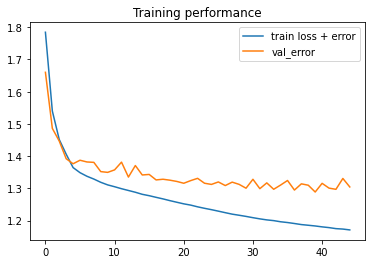

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

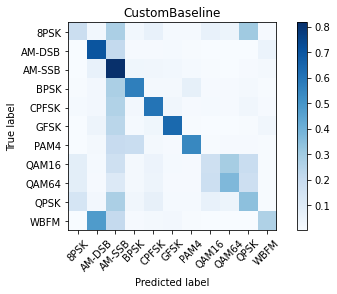

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08543833580980684


Overall Accuracy:  0.09611829944547134


Overall Accuracy:  0.09508660303994344


Overall Accuracy:  0.11806043569922699


Overall Accuracy:  0.13222543352601157


Overall Accuracy:  0.1886860007160759


Overall Accuracy:  0.2780365460408456


Overall Accuracy:  0.38226744186046513


Overall Accuracy:  0.47248846290379837
Overall Accuracy:  0.5686556434219986


Overall Accuracy:  0.6564996368917938
Overall Accuracy:  0.6974395961053012


Overall Accuracy:  0.7199240986717268


Overall Accuracy:  0.7130597014925373
Overall Accuracy:  0.7146974063400576


Overall Accuracy:  0.7152752460809333
Overall Accuracy:  0.7104776008885598


Overall Accuracy:  0.7122978563369687


Overall Accuracy:  0.7144436256448047


Overall Accuracy:  0.7053763440860215


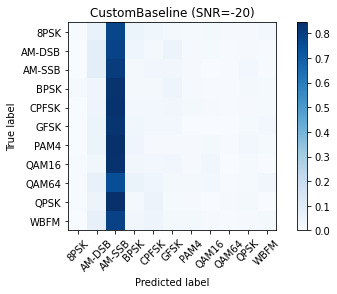

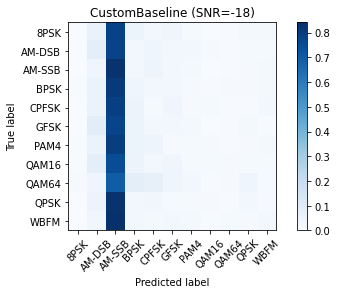

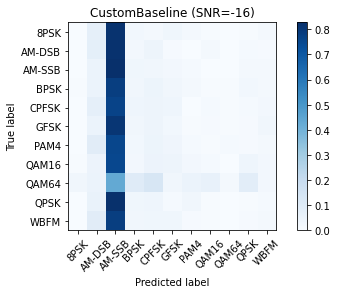

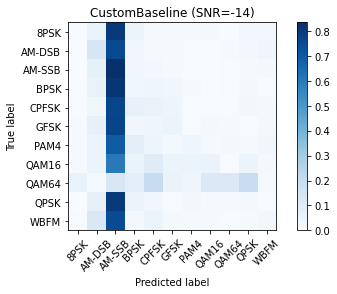

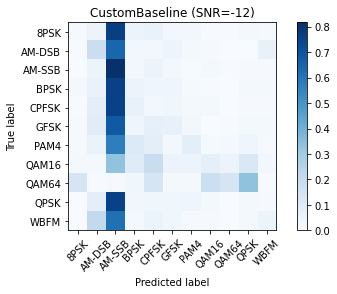

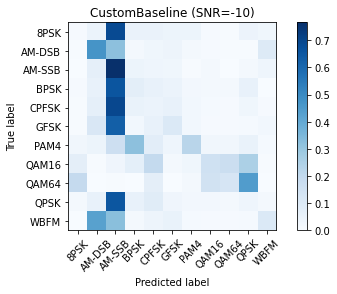

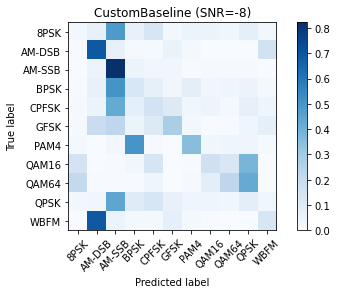

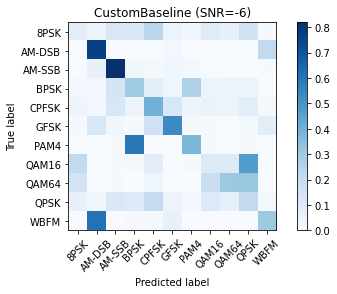

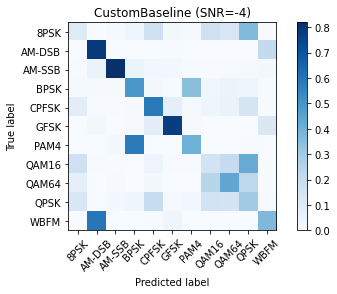

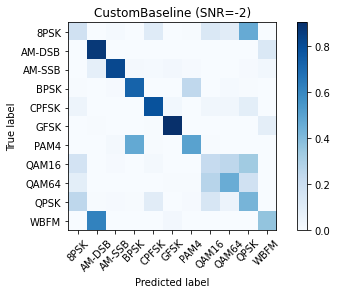

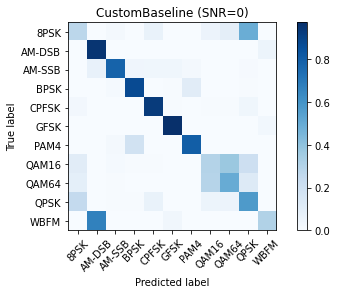

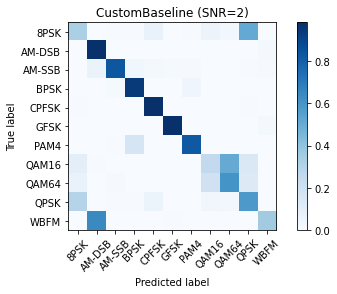

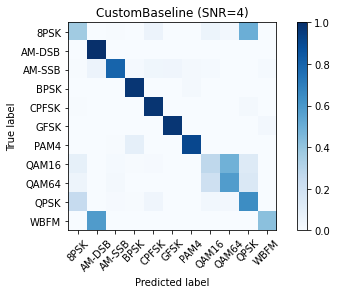

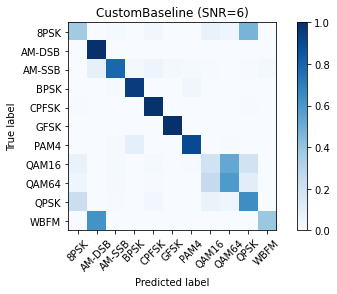

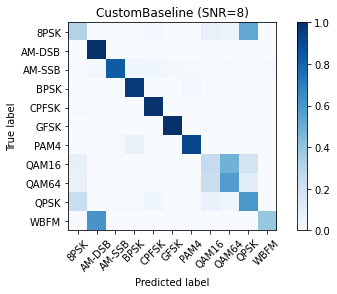

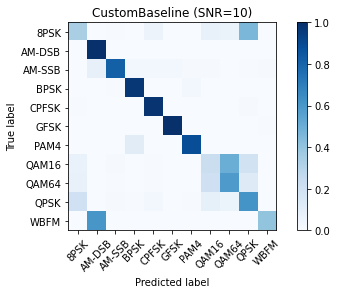

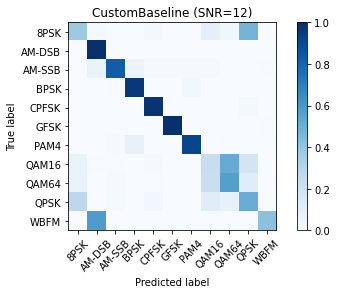

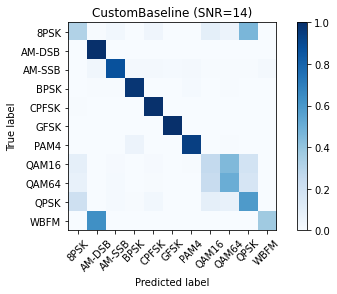

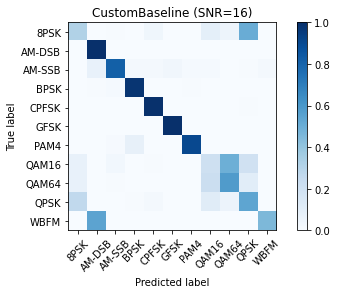

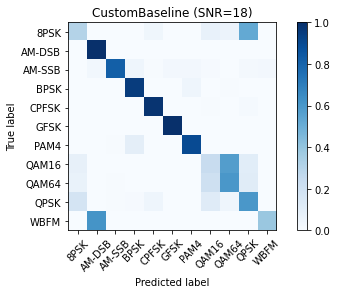

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,11,13,18,27,38,47,56,65,69,71,71,71,71,71,71,71,70


In [18]:
import statistics

statistics.mean(acc.values())

0.4738277157501174

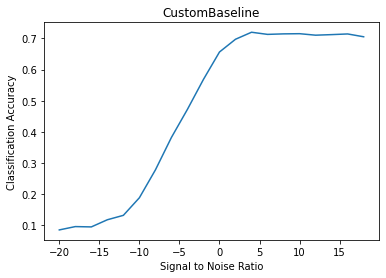

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)